In [1]:
import pandas as pd
import torch

#grab data from working directory
main_data = pd.read_csv('data/data.csv')
training_data = pd.read_csv('data/training_data.csv')
validation_data = pd.read_csv('data/validation_data.csv')

In [2]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Constant to control how frequently we print train loss

print('using device:', device)

using device: cuda:0


In [3]:
# prompt: write 2 data preprocessing functions
# the first one filters out all rows that have an empty 'problem_tags' column or have the problem_tags column include "*specialproblem". it also filters out all rows that have empty problem_statement columns
# the second function will split the problem_tags column and split it into two columns. the first resulting column will just be the original problem_tags column and the second resulting column will be rating.
# the problem tags column is originally a comma seperated list and should include some value that looks like *2400 or *2300 or *900, these values are ratings. there should be only one of them, take the rating value and put it in the rating column. if there is a problem with no rating value in its 'problem_tags' column it should be filtered out

def preprocess_data_1(df):
  """
  Filters out rows with empty 'problem_tags' or 'problem_statement' columns,
  and rows where 'problem_tags' contains '*specialproblem'.
  """
  df = df.dropna(subset=['problem_tags', 'problem_statement'])
  df = df[~df['problem_tags'].str.contains(r"\*specialproblem", na=False)]
  return df

def preprocess_data_2(df):
  """
  Splits the 'problem_tags' column into two columns: 'problem_tags' (original)
  and 'rating'. Extracts the rating value from the 'problem_tags' column if
  it exists, otherwise filters out the row.
  """
  def extract_rating(tags):
    if isinstance(tags, str):
      for tag in tags.split(','):
        if '*' in tag and tag.replace('*', '').isdigit():
          return int(tag.replace('*', ''))
    return None

  df.loc[:, 'rating'] = df['problem_tags'].apply(extract_rating)

  #drop rows with no rating
  df = df.dropna(subset=['rating'])

  for i in range(len(df)):
    good_tags = []
    for tag in df.iloc[i]['problem_tags'].split(','):
      if '*' not in tag and tag.split():
        good_tags.append(tag)
    df.loc[df.index[i], 'problem_tags'] = ','.join(good_tags)

  #drop problems with empty string for tags
  df = df[df['problem_tags'] != '']

  return df

main_data = preprocess_data_1(main_data)
main_data = preprocess_data_2(main_data)
training_data = preprocess_data_1(training_data)
training_data = preprocess_data_2(training_data)
validation_data = preprocess_data_1(validation_data)
validation_data = preprocess_data_2(validation_data)

In [4]:

n = 20  # Hyperparameter for the number of most frequent tags

all_tags = []
for tags in main_data['problem_tags'].dropna():
    all_tags.extend(tags.split(','))

from collections import Counter

tag_counts = Counter(all_tags)
most_frequent_tags = set([tag for tag, count in tag_counts.most_common(n)])
index_to_tag = {i: tag for i, tag in enumerate(most_frequent_tags)}
tag_to_index = {tag: i for i, tag in index_to_tag.items()}
print(f"The {n} most frequent tags are: {most_frequent_tags}")

The 20 most frequent tags are: {'strings', 'combinatorics', 'bitmasks', 'dfsandsimilar', 'constructivealgorithms', 'bruteforce', 'datastructures', 'twopointers', 'shortestpaths', 'dp', 'graphs', 'greedy', 'implementation', 'math', 'sortings', 'numbertheory', 'geometry', 'binarysearch', 'dsu', 'trees'}


In [5]:
# prompt: what percent of problems use a tag found in the n most common ?

problems_with_top_n_tags = 0
total_problems = len(main_data)

for tags in main_data['problem_tags'].dropna():
  if isinstance(tags, str):
    for tag in tags.split(','):
      if tag in most_frequent_tags:
        problems_with_top_n_tags += 1
        break  # Only count the problem once if it has at least one top-n tag

percentage = (problems_with_top_n_tags / total_problems) * 100
print(f"Percentage of problems with at least one of the top {n} tags: {percentage:.2f}%")

Percentage of problems with at least one of the top 20 tags: 98.81%


In [6]:
# prompt: write a transformation of the training data set where for each problem. lets say the problem has k tags, we include 2^k total versions of the problem, each with all the subsets of its tags, afterwords print the length of the training dataset

def transform_training_data(df):
    transformed_data = []
    for index, row in df.iterrows():
        tags = row['problem_tags'].split(',')
        tags = [tag for tag in tags if tag in most_frequent_tags]
        num_tags = len(tags)
        for i in range(2**num_tags):
            subset_tags = []
            for j in range(num_tags):
                if (i >> j) & 1:
                    subset_tags.append(tags[j])
            new_row = row.copy()
            new_row['problem_tags'] = ','.join(subset_tags)
            transformed_data.append(new_row)
    return pd.DataFrame(transformed_data)

training_data = transform_training_data(training_data)
print(len(training_data))

51653


In [7]:
from sklearn.utils import resample

desired_samples = 1000
threshold = 999

# Identify less frequent tags
less_frequent_tags = [tag for tag in most_frequent_tags if tag_counts[tag] < threshold]  # Set your desired threshold

# Oversample data points with less frequent tags
oversampled_data = []
for tag in less_frequent_tags:
    tag_data = training_data[training_data['problem_tags'].str.contains(tag)]
    oversampled_tag_data = resample(tag_data, replace=True, n_samples=desired_samples, random_state=42)  # Adjust desired_samples
    oversampled_data.append(oversampled_tag_data)

# Combine oversampled data with original data
training_data = pd.concat([training_data] + oversampled_data)

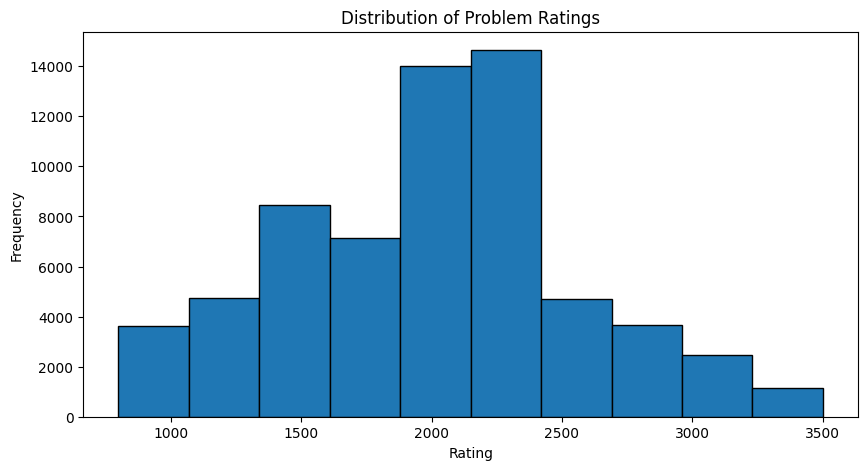

64653


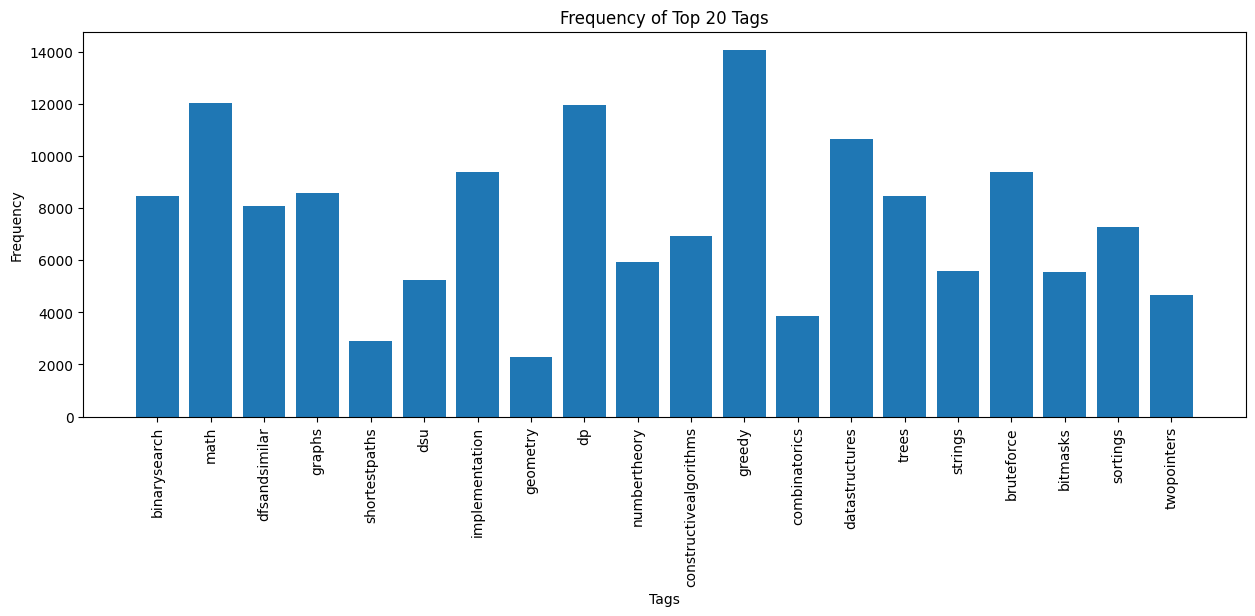

64653


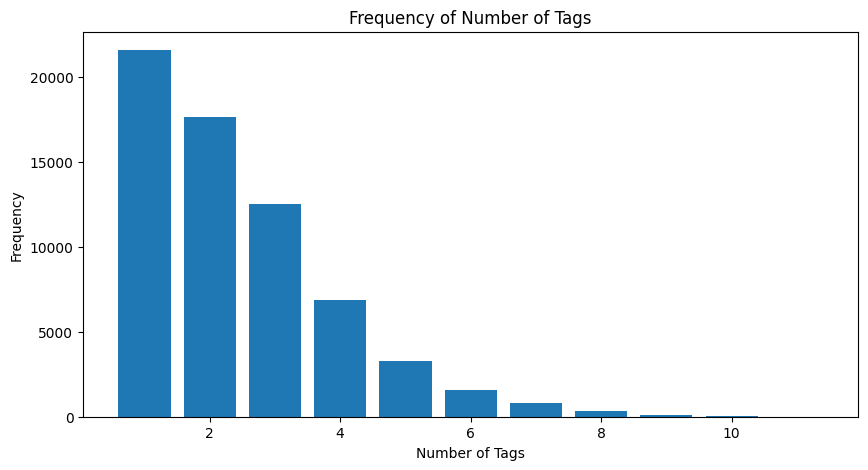

In [8]:
# prompt: make a histogram for the ratings a bar graph for the frequency of each tag in the top n

import matplotlib.pyplot as plt
from collections import Counter

# Assuming 'main_data' and 'most_frequent_tags' are defined as in your previous code

# Histogram for ratings
plt.figure(figsize=(10, 5))
plt.hist(training_data['rating'], bins=10, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Problem Ratings')
plt.show()

print(len(training_data))

# Bar graph for tag frequency
tag_frequencies = Counter([tag for tags in training_data['problem_tags'].dropna() for tag in tags.split(',') if tag in most_frequent_tags])

plt.figure(figsize=(15, 5))
plt.bar(tag_frequencies.keys(), tag_frequencies.values())
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title(f'Frequency of Top {n} Tags')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


#bar graph for how many problems have k different tags in the top n
tag_counts = {}
for tags in training_data['problem_tags'].dropna():
  if isinstance(tags, str):
    tag_count = len(tags.split(','))
    if tag_count in tag_counts:
      tag_counts[tag_count] += 1
    else:
      tag_counts[tag_count] = 1

plt.figure(figsize=(10, 5))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.title(f'Frequency of Number of Tags')
print(len(training_data))

In [9]:
# prompt: now make a function that takes  the string from problem tags, and returns a pytorch vector of floats length n, where a[i] is 1 iff the ith most frequent problem tag is in the list
# also make a function that takes a rating and computes its zscore when the mean rating is 1500 and the standard deviation is 300
# make an inverse of that function as well
from transformers import BertTokenizer
def problem_tags_to_vector(tags_string, most_frequent_tags, n):
  """
  Converts a string of problem tags to a PyTorch vector of length n.

  Args:
    tags_string: A string of problem tags separated by commas.
    most_frequent_tags: A set of the n most frequent problem tags.
    n: The length of the vector.

  Returns:
    A PyTorch vector of floats, where a[i] is 1 if the ith most frequent
    problem tag is present in the tags_string, and 0 otherwise.
  """
  if not isinstance(tags_string, str):
    return torch.zeros(n)
  tags = set(tags_string.split(','))
  vector = [1.0 if tag in tags else 0.0 for tag in most_frequent_tags]
  return torch.tensor(vector, dtype=torch.float32)

def rating_to_zscore(rating):
  """Computes the z-score of a rating."""
  mean_rating = 1500
  std_rating = 300
  return (rating - mean_rating) / std_rating

def zscore_to_rating(zscore):
  """Computes the rating from a z-score."""
  mean_rating = 1500
  std_rating = 300
  return (zscore * std_rating) + mean_rating

MAXLEN = 512
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_text(text):
  return tokenizer(text, padding='max_length', truncation=True, max_length=MAXLEN)


#TODO
#MOVE THIS TO A MORE SENSIBLE AREA

/common/home/nt406/Desktop/cf-classification/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from transformers import BertModel
from torch.utils.data import Dataset
import torch.nn.init as init
import torch.nn as nn

class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.bert = BertModel.from_pretrained('prajjwal1/bert-small')
        self.rating_classifier = nn.Linear(768, 1)  # For regression or binary classification
        self.tag_classifier = nn.Linear(768, n)  # Multi-label classification

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        rating_pred = self.rating_classifier(pooled_output)
        tag_pred = self.tag_classifier(pooled_output)
        return rating_pred, tag_pred

class TagModel(nn.Module):
    def __init__(self):
        super(TagModel, self).__init__()
        self.bert = BertModel.from_pretrained('prajjwal1/bert-small')
        self.dropout = nn.Dropout(0.2)  # Experiment with dropout rate (e.g., 0.1-0.5)
        self.tag_classifier = nn.Sequential(
            nn.Linear(512, n),  # Your original linear layer
            nn.LayerNorm(n)   # Layer Normalization layer
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)  # Apply dropout
        tag_pred = self.tag_classifier(pooled_output)
        return tag_pred

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, ratings, tags, device):
        self.input_ids = input_ids.to(device)
        self.attention_mask = attention_mask.to(device)
        self.ratings = ratings.to(device)
        self.tags = tags.to(device)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.ratings[idx], self.tags[idx]

In [11]:
from torch.utils.data import DataLoader, TensorDataset

texts = training_data['problem_statement'].tolist()
encodings = tokenizer(texts, truncation=True, padding=True, max_length=MAXLEN)

tags = training_data['problem_tags'].tolist()
tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in tags]

ratings = training_data['rating'].tolist()
ratings = [rating_to_zscore(rating) for rating in ratings]

input_ids = torch.tensor(encodings['input_ids'])
attention_mask = torch.tensor(encodings['attention_mask'])
ratings = torch.tensor(ratings, dtype=torch.float32)

tags = torch.stack(tags)

#validation stuff
val_texts = validation_data['problem_statement'].tolist()
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAXLEN)

val_tags = validation_data['problem_tags'].tolist()
val_tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in val_tags]

val_ratings = validation_data['rating'].tolist()
val_ratings = [rating_to_zscore(rating) for rating in val_ratings]

val_input_ids = torch.tensor(val_encodings['input_ids'])
val_attention_mask = torch.tensor(val_encodings['attention_mask'])
val_ratings = torch.tensor(val_ratings, dtype=torch.float32)

val_tags = torch.stack(val_tags)


bsz = 32
val_dataset = CustomDataset(val_input_ids, val_attention_mask, val_ratings, val_tags, device)
val_loader = DataLoader(val_dataset, batch_size=bsz, shuffle=True)
dataset = CustomDataset(input_ids, attention_mask, ratings, tags, device)
loader = DataLoader(dataset, batch_size=bsz, shuffle=True)

In [12]:
# prompt: write a function that runs the model on the validation data set, and determines its accuracy on each specific tag. Returns a vector length n with the % accuracy for each tag. The model uses a threshold of 0.5 for classification. remember to apply sigmoid to map the output layer to [0,1]

def evaluate_tag_accuracy(model, val_loader, device, n):
  """
  Evaluates the model's accuracy on the validation dataset for each tag.

  Args:
    model: The trained model.
    val_loader: The DataLoader for the validation dataset.
    device: The device to run the model on (e.g., 'cuda' or 'cpu').
    n: The number of tags.

  Returns:
    A list of floats, representing the accuracy for each tag.
  """

  model.eval()  # Set the model to evaluation mode
  tag_correct_counts = [0] * n
  tag_total_counts = [0] * n
  avg_loss = 0
  with torch.no_grad():
    for batch in val_loader:
      input_ids, attention_mask, _, true_tags = batch
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      true_tags = true_tags.to(device)


      tag_pred = model(input_ids, attention_mask)
      loss = nn.BCEWithLogitsLoss()(tag_pred, true_tags)
      avg_loss += loss.item()
      tag_pred = torch.sigmoid(tag_pred)  # Apply sigmoid to get probabilities in [0,1]

      predicted_tags = (tag_pred > 0.5).float()

      for i in range(n):
        tag_correct_counts[i] += (predicted_tags[:, i] == true_tags[:, i]).sum().item()
        tag_total_counts[i] += true_tags.shape[0]
  avg_loss /= len(val_loader)

  tag_accuracies = []
  for i in range(n):
    if tag_total_counts[i] > 0:
      tag_accuracies.append(tag_correct_counts[i] / tag_total_counts[i] * 100)
    else:
      tag_accuracies.append(0.0)

  return (avg_loss,tag_accuracies)

In [13]:
import matplotlib.pyplot as plt
from IPython import display
import torch.optim as optim
from tqdm import tqdm

total_losses = []
val_losses = []
val_acc = []

model = TagModel()
model.apply(init_weights)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
model.train()

EPOCHS = 1
for epoch in range(EPOCHS):
    loop = tqdm(loader, leave=True) # wrap the dataloader with tqdm
    for batch_idx, batch in enumerate(loop):
        input_ids, attention_mask, rating_labels, tag_labels = batch

        optimizer.zero_grad()
        tag_pred = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = nn.BCEWithLogitsLoss()(tag_pred, tag_labels)

        total_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch + 1}/{EPOCHS}]")
        loop.set_postfix(tag_loss=loss.item())

    print(f"Epoch {epoch + 1} completed.")
    model.eval()
    avg_loss, tag_accuracies = evaluate_tag_accuracy(model, val_loader, device, n)
    val_losses.append(avg_loss)
    val_acc.append(tag_accuracies)
    print(f"Validation Loss: {avg_loss}")
    print(f"Tag Accuracies: {tag_accuracies}")
    model.train()


  0%|          | 0/2021 [00:00<?, ?it/s]

Epoch [1/1]:   0%|          | 0/2021 [00:00<?, ?it/s]

Epoch [1/1]:   0%|          | 0/2021 [00:00<?, ?it/s, tag_loss=0.821]

Epoch [1/1]:   0%|          | 1/2021 [00:00<29:00,  1.16it/s, tag_loss=0.821]

Epoch [1/1]:   0%|          | 1/2021 [00:00<29:00,  1.16it/s, tag_loss=0.821]

Epoch [1/1]:   0%|          | 1/2021 [00:01<29:00,  1.16it/s, tag_loss=0.827]

Epoch [1/1]:   0%|          | 2/2021 [00:01<16:10,  2.08it/s, tag_loss=0.827]

Epoch [1/1]:   0%|          | 2/2021 [00:01<16:10,  2.08it/s, tag_loss=0.827]

Epoch [1/1]:   0%|          | 2/2021 [00:01<16:10,  2.08it/s, tag_loss=0.811]

Epoch [1/1]:   0%|          | 3/2021 [00:01<12:00,  2.80it/s, tag_loss=0.811]

Epoch [1/1]:   0%|          | 3/2021 [00:01<12:00,  2.80it/s, tag_loss=0.811]

Epoch [1/1]:   0%|          | 3/2021 [00:01<12:00,  2.80it/s, tag_loss=0.81] 

Epoch [1/1]:   0%|          | 4/2021 [00:01<10:02,  3.35it/s, tag_loss=0.81]

Epoch [1/1]:   0%|          | 4/2021 [00:01<10:02,  3.35it/s, tag_loss=0.81]

Epoch [1/1]:   0%|          | 4/2021 [00:01<10:02,  3.35it/s, tag_loss=0.794]

Epoch [1/1]:   0%|          | 5/2021 [00:01<08:59,  3.74it/s, tag_loss=0.794]

Epoch [1/1]:   0%|          | 5/2021 [00:01<08:59,  3.74it/s, tag_loss=0.794]

Epoch [1/1]:   0%|          | 5/2021 [00:01<08:59,  3.74it/s, tag_loss=0.809]

Epoch [1/1]:   0%|          | 6/2021 [00:01<08:21,  4.02it/s, tag_loss=0.809]

Epoch [1/1]:   0%|          | 6/2021 [00:01<08:21,  4.02it/s, tag_loss=0.809]

Epoch [1/1]:   0%|          | 6/2021 [00:02<08:21,  4.02it/s, tag_loss=0.788]

Epoch [1/1]:   0%|          | 7/2021 [00:02<07:56,  4.22it/s, tag_loss=0.788]

Epoch [1/1]:   0%|          | 7/2021 [00:02<07:56,  4.22it/s, tag_loss=0.788]

Epoch [1/1]:   0%|          | 7/2021 [00:02<07:56,  4.22it/s, tag_loss=0.801]

Epoch [1/1]:   0%|          | 8/2021 [00:02<07:40,  4.37it/s, tag_loss=0.801]

Epoch [1/1]:   0%|          | 8/2021 [00:02<07:40,  4.37it/s, tag_loss=0.801]

Epoch [1/1]:   0%|          | 8/2021 [00:02<07:40,  4.37it/s, tag_loss=0.774]

Epoch [1/1]:   0%|          | 9/2021 [00:02<07:29,  4.47it/s, tag_loss=0.774]

Epoch [1/1]:   0%|          | 9/2021 [00:02<07:29,  4.47it/s, tag_loss=0.774]

Epoch [1/1]:   0%|          | 9/2021 [00:02<07:29,  4.47it/s, tag_loss=0.786]

Epoch [1/1]:   0%|          | 10/2021 [00:02<07:22,  4.54it/s, tag_loss=0.786]

Epoch [1/1]:   0%|          | 10/2021 [00:02<07:22,  4.54it/s, tag_loss=0.786]

Epoch [1/1]:   0%|          | 10/2021 [00:02<07:22,  4.54it/s, tag_loss=0.78] 

Epoch [1/1]:   1%|          | 11/2021 [00:02<07:17,  4.60it/s, tag_loss=0.78]

Epoch [1/1]:   1%|          | 11/2021 [00:03<07:17,  4.60it/s, tag_loss=0.78]

Epoch [1/1]:   1%|          | 11/2021 [00:03<07:17,  4.60it/s, tag_loss=0.756]

Epoch [1/1]:   1%|          | 12/2021 [00:03<07:14,  4.62it/s, tag_loss=0.756]

Epoch [1/1]:   1%|          | 12/2021 [00:03<07:14,  4.62it/s, tag_loss=0.756]

Epoch [1/1]:   1%|          | 12/2021 [00:03<07:14,  4.62it/s, tag_loss=0.771]

Epoch [1/1]:   1%|          | 13/2021 [00:03<07:11,  4.65it/s, tag_loss=0.771]

Epoch [1/1]:   1%|          | 13/2021 [00:03<07:11,  4.65it/s, tag_loss=0.771]

Epoch [1/1]:   1%|          | 13/2021 [00:03<07:11,  4.65it/s, tag_loss=0.787]

Epoch [1/1]:   1%|          | 14/2021 [00:03<07:10,  4.67it/s, tag_loss=0.787]

Epoch [1/1]:   1%|          | 14/2021 [00:03<07:10,  4.67it/s, tag_loss=0.787]

Epoch [1/1]:   1%|          | 14/2021 [00:03<07:10,  4.67it/s, tag_loss=0.756]

Epoch [1/1]:   1%|          | 15/2021 [00:03<07:08,  4.68it/s, tag_loss=0.756]

Epoch [1/1]:   1%|          | 15/2021 [00:03<07:08,  4.68it/s, tag_loss=0.756]

Epoch [1/1]:   1%|          | 15/2021 [00:04<07:08,  4.68it/s, tag_loss=0.793]

Epoch [1/1]:   1%|          | 16/2021 [00:04<07:07,  4.69it/s, tag_loss=0.793]

Epoch [1/1]:   1%|          | 16/2021 [00:04<07:07,  4.69it/s, tag_loss=0.793]

Epoch [1/1]:   1%|          | 16/2021 [00:04<07:07,  4.69it/s, tag_loss=0.789]

Epoch [1/1]:   1%|          | 17/2021 [00:04<07:07,  4.69it/s, tag_loss=0.789]

Epoch [1/1]:   1%|          | 17/2021 [00:04<07:07,  4.69it/s, tag_loss=0.789]

Epoch [1/1]:   1%|          | 17/2021 [00:04<07:07,  4.69it/s, tag_loss=0.792]

Epoch [1/1]:   1%|          | 18/2021 [00:04<07:07,  4.69it/s, tag_loss=0.792]

Epoch [1/1]:   1%|          | 18/2021 [00:04<07:07,  4.69it/s, tag_loss=0.792]

Epoch [1/1]:   1%|          | 18/2021 [00:04<07:07,  4.69it/s, tag_loss=0.744]

Epoch [1/1]:   1%|          | 19/2021 [00:04<07:06,  4.70it/s, tag_loss=0.744]

Epoch [1/1]:   1%|          | 19/2021 [00:04<07:06,  4.70it/s, tag_loss=0.744]

Epoch [1/1]:   1%|          | 19/2021 [00:04<07:06,  4.70it/s, tag_loss=0.76] 

Epoch [1/1]:   1%|          | 20/2021 [00:04<07:05,  4.70it/s, tag_loss=0.76]

Epoch [1/1]:   1%|          | 20/2021 [00:04<07:05,  4.70it/s, tag_loss=0.76]

Epoch [1/1]:   1%|          | 20/2021 [00:05<07:05,  4.70it/s, tag_loss=0.772]

Epoch [1/1]:   1%|          | 21/2021 [00:05<07:05,  4.70it/s, tag_loss=0.772]

Epoch [1/1]:   1%|          | 21/2021 [00:05<07:05,  4.70it/s, tag_loss=0.772]

Epoch [1/1]:   1%|          | 21/2021 [00:05<07:05,  4.70it/s, tag_loss=0.768]

Epoch [1/1]:   1%|          | 22/2021 [00:05<07:05,  4.70it/s, tag_loss=0.768]

Epoch [1/1]:   1%|          | 22/2021 [00:05<07:05,  4.70it/s, tag_loss=0.768]

Epoch [1/1]:   1%|          | 22/2021 [00:05<07:05,  4.70it/s, tag_loss=0.763]

Epoch [1/1]:   1%|          | 23/2021 [00:05<07:05,  4.70it/s, tag_loss=0.763]

Epoch [1/1]:   1%|          | 23/2021 [00:05<07:05,  4.70it/s, tag_loss=0.763]

Epoch [1/1]:   1%|          | 23/2021 [00:05<07:05,  4.70it/s, tag_loss=0.744]

Epoch [1/1]:   1%|          | 24/2021 [00:05<07:05,  4.70it/s, tag_loss=0.744]

Epoch [1/1]:   1%|          | 24/2021 [00:05<07:05,  4.70it/s, tag_loss=0.744]

Epoch [1/1]:   1%|          | 24/2021 [00:05<07:05,  4.70it/s, tag_loss=0.76] 

Epoch [1/1]:   1%|          | 25/2021 [00:05<07:05,  4.69it/s, tag_loss=0.76]

Epoch [1/1]:   1%|          | 25/2021 [00:06<07:05,  4.69it/s, tag_loss=0.76]

Epoch [1/1]:   1%|          | 25/2021 [00:06<07:05,  4.69it/s, tag_loss=0.761]

Epoch [1/1]:   1%|▏         | 26/2021 [00:06<07:05,  4.69it/s, tag_loss=0.761]

Epoch [1/1]:   1%|▏         | 26/2021 [00:06<07:05,  4.69it/s, tag_loss=0.761]

Epoch [1/1]:   1%|▏         | 26/2021 [00:06<07:05,  4.69it/s, tag_loss=0.765]

Epoch [1/1]:   1%|▏         | 27/2021 [00:06<07:05,  4.69it/s, tag_loss=0.765]

Epoch [1/1]:   1%|▏         | 27/2021 [00:06<07:05,  4.69it/s, tag_loss=0.765]

Epoch [1/1]:   1%|▏         | 27/2021 [00:06<07:05,  4.69it/s, tag_loss=0.784]

Epoch [1/1]:   1%|▏         | 28/2021 [00:06<07:04,  4.69it/s, tag_loss=0.784]

Epoch [1/1]:   1%|▏         | 28/2021 [00:06<07:04,  4.69it/s, tag_loss=0.784]

Epoch [1/1]:   1%|▏         | 28/2021 [00:06<07:04,  4.69it/s, tag_loss=0.783]

Epoch [1/1]:   1%|▏         | 29/2021 [00:06<07:04,  4.69it/s, tag_loss=0.783]

Epoch [1/1]:   1%|▏         | 29/2021 [00:06<07:04,  4.69it/s, tag_loss=0.783]

Epoch [1/1]:   1%|▏         | 29/2021 [00:07<07:04,  4.69it/s, tag_loss=0.776]

Epoch [1/1]:   1%|▏         | 30/2021 [00:07<07:05,  4.68it/s, tag_loss=0.776]

Epoch [1/1]:   1%|▏         | 30/2021 [00:07<07:05,  4.68it/s, tag_loss=0.776]

Epoch [1/1]:   1%|▏         | 30/2021 [00:07<07:05,  4.68it/s, tag_loss=0.743]

Epoch [1/1]:   2%|▏         | 31/2021 [00:07<07:04,  4.68it/s, tag_loss=0.743]

Epoch [1/1]:   2%|▏         | 31/2021 [00:07<07:04,  4.68it/s, tag_loss=0.743]

Epoch [1/1]:   2%|▏         | 31/2021 [00:07<07:04,  4.68it/s, tag_loss=0.763]

Epoch [1/1]:   2%|▏         | 32/2021 [00:07<07:04,  4.68it/s, tag_loss=0.763]

Epoch [1/1]:   2%|▏         | 32/2021 [00:07<07:04,  4.68it/s, tag_loss=0.763]

Epoch [1/1]:   2%|▏         | 32/2021 [00:07<07:04,  4.68it/s, tag_loss=0.754]

Epoch [1/1]:   2%|▏         | 33/2021 [00:07<07:04,  4.68it/s, tag_loss=0.754]

Epoch [1/1]:   2%|▏         | 33/2021 [00:07<07:04,  4.68it/s, tag_loss=0.754]

Epoch [1/1]:   2%|▏         | 33/2021 [00:07<07:04,  4.68it/s, tag_loss=0.786]

Epoch [1/1]:   2%|▏         | 34/2021 [00:07<07:04,  4.68it/s, tag_loss=0.786]

Epoch [1/1]:   2%|▏         | 34/2021 [00:07<07:04,  4.68it/s, tag_loss=0.786]

Epoch [1/1]:   2%|▏         | 34/2021 [00:08<07:04,  4.68it/s, tag_loss=0.768]

Epoch [1/1]:   2%|▏         | 35/2021 [00:08<07:04,  4.68it/s, tag_loss=0.768]

Epoch [1/1]:   2%|▏         | 35/2021 [00:08<07:04,  4.68it/s, tag_loss=0.768]

Epoch [1/1]:   2%|▏         | 35/2021 [00:08<07:04,  4.68it/s, tag_loss=0.762]

Epoch [1/1]:   2%|▏         | 36/2021 [00:08<07:04,  4.68it/s, tag_loss=0.762]

Epoch [1/1]:   2%|▏         | 36/2021 [00:08<07:04,  4.68it/s, tag_loss=0.762]

Epoch [1/1]:   2%|▏         | 36/2021 [00:08<07:04,  4.68it/s, tag_loss=0.79] 

Epoch [1/1]:   2%|▏         | 37/2021 [00:08<07:04,  4.68it/s, tag_loss=0.79]

Epoch [1/1]:   2%|▏         | 37/2021 [00:08<07:04,  4.68it/s, tag_loss=0.79]

Epoch [1/1]:   2%|▏         | 37/2021 [00:08<07:04,  4.68it/s, tag_loss=0.746]

Epoch [1/1]:   2%|▏         | 38/2021 [00:08<07:04,  4.67it/s, tag_loss=0.746]

Epoch [1/1]:   2%|▏         | 38/2021 [00:08<07:04,  4.67it/s, tag_loss=0.746]

Epoch [1/1]:   2%|▏         | 38/2021 [00:08<07:04,  4.67it/s, tag_loss=0.756]

Epoch [1/1]:   2%|▏         | 39/2021 [00:08<07:04,  4.67it/s, tag_loss=0.756]

Epoch [1/1]:   2%|▏         | 39/2021 [00:09<07:04,  4.67it/s, tag_loss=0.756]

Epoch [1/1]:   2%|▏         | 39/2021 [00:09<07:04,  4.67it/s, tag_loss=0.774]

Epoch [1/1]:   2%|▏         | 40/2021 [00:09<07:03,  4.67it/s, tag_loss=0.774]

Epoch [1/1]:   2%|▏         | 40/2021 [00:09<07:03,  4.67it/s, tag_loss=0.774]

Epoch [1/1]:   2%|▏         | 40/2021 [00:09<07:03,  4.67it/s, tag_loss=0.774]

Epoch [1/1]:   2%|▏         | 41/2021 [00:09<07:03,  4.68it/s, tag_loss=0.774]

Epoch [1/1]:   2%|▏         | 41/2021 [00:09<07:03,  4.68it/s, tag_loss=0.774]

Epoch [1/1]:   2%|▏         | 41/2021 [00:09<07:03,  4.68it/s, tag_loss=0.778]

Epoch [1/1]:   2%|▏         | 42/2021 [00:09<07:02,  4.68it/s, tag_loss=0.778]

Epoch [1/1]:   2%|▏         | 42/2021 [00:09<07:02,  4.68it/s, tag_loss=0.778]

Epoch [1/1]:   2%|▏         | 42/2021 [00:09<07:02,  4.68it/s, tag_loss=0.763]

Epoch [1/1]:   2%|▏         | 43/2021 [00:09<07:02,  4.68it/s, tag_loss=0.763]

Epoch [1/1]:   2%|▏         | 43/2021 [00:09<07:02,  4.68it/s, tag_loss=0.763]

Epoch [1/1]:   2%|▏         | 43/2021 [00:10<07:02,  4.68it/s, tag_loss=0.762]

Epoch [1/1]:   2%|▏         | 44/2021 [00:10<07:02,  4.68it/s, tag_loss=0.762]

Epoch [1/1]:   2%|▏         | 44/2021 [00:10<07:02,  4.68it/s, tag_loss=0.762]

Epoch [1/1]:   2%|▏         | 44/2021 [00:10<07:02,  4.68it/s, tag_loss=0.758]

Epoch [1/1]:   2%|▏         | 45/2021 [00:10<07:02,  4.67it/s, tag_loss=0.758]

Epoch [1/1]:   2%|▏         | 45/2021 [00:10<07:02,  4.67it/s, tag_loss=0.758]

Epoch [1/1]:   2%|▏         | 45/2021 [00:10<07:02,  4.67it/s, tag_loss=0.759]

Epoch [1/1]:   2%|▏         | 46/2021 [00:10<07:02,  4.67it/s, tag_loss=0.759]

Epoch [1/1]:   2%|▏         | 46/2021 [00:10<07:02,  4.67it/s, tag_loss=0.759]

Epoch [1/1]:   2%|▏         | 46/2021 [00:10<07:02,  4.67it/s, tag_loss=0.763]

Epoch [1/1]:   2%|▏         | 47/2021 [00:10<07:03,  4.67it/s, tag_loss=0.763]

Epoch [1/1]:   2%|▏         | 47/2021 [00:10<07:03,  4.67it/s, tag_loss=0.763]

Epoch [1/1]:   2%|▏         | 47/2021 [00:10<07:03,  4.67it/s, tag_loss=0.749]

Epoch [1/1]:   2%|▏         | 48/2021 [00:10<07:03,  4.66it/s, tag_loss=0.749]

Epoch [1/1]:   2%|▏         | 48/2021 [00:10<07:03,  4.66it/s, tag_loss=0.749]

Epoch [1/1]:   2%|▏         | 48/2021 [00:11<07:03,  4.66it/s, tag_loss=0.771]

Epoch [1/1]:   2%|▏         | 49/2021 [00:11<07:02,  4.67it/s, tag_loss=0.771]

Epoch [1/1]:   2%|▏         | 49/2021 [00:11<07:02,  4.67it/s, tag_loss=0.771]

Epoch [1/1]:   2%|▏         | 49/2021 [00:11<07:02,  4.67it/s, tag_loss=0.749]

Epoch [1/1]:   2%|▏         | 50/2021 [00:11<07:02,  4.67it/s, tag_loss=0.749]

Epoch [1/1]:   2%|▏         | 50/2021 [00:11<07:02,  4.67it/s, tag_loss=0.749]

Epoch [1/1]:   2%|▏         | 50/2021 [00:11<07:02,  4.67it/s, tag_loss=0.744]

Epoch [1/1]:   3%|▎         | 51/2021 [00:11<07:01,  4.67it/s, tag_loss=0.744]

Epoch [1/1]:   3%|▎         | 51/2021 [00:11<07:01,  4.67it/s, tag_loss=0.744]

Epoch [1/1]:   3%|▎         | 51/2021 [00:11<07:01,  4.67it/s, tag_loss=0.742]

Epoch [1/1]:   3%|▎         | 52/2021 [00:11<07:01,  4.67it/s, tag_loss=0.742]

Epoch [1/1]:   3%|▎         | 52/2021 [00:11<07:01,  4.67it/s, tag_loss=0.742]

Epoch [1/1]:   3%|▎         | 52/2021 [00:11<07:01,  4.67it/s, tag_loss=0.75] 

Epoch [1/1]:   3%|▎         | 53/2021 [00:11<07:02,  4.66it/s, tag_loss=0.75]

Epoch [1/1]:   3%|▎         | 53/2021 [00:12<07:02,  4.66it/s, tag_loss=0.75]

Epoch [1/1]:   3%|▎         | 53/2021 [00:12<07:02,  4.66it/s, tag_loss=0.758]

Epoch [1/1]:   3%|▎         | 54/2021 [00:12<07:02,  4.66it/s, tag_loss=0.758]

Epoch [1/1]:   3%|▎         | 54/2021 [00:12<07:02,  4.66it/s, tag_loss=0.758]

Epoch [1/1]:   3%|▎         | 54/2021 [00:12<07:02,  4.66it/s, tag_loss=0.733]

Epoch [1/1]:   3%|▎         | 55/2021 [00:12<07:02,  4.66it/s, tag_loss=0.733]

Epoch [1/1]:   3%|▎         | 55/2021 [00:12<07:02,  4.66it/s, tag_loss=0.733]

Epoch [1/1]:   3%|▎         | 55/2021 [00:12<07:02,  4.66it/s, tag_loss=0.753]

Epoch [1/1]:   3%|▎         | 56/2021 [00:12<07:01,  4.66it/s, tag_loss=0.753]

Epoch [1/1]:   3%|▎         | 56/2021 [00:12<07:01,  4.66it/s, tag_loss=0.753]

Epoch [1/1]:   3%|▎         | 56/2021 [00:12<07:01,  4.66it/s, tag_loss=0.769]

Epoch [1/1]:   3%|▎         | 57/2021 [00:12<07:01,  4.66it/s, tag_loss=0.769]

Epoch [1/1]:   3%|▎         | 57/2021 [00:12<07:01,  4.66it/s, tag_loss=0.769]

Epoch [1/1]:   3%|▎         | 57/2021 [00:13<07:01,  4.66it/s, tag_loss=0.752]

Epoch [1/1]:   3%|▎         | 58/2021 [00:13<07:01,  4.66it/s, tag_loss=0.752]

Epoch [1/1]:   3%|▎         | 58/2021 [00:13<07:01,  4.66it/s, tag_loss=0.752]

Epoch [1/1]:   3%|▎         | 58/2021 [00:13<07:01,  4.66it/s, tag_loss=0.769]

Epoch [1/1]:   3%|▎         | 59/2021 [00:13<07:01,  4.65it/s, tag_loss=0.769]

Epoch [1/1]:   3%|▎         | 59/2021 [00:13<07:01,  4.65it/s, tag_loss=0.769]

Epoch [1/1]:   3%|▎         | 59/2021 [00:13<07:01,  4.65it/s, tag_loss=0.775]

Epoch [1/1]:   3%|▎         | 60/2021 [00:13<07:01,  4.65it/s, tag_loss=0.775]

Epoch [1/1]:   3%|▎         | 60/2021 [00:13<07:01,  4.65it/s, tag_loss=0.775]

Epoch [1/1]:   3%|▎         | 60/2021 [00:13<07:01,  4.65it/s, tag_loss=0.735]

Epoch [1/1]:   3%|▎         | 61/2021 [00:13<07:01,  4.65it/s, tag_loss=0.735]

Epoch [1/1]:   3%|▎         | 61/2021 [00:13<07:01,  4.65it/s, tag_loss=0.735]

Epoch [1/1]:   3%|▎         | 61/2021 [00:13<07:01,  4.65it/s, tag_loss=0.738]

Epoch [1/1]:   3%|▎         | 62/2021 [00:13<07:01,  4.65it/s, tag_loss=0.738]

Epoch [1/1]:   3%|▎         | 62/2021 [00:13<07:01,  4.65it/s, tag_loss=0.738]

Epoch [1/1]:   3%|▎         | 62/2021 [00:14<07:01,  4.65it/s, tag_loss=0.771]

Epoch [1/1]:   3%|▎         | 63/2021 [00:14<07:00,  4.65it/s, tag_loss=0.771]

Epoch [1/1]:   3%|▎         | 63/2021 [00:14<07:00,  4.65it/s, tag_loss=0.771]

Epoch [1/1]:   3%|▎         | 63/2021 [00:14<07:00,  4.65it/s, tag_loss=0.771]

Epoch [1/1]:   3%|▎         | 64/2021 [00:14<07:00,  4.65it/s, tag_loss=0.771]

Epoch [1/1]:   3%|▎         | 64/2021 [00:14<07:00,  4.65it/s, tag_loss=0.771]

Epoch [1/1]:   3%|▎         | 64/2021 [00:14<07:00,  4.65it/s, tag_loss=0.739]

Epoch [1/1]:   3%|▎         | 65/2021 [00:14<07:00,  4.65it/s, tag_loss=0.739]

Epoch [1/1]:   3%|▎         | 65/2021 [00:14<07:00,  4.65it/s, tag_loss=0.739]

Epoch [1/1]:   3%|▎         | 65/2021 [00:14<07:00,  4.65it/s, tag_loss=0.761]

Epoch [1/1]:   3%|▎         | 66/2021 [00:14<07:00,  4.65it/s, tag_loss=0.761]

Epoch [1/1]:   3%|▎         | 66/2021 [00:14<07:00,  4.65it/s, tag_loss=0.761]

Epoch [1/1]:   3%|▎         | 66/2021 [00:14<07:00,  4.65it/s, tag_loss=0.754]

Epoch [1/1]:   3%|▎         | 67/2021 [00:14<07:00,  4.65it/s, tag_loss=0.754]

Epoch [1/1]:   3%|▎         | 67/2021 [00:15<07:00,  4.65it/s, tag_loss=0.754]

Epoch [1/1]:   3%|▎         | 67/2021 [00:15<07:00,  4.65it/s, tag_loss=0.781]

Epoch [1/1]:   3%|▎         | 68/2021 [00:15<06:59,  4.65it/s, tag_loss=0.781]

Epoch [1/1]:   3%|▎         | 68/2021 [00:15<06:59,  4.65it/s, tag_loss=0.781]

Epoch [1/1]:   3%|▎         | 68/2021 [00:15<06:59,  4.65it/s, tag_loss=0.763]

Epoch [1/1]:   3%|▎         | 69/2021 [00:15<07:00,  4.64it/s, tag_loss=0.763]

Epoch [1/1]:   3%|▎         | 69/2021 [00:15<07:00,  4.64it/s, tag_loss=0.763]

Epoch [1/1]:   3%|▎         | 69/2021 [00:15<07:00,  4.64it/s, tag_loss=0.74] 

Epoch [1/1]:   3%|▎         | 70/2021 [00:15<07:00,  4.64it/s, tag_loss=0.74]

Epoch [1/1]:   3%|▎         | 70/2021 [00:15<07:00,  4.64it/s, tag_loss=0.74]

Epoch [1/1]:   3%|▎         | 70/2021 [00:15<07:00,  4.64it/s, tag_loss=0.786]

Epoch [1/1]:   4%|▎         | 71/2021 [00:15<07:00,  4.64it/s, tag_loss=0.786]

Epoch [1/1]:   4%|▎         | 71/2021 [00:15<07:00,  4.64it/s, tag_loss=0.786]

Epoch [1/1]:   4%|▎         | 71/2021 [00:16<07:00,  4.64it/s, tag_loss=0.764]

Epoch [1/1]:   4%|▎         | 72/2021 [00:16<07:00,  4.63it/s, tag_loss=0.764]

Epoch [1/1]:   4%|▎         | 72/2021 [00:16<07:00,  4.63it/s, tag_loss=0.764]

Epoch [1/1]:   4%|▎         | 72/2021 [00:16<07:00,  4.63it/s, tag_loss=0.749]

Epoch [1/1]:   4%|▎         | 73/2021 [00:16<07:00,  4.64it/s, tag_loss=0.749]

Epoch [1/1]:   4%|▎         | 73/2021 [00:16<07:00,  4.64it/s, tag_loss=0.749]

Epoch [1/1]:   4%|▎         | 73/2021 [00:16<07:00,  4.64it/s, tag_loss=0.76] 

Epoch [1/1]:   4%|▎         | 74/2021 [00:16<07:00,  4.63it/s, tag_loss=0.76]

Epoch [1/1]:   4%|▎         | 74/2021 [00:16<07:00,  4.63it/s, tag_loss=0.76]

Epoch [1/1]:   4%|▎         | 74/2021 [00:16<07:00,  4.63it/s, tag_loss=0.752]

Epoch [1/1]:   4%|▎         | 75/2021 [00:16<06:59,  4.64it/s, tag_loss=0.752]

Epoch [1/1]:   4%|▎         | 75/2021 [00:16<06:59,  4.64it/s, tag_loss=0.752]

Epoch [1/1]:   4%|▎         | 75/2021 [00:16<06:59,  4.64it/s, tag_loss=0.742]

Epoch [1/1]:   4%|▍         | 76/2021 [00:16<06:58,  4.65it/s, tag_loss=0.742]

Epoch [1/1]:   4%|▍         | 76/2021 [00:16<06:58,  4.65it/s, tag_loss=0.742]

Epoch [1/1]:   4%|▍         | 76/2021 [00:17<06:58,  4.65it/s, tag_loss=0.76] 

Epoch [1/1]:   4%|▍         | 77/2021 [00:17<06:57,  4.66it/s, tag_loss=0.76]

Epoch [1/1]:   4%|▍         | 77/2021 [00:17<06:57,  4.66it/s, tag_loss=0.76]

Epoch [1/1]:   4%|▍         | 77/2021 [00:17<06:57,  4.66it/s, tag_loss=0.768]

Epoch [1/1]:   4%|▍         | 78/2021 [00:17<06:56,  4.66it/s, tag_loss=0.768]

Epoch [1/1]:   4%|▍         | 78/2021 [00:17<06:56,  4.66it/s, tag_loss=0.768]

Epoch [1/1]:   4%|▍         | 78/2021 [00:17<06:56,  4.66it/s, tag_loss=0.77] 

Epoch [1/1]:   4%|▍         | 79/2021 [00:17<06:57,  4.66it/s, tag_loss=0.77]

Epoch [1/1]:   4%|▍         | 79/2021 [00:17<06:57,  4.66it/s, tag_loss=0.77]

Epoch [1/1]:   4%|▍         | 79/2021 [00:17<06:57,  4.66it/s, tag_loss=0.756]

Epoch [1/1]:   4%|▍         | 80/2021 [00:17<06:56,  4.66it/s, tag_loss=0.756]

Epoch [1/1]:   4%|▍         | 80/2021 [00:17<06:56,  4.66it/s, tag_loss=0.756]

Epoch [1/1]:   4%|▍         | 80/2021 [00:17<06:56,  4.66it/s, tag_loss=0.735]

Epoch [1/1]:   4%|▍         | 81/2021 [00:17<06:56,  4.66it/s, tag_loss=0.735]

Epoch [1/1]:   4%|▍         | 81/2021 [00:18<06:56,  4.66it/s, tag_loss=0.735]

Epoch [1/1]:   4%|▍         | 81/2021 [00:18<06:56,  4.66it/s, tag_loss=0.738]

Epoch [1/1]:   4%|▍         | 82/2021 [00:18<06:55,  4.66it/s, tag_loss=0.738]

Epoch [1/1]:   4%|▍         | 82/2021 [00:18<06:55,  4.66it/s, tag_loss=0.738]

Epoch [1/1]:   4%|▍         | 82/2021 [00:18<06:55,  4.66it/s, tag_loss=0.78] 

Epoch [1/1]:   4%|▍         | 83/2021 [00:18<06:55,  4.66it/s, tag_loss=0.78]

Epoch [1/1]:   4%|▍         | 83/2021 [00:18<06:55,  4.66it/s, tag_loss=0.78]

Epoch [1/1]:   4%|▍         | 83/2021 [00:18<06:55,  4.66it/s, tag_loss=0.767]

Epoch [1/1]:   4%|▍         | 84/2021 [00:18<06:55,  4.67it/s, tag_loss=0.767]

Epoch [1/1]:   4%|▍         | 84/2021 [00:18<06:55,  4.67it/s, tag_loss=0.767]

Epoch [1/1]:   4%|▍         | 84/2021 [00:18<06:55,  4.67it/s, tag_loss=0.771]

Epoch [1/1]:   4%|▍         | 85/2021 [00:18<06:54,  4.67it/s, tag_loss=0.771]

Epoch [1/1]:   4%|▍         | 85/2021 [00:18<06:54,  4.67it/s, tag_loss=0.771]

Epoch [1/1]:   4%|▍         | 85/2021 [00:19<06:54,  4.67it/s, tag_loss=0.782]

Epoch [1/1]:   4%|▍         | 86/2021 [00:19<06:55,  4.66it/s, tag_loss=0.782]

Epoch [1/1]:   4%|▍         | 86/2021 [00:19<06:55,  4.66it/s, tag_loss=0.782]

Epoch [1/1]:   4%|▍         | 86/2021 [00:19<06:55,  4.66it/s, tag_loss=0.748]

Epoch [1/1]:   4%|▍         | 87/2021 [00:19<06:55,  4.66it/s, tag_loss=0.748]

Epoch [1/1]:   4%|▍         | 87/2021 [00:19<06:55,  4.66it/s, tag_loss=0.748]

Epoch [1/1]:   4%|▍         | 87/2021 [00:19<06:55,  4.66it/s, tag_loss=0.771]

Epoch [1/1]:   4%|▍         | 88/2021 [00:19<06:54,  4.66it/s, tag_loss=0.771]

Epoch [1/1]:   4%|▍         | 88/2021 [00:19<06:54,  4.66it/s, tag_loss=0.771]

Epoch [1/1]:   4%|▍         | 88/2021 [00:19<06:54,  4.66it/s, tag_loss=0.754]

Epoch [1/1]:   4%|▍         | 89/2021 [00:19<06:54,  4.66it/s, tag_loss=0.754]

Epoch [1/1]:   4%|▍         | 89/2021 [00:19<06:54,  4.66it/s, tag_loss=0.754]

Epoch [1/1]:   4%|▍         | 89/2021 [00:19<06:54,  4.66it/s, tag_loss=0.769]

Epoch [1/1]:   4%|▍         | 90/2021 [00:19<06:54,  4.65it/s, tag_loss=0.769]

Epoch [1/1]:   4%|▍         | 90/2021 [00:19<06:54,  4.65it/s, tag_loss=0.769]

Epoch [1/1]:   4%|▍         | 90/2021 [00:20<06:54,  4.65it/s, tag_loss=0.774]

Epoch [1/1]:   5%|▍         | 91/2021 [00:20<06:54,  4.66it/s, tag_loss=0.774]

Epoch [1/1]:   5%|▍         | 91/2021 [00:20<06:54,  4.66it/s, tag_loss=0.774]

Epoch [1/1]:   5%|▍         | 91/2021 [00:20<06:54,  4.66it/s, tag_loss=0.73] 

Epoch [1/1]:   5%|▍         | 92/2021 [00:20<06:54,  4.65it/s, tag_loss=0.73]

Epoch [1/1]:   5%|▍         | 92/2021 [00:20<06:54,  4.65it/s, tag_loss=0.73]

Epoch [1/1]:   5%|▍         | 92/2021 [00:20<06:54,  4.65it/s, tag_loss=0.753]

Epoch [1/1]:   5%|▍         | 93/2021 [00:20<06:54,  4.65it/s, tag_loss=0.753]

Epoch [1/1]:   5%|▍         | 93/2021 [00:20<06:54,  4.65it/s, tag_loss=0.753]

Epoch [1/1]:   5%|▍         | 93/2021 [00:20<06:54,  4.65it/s, tag_loss=0.754]

Epoch [1/1]:   5%|▍         | 94/2021 [00:20<06:54,  4.65it/s, tag_loss=0.754]

Epoch [1/1]:   5%|▍         | 94/2021 [00:20<06:54,  4.65it/s, tag_loss=0.754]

Epoch [1/1]:   5%|▍         | 94/2021 [00:20<06:54,  4.65it/s, tag_loss=0.76] 

Epoch [1/1]:   5%|▍         | 95/2021 [00:20<06:54,  4.65it/s, tag_loss=0.76]

Epoch [1/1]:   5%|▍         | 95/2021 [00:21<06:54,  4.65it/s, tag_loss=0.76]

Epoch [1/1]:   5%|▍         | 95/2021 [00:21<06:54,  4.65it/s, tag_loss=0.769]

Epoch [1/1]:   5%|▍         | 96/2021 [00:21<06:54,  4.64it/s, tag_loss=0.769]

Epoch [1/1]:   5%|▍         | 96/2021 [00:21<06:54,  4.64it/s, tag_loss=0.769]

Epoch [1/1]:   5%|▍         | 96/2021 [00:21<06:54,  4.64it/s, tag_loss=0.78] 

Epoch [1/1]:   5%|▍         | 97/2021 [00:21<06:54,  4.64it/s, tag_loss=0.78]

Epoch [1/1]:   5%|▍         | 97/2021 [00:21<06:54,  4.64it/s, tag_loss=0.78]

Epoch [1/1]:   5%|▍         | 97/2021 [00:21<06:54,  4.64it/s, tag_loss=0.728]

Epoch [1/1]:   5%|▍         | 98/2021 [00:21<06:53,  4.65it/s, tag_loss=0.728]

Epoch [1/1]:   5%|▍         | 98/2021 [00:21<06:53,  4.65it/s, tag_loss=0.728]

Epoch [1/1]:   5%|▍         | 98/2021 [00:21<06:53,  4.65it/s, tag_loss=0.744]

Epoch [1/1]:   5%|▍         | 99/2021 [00:21<06:54,  4.64it/s, tag_loss=0.744]

Epoch [1/1]:   5%|▍         | 99/2021 [00:21<06:54,  4.64it/s, tag_loss=0.744]

Epoch [1/1]:   5%|▍         | 99/2021 [00:22<06:54,  4.64it/s, tag_loss=0.745]

Epoch [1/1]:   5%|▍         | 100/2021 [00:22<06:53,  4.64it/s, tag_loss=0.745]

Epoch [1/1]:   5%|▍         | 100/2021 [00:22<06:53,  4.64it/s, tag_loss=0.745]

Epoch [1/1]:   5%|▍         | 100/2021 [00:22<06:53,  4.64it/s, tag_loss=0.73] 

Epoch [1/1]:   5%|▍         | 101/2021 [00:22<06:54,  4.64it/s, tag_loss=0.73]

Epoch [1/1]:   5%|▍         | 101/2021 [00:22<06:54,  4.64it/s, tag_loss=0.73]

Epoch [1/1]:   5%|▍         | 101/2021 [00:22<06:54,  4.64it/s, tag_loss=0.771]

Epoch [1/1]:   5%|▌         | 102/2021 [00:22<06:54,  4.63it/s, tag_loss=0.771]

Epoch [1/1]:   5%|▌         | 102/2021 [00:22<06:54,  4.63it/s, tag_loss=0.771]

Epoch [1/1]:   5%|▌         | 102/2021 [00:22<06:54,  4.63it/s, tag_loss=0.752]

Epoch [1/1]:   5%|▌         | 103/2021 [00:22<06:53,  4.63it/s, tag_loss=0.752]

Epoch [1/1]:   5%|▌         | 103/2021 [00:22<06:53,  4.63it/s, tag_loss=0.752]

Epoch [1/1]:   5%|▌         | 103/2021 [00:22<06:53,  4.63it/s, tag_loss=0.754]

Epoch [1/1]:   5%|▌         | 104/2021 [00:22<06:53,  4.63it/s, tag_loss=0.754]

Epoch [1/1]:   5%|▌         | 104/2021 [00:23<06:53,  4.63it/s, tag_loss=0.754]

Epoch [1/1]:   5%|▌         | 104/2021 [00:23<06:53,  4.63it/s, tag_loss=0.758]

Epoch [1/1]:   5%|▌         | 105/2021 [00:23<06:53,  4.63it/s, tag_loss=0.758]

Epoch [1/1]:   5%|▌         | 105/2021 [00:23<06:53,  4.63it/s, tag_loss=0.758]

Epoch [1/1]:   5%|▌         | 105/2021 [00:23<06:53,  4.63it/s, tag_loss=0.752]

Epoch [1/1]:   5%|▌         | 106/2021 [00:23<06:54,  4.62it/s, tag_loss=0.752]

Epoch [1/1]:   5%|▌         | 106/2021 [00:23<06:54,  4.62it/s, tag_loss=0.752]

Epoch [1/1]:   5%|▌         | 106/2021 [00:23<06:54,  4.62it/s, tag_loss=0.726]

Epoch [1/1]:   5%|▌         | 107/2021 [00:23<06:54,  4.62it/s, tag_loss=0.726]

Epoch [1/1]:   5%|▌         | 107/2021 [00:23<06:54,  4.62it/s, tag_loss=0.726]

Epoch [1/1]:   5%|▌         | 107/2021 [00:23<06:54,  4.62it/s, tag_loss=0.732]

Epoch [1/1]:   5%|▌         | 108/2021 [00:23<06:54,  4.62it/s, tag_loss=0.732]

Epoch [1/1]:   5%|▌         | 108/2021 [00:23<06:54,  4.62it/s, tag_loss=0.732]

Epoch [1/1]:   5%|▌         | 108/2021 [00:24<06:54,  4.62it/s, tag_loss=0.773]

Epoch [1/1]:   5%|▌         | 109/2021 [00:24<06:53,  4.62it/s, tag_loss=0.773]

Epoch [1/1]:   5%|▌         | 109/2021 [00:24<06:53,  4.62it/s, tag_loss=0.773]

Epoch [1/1]:   5%|▌         | 109/2021 [00:24<06:53,  4.62it/s, tag_loss=0.733]

Epoch [1/1]:   5%|▌         | 110/2021 [00:24<06:53,  4.62it/s, tag_loss=0.733]

Epoch [1/1]:   5%|▌         | 110/2021 [00:24<06:53,  4.62it/s, tag_loss=0.733]

Epoch [1/1]:   5%|▌         | 110/2021 [00:24<06:53,  4.62it/s, tag_loss=0.743]

Epoch [1/1]:   5%|▌         | 111/2021 [00:24<06:53,  4.62it/s, tag_loss=0.743]

Epoch [1/1]:   5%|▌         | 111/2021 [00:24<06:53,  4.62it/s, tag_loss=0.743]

Epoch [1/1]:   5%|▌         | 111/2021 [00:24<06:53,  4.62it/s, tag_loss=0.756]

Epoch [1/1]:   6%|▌         | 112/2021 [00:24<06:53,  4.62it/s, tag_loss=0.756]

Epoch [1/1]:   6%|▌         | 112/2021 [00:24<06:53,  4.62it/s, tag_loss=0.756]

Epoch [1/1]:   6%|▌         | 112/2021 [00:24<06:53,  4.62it/s, tag_loss=0.762]

Epoch [1/1]:   6%|▌         | 113/2021 [00:24<06:53,  4.61it/s, tag_loss=0.762]

Epoch [1/1]:   6%|▌         | 113/2021 [00:24<06:53,  4.61it/s, tag_loss=0.762]

Epoch [1/1]:   6%|▌         | 113/2021 [00:25<06:53,  4.61it/s, tag_loss=0.777]

Epoch [1/1]:   6%|▌         | 114/2021 [00:25<06:53,  4.61it/s, tag_loss=0.777]

Epoch [1/1]:   6%|▌         | 114/2021 [00:25<06:53,  4.61it/s, tag_loss=0.777]

Epoch [1/1]:   6%|▌         | 114/2021 [00:25<06:53,  4.61it/s, tag_loss=0.761]

Epoch [1/1]:   6%|▌         | 115/2021 [00:25<06:53,  4.61it/s, tag_loss=0.761]

Epoch [1/1]:   6%|▌         | 115/2021 [00:25<06:53,  4.61it/s, tag_loss=0.761]

Epoch [1/1]:   6%|▌         | 115/2021 [00:25<06:53,  4.61it/s, tag_loss=0.753]

Epoch [1/1]:   6%|▌         | 116/2021 [00:25<06:52,  4.62it/s, tag_loss=0.753]

Epoch [1/1]:   6%|▌         | 116/2021 [00:25<06:52,  4.62it/s, tag_loss=0.753]

Epoch [1/1]:   6%|▌         | 116/2021 [00:25<06:52,  4.62it/s, tag_loss=0.756]

Epoch [1/1]:   6%|▌         | 117/2021 [00:25<06:52,  4.62it/s, tag_loss=0.756]

Epoch [1/1]:   6%|▌         | 117/2021 [00:25<06:52,  4.62it/s, tag_loss=0.756]

Epoch [1/1]:   6%|▌         | 117/2021 [00:25<06:52,  4.62it/s, tag_loss=0.75] 

Epoch [1/1]:   6%|▌         | 118/2021 [00:25<06:51,  4.62it/s, tag_loss=0.75]

Epoch [1/1]:   6%|▌         | 118/2021 [00:26<06:51,  4.62it/s, tag_loss=0.75]

Epoch [1/1]:   6%|▌         | 118/2021 [00:26<06:51,  4.62it/s, tag_loss=0.772]

Epoch [1/1]:   6%|▌         | 119/2021 [00:26<06:51,  4.62it/s, tag_loss=0.772]

Epoch [1/1]:   6%|▌         | 119/2021 [00:26<06:51,  4.62it/s, tag_loss=0.772]

Epoch [1/1]:   6%|▌         | 119/2021 [00:26<06:51,  4.62it/s, tag_loss=0.756]

Epoch [1/1]:   6%|▌         | 120/2021 [00:26<06:51,  4.62it/s, tag_loss=0.756]

Epoch [1/1]:   6%|▌         | 120/2021 [00:26<06:51,  4.62it/s, tag_loss=0.756]

Epoch [1/1]:   6%|▌         | 120/2021 [00:26<06:51,  4.62it/s, tag_loss=0.763]

Epoch [1/1]:   6%|▌         | 121/2021 [00:26<06:51,  4.61it/s, tag_loss=0.763]

Epoch [1/1]:   6%|▌         | 121/2021 [00:26<06:51,  4.61it/s, tag_loss=0.763]

Epoch [1/1]:   6%|▌         | 121/2021 [00:26<06:51,  4.61it/s, tag_loss=0.781]

Epoch [1/1]:   6%|▌         | 122/2021 [00:26<06:51,  4.61it/s, tag_loss=0.781]

Epoch [1/1]:   6%|▌         | 122/2021 [00:26<06:51,  4.61it/s, tag_loss=0.781]

Epoch [1/1]:   6%|▌         | 122/2021 [00:27<06:51,  4.61it/s, tag_loss=0.759]

Epoch [1/1]:   6%|▌         | 123/2021 [00:27<06:51,  4.61it/s, tag_loss=0.759]

Epoch [1/1]:   6%|▌         | 123/2021 [00:27<06:51,  4.61it/s, tag_loss=0.759]

Epoch [1/1]:   6%|▌         | 123/2021 [00:27<06:51,  4.61it/s, tag_loss=0.749]

Epoch [1/1]:   6%|▌         | 124/2021 [00:27<06:51,  4.61it/s, tag_loss=0.749]

Epoch [1/1]:   6%|▌         | 124/2021 [00:27<06:51,  4.61it/s, tag_loss=0.749]

Epoch [1/1]:   6%|▌         | 124/2021 [00:27<06:51,  4.61it/s, tag_loss=0.763]

Epoch [1/1]:   6%|▌         | 125/2021 [00:27<06:51,  4.61it/s, tag_loss=0.763]

Epoch [1/1]:   6%|▌         | 125/2021 [00:27<06:51,  4.61it/s, tag_loss=0.763]

Epoch [1/1]:   6%|▌         | 125/2021 [00:27<06:51,  4.61it/s, tag_loss=0.744]

Epoch [1/1]:   6%|▌         | 126/2021 [00:27<06:50,  4.61it/s, tag_loss=0.744]

Epoch [1/1]:   6%|▌         | 126/2021 [00:27<06:50,  4.61it/s, tag_loss=0.744]

Epoch [1/1]:   6%|▌         | 126/2021 [00:27<06:50,  4.61it/s, tag_loss=0.752]

Epoch [1/1]:   6%|▋         | 127/2021 [00:27<06:50,  4.61it/s, tag_loss=0.752]

Epoch [1/1]:   6%|▋         | 127/2021 [00:27<06:50,  4.61it/s, tag_loss=0.752]

Epoch [1/1]:   6%|▋         | 127/2021 [00:28<06:50,  4.61it/s, tag_loss=0.75] 

Epoch [1/1]:   6%|▋         | 128/2021 [00:28<06:50,  4.61it/s, tag_loss=0.75]

Epoch [1/1]:   6%|▋         | 128/2021 [00:28<06:50,  4.61it/s, tag_loss=0.75]

Epoch [1/1]:   6%|▋         | 128/2021 [00:28<06:50,  4.61it/s, tag_loss=0.768]

Epoch [1/1]:   6%|▋         | 129/2021 [00:28<06:50,  4.61it/s, tag_loss=0.768]

Epoch [1/1]:   6%|▋         | 129/2021 [00:28<06:50,  4.61it/s, tag_loss=0.768]

Epoch [1/1]:   6%|▋         | 129/2021 [00:28<06:50,  4.61it/s, tag_loss=0.749]

Epoch [1/1]:   6%|▋         | 130/2021 [00:28<06:50,  4.61it/s, tag_loss=0.749]

Epoch [1/1]:   6%|▋         | 130/2021 [00:28<06:50,  4.61it/s, tag_loss=0.749]

Epoch [1/1]:   6%|▋         | 130/2021 [00:28<06:50,  4.61it/s, tag_loss=0.74] 

Epoch [1/1]:   6%|▋         | 131/2021 [00:28<06:50,  4.61it/s, tag_loss=0.74]

Epoch [1/1]:   6%|▋         | 131/2021 [00:28<06:50,  4.61it/s, tag_loss=0.74]

Epoch [1/1]:   6%|▋         | 131/2021 [00:28<06:50,  4.61it/s, tag_loss=0.739]

Epoch [1/1]:   7%|▋         | 132/2021 [00:28<06:49,  4.61it/s, tag_loss=0.739]

Epoch [1/1]:   7%|▋         | 132/2021 [00:29<06:49,  4.61it/s, tag_loss=0.739]

Epoch [1/1]:   7%|▋         | 132/2021 [00:29<06:49,  4.61it/s, tag_loss=0.769]

Epoch [1/1]:   7%|▋         | 133/2021 [00:29<06:49,  4.61it/s, tag_loss=0.769]

Epoch [1/1]:   7%|▋         | 133/2021 [00:29<06:49,  4.61it/s, tag_loss=0.769]

Epoch [1/1]:   7%|▋         | 133/2021 [00:29<06:49,  4.61it/s, tag_loss=0.768]

Epoch [1/1]:   7%|▋         | 134/2021 [00:29<06:49,  4.61it/s, tag_loss=0.768]

Epoch [1/1]:   7%|▋         | 134/2021 [00:29<06:49,  4.61it/s, tag_loss=0.768]

Epoch [1/1]:   7%|▋         | 134/2021 [00:29<06:49,  4.61it/s, tag_loss=0.753]

Epoch [1/1]:   7%|▋         | 135/2021 [00:29<06:49,  4.61it/s, tag_loss=0.753]

Epoch [1/1]:   7%|▋         | 135/2021 [00:29<06:49,  4.61it/s, tag_loss=0.753]

Epoch [1/1]:   7%|▋         | 135/2021 [00:29<06:49,  4.61it/s, tag_loss=0.746]

Epoch [1/1]:   7%|▋         | 136/2021 [00:29<06:49,  4.60it/s, tag_loss=0.746]

Epoch [1/1]:   7%|▋         | 136/2021 [00:29<06:49,  4.60it/s, tag_loss=0.746]

Epoch [1/1]:   7%|▋         | 136/2021 [00:30<06:49,  4.60it/s, tag_loss=0.734]

Epoch [1/1]:   7%|▋         | 137/2021 [00:30<06:49,  4.60it/s, tag_loss=0.734]

Epoch [1/1]:   7%|▋         | 137/2021 [00:30<06:49,  4.60it/s, tag_loss=0.734]

Epoch [1/1]:   7%|▋         | 137/2021 [00:30<06:49,  4.60it/s, tag_loss=0.736]

Epoch [1/1]:   7%|▋         | 138/2021 [00:30<06:49,  4.60it/s, tag_loss=0.736]

Epoch [1/1]:   7%|▋         | 138/2021 [00:30<06:49,  4.60it/s, tag_loss=0.736]

Epoch [1/1]:   7%|▋         | 138/2021 [00:30<06:49,  4.60it/s, tag_loss=0.728]

Epoch [1/1]:   7%|▋         | 139/2021 [00:30<06:49,  4.60it/s, tag_loss=0.728]

Epoch [1/1]:   7%|▋         | 139/2021 [00:30<06:49,  4.60it/s, tag_loss=0.728]

Epoch [1/1]:   7%|▋         | 139/2021 [00:30<06:49,  4.60it/s, tag_loss=0.771]

Epoch [1/1]:   7%|▋         | 140/2021 [00:30<06:49,  4.60it/s, tag_loss=0.771]

Epoch [1/1]:   7%|▋         | 140/2021 [00:30<06:49,  4.60it/s, tag_loss=0.771]

Epoch [1/1]:   7%|▋         | 140/2021 [00:30<06:49,  4.60it/s, tag_loss=0.756]

Epoch [1/1]:   7%|▋         | 141/2021 [00:30<06:49,  4.60it/s, tag_loss=0.756]

Epoch [1/1]:   7%|▋         | 141/2021 [00:31<06:49,  4.60it/s, tag_loss=0.756]

Epoch [1/1]:   7%|▋         | 141/2021 [00:31<06:49,  4.60it/s, tag_loss=0.773]

Epoch [1/1]:   7%|▋         | 142/2021 [00:31<06:48,  4.59it/s, tag_loss=0.773]

Epoch [1/1]:   7%|▋         | 142/2021 [00:31<06:48,  4.59it/s, tag_loss=0.773]

Epoch [1/1]:   7%|▋         | 142/2021 [00:31<06:48,  4.59it/s, tag_loss=0.721]

Epoch [1/1]:   7%|▋         | 143/2021 [00:31<06:49,  4.59it/s, tag_loss=0.721]

Epoch [1/1]:   7%|▋         | 143/2021 [00:31<06:49,  4.59it/s, tag_loss=0.721]

Epoch [1/1]:   7%|▋         | 143/2021 [00:31<06:49,  4.59it/s, tag_loss=0.737]

Epoch [1/1]:   7%|▋         | 144/2021 [00:31<06:48,  4.60it/s, tag_loss=0.737]

Epoch [1/1]:   7%|▋         | 144/2021 [00:31<06:48,  4.60it/s, tag_loss=0.737]

Epoch [1/1]:   7%|▋         | 144/2021 [00:31<06:48,  4.60it/s, tag_loss=0.733]

Epoch [1/1]:   7%|▋         | 145/2021 [00:31<06:48,  4.60it/s, tag_loss=0.733]

Epoch [1/1]:   7%|▋         | 145/2021 [00:31<06:48,  4.60it/s, tag_loss=0.733]

Epoch [1/1]:   7%|▋         | 145/2021 [00:32<06:48,  4.60it/s, tag_loss=0.754]

Epoch [1/1]:   7%|▋         | 146/2021 [00:32<06:47,  4.60it/s, tag_loss=0.754]

Epoch [1/1]:   7%|▋         | 146/2021 [00:32<06:47,  4.60it/s, tag_loss=0.754]

Epoch [1/1]:   7%|▋         | 146/2021 [00:32<06:47,  4.60it/s, tag_loss=0.752]

Epoch [1/1]:   7%|▋         | 147/2021 [00:32<06:46,  4.61it/s, tag_loss=0.752]

Epoch [1/1]:   7%|▋         | 147/2021 [00:32<06:46,  4.61it/s, tag_loss=0.752]

Epoch [1/1]:   7%|▋         | 147/2021 [00:32<06:46,  4.61it/s, tag_loss=0.771]

Epoch [1/1]:   7%|▋         | 148/2021 [00:32<06:47,  4.60it/s, tag_loss=0.771]

Epoch [1/1]:   7%|▋         | 148/2021 [00:32<06:47,  4.60it/s, tag_loss=0.771]

Epoch [1/1]:   7%|▋         | 148/2021 [00:32<06:47,  4.60it/s, tag_loss=0.714]

Epoch [1/1]:   7%|▋         | 149/2021 [00:32<06:46,  4.60it/s, tag_loss=0.714]

Epoch [1/1]:   7%|▋         | 149/2021 [00:32<06:46,  4.60it/s, tag_loss=0.714]

Epoch [1/1]:   7%|▋         | 149/2021 [00:32<06:46,  4.60it/s, tag_loss=0.744]

Epoch [1/1]:   7%|▋         | 150/2021 [00:32<06:46,  4.60it/s, tag_loss=0.744]

Epoch [1/1]:   7%|▋         | 150/2021 [00:32<06:46,  4.60it/s, tag_loss=0.744]

Epoch [1/1]:   7%|▋         | 150/2021 [00:33<06:46,  4.60it/s, tag_loss=0.758]

Epoch [1/1]:   7%|▋         | 151/2021 [00:33<06:46,  4.60it/s, tag_loss=0.758]

Epoch [1/1]:   7%|▋         | 151/2021 [00:33<06:46,  4.60it/s, tag_loss=0.758]

Epoch [1/1]:   7%|▋         | 151/2021 [00:33<06:46,  4.60it/s, tag_loss=0.771]

Epoch [1/1]:   8%|▊         | 152/2021 [00:33<06:45,  4.60it/s, tag_loss=0.771]

Epoch [1/1]:   8%|▊         | 152/2021 [00:33<06:45,  4.60it/s, tag_loss=0.771]

Epoch [1/1]:   8%|▊         | 152/2021 [00:33<06:45,  4.60it/s, tag_loss=0.759]

Epoch [1/1]:   8%|▊         | 153/2021 [00:33<06:45,  4.60it/s, tag_loss=0.759]

Epoch [1/1]:   8%|▊         | 153/2021 [00:33<06:45,  4.60it/s, tag_loss=0.759]

Epoch [1/1]:   8%|▊         | 153/2021 [00:33<06:45,  4.60it/s, tag_loss=0.763]

Epoch [1/1]:   8%|▊         | 154/2021 [00:33<06:45,  4.60it/s, tag_loss=0.763]

Epoch [1/1]:   8%|▊         | 154/2021 [00:33<06:45,  4.60it/s, tag_loss=0.763]

Epoch [1/1]:   8%|▊         | 154/2021 [00:33<06:45,  4.60it/s, tag_loss=0.782]

Epoch [1/1]:   8%|▊         | 155/2021 [00:33<06:45,  4.61it/s, tag_loss=0.782]

Epoch [1/1]:   8%|▊         | 155/2021 [00:34<06:45,  4.61it/s, tag_loss=0.782]

Epoch [1/1]:   8%|▊         | 155/2021 [00:34<06:45,  4.61it/s, tag_loss=0.742]

Epoch [1/1]:   8%|▊         | 156/2021 [00:34<06:45,  4.60it/s, tag_loss=0.742]

Epoch [1/1]:   8%|▊         | 156/2021 [00:34<06:45,  4.60it/s, tag_loss=0.742]

Epoch [1/1]:   8%|▊         | 156/2021 [00:34<06:45,  4.60it/s, tag_loss=0.741]

Epoch [1/1]:   8%|▊         | 157/2021 [00:34<06:44,  4.60it/s, tag_loss=0.741]

Epoch [1/1]:   8%|▊         | 157/2021 [00:34<06:44,  4.60it/s, tag_loss=0.741]

Epoch [1/1]:   8%|▊         | 157/2021 [00:34<06:44,  4.60it/s, tag_loss=0.746]

Epoch [1/1]:   8%|▊         | 158/2021 [00:34<06:45,  4.60it/s, tag_loss=0.746]

Epoch [1/1]:   8%|▊         | 158/2021 [00:34<06:45,  4.60it/s, tag_loss=0.746]

Epoch [1/1]:   8%|▊         | 158/2021 [00:34<06:45,  4.60it/s, tag_loss=0.753]

Epoch [1/1]:   8%|▊         | 159/2021 [00:34<06:44,  4.60it/s, tag_loss=0.753]

Epoch [1/1]:   8%|▊         | 159/2021 [00:34<06:44,  4.60it/s, tag_loss=0.753]

Epoch [1/1]:   8%|▊         | 159/2021 [00:35<06:44,  4.60it/s, tag_loss=0.738]

Epoch [1/1]:   8%|▊         | 160/2021 [00:35<06:44,  4.60it/s, tag_loss=0.738]

Epoch [1/1]:   8%|▊         | 160/2021 [00:35<06:44,  4.60it/s, tag_loss=0.738]

Epoch [1/1]:   8%|▊         | 160/2021 [00:35<06:44,  4.60it/s, tag_loss=0.763]

Epoch [1/1]:   8%|▊         | 161/2021 [00:35<06:43,  4.61it/s, tag_loss=0.763]

Epoch [1/1]:   8%|▊         | 161/2021 [00:35<06:43,  4.61it/s, tag_loss=0.763]

Epoch [1/1]:   8%|▊         | 161/2021 [00:35<06:43,  4.61it/s, tag_loss=0.767]

Epoch [1/1]:   8%|▊         | 162/2021 [00:35<06:43,  4.61it/s, tag_loss=0.767]

Epoch [1/1]:   8%|▊         | 162/2021 [00:35<06:43,  4.61it/s, tag_loss=0.767]

Epoch [1/1]:   8%|▊         | 162/2021 [00:35<06:43,  4.61it/s, tag_loss=0.763]

Epoch [1/1]:   8%|▊         | 163/2021 [00:35<06:43,  4.60it/s, tag_loss=0.763]

Epoch [1/1]:   8%|▊         | 163/2021 [00:35<06:43,  4.60it/s, tag_loss=0.763]

Epoch [1/1]:   8%|▊         | 163/2021 [00:35<06:43,  4.60it/s, tag_loss=0.754]

Epoch [1/1]:   8%|▊         | 164/2021 [00:35<06:43,  4.60it/s, tag_loss=0.754]

Epoch [1/1]:   8%|▊         | 164/2021 [00:36<06:43,  4.60it/s, tag_loss=0.754]

Epoch [1/1]:   8%|▊         | 164/2021 [00:36<06:43,  4.60it/s, tag_loss=0.755]

Epoch [1/1]:   8%|▊         | 165/2021 [00:36<06:43,  4.60it/s, tag_loss=0.755]

Epoch [1/1]:   8%|▊         | 165/2021 [00:36<06:43,  4.60it/s, tag_loss=0.755]

Epoch [1/1]:   8%|▊         | 165/2021 [00:36<06:43,  4.60it/s, tag_loss=0.76] 

Epoch [1/1]:   8%|▊         | 166/2021 [00:36<06:43,  4.59it/s, tag_loss=0.76]

Epoch [1/1]:   8%|▊         | 166/2021 [00:36<06:43,  4.59it/s, tag_loss=0.76]

Epoch [1/1]:   8%|▊         | 166/2021 [00:36<06:43,  4.59it/s, tag_loss=0.746]

Epoch [1/1]:   8%|▊         | 167/2021 [00:36<06:43,  4.59it/s, tag_loss=0.746]

Epoch [1/1]:   8%|▊         | 167/2021 [00:36<06:43,  4.59it/s, tag_loss=0.746]

Epoch [1/1]:   8%|▊         | 167/2021 [00:36<06:43,  4.59it/s, tag_loss=0.731]

Epoch [1/1]:   8%|▊         | 168/2021 [00:36<06:43,  4.59it/s, tag_loss=0.731]

Epoch [1/1]:   8%|▊         | 168/2021 [00:36<06:43,  4.59it/s, tag_loss=0.731]

Epoch [1/1]:   8%|▊         | 168/2021 [00:37<06:43,  4.59it/s, tag_loss=0.75] 

Epoch [1/1]:   8%|▊         | 169/2021 [00:37<06:43,  4.59it/s, tag_loss=0.75]

Epoch [1/1]:   8%|▊         | 169/2021 [00:37<06:43,  4.59it/s, tag_loss=0.75]

Epoch [1/1]:   8%|▊         | 169/2021 [00:37<06:43,  4.59it/s, tag_loss=0.746]

Epoch [1/1]:   8%|▊         | 170/2021 [00:37<06:43,  4.59it/s, tag_loss=0.746]

Epoch [1/1]:   8%|▊         | 170/2021 [00:37<06:43,  4.59it/s, tag_loss=0.746]

Epoch [1/1]:   8%|▊         | 170/2021 [00:37<06:43,  4.59it/s, tag_loss=0.744]

Epoch [1/1]:   8%|▊         | 171/2021 [00:37<06:43,  4.59it/s, tag_loss=0.744]

Epoch [1/1]:   8%|▊         | 171/2021 [00:37<06:43,  4.59it/s, tag_loss=0.744]

Epoch [1/1]:   8%|▊         | 171/2021 [00:37<06:43,  4.59it/s, tag_loss=0.772]

Epoch [1/1]:   9%|▊         | 172/2021 [00:37<06:43,  4.59it/s, tag_loss=0.772]

Epoch [1/1]:   9%|▊         | 172/2021 [00:37<06:43,  4.59it/s, tag_loss=0.772]

Epoch [1/1]:   9%|▊         | 172/2021 [00:37<06:43,  4.59it/s, tag_loss=0.755]

Epoch [1/1]:   9%|▊         | 173/2021 [00:37<06:42,  4.59it/s, tag_loss=0.755]

Epoch [1/1]:   9%|▊         | 173/2021 [00:37<06:42,  4.59it/s, tag_loss=0.755]

Epoch [1/1]:   9%|▊         | 173/2021 [00:38<06:42,  4.59it/s, tag_loss=0.703]

Epoch [1/1]:   9%|▊         | 174/2021 [00:38<06:43,  4.58it/s, tag_loss=0.703]

Epoch [1/1]:   9%|▊         | 174/2021 [00:38<06:43,  4.58it/s, tag_loss=0.703]

Epoch [1/1]:   9%|▊         | 174/2021 [00:38<06:43,  4.58it/s, tag_loss=0.745]

Epoch [1/1]:   9%|▊         | 175/2021 [00:38<06:43,  4.58it/s, tag_loss=0.745]

Epoch [1/1]:   9%|▊         | 175/2021 [00:38<06:43,  4.58it/s, tag_loss=0.745]

Epoch [1/1]:   9%|▊         | 175/2021 [00:38<06:43,  4.58it/s, tag_loss=0.727]

Epoch [1/1]:   9%|▊         | 176/2021 [00:38<06:43,  4.58it/s, tag_loss=0.727]

Epoch [1/1]:   9%|▊         | 176/2021 [00:38<06:43,  4.58it/s, tag_loss=0.727]

Epoch [1/1]:   9%|▊         | 176/2021 [00:38<06:43,  4.58it/s, tag_loss=0.72] 

Epoch [1/1]:   9%|▉         | 177/2021 [00:38<06:43,  4.58it/s, tag_loss=0.72]

Epoch [1/1]:   9%|▉         | 177/2021 [00:38<06:43,  4.58it/s, tag_loss=0.72]

Epoch [1/1]:   9%|▉         | 177/2021 [00:38<06:43,  4.58it/s, tag_loss=0.765]

Epoch [1/1]:   9%|▉         | 178/2021 [00:38<06:43,  4.57it/s, tag_loss=0.765]

Epoch [1/1]:   9%|▉         | 178/2021 [00:39<06:43,  4.57it/s, tag_loss=0.765]

Epoch [1/1]:   9%|▉         | 178/2021 [00:39<06:43,  4.57it/s, tag_loss=0.752]

Epoch [1/1]:   9%|▉         | 179/2021 [00:39<06:42,  4.57it/s, tag_loss=0.752]

Epoch [1/1]:   9%|▉         | 179/2021 [00:39<06:42,  4.57it/s, tag_loss=0.752]

Epoch [1/1]:   9%|▉         | 179/2021 [00:39<06:42,  4.57it/s, tag_loss=0.75] 

Epoch [1/1]:   9%|▉         | 180/2021 [00:39<06:42,  4.57it/s, tag_loss=0.75]

Epoch [1/1]:   9%|▉         | 180/2021 [00:39<06:42,  4.57it/s, tag_loss=0.75]

Epoch [1/1]:   9%|▉         | 180/2021 [00:39<06:42,  4.57it/s, tag_loss=0.769]

Epoch [1/1]:   9%|▉         | 181/2021 [00:39<06:42,  4.57it/s, tag_loss=0.769]

Epoch [1/1]:   9%|▉         | 181/2021 [00:39<06:42,  4.57it/s, tag_loss=0.769]

Epoch [1/1]:   9%|▉         | 181/2021 [00:39<06:42,  4.57it/s, tag_loss=0.732]

Epoch [1/1]:   9%|▉         | 182/2021 [00:39<06:42,  4.57it/s, tag_loss=0.732]

Epoch [1/1]:   9%|▉         | 182/2021 [00:39<06:42,  4.57it/s, tag_loss=0.732]

Epoch [1/1]:   9%|▉         | 182/2021 [00:40<06:42,  4.57it/s, tag_loss=0.763]

Epoch [1/1]:   9%|▉         | 183/2021 [00:40<06:42,  4.57it/s, tag_loss=0.763]

Epoch [1/1]:   9%|▉         | 183/2021 [00:40<06:42,  4.57it/s, tag_loss=0.763]

Epoch [1/1]:   9%|▉         | 183/2021 [00:40<06:42,  4.57it/s, tag_loss=0.738]

Epoch [1/1]:   9%|▉         | 184/2021 [00:40<06:41,  4.57it/s, tag_loss=0.738]

Epoch [1/1]:   9%|▉         | 184/2021 [00:40<06:41,  4.57it/s, tag_loss=0.738]

Epoch [1/1]:   9%|▉         | 184/2021 [00:40<06:41,  4.57it/s, tag_loss=0.742]

Epoch [1/1]:   9%|▉         | 185/2021 [00:40<06:41,  4.57it/s, tag_loss=0.742]

Epoch [1/1]:   9%|▉         | 185/2021 [00:40<06:41,  4.57it/s, tag_loss=0.742]

Epoch [1/1]:   9%|▉         | 185/2021 [00:40<06:41,  4.57it/s, tag_loss=0.736]

Epoch [1/1]:   9%|▉         | 186/2021 [00:40<06:41,  4.57it/s, tag_loss=0.736]

Epoch [1/1]:   9%|▉         | 186/2021 [00:40<06:41,  4.57it/s, tag_loss=0.736]

Epoch [1/1]:   9%|▉         | 186/2021 [00:40<06:41,  4.57it/s, tag_loss=0.766]

Epoch [1/1]:   9%|▉         | 187/2021 [00:40<06:41,  4.56it/s, tag_loss=0.766]

Epoch [1/1]:   9%|▉         | 187/2021 [00:41<06:41,  4.56it/s, tag_loss=0.766]

Epoch [1/1]:   9%|▉         | 187/2021 [00:41<06:41,  4.56it/s, tag_loss=0.752]

Epoch [1/1]:   9%|▉         | 188/2021 [00:41<06:41,  4.57it/s, tag_loss=0.752]

Epoch [1/1]:   9%|▉         | 188/2021 [00:41<06:41,  4.57it/s, tag_loss=0.752]

Epoch [1/1]:   9%|▉         | 188/2021 [00:41<06:41,  4.57it/s, tag_loss=0.737]

Epoch [1/1]:   9%|▉         | 189/2021 [00:41<06:40,  4.57it/s, tag_loss=0.737]

Epoch [1/1]:   9%|▉         | 189/2021 [00:41<06:40,  4.57it/s, tag_loss=0.737]

Epoch [1/1]:   9%|▉         | 189/2021 [00:41<06:40,  4.57it/s, tag_loss=0.761]

Epoch [1/1]:   9%|▉         | 190/2021 [00:41<06:40,  4.57it/s, tag_loss=0.761]

Epoch [1/1]:   9%|▉         | 190/2021 [00:41<06:40,  4.57it/s, tag_loss=0.761]

Epoch [1/1]:   9%|▉         | 190/2021 [00:41<06:40,  4.57it/s, tag_loss=0.766]

Epoch [1/1]:   9%|▉         | 191/2021 [00:41<06:40,  4.57it/s, tag_loss=0.766]

Epoch [1/1]:   9%|▉         | 191/2021 [00:41<06:40,  4.57it/s, tag_loss=0.766]

Epoch [1/1]:   9%|▉         | 191/2021 [00:42<06:40,  4.57it/s, tag_loss=0.755]

Epoch [1/1]:  10%|▉         | 192/2021 [00:42<06:40,  4.57it/s, tag_loss=0.755]

Epoch [1/1]:  10%|▉         | 192/2021 [00:42<06:40,  4.57it/s, tag_loss=0.755]

Epoch [1/1]:  10%|▉         | 192/2021 [00:42<06:40,  4.57it/s, tag_loss=0.768]

Epoch [1/1]:  10%|▉         | 193/2021 [00:42<06:40,  4.57it/s, tag_loss=0.768]

Epoch [1/1]:  10%|▉         | 193/2021 [00:42<06:40,  4.57it/s, tag_loss=0.768]

Epoch [1/1]:  10%|▉         | 193/2021 [00:42<06:40,  4.57it/s, tag_loss=0.768]

Epoch [1/1]:  10%|▉         | 194/2021 [00:42<06:40,  4.56it/s, tag_loss=0.768]

Epoch [1/1]:  10%|▉         | 194/2021 [00:42<06:40,  4.56it/s, tag_loss=0.768]

Epoch [1/1]:  10%|▉         | 194/2021 [00:42<06:40,  4.56it/s, tag_loss=0.745]

Epoch [1/1]:  10%|▉         | 195/2021 [00:42<06:40,  4.56it/s, tag_loss=0.745]

Epoch [1/1]:  10%|▉         | 195/2021 [00:42<06:40,  4.56it/s, tag_loss=0.745]

Epoch [1/1]:  10%|▉         | 195/2021 [00:42<06:40,  4.56it/s, tag_loss=0.764]

Epoch [1/1]:  10%|▉         | 196/2021 [00:42<06:40,  4.56it/s, tag_loss=0.764]

Epoch [1/1]:  10%|▉         | 196/2021 [00:43<06:40,  4.56it/s, tag_loss=0.764]

Epoch [1/1]:  10%|▉         | 196/2021 [00:43<06:40,  4.56it/s, tag_loss=0.741]

Epoch [1/1]:  10%|▉         | 197/2021 [00:43<06:40,  4.55it/s, tag_loss=0.741]

Epoch [1/1]:  10%|▉         | 197/2021 [00:43<06:40,  4.55it/s, tag_loss=0.741]

Epoch [1/1]:  10%|▉         | 197/2021 [00:43<06:40,  4.55it/s, tag_loss=0.741]

Epoch [1/1]:  10%|▉         | 198/2021 [00:43<06:40,  4.56it/s, tag_loss=0.741]

Epoch [1/1]:  10%|▉         | 198/2021 [00:43<06:40,  4.56it/s, tag_loss=0.741]

Epoch [1/1]:  10%|▉         | 198/2021 [00:43<06:40,  4.56it/s, tag_loss=0.718]

Epoch [1/1]:  10%|▉         | 199/2021 [00:43<06:40,  4.55it/s, tag_loss=0.718]

Epoch [1/1]:  10%|▉         | 199/2021 [00:43<06:40,  4.55it/s, tag_loss=0.718]

Epoch [1/1]:  10%|▉         | 199/2021 [00:43<06:40,  4.55it/s, tag_loss=0.743]

Epoch [1/1]:  10%|▉         | 200/2021 [00:43<06:39,  4.56it/s, tag_loss=0.743]

Epoch [1/1]:  10%|▉         | 200/2021 [00:43<06:39,  4.56it/s, tag_loss=0.743]

Epoch [1/1]:  10%|▉         | 200/2021 [00:44<06:39,  4.56it/s, tag_loss=0.753]

Epoch [1/1]:  10%|▉         | 201/2021 [00:44<06:39,  4.56it/s, tag_loss=0.753]

Epoch [1/1]:  10%|▉         | 201/2021 [00:44<06:39,  4.56it/s, tag_loss=0.753]

Epoch [1/1]:  10%|▉         | 201/2021 [00:44<06:39,  4.56it/s, tag_loss=0.74] 

Epoch [1/1]:  10%|▉         | 202/2021 [00:44<06:39,  4.55it/s, tag_loss=0.74]

Epoch [1/1]:  10%|▉         | 202/2021 [00:44<06:39,  4.55it/s, tag_loss=0.74]

Epoch [1/1]:  10%|▉         | 202/2021 [00:44<06:39,  4.55it/s, tag_loss=0.729]

Epoch [1/1]:  10%|█         | 203/2021 [00:44<06:39,  4.55it/s, tag_loss=0.729]

Epoch [1/1]:  10%|█         | 203/2021 [00:44<06:39,  4.55it/s, tag_loss=0.729]

Epoch [1/1]:  10%|█         | 203/2021 [00:44<06:39,  4.55it/s, tag_loss=0.763]

Epoch [1/1]:  10%|█         | 204/2021 [00:44<06:39,  4.55it/s, tag_loss=0.763]

Epoch [1/1]:  10%|█         | 204/2021 [00:44<06:39,  4.55it/s, tag_loss=0.763]

Epoch [1/1]:  10%|█         | 204/2021 [00:44<06:39,  4.55it/s, tag_loss=0.743]

Epoch [1/1]:  10%|█         | 205/2021 [00:44<06:39,  4.55it/s, tag_loss=0.743]

Epoch [1/1]:  10%|█         | 205/2021 [00:45<06:39,  4.55it/s, tag_loss=0.743]

Epoch [1/1]:  10%|█         | 205/2021 [00:45<06:39,  4.55it/s, tag_loss=0.749]

Epoch [1/1]:  10%|█         | 206/2021 [00:45<06:39,  4.55it/s, tag_loss=0.749]

Epoch [1/1]:  10%|█         | 206/2021 [00:45<06:39,  4.55it/s, tag_loss=0.749]

Epoch [1/1]:  10%|█         | 206/2021 [00:45<06:39,  4.55it/s, tag_loss=0.715]

Epoch [1/1]:  10%|█         | 207/2021 [00:45<06:38,  4.55it/s, tag_loss=0.715]

Epoch [1/1]:  10%|█         | 207/2021 [00:45<06:38,  4.55it/s, tag_loss=0.715]

Epoch [1/1]:  10%|█         | 207/2021 [00:45<06:38,  4.55it/s, tag_loss=0.734]

Epoch [1/1]:  10%|█         | 208/2021 [00:45<06:38,  4.54it/s, tag_loss=0.734]

Epoch [1/1]:  10%|█         | 208/2021 [00:45<06:38,  4.54it/s, tag_loss=0.734]

Epoch [1/1]:  10%|█         | 208/2021 [00:45<06:38,  4.54it/s, tag_loss=0.759]

Epoch [1/1]:  10%|█         | 209/2021 [00:45<06:38,  4.54it/s, tag_loss=0.759]

Epoch [1/1]:  10%|█         | 209/2021 [00:45<06:38,  4.54it/s, tag_loss=0.759]

Epoch [1/1]:  10%|█         | 209/2021 [00:46<06:38,  4.54it/s, tag_loss=0.774]

Epoch [1/1]:  10%|█         | 210/2021 [00:46<06:38,  4.55it/s, tag_loss=0.774]

Epoch [1/1]:  10%|█         | 210/2021 [00:46<06:38,  4.55it/s, tag_loss=0.774]

Epoch [1/1]:  10%|█         | 210/2021 [00:46<06:38,  4.55it/s, tag_loss=0.761]

Epoch [1/1]:  10%|█         | 211/2021 [00:46<06:38,  4.54it/s, tag_loss=0.761]

Epoch [1/1]:  10%|█         | 211/2021 [00:46<06:38,  4.54it/s, tag_loss=0.761]

Epoch [1/1]:  10%|█         | 211/2021 [00:46<06:38,  4.54it/s, tag_loss=0.752]

Epoch [1/1]:  10%|█         | 212/2021 [00:46<06:38,  4.54it/s, tag_loss=0.752]

Epoch [1/1]:  10%|█         | 212/2021 [00:46<06:38,  4.54it/s, tag_loss=0.752]

Epoch [1/1]:  10%|█         | 212/2021 [00:46<06:38,  4.54it/s, tag_loss=0.731]

Epoch [1/1]:  11%|█         | 213/2021 [00:46<06:38,  4.54it/s, tag_loss=0.731]

Epoch [1/1]:  11%|█         | 213/2021 [00:46<06:38,  4.54it/s, tag_loss=0.731]

Epoch [1/1]:  11%|█         | 213/2021 [00:46<06:38,  4.54it/s, tag_loss=0.72] 

Epoch [1/1]:  11%|█         | 214/2021 [00:46<06:38,  4.54it/s, tag_loss=0.72]

Epoch [1/1]:  11%|█         | 214/2021 [00:46<06:38,  4.54it/s, tag_loss=0.72]

Epoch [1/1]:  11%|█         | 214/2021 [00:47<06:38,  4.54it/s, tag_loss=0.763]

Epoch [1/1]:  11%|█         | 215/2021 [00:47<06:37,  4.54it/s, tag_loss=0.763]

Epoch [1/1]:  11%|█         | 215/2021 [00:47<06:37,  4.54it/s, tag_loss=0.763]

Epoch [1/1]:  11%|█         | 215/2021 [00:47<06:37,  4.54it/s, tag_loss=0.745]

Epoch [1/1]:  11%|█         | 216/2021 [00:47<06:37,  4.54it/s, tag_loss=0.745]

Epoch [1/1]:  11%|█         | 216/2021 [00:47<06:37,  4.54it/s, tag_loss=0.745]

Epoch [1/1]:  11%|█         | 216/2021 [00:47<06:37,  4.54it/s, tag_loss=0.749]

Epoch [1/1]:  11%|█         | 217/2021 [00:47<06:37,  4.54it/s, tag_loss=0.749]

Epoch [1/1]:  11%|█         | 217/2021 [00:47<06:37,  4.54it/s, tag_loss=0.749]

Epoch [1/1]:  11%|█         | 217/2021 [00:47<06:37,  4.54it/s, tag_loss=0.774]

Epoch [1/1]:  11%|█         | 218/2021 [00:47<06:37,  4.54it/s, tag_loss=0.774]

Epoch [1/1]:  11%|█         | 218/2021 [00:47<06:37,  4.54it/s, tag_loss=0.774]

Epoch [1/1]:  11%|█         | 218/2021 [00:48<06:37,  4.54it/s, tag_loss=0.768]

Epoch [1/1]:  11%|█         | 219/2021 [00:48<06:37,  4.53it/s, tag_loss=0.768]

Epoch [1/1]:  11%|█         | 219/2021 [00:48<06:37,  4.53it/s, tag_loss=0.768]

Epoch [1/1]:  11%|█         | 219/2021 [00:48<06:37,  4.53it/s, tag_loss=0.741]

Epoch [1/1]:  11%|█         | 220/2021 [00:48<06:37,  4.53it/s, tag_loss=0.741]

Epoch [1/1]:  11%|█         | 220/2021 [00:48<06:37,  4.53it/s, tag_loss=0.741]

Epoch [1/1]:  11%|█         | 220/2021 [00:48<06:37,  4.53it/s, tag_loss=0.75] 

Epoch [1/1]:  11%|█         | 221/2021 [00:48<06:37,  4.53it/s, tag_loss=0.75]

Epoch [1/1]:  11%|█         | 221/2021 [00:48<06:37,  4.53it/s, tag_loss=0.75]

Epoch [1/1]:  11%|█         | 221/2021 [00:48<06:37,  4.53it/s, tag_loss=0.709]

Epoch [1/1]:  11%|█         | 222/2021 [00:48<06:36,  4.53it/s, tag_loss=0.709]

Epoch [1/1]:  11%|█         | 222/2021 [00:48<06:36,  4.53it/s, tag_loss=0.709]

Epoch [1/1]:  11%|█         | 222/2021 [00:48<06:36,  4.53it/s, tag_loss=0.759]

Epoch [1/1]:  11%|█         | 223/2021 [00:48<06:36,  4.54it/s, tag_loss=0.759]

Epoch [1/1]:  11%|█         | 223/2021 [00:48<06:36,  4.54it/s, tag_loss=0.759]

Epoch [1/1]:  11%|█         | 223/2021 [00:49<06:36,  4.54it/s, tag_loss=0.76] 

Epoch [1/1]:  11%|█         | 224/2021 [00:49<06:35,  4.54it/s, tag_loss=0.76]

Epoch [1/1]:  11%|█         | 224/2021 [00:49<06:35,  4.54it/s, tag_loss=0.76]

Epoch [1/1]:  11%|█         | 224/2021 [00:49<06:35,  4.54it/s, tag_loss=0.751]

Epoch [1/1]:  11%|█         | 225/2021 [00:49<06:35,  4.54it/s, tag_loss=0.751]

Epoch [1/1]:  11%|█         | 225/2021 [00:49<06:35,  4.54it/s, tag_loss=0.751]

Epoch [1/1]:  11%|█         | 225/2021 [00:49<06:35,  4.54it/s, tag_loss=0.747]

Epoch [1/1]:  11%|█         | 226/2021 [00:49<06:35,  4.54it/s, tag_loss=0.747]

Epoch [1/1]:  11%|█         | 226/2021 [00:49<06:35,  4.54it/s, tag_loss=0.747]

Epoch [1/1]:  11%|█         | 226/2021 [00:49<06:35,  4.54it/s, tag_loss=0.769]

Epoch [1/1]:  11%|█         | 227/2021 [00:49<06:35,  4.53it/s, tag_loss=0.769]

Epoch [1/1]:  11%|█         | 227/2021 [00:49<06:35,  4.53it/s, tag_loss=0.769]

Epoch [1/1]:  11%|█         | 227/2021 [00:49<06:35,  4.53it/s, tag_loss=0.744]

Epoch [1/1]:  11%|█▏        | 228/2021 [00:49<06:35,  4.53it/s, tag_loss=0.744]

Epoch [1/1]:  11%|█▏        | 228/2021 [00:50<06:35,  4.53it/s, tag_loss=0.744]

Epoch [1/1]:  11%|█▏        | 228/2021 [00:50<06:35,  4.53it/s, tag_loss=0.733]

Epoch [1/1]:  11%|█▏        | 229/2021 [00:50<06:35,  4.53it/s, tag_loss=0.733]

Epoch [1/1]:  11%|█▏        | 229/2021 [00:50<06:35,  4.53it/s, tag_loss=0.733]

Epoch [1/1]:  11%|█▏        | 229/2021 [00:50<06:35,  4.53it/s, tag_loss=0.739]

Epoch [1/1]:  11%|█▏        | 230/2021 [00:50<06:35,  4.53it/s, tag_loss=0.739]

Epoch [1/1]:  11%|█▏        | 230/2021 [00:50<06:35,  4.53it/s, tag_loss=0.739]

Epoch [1/1]:  11%|█▏        | 230/2021 [00:50<06:35,  4.53it/s, tag_loss=0.732]

Epoch [1/1]:  11%|█▏        | 231/2021 [00:50<06:35,  4.53it/s, tag_loss=0.732]

Epoch [1/1]:  11%|█▏        | 231/2021 [00:50<06:35,  4.53it/s, tag_loss=0.732]

Epoch [1/1]:  11%|█▏        | 231/2021 [00:50<06:35,  4.53it/s, tag_loss=0.738]

Epoch [1/1]:  11%|█▏        | 232/2021 [00:50<06:35,  4.52it/s, tag_loss=0.738]

Epoch [1/1]:  11%|█▏        | 232/2021 [00:50<06:35,  4.52it/s, tag_loss=0.738]

Epoch [1/1]:  11%|█▏        | 232/2021 [00:51<06:35,  4.52it/s, tag_loss=0.73] 

Epoch [1/1]:  12%|█▏        | 233/2021 [00:51<06:34,  4.53it/s, tag_loss=0.73]

Epoch [1/1]:  12%|█▏        | 233/2021 [00:51<06:34,  4.53it/s, tag_loss=0.73]

Epoch [1/1]:  12%|█▏        | 233/2021 [00:51<06:34,  4.53it/s, tag_loss=0.737]

Epoch [1/1]:  12%|█▏        | 234/2021 [00:51<06:34,  4.53it/s, tag_loss=0.737]

Epoch [1/1]:  12%|█▏        | 234/2021 [00:51<06:34,  4.53it/s, tag_loss=0.737]

Epoch [1/1]:  12%|█▏        | 234/2021 [00:51<06:34,  4.53it/s, tag_loss=0.75] 

Epoch [1/1]:  12%|█▏        | 235/2021 [00:51<06:34,  4.53it/s, tag_loss=0.75]

Epoch [1/1]:  12%|█▏        | 235/2021 [00:51<06:34,  4.53it/s, tag_loss=0.75]

Epoch [1/1]:  12%|█▏        | 235/2021 [00:51<06:34,  4.53it/s, tag_loss=0.752]

Epoch [1/1]:  12%|█▏        | 236/2021 [00:51<06:34,  4.53it/s, tag_loss=0.752]

Epoch [1/1]:  12%|█▏        | 236/2021 [00:51<06:34,  4.53it/s, tag_loss=0.752]

Epoch [1/1]:  12%|█▏        | 236/2021 [00:51<06:34,  4.53it/s, tag_loss=0.769]

Epoch [1/1]:  12%|█▏        | 237/2021 [00:51<06:33,  4.53it/s, tag_loss=0.769]

Epoch [1/1]:  12%|█▏        | 237/2021 [00:52<06:33,  4.53it/s, tag_loss=0.769]

Epoch [1/1]:  12%|█▏        | 237/2021 [00:52<06:33,  4.53it/s, tag_loss=0.732]

Epoch [1/1]:  12%|█▏        | 238/2021 [00:52<06:33,  4.53it/s, tag_loss=0.732]

Epoch [1/1]:  12%|█▏        | 238/2021 [00:52<06:33,  4.53it/s, tag_loss=0.732]

Epoch [1/1]:  12%|█▏        | 238/2021 [00:52<06:33,  4.53it/s, tag_loss=0.776]

Epoch [1/1]:  12%|█▏        | 239/2021 [00:52<06:33,  4.53it/s, tag_loss=0.776]

Epoch [1/1]:  12%|█▏        | 239/2021 [00:52<06:33,  4.53it/s, tag_loss=0.776]

Epoch [1/1]:  12%|█▏        | 239/2021 [00:52<06:33,  4.53it/s, tag_loss=0.754]

Epoch [1/1]:  12%|█▏        | 240/2021 [00:52<06:33,  4.52it/s, tag_loss=0.754]

Epoch [1/1]:  12%|█▏        | 240/2021 [00:52<06:33,  4.52it/s, tag_loss=0.754]

Epoch [1/1]:  12%|█▏        | 240/2021 [00:52<06:33,  4.52it/s, tag_loss=0.771]

Epoch [1/1]:  12%|█▏        | 241/2021 [00:52<06:33,  4.52it/s, tag_loss=0.771]

Epoch [1/1]:  12%|█▏        | 241/2021 [00:52<06:33,  4.52it/s, tag_loss=0.771]

Epoch [1/1]:  12%|█▏        | 241/2021 [00:53<06:33,  4.52it/s, tag_loss=0.755]

Epoch [1/1]:  12%|█▏        | 242/2021 [00:53<06:33,  4.52it/s, tag_loss=0.755]

Epoch [1/1]:  12%|█▏        | 242/2021 [00:53<06:33,  4.52it/s, tag_loss=0.755]

Epoch [1/1]:  12%|█▏        | 242/2021 [00:53<06:33,  4.52it/s, tag_loss=0.758]

Epoch [1/1]:  12%|█▏        | 243/2021 [00:53<06:33,  4.52it/s, tag_loss=0.758]

Epoch [1/1]:  12%|█▏        | 243/2021 [00:53<06:33,  4.52it/s, tag_loss=0.758]

Epoch [1/1]:  12%|█▏        | 243/2021 [00:53<06:33,  4.52it/s, tag_loss=0.752]

Epoch [1/1]:  12%|█▏        | 244/2021 [00:53<06:33,  4.52it/s, tag_loss=0.752]

Epoch [1/1]:  12%|█▏        | 244/2021 [00:53<06:33,  4.52it/s, tag_loss=0.752]

Epoch [1/1]:  12%|█▏        | 244/2021 [00:53<06:33,  4.52it/s, tag_loss=0.755]

Epoch [1/1]:  12%|█▏        | 245/2021 [00:53<06:32,  4.52it/s, tag_loss=0.755]

Epoch [1/1]:  12%|█▏        | 245/2021 [00:53<06:32,  4.52it/s, tag_loss=0.755]

Epoch [1/1]:  12%|█▏        | 245/2021 [00:53<06:32,  4.52it/s, tag_loss=0.754]

Epoch [1/1]:  12%|█▏        | 246/2021 [00:53<06:32,  4.52it/s, tag_loss=0.754]

Epoch [1/1]:  12%|█▏        | 246/2021 [00:54<06:32,  4.52it/s, tag_loss=0.754]

Epoch [1/1]:  12%|█▏        | 246/2021 [00:54<06:32,  4.52it/s, tag_loss=0.768]

Epoch [1/1]:  12%|█▏        | 247/2021 [00:54<06:32,  4.52it/s, tag_loss=0.768]

Epoch [1/1]:  12%|█▏        | 247/2021 [00:54<06:32,  4.52it/s, tag_loss=0.768]

Epoch [1/1]:  12%|█▏        | 247/2021 [00:54<06:32,  4.52it/s, tag_loss=0.733]

Epoch [1/1]:  12%|█▏        | 248/2021 [00:54<06:32,  4.52it/s, tag_loss=0.733]

Epoch [1/1]:  12%|█▏        | 248/2021 [00:54<06:32,  4.52it/s, tag_loss=0.733]

Epoch [1/1]:  12%|█▏        | 248/2021 [00:54<06:32,  4.52it/s, tag_loss=0.728]

Epoch [1/1]:  12%|█▏        | 249/2021 [00:54<06:32,  4.51it/s, tag_loss=0.728]

Epoch [1/1]:  12%|█▏        | 249/2021 [00:54<06:32,  4.51it/s, tag_loss=0.728]

Epoch [1/1]:  12%|█▏        | 249/2021 [00:54<06:32,  4.51it/s, tag_loss=0.742]

Epoch [1/1]:  12%|█▏        | 250/2021 [00:54<06:32,  4.51it/s, tag_loss=0.742]

Epoch [1/1]:  12%|█▏        | 250/2021 [00:54<06:32,  4.51it/s, tag_loss=0.742]

Epoch [1/1]:  12%|█▏        | 250/2021 [00:55<06:32,  4.51it/s, tag_loss=0.74] 

Epoch [1/1]:  12%|█▏        | 251/2021 [00:55<06:32,  4.51it/s, tag_loss=0.74]

Epoch [1/1]:  12%|█▏        | 251/2021 [00:55<06:32,  4.51it/s, tag_loss=0.74]

Epoch [1/1]:  12%|█▏        | 251/2021 [00:55<06:32,  4.51it/s, tag_loss=0.739]

Epoch [1/1]:  12%|█▏        | 252/2021 [00:55<06:32,  4.51it/s, tag_loss=0.739]

Epoch [1/1]:  12%|█▏        | 252/2021 [00:55<06:32,  4.51it/s, tag_loss=0.739]

Epoch [1/1]:  12%|█▏        | 252/2021 [00:55<06:32,  4.51it/s, tag_loss=0.738]

Epoch [1/1]:  13%|█▎        | 253/2021 [00:55<06:31,  4.51it/s, tag_loss=0.738]

Epoch [1/1]:  13%|█▎        | 253/2021 [00:55<06:31,  4.51it/s, tag_loss=0.738]

Epoch [1/1]:  13%|█▎        | 253/2021 [00:55<06:31,  4.51it/s, tag_loss=0.755]

Epoch [1/1]:  13%|█▎        | 254/2021 [00:55<06:31,  4.51it/s, tag_loss=0.755]

Epoch [1/1]:  13%|█▎        | 254/2021 [00:55<06:31,  4.51it/s, tag_loss=0.755]

Epoch [1/1]:  13%|█▎        | 254/2021 [00:55<06:31,  4.51it/s, tag_loss=0.761]

Epoch [1/1]:  13%|█▎        | 255/2021 [00:55<06:31,  4.51it/s, tag_loss=0.761]

Epoch [1/1]:  13%|█▎        | 255/2021 [00:56<06:31,  4.51it/s, tag_loss=0.761]

Epoch [1/1]:  13%|█▎        | 255/2021 [00:56<06:31,  4.51it/s, tag_loss=0.752]

Epoch [1/1]:  13%|█▎        | 256/2021 [00:56<06:31,  4.51it/s, tag_loss=0.752]

Epoch [1/1]:  13%|█▎        | 256/2021 [00:56<06:31,  4.51it/s, tag_loss=0.752]

Epoch [1/1]:  13%|█▎        | 256/2021 [00:56<06:31,  4.51it/s, tag_loss=0.76] 

Epoch [1/1]:  13%|█▎        | 257/2021 [00:56<06:31,  4.51it/s, tag_loss=0.76]

Epoch [1/1]:  13%|█▎        | 257/2021 [00:56<06:31,  4.51it/s, tag_loss=0.76]

Epoch [1/1]:  13%|█▎        | 257/2021 [00:56<06:31,  4.51it/s, tag_loss=0.76]

Epoch [1/1]:  13%|█▎        | 258/2021 [00:56<06:31,  4.51it/s, tag_loss=0.76]

Epoch [1/1]:  13%|█▎        | 258/2021 [00:56<06:31,  4.51it/s, tag_loss=0.76]

Epoch [1/1]:  13%|█▎        | 258/2021 [00:56<06:31,  4.51it/s, tag_loss=0.725]

Epoch [1/1]:  13%|█▎        | 259/2021 [00:56<06:30,  4.51it/s, tag_loss=0.725]

Epoch [1/1]:  13%|█▎        | 259/2021 [00:56<06:30,  4.51it/s, tag_loss=0.725]

Epoch [1/1]:  13%|█▎        | 259/2021 [00:57<06:30,  4.51it/s, tag_loss=0.745]

Epoch [1/1]:  13%|█▎        | 260/2021 [00:57<06:30,  4.50it/s, tag_loss=0.745]

Epoch [1/1]:  13%|█▎        | 260/2021 [00:57<06:30,  4.50it/s, tag_loss=0.745]

Epoch [1/1]:  13%|█▎        | 260/2021 [00:57<06:30,  4.50it/s, tag_loss=0.775]

Epoch [1/1]:  13%|█▎        | 261/2021 [00:57<06:30,  4.51it/s, tag_loss=0.775]

Epoch [1/1]:  13%|█▎        | 261/2021 [00:57<06:30,  4.51it/s, tag_loss=0.775]

Epoch [1/1]:  13%|█▎        | 261/2021 [00:57<06:30,  4.51it/s, tag_loss=0.751]

Epoch [1/1]:  13%|█▎        | 262/2021 [00:57<06:30,  4.51it/s, tag_loss=0.751]

Epoch [1/1]:  13%|█▎        | 262/2021 [00:57<06:30,  4.51it/s, tag_loss=0.751]

Epoch [1/1]:  13%|█▎        | 262/2021 [00:57<06:30,  4.51it/s, tag_loss=0.771]

Epoch [1/1]:  13%|█▎        | 263/2021 [00:57<06:30,  4.50it/s, tag_loss=0.771]

Epoch [1/1]:  13%|█▎        | 263/2021 [00:57<06:30,  4.50it/s, tag_loss=0.771]

Epoch [1/1]:  13%|█▎        | 263/2021 [00:57<06:30,  4.50it/s, tag_loss=0.765]

Epoch [1/1]:  13%|█▎        | 264/2021 [00:57<06:30,  4.50it/s, tag_loss=0.765]

Epoch [1/1]:  13%|█▎        | 264/2021 [00:58<06:30,  4.50it/s, tag_loss=0.765]

Epoch [1/1]:  13%|█▎        | 264/2021 [00:58<06:30,  4.50it/s, tag_loss=0.749]

Epoch [1/1]:  13%|█▎        | 265/2021 [00:58<06:30,  4.50it/s, tag_loss=0.749]

Epoch [1/1]:  13%|█▎        | 265/2021 [00:58<06:30,  4.50it/s, tag_loss=0.749]

Epoch [1/1]:  13%|█▎        | 265/2021 [00:58<06:30,  4.50it/s, tag_loss=0.756]

Epoch [1/1]:  13%|█▎        | 266/2021 [00:58<06:29,  4.50it/s, tag_loss=0.756]

Epoch [1/1]:  13%|█▎        | 266/2021 [00:58<06:29,  4.50it/s, tag_loss=0.756]

Epoch [1/1]:  13%|█▎        | 266/2021 [00:58<06:29,  4.50it/s, tag_loss=0.746]

Epoch [1/1]:  13%|█▎        | 267/2021 [00:58<06:29,  4.50it/s, tag_loss=0.746]

Epoch [1/1]:  13%|█▎        | 267/2021 [00:58<06:29,  4.50it/s, tag_loss=0.746]

Epoch [1/1]:  13%|█▎        | 267/2021 [00:58<06:29,  4.50it/s, tag_loss=0.786]

Epoch [1/1]:  13%|█▎        | 268/2021 [00:58<06:29,  4.50it/s, tag_loss=0.786]

Epoch [1/1]:  13%|█▎        | 268/2021 [00:58<06:29,  4.50it/s, tag_loss=0.786]

Epoch [1/1]:  13%|█▎        | 268/2021 [00:59<06:29,  4.50it/s, tag_loss=0.756]

Epoch [1/1]:  13%|█▎        | 269/2021 [00:59<06:29,  4.50it/s, tag_loss=0.756]

Epoch [1/1]:  13%|█▎        | 269/2021 [00:59<06:29,  4.50it/s, tag_loss=0.756]

Epoch [1/1]:  13%|█▎        | 269/2021 [00:59<06:29,  4.50it/s, tag_loss=0.733]

Epoch [1/1]:  13%|█▎        | 270/2021 [00:59<06:29,  4.50it/s, tag_loss=0.733]

Epoch [1/1]:  13%|█▎        | 270/2021 [00:59<06:29,  4.50it/s, tag_loss=0.733]

Epoch [1/1]:  13%|█▎        | 270/2021 [00:59<06:29,  4.50it/s, tag_loss=0.746]

Epoch [1/1]:  13%|█▎        | 271/2021 [00:59<06:29,  4.50it/s, tag_loss=0.746]

Epoch [1/1]:  13%|█▎        | 271/2021 [00:59<06:29,  4.50it/s, tag_loss=0.746]

Epoch [1/1]:  13%|█▎        | 271/2021 [00:59<06:29,  4.50it/s, tag_loss=0.731]

Epoch [1/1]:  13%|█▎        | 272/2021 [00:59<06:29,  4.49it/s, tag_loss=0.731]

Epoch [1/1]:  13%|█▎        | 272/2021 [00:59<06:29,  4.49it/s, tag_loss=0.731]

Epoch [1/1]:  13%|█▎        | 272/2021 [00:59<06:29,  4.49it/s, tag_loss=0.739]

Epoch [1/1]:  14%|█▎        | 273/2021 [00:59<06:28,  4.49it/s, tag_loss=0.739]

Epoch [1/1]:  14%|█▎        | 273/2021 [01:00<06:28,  4.49it/s, tag_loss=0.739]

Epoch [1/1]:  14%|█▎        | 273/2021 [01:00<06:28,  4.49it/s, tag_loss=0.724]

Epoch [1/1]:  14%|█▎        | 274/2021 [01:00<06:28,  4.50it/s, tag_loss=0.724]

Epoch [1/1]:  14%|█▎        | 274/2021 [01:00<06:28,  4.50it/s, tag_loss=0.724]

Epoch [1/1]:  14%|█▎        | 274/2021 [01:00<06:28,  4.50it/s, tag_loss=0.761]

Epoch [1/1]:  14%|█▎        | 275/2021 [01:00<06:28,  4.49it/s, tag_loss=0.761]

Epoch [1/1]:  14%|█▎        | 275/2021 [01:00<06:28,  4.49it/s, tag_loss=0.761]

Epoch [1/1]:  14%|█▎        | 275/2021 [01:00<06:28,  4.49it/s, tag_loss=0.75] 

Epoch [1/1]:  14%|█▎        | 276/2021 [01:00<06:28,  4.49it/s, tag_loss=0.75]

Epoch [1/1]:  14%|█▎        | 276/2021 [01:00<06:28,  4.49it/s, tag_loss=0.75]

Epoch [1/1]:  14%|█▎        | 276/2021 [01:00<06:28,  4.49it/s, tag_loss=0.755]

Epoch [1/1]:  14%|█▎        | 277/2021 [01:00<06:27,  4.50it/s, tag_loss=0.755]

Epoch [1/1]:  14%|█▎        | 277/2021 [01:00<06:27,  4.50it/s, tag_loss=0.755]

Epoch [1/1]:  14%|█▎        | 277/2021 [01:01<06:27,  4.50it/s, tag_loss=0.73] 

Epoch [1/1]:  14%|█▍        | 278/2021 [01:01<06:27,  4.50it/s, tag_loss=0.73]

Epoch [1/1]:  14%|█▍        | 278/2021 [01:01<06:27,  4.50it/s, tag_loss=0.73]

Epoch [1/1]:  14%|█▍        | 278/2021 [01:01<06:27,  4.50it/s, tag_loss=0.735]

Epoch [1/1]:  14%|█▍        | 279/2021 [01:01<06:27,  4.50it/s, tag_loss=0.735]

Epoch [1/1]:  14%|█▍        | 279/2021 [01:01<06:27,  4.50it/s, tag_loss=0.735]

Epoch [1/1]:  14%|█▍        | 279/2021 [01:01<06:27,  4.50it/s, tag_loss=0.753]

Epoch [1/1]:  14%|█▍        | 280/2021 [01:01<06:27,  4.50it/s, tag_loss=0.753]

Epoch [1/1]:  14%|█▍        | 280/2021 [01:01<06:27,  4.50it/s, tag_loss=0.753]

Epoch [1/1]:  14%|█▍        | 280/2021 [01:01<06:27,  4.50it/s, tag_loss=0.758]

Epoch [1/1]:  14%|█▍        | 281/2021 [01:01<06:27,  4.49it/s, tag_loss=0.758]

Epoch [1/1]:  14%|█▍        | 281/2021 [01:01<06:27,  4.49it/s, tag_loss=0.758]

Epoch [1/1]:  14%|█▍        | 281/2021 [01:01<06:27,  4.49it/s, tag_loss=0.729]

Epoch [1/1]:  14%|█▍        | 282/2021 [01:01<06:27,  4.49it/s, tag_loss=0.729]

Epoch [1/1]:  14%|█▍        | 282/2021 [01:02<06:27,  4.49it/s, tag_loss=0.729]

Epoch [1/1]:  14%|█▍        | 282/2021 [01:02<06:27,  4.49it/s, tag_loss=0.74] 

Epoch [1/1]:  14%|█▍        | 283/2021 [01:02<06:26,  4.49it/s, tag_loss=0.74]

Epoch [1/1]:  14%|█▍        | 283/2021 [01:02<06:26,  4.49it/s, tag_loss=0.74]

Epoch [1/1]:  14%|█▍        | 283/2021 [01:02<06:26,  4.49it/s, tag_loss=0.741]

Epoch [1/1]:  14%|█▍        | 284/2021 [01:02<06:26,  4.49it/s, tag_loss=0.741]

Epoch [1/1]:  14%|█▍        | 284/2021 [01:02<06:26,  4.49it/s, tag_loss=0.741]

Epoch [1/1]:  14%|█▍        | 284/2021 [01:02<06:26,  4.49it/s, tag_loss=0.788]

Epoch [1/1]:  14%|█▍        | 285/2021 [01:02<06:25,  4.50it/s, tag_loss=0.788]

Epoch [1/1]:  14%|█▍        | 285/2021 [01:02<06:25,  4.50it/s, tag_loss=0.788]

Epoch [1/1]:  14%|█▍        | 285/2021 [01:02<06:25,  4.50it/s, tag_loss=0.7]  

Epoch [1/1]:  14%|█▍        | 286/2021 [01:02<06:25,  4.50it/s, tag_loss=0.7]

Epoch [1/1]:  14%|█▍        | 286/2021 [01:02<06:25,  4.50it/s, tag_loss=0.7]

Epoch [1/1]:  14%|█▍        | 286/2021 [01:03<06:25,  4.50it/s, tag_loss=0.747]

Epoch [1/1]:  14%|█▍        | 287/2021 [01:03<06:25,  4.50it/s, tag_loss=0.747]

Epoch [1/1]:  14%|█▍        | 287/2021 [01:03<06:25,  4.50it/s, tag_loss=0.747]

Epoch [1/1]:  14%|█▍        | 287/2021 [01:03<06:25,  4.50it/s, tag_loss=0.728]

Epoch [1/1]:  14%|█▍        | 288/2021 [01:03<06:25,  4.50it/s, tag_loss=0.728]

Epoch [1/1]:  14%|█▍        | 288/2021 [01:03<06:25,  4.50it/s, tag_loss=0.728]

Epoch [1/1]:  14%|█▍        | 288/2021 [01:03<06:25,  4.50it/s, tag_loss=0.725]

Epoch [1/1]:  14%|█▍        | 289/2021 [01:03<06:25,  4.50it/s, tag_loss=0.725]

Epoch [1/1]:  14%|█▍        | 289/2021 [01:03<06:25,  4.50it/s, tag_loss=0.725]

Epoch [1/1]:  14%|█▍        | 289/2021 [01:03<06:25,  4.50it/s, tag_loss=0.748]

Epoch [1/1]:  14%|█▍        | 290/2021 [01:03<06:25,  4.49it/s, tag_loss=0.748]

Epoch [1/1]:  14%|█▍        | 290/2021 [01:03<06:25,  4.49it/s, tag_loss=0.748]

Epoch [1/1]:  14%|█▍        | 290/2021 [01:03<06:25,  4.49it/s, tag_loss=0.75] 

Epoch [1/1]:  14%|█▍        | 291/2021 [01:03<06:25,  4.49it/s, tag_loss=0.75]

Epoch [1/1]:  14%|█▍        | 291/2021 [01:04<06:25,  4.49it/s, tag_loss=0.75]

Epoch [1/1]:  14%|█▍        | 291/2021 [01:04<06:25,  4.49it/s, tag_loss=0.748]

Epoch [1/1]:  14%|█▍        | 292/2021 [01:04<06:25,  4.49it/s, tag_loss=0.748]

Epoch [1/1]:  14%|█▍        | 292/2021 [01:04<06:25,  4.49it/s, tag_loss=0.748]

Epoch [1/1]:  14%|█▍        | 292/2021 [01:04<06:25,  4.49it/s, tag_loss=0.754]

Epoch [1/1]:  14%|█▍        | 293/2021 [01:04<06:24,  4.49it/s, tag_loss=0.754]

Epoch [1/1]:  14%|█▍        | 293/2021 [01:04<06:24,  4.49it/s, tag_loss=0.754]

Epoch [1/1]:  14%|█▍        | 293/2021 [01:04<06:24,  4.49it/s, tag_loss=0.738]

Epoch [1/1]:  15%|█▍        | 294/2021 [01:04<06:25,  4.48it/s, tag_loss=0.738]

Epoch [1/1]:  15%|█▍        | 294/2021 [01:04<06:25,  4.48it/s, tag_loss=0.738]

Epoch [1/1]:  15%|█▍        | 294/2021 [01:04<06:25,  4.48it/s, tag_loss=0.746]

Epoch [1/1]:  15%|█▍        | 295/2021 [01:04<06:25,  4.48it/s, tag_loss=0.746]

Epoch [1/1]:  15%|█▍        | 295/2021 [01:04<06:25,  4.48it/s, tag_loss=0.746]

Epoch [1/1]:  15%|█▍        | 295/2021 [01:05<06:25,  4.48it/s, tag_loss=0.73] 

Epoch [1/1]:  15%|█▍        | 296/2021 [01:05<06:24,  4.48it/s, tag_loss=0.73]

Epoch [1/1]:  15%|█▍        | 296/2021 [01:05<06:24,  4.48it/s, tag_loss=0.73]

Epoch [1/1]:  15%|█▍        | 296/2021 [01:05<06:24,  4.48it/s, tag_loss=0.76]

Epoch [1/1]:  15%|█▍        | 297/2021 [01:05<06:24,  4.48it/s, tag_loss=0.76]

Epoch [1/1]:  15%|█▍        | 297/2021 [01:05<06:24,  4.48it/s, tag_loss=0.76]

Epoch [1/1]:  15%|█▍        | 297/2021 [01:05<06:24,  4.48it/s, tag_loss=0.72]

Epoch [1/1]:  15%|█▍        | 298/2021 [01:05<06:24,  4.48it/s, tag_loss=0.72]

Epoch [1/1]:  15%|█▍        | 298/2021 [01:05<06:24,  4.48it/s, tag_loss=0.72]

Epoch [1/1]:  15%|█▍        | 298/2021 [01:05<06:24,  4.48it/s, tag_loss=0.751]

Epoch [1/1]:  15%|█▍        | 299/2021 [01:05<06:24,  4.48it/s, tag_loss=0.751]

Epoch [1/1]:  15%|█▍        | 299/2021 [01:05<06:24,  4.48it/s, tag_loss=0.751]

Epoch [1/1]:  15%|█▍        | 299/2021 [01:05<06:24,  4.48it/s, tag_loss=0.738]

Epoch [1/1]:  15%|█▍        | 300/2021 [01:05<06:24,  4.48it/s, tag_loss=0.738]

Epoch [1/1]:  15%|█▍        | 300/2021 [01:06<06:24,  4.48it/s, tag_loss=0.738]

Epoch [1/1]:  15%|█▍        | 300/2021 [01:06<06:24,  4.48it/s, tag_loss=0.754]

Epoch [1/1]:  15%|█▍        | 301/2021 [01:06<06:24,  4.48it/s, tag_loss=0.754]

Epoch [1/1]:  15%|█▍        | 301/2021 [01:06<06:24,  4.48it/s, tag_loss=0.754]

Epoch [1/1]:  15%|█▍        | 301/2021 [01:06<06:24,  4.48it/s, tag_loss=0.774]

Epoch [1/1]:  15%|█▍        | 302/2021 [01:06<06:23,  4.48it/s, tag_loss=0.774]

Epoch [1/1]:  15%|█▍        | 302/2021 [01:06<06:23,  4.48it/s, tag_loss=0.774]

Epoch [1/1]:  15%|█▍        | 302/2021 [01:06<06:23,  4.48it/s, tag_loss=0.761]

Epoch [1/1]:  15%|█▍        | 303/2021 [01:06<06:22,  4.49it/s, tag_loss=0.761]

Epoch [1/1]:  15%|█▍        | 303/2021 [01:06<06:22,  4.49it/s, tag_loss=0.761]

Epoch [1/1]:  15%|█▍        | 303/2021 [01:06<06:22,  4.49it/s, tag_loss=0.752]

Epoch [1/1]:  15%|█▌        | 304/2021 [01:06<06:22,  4.48it/s, tag_loss=0.752]

Epoch [1/1]:  15%|█▌        | 304/2021 [01:06<06:22,  4.48it/s, tag_loss=0.752]

Epoch [1/1]:  15%|█▌        | 304/2021 [01:07<06:22,  4.48it/s, tag_loss=0.772]

Epoch [1/1]:  15%|█▌        | 305/2021 [01:07<06:22,  4.49it/s, tag_loss=0.772]

Epoch [1/1]:  15%|█▌        | 305/2021 [01:07<06:22,  4.49it/s, tag_loss=0.772]

Epoch [1/1]:  15%|█▌        | 305/2021 [01:07<06:22,  4.49it/s, tag_loss=0.76] 

Epoch [1/1]:  15%|█▌        | 306/2021 [01:07<06:22,  4.49it/s, tag_loss=0.76]

Epoch [1/1]:  15%|█▌        | 306/2021 [01:07<06:22,  4.49it/s, tag_loss=0.76]

Epoch [1/1]:  15%|█▌        | 306/2021 [01:07<06:22,  4.49it/s, tag_loss=0.738]

Epoch [1/1]:  15%|█▌        | 307/2021 [01:07<06:22,  4.48it/s, tag_loss=0.738]

Epoch [1/1]:  15%|█▌        | 307/2021 [01:07<06:22,  4.48it/s, tag_loss=0.738]

Epoch [1/1]:  15%|█▌        | 307/2021 [01:07<06:22,  4.48it/s, tag_loss=0.738]

Epoch [1/1]:  15%|█▌        | 308/2021 [01:07<06:22,  4.48it/s, tag_loss=0.738]

Epoch [1/1]:  15%|█▌        | 308/2021 [01:07<06:22,  4.48it/s, tag_loss=0.738]

Epoch [1/1]:  15%|█▌        | 308/2021 [01:07<06:22,  4.48it/s, tag_loss=0.712]

Epoch [1/1]:  15%|█▌        | 309/2021 [01:07<06:21,  4.48it/s, tag_loss=0.712]

Epoch [1/1]:  15%|█▌        | 309/2021 [01:08<06:21,  4.48it/s, tag_loss=0.712]

Epoch [1/1]:  15%|█▌        | 309/2021 [01:08<06:21,  4.48it/s, tag_loss=0.727]

Epoch [1/1]:  15%|█▌        | 310/2021 [01:08<06:21,  4.48it/s, tag_loss=0.727]

Epoch [1/1]:  15%|█▌        | 310/2021 [01:08<06:21,  4.48it/s, tag_loss=0.727]

Epoch [1/1]:  15%|█▌        | 310/2021 [01:08<06:21,  4.48it/s, tag_loss=0.763]

Epoch [1/1]:  15%|█▌        | 311/2021 [01:08<06:21,  4.49it/s, tag_loss=0.763]

Epoch [1/1]:  15%|█▌        | 311/2021 [01:08<06:21,  4.49it/s, tag_loss=0.763]

Epoch [1/1]:  15%|█▌        | 311/2021 [01:08<06:21,  4.49it/s, tag_loss=0.74] 

Epoch [1/1]:  15%|█▌        | 312/2021 [01:08<06:21,  4.49it/s, tag_loss=0.74]

Epoch [1/1]:  15%|█▌        | 312/2021 [01:08<06:21,  4.49it/s, tag_loss=0.74]

Epoch [1/1]:  15%|█▌        | 312/2021 [01:08<06:21,  4.49it/s, tag_loss=0.744]

Epoch [1/1]:  15%|█▌        | 313/2021 [01:08<06:20,  4.49it/s, tag_loss=0.744]

Epoch [1/1]:  15%|█▌        | 313/2021 [01:08<06:20,  4.49it/s, tag_loss=0.744]

Epoch [1/1]:  15%|█▌        | 313/2021 [01:09<06:20,  4.49it/s, tag_loss=0.735]

Epoch [1/1]:  16%|█▌        | 314/2021 [01:09<06:20,  4.49it/s, tag_loss=0.735]

Epoch [1/1]:  16%|█▌        | 314/2021 [01:09<06:20,  4.49it/s, tag_loss=0.735]

Epoch [1/1]:  16%|█▌        | 314/2021 [01:09<06:20,  4.49it/s, tag_loss=0.773]

Epoch [1/1]:  16%|█▌        | 315/2021 [01:09<06:20,  4.49it/s, tag_loss=0.773]

Epoch [1/1]:  16%|█▌        | 315/2021 [01:09<06:20,  4.49it/s, tag_loss=0.773]

Epoch [1/1]:  16%|█▌        | 315/2021 [01:09<06:20,  4.49it/s, tag_loss=0.736]

Epoch [1/1]:  16%|█▌        | 316/2021 [01:09<06:20,  4.48it/s, tag_loss=0.736]

Epoch [1/1]:  16%|█▌        | 316/2021 [01:09<06:20,  4.48it/s, tag_loss=0.736]

Epoch [1/1]:  16%|█▌        | 316/2021 [01:09<06:20,  4.48it/s, tag_loss=0.744]

Epoch [1/1]:  16%|█▌        | 317/2021 [01:09<06:20,  4.48it/s, tag_loss=0.744]

Epoch [1/1]:  16%|█▌        | 317/2021 [01:09<06:20,  4.48it/s, tag_loss=0.744]

Epoch [1/1]:  16%|█▌        | 317/2021 [01:09<06:20,  4.48it/s, tag_loss=0.755]

Epoch [1/1]:  16%|█▌        | 318/2021 [01:09<06:20,  4.48it/s, tag_loss=0.755]

Epoch [1/1]:  16%|█▌        | 318/2021 [01:10<06:20,  4.48it/s, tag_loss=0.755]

Epoch [1/1]:  16%|█▌        | 318/2021 [01:10<06:20,  4.48it/s, tag_loss=0.751]

Epoch [1/1]:  16%|█▌        | 319/2021 [01:10<06:20,  4.47it/s, tag_loss=0.751]

Epoch [1/1]:  16%|█▌        | 319/2021 [01:10<06:20,  4.47it/s, tag_loss=0.751]

Epoch [1/1]:  16%|█▌        | 319/2021 [01:10<06:20,  4.47it/s, tag_loss=0.746]

Epoch [1/1]:  16%|█▌        | 320/2021 [01:10<06:20,  4.47it/s, tag_loss=0.746]

Epoch [1/1]:  16%|█▌        | 320/2021 [01:10<06:20,  4.47it/s, tag_loss=0.746]

Epoch [1/1]:  16%|█▌        | 320/2021 [01:10<06:20,  4.47it/s, tag_loss=0.732]

Epoch [1/1]:  16%|█▌        | 321/2021 [01:10<06:19,  4.48it/s, tag_loss=0.732]

Epoch [1/1]:  16%|█▌        | 321/2021 [01:10<06:19,  4.48it/s, tag_loss=0.732]

Epoch [1/1]:  16%|█▌        | 321/2021 [01:10<06:19,  4.48it/s, tag_loss=0.72] 

Epoch [1/1]:  16%|█▌        | 322/2021 [01:10<06:18,  4.48it/s, tag_loss=0.72]

Epoch [1/1]:  16%|█▌        | 322/2021 [01:10<06:18,  4.48it/s, tag_loss=0.72]

Epoch [1/1]:  16%|█▌        | 322/2021 [01:11<06:18,  4.48it/s, tag_loss=0.743]

Epoch [1/1]:  16%|█▌        | 323/2021 [01:11<06:19,  4.48it/s, tag_loss=0.743]

Epoch [1/1]:  16%|█▌        | 323/2021 [01:11<06:19,  4.48it/s, tag_loss=0.743]

Epoch [1/1]:  16%|█▌        | 323/2021 [01:11<06:19,  4.48it/s, tag_loss=0.748]

Epoch [1/1]:  16%|█▌        | 324/2021 [01:11<06:19,  4.48it/s, tag_loss=0.748]

Epoch [1/1]:  16%|█▌        | 324/2021 [01:11<06:19,  4.48it/s, tag_loss=0.748]

Epoch [1/1]:  16%|█▌        | 324/2021 [01:11<06:19,  4.48it/s, tag_loss=0.728]

Epoch [1/1]:  16%|█▌        | 325/2021 [01:11<06:19,  4.47it/s, tag_loss=0.728]

Epoch [1/1]:  16%|█▌        | 325/2021 [01:11<06:19,  4.47it/s, tag_loss=0.728]

Epoch [1/1]:  16%|█▌        | 325/2021 [01:11<06:19,  4.47it/s, tag_loss=0.72] 

Epoch [1/1]:  16%|█▌        | 326/2021 [01:11<06:18,  4.47it/s, tag_loss=0.72]

Epoch [1/1]:  16%|█▌        | 326/2021 [01:11<06:18,  4.47it/s, tag_loss=0.72]

Epoch [1/1]:  16%|█▌        | 326/2021 [01:12<06:18,  4.47it/s, tag_loss=0.732]

Epoch [1/1]:  16%|█▌        | 327/2021 [01:12<06:18,  4.48it/s, tag_loss=0.732]

Epoch [1/1]:  16%|█▌        | 327/2021 [01:12<06:18,  4.48it/s, tag_loss=0.732]

Epoch [1/1]:  16%|█▌        | 327/2021 [01:12<06:18,  4.48it/s, tag_loss=0.723]

Epoch [1/1]:  16%|█▌        | 328/2021 [01:12<06:19,  4.47it/s, tag_loss=0.723]

Epoch [1/1]:  16%|█▌        | 328/2021 [01:12<06:19,  4.47it/s, tag_loss=0.723]

Epoch [1/1]:  16%|█▌        | 328/2021 [01:12<06:19,  4.47it/s, tag_loss=0.751]

Epoch [1/1]:  16%|█▋        | 329/2021 [01:12<06:18,  4.46it/s, tag_loss=0.751]

Epoch [1/1]:  16%|█▋        | 329/2021 [01:12<06:18,  4.46it/s, tag_loss=0.751]

Epoch [1/1]:  16%|█▋        | 329/2021 [01:12<06:18,  4.46it/s, tag_loss=0.764]

Epoch [1/1]:  16%|█▋        | 330/2021 [01:12<06:18,  4.46it/s, tag_loss=0.764]

Epoch [1/1]:  16%|█▋        | 330/2021 [01:12<06:18,  4.46it/s, tag_loss=0.764]

Epoch [1/1]:  16%|█▋        | 330/2021 [01:12<06:18,  4.46it/s, tag_loss=0.706]

Epoch [1/1]:  16%|█▋        | 331/2021 [01:12<06:18,  4.46it/s, tag_loss=0.706]

Epoch [1/1]:  16%|█▋        | 331/2021 [01:12<06:18,  4.46it/s, tag_loss=0.706]

Epoch [1/1]:  16%|█▋        | 331/2021 [01:13<06:18,  4.46it/s, tag_loss=0.75] 

Epoch [1/1]:  16%|█▋        | 332/2021 [01:13<06:18,  4.46it/s, tag_loss=0.75]

Epoch [1/1]:  16%|█▋        | 332/2021 [01:13<06:18,  4.46it/s, tag_loss=0.75]

Epoch [1/1]:  16%|█▋        | 332/2021 [01:13<06:18,  4.46it/s, tag_loss=0.763]

Epoch [1/1]:  16%|█▋        | 333/2021 [01:13<06:18,  4.46it/s, tag_loss=0.763]

Epoch [1/1]:  16%|█▋        | 333/2021 [01:13<06:18,  4.46it/s, tag_loss=0.763]

Epoch [1/1]:  16%|█▋        | 333/2021 [01:13<06:18,  4.46it/s, tag_loss=0.76] 

Epoch [1/1]:  17%|█▋        | 334/2021 [01:13<06:18,  4.46it/s, tag_loss=0.76]

Epoch [1/1]:  17%|█▋        | 334/2021 [01:13<06:18,  4.46it/s, tag_loss=0.76]

Epoch [1/1]:  17%|█▋        | 334/2021 [01:13<06:18,  4.46it/s, tag_loss=0.74]

Epoch [1/1]:  17%|█▋        | 335/2021 [01:13<06:18,  4.46it/s, tag_loss=0.74]

Epoch [1/1]:  17%|█▋        | 335/2021 [01:13<06:18,  4.46it/s, tag_loss=0.74]

Epoch [1/1]:  17%|█▋        | 335/2021 [01:14<06:18,  4.46it/s, tag_loss=0.756]

Epoch [1/1]:  17%|█▋        | 336/2021 [01:14<06:17,  4.46it/s, tag_loss=0.756]

Epoch [1/1]:  17%|█▋        | 336/2021 [01:14<06:17,  4.46it/s, tag_loss=0.756]

Epoch [1/1]:  17%|█▋        | 336/2021 [01:14<06:17,  4.46it/s, tag_loss=0.738]

Epoch [1/1]:  17%|█▋        | 337/2021 [01:14<06:17,  4.46it/s, tag_loss=0.738]

Epoch [1/1]:  17%|█▋        | 337/2021 [01:14<06:17,  4.46it/s, tag_loss=0.738]

Epoch [1/1]:  17%|█▋        | 337/2021 [01:14<06:17,  4.46it/s, tag_loss=0.748]

Epoch [1/1]:  17%|█▋        | 338/2021 [01:14<06:17,  4.46it/s, tag_loss=0.748]

Epoch [1/1]:  17%|█▋        | 338/2021 [01:14<06:17,  4.46it/s, tag_loss=0.748]

Epoch [1/1]:  17%|█▋        | 338/2021 [01:14<06:17,  4.46it/s, tag_loss=0.741]

Epoch [1/1]:  17%|█▋        | 339/2021 [01:14<06:17,  4.46it/s, tag_loss=0.741]

Epoch [1/1]:  17%|█▋        | 339/2021 [01:14<06:17,  4.46it/s, tag_loss=0.741]

Epoch [1/1]:  17%|█▋        | 339/2021 [01:14<06:17,  4.46it/s, tag_loss=0.76] 

Epoch [1/1]:  17%|█▋        | 340/2021 [01:14<06:16,  4.46it/s, tag_loss=0.76]

Epoch [1/1]:  17%|█▋        | 340/2021 [01:14<06:16,  4.46it/s, tag_loss=0.76]

Epoch [1/1]:  17%|█▋        | 340/2021 [01:15<06:16,  4.46it/s, tag_loss=0.752]

Epoch [1/1]:  17%|█▋        | 341/2021 [01:15<06:16,  4.46it/s, tag_loss=0.752]

Epoch [1/1]:  17%|█▋        | 341/2021 [01:15<06:16,  4.46it/s, tag_loss=0.752]

Epoch [1/1]:  17%|█▋        | 341/2021 [01:15<06:16,  4.46it/s, tag_loss=0.753]

Epoch [1/1]:  17%|█▋        | 342/2021 [01:15<06:16,  4.46it/s, tag_loss=0.753]

Epoch [1/1]:  17%|█▋        | 342/2021 [01:15<06:16,  4.46it/s, tag_loss=0.753]

Epoch [1/1]:  17%|█▋        | 342/2021 [01:15<06:16,  4.46it/s, tag_loss=0.74] 

Epoch [1/1]:  17%|█▋        | 343/2021 [01:15<06:16,  4.46it/s, tag_loss=0.74]

Epoch [1/1]:  17%|█▋        | 343/2021 [01:15<06:16,  4.46it/s, tag_loss=0.74]

Epoch [1/1]:  17%|█▋        | 343/2021 [01:15<06:16,  4.46it/s, tag_loss=0.723]

Epoch [1/1]:  17%|█▋        | 344/2021 [01:15<06:16,  4.46it/s, tag_loss=0.723]

Epoch [1/1]:  17%|█▋        | 344/2021 [01:15<06:16,  4.46it/s, tag_loss=0.723]

Epoch [1/1]:  17%|█▋        | 344/2021 [01:16<06:16,  4.46it/s, tag_loss=0.763]

Epoch [1/1]:  17%|█▋        | 345/2021 [01:16<06:15,  4.46it/s, tag_loss=0.763]

Epoch [1/1]:  17%|█▋        | 345/2021 [01:16<06:15,  4.46it/s, tag_loss=0.763]

Epoch [1/1]:  17%|█▋        | 345/2021 [01:16<06:15,  4.46it/s, tag_loss=0.731]

Epoch [1/1]:  17%|█▋        | 346/2021 [01:16<06:15,  4.46it/s, tag_loss=0.731]

Epoch [1/1]:  17%|█▋        | 346/2021 [01:16<06:15,  4.46it/s, tag_loss=0.731]

Epoch [1/1]:  17%|█▋        | 346/2021 [01:16<06:15,  4.46it/s, tag_loss=0.74] 

Epoch [1/1]:  17%|█▋        | 347/2021 [01:16<06:15,  4.46it/s, tag_loss=0.74]

Epoch [1/1]:  17%|█▋        | 347/2021 [01:16<06:15,  4.46it/s, tag_loss=0.74]

Epoch [1/1]:  17%|█▋        | 347/2021 [01:16<06:15,  4.46it/s, tag_loss=0.755]

Epoch [1/1]:  17%|█▋        | 348/2021 [01:16<06:15,  4.46it/s, tag_loss=0.755]

Epoch [1/1]:  17%|█▋        | 348/2021 [01:16<06:15,  4.46it/s, tag_loss=0.755]

Epoch [1/1]:  17%|█▋        | 348/2021 [01:16<06:15,  4.46it/s, tag_loss=0.74] 

Epoch [1/1]:  17%|█▋        | 349/2021 [01:16<06:14,  4.46it/s, tag_loss=0.74]

Epoch [1/1]:  17%|█▋        | 349/2021 [01:17<06:14,  4.46it/s, tag_loss=0.74]

Epoch [1/1]:  17%|█▋        | 349/2021 [01:17<06:14,  4.46it/s, tag_loss=0.753]

Epoch [1/1]:  17%|█▋        | 350/2021 [01:17<06:14,  4.46it/s, tag_loss=0.753]

Epoch [1/1]:  17%|█▋        | 350/2021 [01:17<06:14,  4.46it/s, tag_loss=0.753]

Epoch [1/1]:  17%|█▋        | 350/2021 [01:17<06:14,  4.46it/s, tag_loss=0.69] 

Epoch [1/1]:  17%|█▋        | 351/2021 [01:17<06:14,  4.46it/s, tag_loss=0.69]

Epoch [1/1]:  17%|█▋        | 351/2021 [01:17<06:14,  4.46it/s, tag_loss=0.69]

Epoch [1/1]:  17%|█▋        | 351/2021 [01:17<06:14,  4.46it/s, tag_loss=0.746]

Epoch [1/1]:  17%|█▋        | 352/2021 [01:17<06:14,  4.46it/s, tag_loss=0.746]

Epoch [1/1]:  17%|█▋        | 352/2021 [01:17<06:14,  4.46it/s, tag_loss=0.746]

Epoch [1/1]:  17%|█▋        | 352/2021 [01:17<06:14,  4.46it/s, tag_loss=0.729]

Epoch [1/1]:  17%|█▋        | 353/2021 [01:17<06:14,  4.45it/s, tag_loss=0.729]

Epoch [1/1]:  17%|█▋        | 353/2021 [01:17<06:14,  4.45it/s, tag_loss=0.729]

Epoch [1/1]:  17%|█▋        | 353/2021 [01:18<06:14,  4.45it/s, tag_loss=0.756]

Epoch [1/1]:  18%|█▊        | 354/2021 [01:18<06:14,  4.46it/s, tag_loss=0.756]

Epoch [1/1]:  18%|█▊        | 354/2021 [01:18<06:14,  4.46it/s, tag_loss=0.756]

Epoch [1/1]:  18%|█▊        | 354/2021 [01:18<06:14,  4.46it/s, tag_loss=0.75] 

Epoch [1/1]:  18%|█▊        | 355/2021 [01:18<06:13,  4.46it/s, tag_loss=0.75]

Epoch [1/1]:  18%|█▊        | 355/2021 [01:18<06:13,  4.46it/s, tag_loss=0.75]

Epoch [1/1]:  18%|█▊        | 355/2021 [01:18<06:13,  4.46it/s, tag_loss=0.728]

Epoch [1/1]:  18%|█▊        | 356/2021 [01:18<06:13,  4.46it/s, tag_loss=0.728]

Epoch [1/1]:  18%|█▊        | 356/2021 [01:18<06:13,  4.46it/s, tag_loss=0.728]

Epoch [1/1]:  18%|█▊        | 356/2021 [01:18<06:13,  4.46it/s, tag_loss=0.767]

Epoch [1/1]:  18%|█▊        | 357/2021 [01:18<06:12,  4.46it/s, tag_loss=0.767]

Epoch [1/1]:  18%|█▊        | 357/2021 [01:18<06:12,  4.46it/s, tag_loss=0.767]

Epoch [1/1]:  18%|█▊        | 357/2021 [01:18<06:12,  4.46it/s, tag_loss=0.737]

Epoch [1/1]:  18%|█▊        | 358/2021 [01:18<06:13,  4.46it/s, tag_loss=0.737]

Epoch [1/1]:  18%|█▊        | 358/2021 [01:19<06:13,  4.46it/s, tag_loss=0.737]

Epoch [1/1]:  18%|█▊        | 358/2021 [01:19<06:13,  4.46it/s, tag_loss=0.718]

Epoch [1/1]:  18%|█▊        | 359/2021 [01:19<06:12,  4.46it/s, tag_loss=0.718]

Epoch [1/1]:  18%|█▊        | 359/2021 [01:19<06:12,  4.46it/s, tag_loss=0.718]

Epoch [1/1]:  18%|█▊        | 359/2021 [01:19<06:12,  4.46it/s, tag_loss=0.768]

Epoch [1/1]:  18%|█▊        | 360/2021 [01:19<06:12,  4.46it/s, tag_loss=0.768]

Epoch [1/1]:  18%|█▊        | 360/2021 [01:19<06:12,  4.46it/s, tag_loss=0.768]

Epoch [1/1]:  18%|█▊        | 360/2021 [01:19<06:12,  4.46it/s, tag_loss=0.748]

Epoch [1/1]:  18%|█▊        | 361/2021 [01:19<06:12,  4.46it/s, tag_loss=0.748]

Epoch [1/1]:  18%|█▊        | 361/2021 [01:19<06:12,  4.46it/s, tag_loss=0.748]

Epoch [1/1]:  18%|█▊        | 361/2021 [01:19<06:12,  4.46it/s, tag_loss=0.749]

Epoch [1/1]:  18%|█▊        | 362/2021 [01:19<06:12,  4.45it/s, tag_loss=0.749]

Epoch [1/1]:  18%|█▊        | 362/2021 [01:19<06:12,  4.45it/s, tag_loss=0.749]

Epoch [1/1]:  18%|█▊        | 362/2021 [01:20<06:12,  4.45it/s, tag_loss=0.753]

Epoch [1/1]:  18%|█▊        | 363/2021 [01:20<06:11,  4.46it/s, tag_loss=0.753]

Epoch [1/1]:  18%|█▊        | 363/2021 [01:20<06:11,  4.46it/s, tag_loss=0.753]

Epoch [1/1]:  18%|█▊        | 363/2021 [01:20<06:11,  4.46it/s, tag_loss=0.746]

Epoch [1/1]:  18%|█▊        | 364/2021 [01:20<06:11,  4.46it/s, tag_loss=0.746]

Epoch [1/1]:  18%|█▊        | 364/2021 [01:20<06:11,  4.46it/s, tag_loss=0.746]

Epoch [1/1]:  18%|█▊        | 364/2021 [01:20<06:11,  4.46it/s, tag_loss=0.748]

Epoch [1/1]:  18%|█▊        | 365/2021 [01:20<06:10,  4.47it/s, tag_loss=0.748]

Epoch [1/1]:  18%|█▊        | 365/2021 [01:20<06:10,  4.47it/s, tag_loss=0.748]

Epoch [1/1]:  18%|█▊        | 365/2021 [01:20<06:10,  4.47it/s, tag_loss=0.748]

Epoch [1/1]:  18%|█▊        | 366/2021 [01:20<06:10,  4.46it/s, tag_loss=0.748]

Epoch [1/1]:  18%|█▊        | 366/2021 [01:20<06:10,  4.46it/s, tag_loss=0.748]

Epoch [1/1]:  18%|█▊        | 366/2021 [01:20<06:10,  4.46it/s, tag_loss=0.744]

Epoch [1/1]:  18%|█▊        | 367/2021 [01:20<06:10,  4.46it/s, tag_loss=0.744]

Epoch [1/1]:  18%|█▊        | 367/2021 [01:21<06:10,  4.46it/s, tag_loss=0.744]

Epoch [1/1]:  18%|█▊        | 367/2021 [01:21<06:10,  4.46it/s, tag_loss=0.722]

Epoch [1/1]:  18%|█▊        | 368/2021 [01:21<06:10,  4.46it/s, tag_loss=0.722]

Epoch [1/1]:  18%|█▊        | 368/2021 [01:21<06:10,  4.46it/s, tag_loss=0.722]

Epoch [1/1]:  18%|█▊        | 368/2021 [01:21<06:10,  4.46it/s, tag_loss=0.722]

Epoch [1/1]:  18%|█▊        | 369/2021 [01:21<06:10,  4.46it/s, tag_loss=0.722]

Epoch [1/1]:  18%|█▊        | 369/2021 [01:21<06:10,  4.46it/s, tag_loss=0.722]

Epoch [1/1]:  18%|█▊        | 369/2021 [01:21<06:10,  4.46it/s, tag_loss=0.725]

Epoch [1/1]:  18%|█▊        | 370/2021 [01:21<06:09,  4.46it/s, tag_loss=0.725]

Epoch [1/1]:  18%|█▊        | 370/2021 [01:21<06:09,  4.46it/s, tag_loss=0.725]

Epoch [1/1]:  18%|█▊        | 370/2021 [01:21<06:09,  4.46it/s, tag_loss=0.748]

Epoch [1/1]:  18%|█▊        | 371/2021 [01:21<06:09,  4.46it/s, tag_loss=0.748]

Epoch [1/1]:  18%|█▊        | 371/2021 [01:21<06:09,  4.46it/s, tag_loss=0.748]

Epoch [1/1]:  18%|█▊        | 371/2021 [01:22<06:09,  4.46it/s, tag_loss=0.76] 

Epoch [1/1]:  18%|█▊        | 372/2021 [01:22<06:09,  4.46it/s, tag_loss=0.76]

Epoch [1/1]:  18%|█▊        | 372/2021 [01:22<06:09,  4.46it/s, tag_loss=0.76]

Epoch [1/1]:  18%|█▊        | 372/2021 [01:22<06:09,  4.46it/s, tag_loss=0.755]

Epoch [1/1]:  18%|█▊        | 373/2021 [01:22<06:09,  4.46it/s, tag_loss=0.755]

Epoch [1/1]:  18%|█▊        | 373/2021 [01:22<06:09,  4.46it/s, tag_loss=0.755]

Epoch [1/1]:  18%|█▊        | 373/2021 [01:22<06:09,  4.46it/s, tag_loss=0.74] 

Epoch [1/1]:  19%|█▊        | 374/2021 [01:22<06:09,  4.46it/s, tag_loss=0.74]

Epoch [1/1]:  19%|█▊        | 374/2021 [01:22<06:09,  4.46it/s, tag_loss=0.74]

Epoch [1/1]:  19%|█▊        | 374/2021 [01:22<06:09,  4.46it/s, tag_loss=0.731]

Epoch [1/1]:  19%|█▊        | 375/2021 [01:22<06:09,  4.45it/s, tag_loss=0.731]

Epoch [1/1]:  19%|█▊        | 375/2021 [01:22<06:09,  4.45it/s, tag_loss=0.731]

Epoch [1/1]:  19%|█▊        | 375/2021 [01:22<06:09,  4.45it/s, tag_loss=0.74] 

Epoch [1/1]:  19%|█▊        | 376/2021 [01:22<06:09,  4.45it/s, tag_loss=0.74]

Epoch [1/1]:  19%|█▊        | 376/2021 [01:23<06:09,  4.45it/s, tag_loss=0.74]

Epoch [1/1]:  19%|█▊        | 376/2021 [01:23<06:09,  4.45it/s, tag_loss=0.715]

Epoch [1/1]:  19%|█▊        | 377/2021 [01:23<06:09,  4.45it/s, tag_loss=0.715]

Epoch [1/1]:  19%|█▊        | 377/2021 [01:23<06:09,  4.45it/s, tag_loss=0.715]

Epoch [1/1]:  19%|█▊        | 377/2021 [01:23<06:09,  4.45it/s, tag_loss=0.741]

Epoch [1/1]:  19%|█▊        | 378/2021 [01:23<06:08,  4.46it/s, tag_loss=0.741]

Epoch [1/1]:  19%|█▊        | 378/2021 [01:23<06:08,  4.46it/s, tag_loss=0.741]

Epoch [1/1]:  19%|█▊        | 378/2021 [01:23<06:08,  4.46it/s, tag_loss=0.736]

Epoch [1/1]:  19%|█▉        | 379/2021 [01:23<06:08,  4.45it/s, tag_loss=0.736]

Epoch [1/1]:  19%|█▉        | 379/2021 [01:23<06:08,  4.45it/s, tag_loss=0.736]

Epoch [1/1]:  19%|█▉        | 379/2021 [01:23<06:08,  4.45it/s, tag_loss=0.741]

Epoch [1/1]:  19%|█▉        | 380/2021 [01:23<06:08,  4.46it/s, tag_loss=0.741]

Epoch [1/1]:  19%|█▉        | 380/2021 [01:23<06:08,  4.46it/s, tag_loss=0.741]

Epoch [1/1]:  19%|█▉        | 380/2021 [01:24<06:08,  4.46it/s, tag_loss=0.714]

Epoch [1/1]:  19%|█▉        | 381/2021 [01:24<06:08,  4.45it/s, tag_loss=0.714]

Epoch [1/1]:  19%|█▉        | 381/2021 [01:24<06:08,  4.45it/s, tag_loss=0.714]

Epoch [1/1]:  19%|█▉        | 381/2021 [01:24<06:08,  4.45it/s, tag_loss=0.753]

Epoch [1/1]:  19%|█▉        | 382/2021 [01:24<06:07,  4.46it/s, tag_loss=0.753]

Epoch [1/1]:  19%|█▉        | 382/2021 [01:24<06:07,  4.46it/s, tag_loss=0.753]

Epoch [1/1]:  19%|█▉        | 382/2021 [01:24<06:07,  4.46it/s, tag_loss=0.753]

Epoch [1/1]:  19%|█▉        | 383/2021 [01:24<06:08,  4.45it/s, tag_loss=0.753]

Epoch [1/1]:  19%|█▉        | 383/2021 [01:24<06:08,  4.45it/s, tag_loss=0.753]

Epoch [1/1]:  19%|█▉        | 383/2021 [01:24<06:08,  4.45it/s, tag_loss=0.735]

Epoch [1/1]:  19%|█▉        | 384/2021 [01:24<06:07,  4.45it/s, tag_loss=0.735]

Epoch [1/1]:  19%|█▉        | 384/2021 [01:24<06:07,  4.45it/s, tag_loss=0.735]

Epoch [1/1]:  19%|█▉        | 384/2021 [01:25<06:07,  4.45it/s, tag_loss=0.722]

Epoch [1/1]:  19%|█▉        | 385/2021 [01:25<06:07,  4.45it/s, tag_loss=0.722]

Epoch [1/1]:  19%|█▉        | 385/2021 [01:25<06:07,  4.45it/s, tag_loss=0.722]

Epoch [1/1]:  19%|█▉        | 385/2021 [01:25<06:07,  4.45it/s, tag_loss=0.733]

Epoch [1/1]:  19%|█▉        | 386/2021 [01:25<06:07,  4.45it/s, tag_loss=0.733]

Epoch [1/1]:  19%|█▉        | 386/2021 [01:25<06:07,  4.45it/s, tag_loss=0.733]

Epoch [1/1]:  19%|█▉        | 386/2021 [01:25<06:07,  4.45it/s, tag_loss=0.773]

Epoch [1/1]:  19%|█▉        | 387/2021 [01:25<06:07,  4.45it/s, tag_loss=0.773]

Epoch [1/1]:  19%|█▉        | 387/2021 [01:25<06:07,  4.45it/s, tag_loss=0.773]

Epoch [1/1]:  19%|█▉        | 387/2021 [01:25<06:07,  4.45it/s, tag_loss=0.759]

Epoch [1/1]:  19%|█▉        | 388/2021 [01:25<06:06,  4.45it/s, tag_loss=0.759]

Epoch [1/1]:  19%|█▉        | 388/2021 [01:25<06:06,  4.45it/s, tag_loss=0.759]

Epoch [1/1]:  19%|█▉        | 388/2021 [01:25<06:06,  4.45it/s, tag_loss=0.71] 

Epoch [1/1]:  19%|█▉        | 389/2021 [01:25<06:07,  4.44it/s, tag_loss=0.71]

Epoch [1/1]:  19%|█▉        | 389/2021 [01:25<06:07,  4.44it/s, tag_loss=0.71]

Epoch [1/1]:  19%|█▉        | 389/2021 [01:26<06:07,  4.44it/s, tag_loss=0.744]

Epoch [1/1]:  19%|█▉        | 390/2021 [01:26<06:06,  4.45it/s, tag_loss=0.744]

Epoch [1/1]:  19%|█▉        | 390/2021 [01:26<06:06,  4.45it/s, tag_loss=0.744]

Epoch [1/1]:  19%|█▉        | 390/2021 [01:26<06:06,  4.45it/s, tag_loss=0.723]

Epoch [1/1]:  19%|█▉        | 391/2021 [01:26<06:06,  4.45it/s, tag_loss=0.723]

Epoch [1/1]:  19%|█▉        | 391/2021 [01:26<06:06,  4.45it/s, tag_loss=0.723]

Epoch [1/1]:  19%|█▉        | 391/2021 [01:26<06:06,  4.45it/s, tag_loss=0.701]

Epoch [1/1]:  19%|█▉        | 392/2021 [01:26<06:06,  4.45it/s, tag_loss=0.701]

Epoch [1/1]:  19%|█▉        | 392/2021 [01:26<06:06,  4.45it/s, tag_loss=0.701]

Epoch [1/1]:  19%|█▉        | 392/2021 [01:26<06:06,  4.45it/s, tag_loss=0.728]

Epoch [1/1]:  19%|█▉        | 393/2021 [01:26<06:06,  4.44it/s, tag_loss=0.728]

Epoch [1/1]:  19%|█▉        | 393/2021 [01:26<06:06,  4.44it/s, tag_loss=0.728]

Epoch [1/1]:  19%|█▉        | 393/2021 [01:27<06:06,  4.44it/s, tag_loss=0.748]

Epoch [1/1]:  19%|█▉        | 394/2021 [01:27<06:05,  4.45it/s, tag_loss=0.748]

Epoch [1/1]:  19%|█▉        | 394/2021 [01:27<06:05,  4.45it/s, tag_loss=0.748]

Epoch [1/1]:  19%|█▉        | 394/2021 [01:27<06:05,  4.45it/s, tag_loss=0.737]

Epoch [1/1]:  20%|█▉        | 395/2021 [01:27<06:06,  4.44it/s, tag_loss=0.737]

Epoch [1/1]:  20%|█▉        | 395/2021 [01:27<06:06,  4.44it/s, tag_loss=0.737]

Epoch [1/1]:  20%|█▉        | 395/2021 [01:27<06:06,  4.44it/s, tag_loss=0.741]

Epoch [1/1]:  20%|█▉        | 396/2021 [01:27<06:05,  4.45it/s, tag_loss=0.741]

Epoch [1/1]:  20%|█▉        | 396/2021 [01:27<06:05,  4.45it/s, tag_loss=0.741]

Epoch [1/1]:  20%|█▉        | 396/2021 [01:27<06:05,  4.45it/s, tag_loss=0.733]

Epoch [1/1]:  20%|█▉        | 397/2021 [01:27<06:05,  4.44it/s, tag_loss=0.733]

Epoch [1/1]:  20%|█▉        | 397/2021 [01:27<06:05,  4.44it/s, tag_loss=0.733]

Epoch [1/1]:  20%|█▉        | 397/2021 [01:27<06:05,  4.44it/s, tag_loss=0.727]

Epoch [1/1]:  20%|█▉        | 398/2021 [01:27<06:05,  4.44it/s, tag_loss=0.727]

Epoch [1/1]:  20%|█▉        | 398/2021 [01:28<06:05,  4.44it/s, tag_loss=0.727]

Epoch [1/1]:  20%|█▉        | 398/2021 [01:28<06:05,  4.44it/s, tag_loss=0.748]

Epoch [1/1]:  20%|█▉        | 399/2021 [01:28<06:04,  4.45it/s, tag_loss=0.748]

Epoch [1/1]:  20%|█▉        | 399/2021 [01:28<06:04,  4.45it/s, tag_loss=0.748]

Epoch [1/1]:  20%|█▉        | 399/2021 [01:28<06:04,  4.45it/s, tag_loss=0.712]

Epoch [1/1]:  20%|█▉        | 400/2021 [01:28<06:04,  4.45it/s, tag_loss=0.712]

Epoch [1/1]:  20%|█▉        | 400/2021 [01:28<06:04,  4.45it/s, tag_loss=0.712]

Epoch [1/1]:  20%|█▉        | 400/2021 [01:28<06:04,  4.45it/s, tag_loss=0.72] 

Epoch [1/1]:  20%|█▉        | 401/2021 [01:28<06:04,  4.44it/s, tag_loss=0.72]

Epoch [1/1]:  20%|█▉        | 401/2021 [01:28<06:04,  4.44it/s, tag_loss=0.72]

Epoch [1/1]:  20%|█▉        | 401/2021 [01:28<06:04,  4.44it/s, tag_loss=0.698]

Epoch [1/1]:  20%|█▉        | 402/2021 [01:28<06:04,  4.45it/s, tag_loss=0.698]

Epoch [1/1]:  20%|█▉        | 402/2021 [01:28<06:04,  4.45it/s, tag_loss=0.698]

Epoch [1/1]:  20%|█▉        | 402/2021 [01:29<06:04,  4.45it/s, tag_loss=0.723]

Epoch [1/1]:  20%|█▉        | 403/2021 [01:29<06:04,  4.44it/s, tag_loss=0.723]

Epoch [1/1]:  20%|█▉        | 403/2021 [01:29<06:04,  4.44it/s, tag_loss=0.723]

Epoch [1/1]:  20%|█▉        | 403/2021 [01:29<06:04,  4.44it/s, tag_loss=0.729]

Epoch [1/1]:  20%|█▉        | 404/2021 [01:29<06:03,  4.44it/s, tag_loss=0.729]

Epoch [1/1]:  20%|█▉        | 404/2021 [01:29<06:03,  4.44it/s, tag_loss=0.729]

Epoch [1/1]:  20%|█▉        | 404/2021 [01:29<06:03,  4.44it/s, tag_loss=0.717]

Epoch [1/1]:  20%|██        | 405/2021 [01:29<06:03,  4.44it/s, tag_loss=0.717]

Epoch [1/1]:  20%|██        | 405/2021 [01:29<06:03,  4.44it/s, tag_loss=0.717]

Epoch [1/1]:  20%|██        | 405/2021 [01:29<06:03,  4.44it/s, tag_loss=0.746]

Epoch [1/1]:  20%|██        | 406/2021 [01:29<06:03,  4.45it/s, tag_loss=0.746]

Epoch [1/1]:  20%|██        | 406/2021 [01:29<06:03,  4.45it/s, tag_loss=0.746]

Epoch [1/1]:  20%|██        | 406/2021 [01:29<06:03,  4.45it/s, tag_loss=0.735]

Epoch [1/1]:  20%|██        | 407/2021 [01:29<06:03,  4.45it/s, tag_loss=0.735]

Epoch [1/1]:  20%|██        | 407/2021 [01:30<06:03,  4.45it/s, tag_loss=0.735]

Epoch [1/1]:  20%|██        | 407/2021 [01:30<06:03,  4.45it/s, tag_loss=0.738]

Epoch [1/1]:  20%|██        | 408/2021 [01:30<06:03,  4.44it/s, tag_loss=0.738]

Epoch [1/1]:  20%|██        | 408/2021 [01:30<06:03,  4.44it/s, tag_loss=0.738]

Epoch [1/1]:  20%|██        | 408/2021 [01:30<06:03,  4.44it/s, tag_loss=0.759]

Epoch [1/1]:  20%|██        | 409/2021 [01:30<06:03,  4.44it/s, tag_loss=0.759]

Epoch [1/1]:  20%|██        | 409/2021 [01:30<06:03,  4.44it/s, tag_loss=0.759]

Epoch [1/1]:  20%|██        | 409/2021 [01:30<06:03,  4.44it/s, tag_loss=0.731]

Epoch [1/1]:  20%|██        | 410/2021 [01:30<06:02,  4.45it/s, tag_loss=0.731]

Epoch [1/1]:  20%|██        | 410/2021 [01:30<06:02,  4.45it/s, tag_loss=0.731]

Epoch [1/1]:  20%|██        | 410/2021 [01:30<06:02,  4.45it/s, tag_loss=0.736]

Epoch [1/1]:  20%|██        | 411/2021 [01:30<06:02,  4.44it/s, tag_loss=0.736]

Epoch [1/1]:  20%|██        | 411/2021 [01:30<06:02,  4.44it/s, tag_loss=0.736]

Epoch [1/1]:  20%|██        | 411/2021 [01:31<06:02,  4.44it/s, tag_loss=0.734]

Epoch [1/1]:  20%|██        | 412/2021 [01:31<06:02,  4.44it/s, tag_loss=0.734]

Epoch [1/1]:  20%|██        | 412/2021 [01:31<06:02,  4.44it/s, tag_loss=0.734]

Epoch [1/1]:  20%|██        | 412/2021 [01:31<06:02,  4.44it/s, tag_loss=0.731]

Epoch [1/1]:  20%|██        | 413/2021 [01:31<06:02,  4.44it/s, tag_loss=0.731]

Epoch [1/1]:  20%|██        | 413/2021 [01:31<06:02,  4.44it/s, tag_loss=0.731]

Epoch [1/1]:  20%|██        | 413/2021 [01:31<06:02,  4.44it/s, tag_loss=0.72] 

Epoch [1/1]:  20%|██        | 414/2021 [01:31<06:01,  4.44it/s, tag_loss=0.72]

Epoch [1/1]:  20%|██        | 414/2021 [01:31<06:01,  4.44it/s, tag_loss=0.72]

Epoch [1/1]:  20%|██        | 414/2021 [01:31<06:01,  4.44it/s, tag_loss=0.722]

Epoch [1/1]:  21%|██        | 415/2021 [01:31<06:01,  4.44it/s, tag_loss=0.722]

Epoch [1/1]:  21%|██        | 415/2021 [01:31<06:01,  4.44it/s, tag_loss=0.722]

Epoch [1/1]:  21%|██        | 415/2021 [01:31<06:01,  4.44it/s, tag_loss=0.75] 

Epoch [1/1]:  21%|██        | 416/2021 [01:31<06:01,  4.44it/s, tag_loss=0.75]

Epoch [1/1]:  21%|██        | 416/2021 [01:32<06:01,  4.44it/s, tag_loss=0.75]

Epoch [1/1]:  21%|██        | 416/2021 [01:32<06:01,  4.44it/s, tag_loss=0.733]

Epoch [1/1]:  21%|██        | 417/2021 [01:32<06:00,  4.44it/s, tag_loss=0.733]

Epoch [1/1]:  21%|██        | 417/2021 [01:32<06:00,  4.44it/s, tag_loss=0.733]

Epoch [1/1]:  21%|██        | 417/2021 [01:32<06:00,  4.44it/s, tag_loss=0.728]

Epoch [1/1]:  21%|██        | 418/2021 [01:32<06:00,  4.44it/s, tag_loss=0.728]

Epoch [1/1]:  21%|██        | 418/2021 [01:32<06:00,  4.44it/s, tag_loss=0.728]

Epoch [1/1]:  21%|██        | 418/2021 [01:32<06:00,  4.44it/s, tag_loss=0.731]

Epoch [1/1]:  21%|██        | 419/2021 [01:32<06:00,  4.44it/s, tag_loss=0.731]

Epoch [1/1]:  21%|██        | 419/2021 [01:32<06:00,  4.44it/s, tag_loss=0.731]

Epoch [1/1]:  21%|██        | 419/2021 [01:32<06:00,  4.44it/s, tag_loss=0.744]

Epoch [1/1]:  21%|██        | 420/2021 [01:32<06:01,  4.43it/s, tag_loss=0.744]

Epoch [1/1]:  21%|██        | 420/2021 [01:32<06:01,  4.43it/s, tag_loss=0.744]

Epoch [1/1]:  21%|██        | 420/2021 [01:33<06:01,  4.43it/s, tag_loss=0.722]

Epoch [1/1]:  21%|██        | 421/2021 [01:33<06:00,  4.44it/s, tag_loss=0.722]

Epoch [1/1]:  21%|██        | 421/2021 [01:33<06:00,  4.44it/s, tag_loss=0.722]

Epoch [1/1]:  21%|██        | 421/2021 [01:33<06:00,  4.44it/s, tag_loss=0.736]

Epoch [1/1]:  21%|██        | 422/2021 [01:33<06:00,  4.44it/s, tag_loss=0.736]

Epoch [1/1]:  21%|██        | 422/2021 [01:33<06:00,  4.44it/s, tag_loss=0.736]

Epoch [1/1]:  21%|██        | 422/2021 [01:33<06:00,  4.44it/s, tag_loss=0.73] 

Epoch [1/1]:  21%|██        | 423/2021 [01:33<05:59,  4.44it/s, tag_loss=0.73]

Epoch [1/1]:  21%|██        | 423/2021 [01:33<05:59,  4.44it/s, tag_loss=0.73]

Epoch [1/1]:  21%|██        | 423/2021 [01:33<05:59,  4.44it/s, tag_loss=0.726]

Epoch [1/1]:  21%|██        | 424/2021 [01:33<06:00,  4.43it/s, tag_loss=0.726]

Epoch [1/1]:  21%|██        | 424/2021 [01:33<06:00,  4.43it/s, tag_loss=0.726]

Epoch [1/1]:  21%|██        | 424/2021 [01:34<06:00,  4.43it/s, tag_loss=0.719]

Epoch [1/1]:  21%|██        | 425/2021 [01:34<05:59,  4.44it/s, tag_loss=0.719]

Epoch [1/1]:  21%|██        | 425/2021 [01:34<05:59,  4.44it/s, tag_loss=0.719]

Epoch [1/1]:  21%|██        | 425/2021 [01:34<05:59,  4.44it/s, tag_loss=0.722]

Epoch [1/1]:  21%|██        | 426/2021 [01:34<05:59,  4.43it/s, tag_loss=0.722]

Epoch [1/1]:  21%|██        | 426/2021 [01:34<05:59,  4.43it/s, tag_loss=0.722]

Epoch [1/1]:  21%|██        | 426/2021 [01:34<05:59,  4.43it/s, tag_loss=0.721]

Epoch [1/1]:  21%|██        | 427/2021 [01:34<05:59,  4.43it/s, tag_loss=0.721]

Epoch [1/1]:  21%|██        | 427/2021 [01:34<05:59,  4.43it/s, tag_loss=0.721]

Epoch [1/1]:  21%|██        | 427/2021 [01:34<05:59,  4.43it/s, tag_loss=0.725]

Epoch [1/1]:  21%|██        | 428/2021 [01:34<05:59,  4.43it/s, tag_loss=0.725]

Epoch [1/1]:  21%|██        | 428/2021 [01:34<05:59,  4.43it/s, tag_loss=0.725]

Epoch [1/1]:  21%|██        | 428/2021 [01:34<05:59,  4.43it/s, tag_loss=0.754]

Epoch [1/1]:  21%|██        | 429/2021 [01:34<05:59,  4.43it/s, tag_loss=0.754]

Epoch [1/1]:  21%|██        | 429/2021 [01:35<05:59,  4.43it/s, tag_loss=0.754]

Epoch [1/1]:  21%|██        | 429/2021 [01:35<05:59,  4.43it/s, tag_loss=0.744]

Epoch [1/1]:  21%|██▏       | 430/2021 [01:35<05:58,  4.43it/s, tag_loss=0.744]

Epoch [1/1]:  21%|██▏       | 430/2021 [01:35<05:58,  4.43it/s, tag_loss=0.744]

Epoch [1/1]:  21%|██▏       | 430/2021 [01:35<05:58,  4.43it/s, tag_loss=0.725]

Epoch [1/1]:  21%|██▏       | 431/2021 [01:35<05:58,  4.43it/s, tag_loss=0.725]

Epoch [1/1]:  21%|██▏       | 431/2021 [01:35<05:58,  4.43it/s, tag_loss=0.725]

Epoch [1/1]:  21%|██▏       | 431/2021 [01:35<05:58,  4.43it/s, tag_loss=0.714]

Epoch [1/1]:  21%|██▏       | 432/2021 [01:35<05:57,  4.44it/s, tag_loss=0.714]

Epoch [1/1]:  21%|██▏       | 432/2021 [01:35<05:57,  4.44it/s, tag_loss=0.714]

Epoch [1/1]:  21%|██▏       | 432/2021 [01:35<05:57,  4.44it/s, tag_loss=0.708]

Epoch [1/1]:  21%|██▏       | 433/2021 [01:35<05:57,  4.44it/s, tag_loss=0.708]

Epoch [1/1]:  21%|██▏       | 433/2021 [01:35<05:57,  4.44it/s, tag_loss=0.708]

Epoch [1/1]:  21%|██▏       | 433/2021 [01:36<05:57,  4.44it/s, tag_loss=0.728]

Epoch [1/1]:  21%|██▏       | 434/2021 [01:36<05:57,  4.44it/s, tag_loss=0.728]

Epoch [1/1]:  21%|██▏       | 434/2021 [01:36<05:57,  4.44it/s, tag_loss=0.728]

Epoch [1/1]:  21%|██▏       | 434/2021 [01:36<05:57,  4.44it/s, tag_loss=0.735]

Epoch [1/1]:  22%|██▏       | 435/2021 [01:36<05:57,  4.44it/s, tag_loss=0.735]

Epoch [1/1]:  22%|██▏       | 435/2021 [01:36<05:57,  4.44it/s, tag_loss=0.735]

Epoch [1/1]:  22%|██▏       | 435/2021 [01:36<05:57,  4.44it/s, tag_loss=0.705]

Epoch [1/1]:  22%|██▏       | 436/2021 [01:36<05:57,  4.44it/s, tag_loss=0.705]

Epoch [1/1]:  22%|██▏       | 436/2021 [01:36<05:57,  4.44it/s, tag_loss=0.705]

Epoch [1/1]:  22%|██▏       | 436/2021 [01:36<05:57,  4.44it/s, tag_loss=0.701]

Epoch [1/1]:  22%|██▏       | 437/2021 [01:36<05:57,  4.43it/s, tag_loss=0.701]

Epoch [1/1]:  22%|██▏       | 437/2021 [01:36<05:57,  4.43it/s, tag_loss=0.701]

Epoch [1/1]:  22%|██▏       | 437/2021 [01:36<05:57,  4.43it/s, tag_loss=0.752]

Epoch [1/1]:  22%|██▏       | 438/2021 [01:36<05:57,  4.43it/s, tag_loss=0.752]

Epoch [1/1]:  22%|██▏       | 438/2021 [01:37<05:57,  4.43it/s, tag_loss=0.752]

Epoch [1/1]:  22%|██▏       | 438/2021 [01:37<05:57,  4.43it/s, tag_loss=0.738]

Epoch [1/1]:  22%|██▏       | 439/2021 [01:37<05:56,  4.44it/s, tag_loss=0.738]

Epoch [1/1]:  22%|██▏       | 439/2021 [01:37<05:56,  4.44it/s, tag_loss=0.738]

Epoch [1/1]:  22%|██▏       | 439/2021 [01:37<05:56,  4.44it/s, tag_loss=0.731]

Epoch [1/1]:  22%|██▏       | 440/2021 [01:37<05:56,  4.44it/s, tag_loss=0.731]

Epoch [1/1]:  22%|██▏       | 440/2021 [01:37<05:56,  4.44it/s, tag_loss=0.731]

Epoch [1/1]:  22%|██▏       | 440/2021 [01:37<05:56,  4.44it/s, tag_loss=0.691]

Epoch [1/1]:  22%|██▏       | 441/2021 [01:37<05:55,  4.44it/s, tag_loss=0.691]

Epoch [1/1]:  22%|██▏       | 441/2021 [01:37<05:55,  4.44it/s, tag_loss=0.691]

Epoch [1/1]:  22%|██▏       | 441/2021 [01:37<05:55,  4.44it/s, tag_loss=0.729]

Epoch [1/1]:  22%|██▏       | 442/2021 [01:37<05:55,  4.44it/s, tag_loss=0.729]

Epoch [1/1]:  22%|██▏       | 442/2021 [01:37<05:55,  4.44it/s, tag_loss=0.729]

Epoch [1/1]:  22%|██▏       | 442/2021 [01:38<05:55,  4.44it/s, tag_loss=0.752]

Epoch [1/1]:  22%|██▏       | 443/2021 [01:38<05:55,  4.44it/s, tag_loss=0.752]

Epoch [1/1]:  22%|██▏       | 443/2021 [01:38<05:55,  4.44it/s, tag_loss=0.752]

Epoch [1/1]:  22%|██▏       | 443/2021 [01:38<05:55,  4.44it/s, tag_loss=0.739]

Epoch [1/1]:  22%|██▏       | 444/2021 [01:38<05:55,  4.44it/s, tag_loss=0.739]

Epoch [1/1]:  22%|██▏       | 444/2021 [01:38<05:55,  4.44it/s, tag_loss=0.739]

Epoch [1/1]:  22%|██▏       | 444/2021 [01:38<05:55,  4.44it/s, tag_loss=0.704]

Epoch [1/1]:  22%|██▏       | 445/2021 [01:38<05:55,  4.44it/s, tag_loss=0.704]

Epoch [1/1]:  22%|██▏       | 445/2021 [01:38<05:55,  4.44it/s, tag_loss=0.704]

Epoch [1/1]:  22%|██▏       | 445/2021 [01:38<05:55,  4.44it/s, tag_loss=0.715]

Epoch [1/1]:  22%|██▏       | 446/2021 [01:38<05:55,  4.44it/s, tag_loss=0.715]

Epoch [1/1]:  22%|██▏       | 446/2021 [01:38<05:55,  4.44it/s, tag_loss=0.715]

Epoch [1/1]:  22%|██▏       | 446/2021 [01:38<05:55,  4.44it/s, tag_loss=0.722]

Epoch [1/1]:  22%|██▏       | 447/2021 [01:38<05:54,  4.44it/s, tag_loss=0.722]

Epoch [1/1]:  22%|██▏       | 447/2021 [01:39<05:54,  4.44it/s, tag_loss=0.722]

Epoch [1/1]:  22%|██▏       | 447/2021 [01:39<05:54,  4.44it/s, tag_loss=0.73] 

Epoch [1/1]:  22%|██▏       | 448/2021 [01:39<05:54,  4.44it/s, tag_loss=0.73]

Epoch [1/1]:  22%|██▏       | 448/2021 [01:39<05:54,  4.44it/s, tag_loss=0.73]

Epoch [1/1]:  22%|██▏       | 448/2021 [01:39<05:54,  4.44it/s, tag_loss=0.711]

Epoch [1/1]:  22%|██▏       | 449/2021 [01:39<05:54,  4.43it/s, tag_loss=0.711]

Epoch [1/1]:  22%|██▏       | 449/2021 [01:39<05:54,  4.43it/s, tag_loss=0.711]

Epoch [1/1]:  22%|██▏       | 449/2021 [01:39<05:54,  4.43it/s, tag_loss=0.74] 

Epoch [1/1]:  22%|██▏       | 450/2021 [01:39<05:54,  4.43it/s, tag_loss=0.74]

Epoch [1/1]:  22%|██▏       | 450/2021 [01:39<05:54,  4.43it/s, tag_loss=0.74]

Epoch [1/1]:  22%|██▏       | 450/2021 [01:39<05:54,  4.43it/s, tag_loss=0.754]

Epoch [1/1]:  22%|██▏       | 451/2021 [01:39<05:54,  4.43it/s, tag_loss=0.754]

Epoch [1/1]:  22%|██▏       | 451/2021 [01:39<05:54,  4.43it/s, tag_loss=0.754]

Epoch [1/1]:  22%|██▏       | 451/2021 [01:40<05:54,  4.43it/s, tag_loss=0.701]

Epoch [1/1]:  22%|██▏       | 452/2021 [01:40<05:54,  4.43it/s, tag_loss=0.701]

Epoch [1/1]:  22%|██▏       | 452/2021 [01:40<05:54,  4.43it/s, tag_loss=0.701]

Epoch [1/1]:  22%|██▏       | 452/2021 [01:40<05:54,  4.43it/s, tag_loss=0.717]

Epoch [1/1]:  22%|██▏       | 453/2021 [01:40<05:53,  4.43it/s, tag_loss=0.717]

Epoch [1/1]:  22%|██▏       | 453/2021 [01:40<05:53,  4.43it/s, tag_loss=0.717]

Epoch [1/1]:  22%|██▏       | 453/2021 [01:40<05:53,  4.43it/s, tag_loss=0.746]

Epoch [1/1]:  22%|██▏       | 454/2021 [01:40<05:53,  4.43it/s, tag_loss=0.746]

Epoch [1/1]:  22%|██▏       | 454/2021 [01:40<05:53,  4.43it/s, tag_loss=0.746]

Epoch [1/1]:  22%|██▏       | 454/2021 [01:40<05:53,  4.43it/s, tag_loss=0.723]

Epoch [1/1]:  23%|██▎       | 455/2021 [01:40<05:53,  4.43it/s, tag_loss=0.723]

Epoch [1/1]:  23%|██▎       | 455/2021 [01:40<05:53,  4.43it/s, tag_loss=0.723]

Epoch [1/1]:  23%|██▎       | 455/2021 [01:41<05:53,  4.43it/s, tag_loss=0.734]

Epoch [1/1]:  23%|██▎       | 456/2021 [01:41<05:53,  4.43it/s, tag_loss=0.734]

Epoch [1/1]:  23%|██▎       | 456/2021 [01:41<05:53,  4.43it/s, tag_loss=0.734]

Epoch [1/1]:  23%|██▎       | 456/2021 [01:41<05:53,  4.43it/s, tag_loss=0.738]

Epoch [1/1]:  23%|██▎       | 457/2021 [01:41<05:52,  4.44it/s, tag_loss=0.738]

Epoch [1/1]:  23%|██▎       | 457/2021 [01:41<05:52,  4.44it/s, tag_loss=0.738]

Epoch [1/1]:  23%|██▎       | 457/2021 [01:41<05:52,  4.44it/s, tag_loss=0.718]

Epoch [1/1]:  23%|██▎       | 458/2021 [01:41<05:52,  4.44it/s, tag_loss=0.718]

Epoch [1/1]:  23%|██▎       | 458/2021 [01:41<05:52,  4.44it/s, tag_loss=0.718]

Epoch [1/1]:  23%|██▎       | 458/2021 [01:41<05:52,  4.44it/s, tag_loss=0.715]

Epoch [1/1]:  23%|██▎       | 459/2021 [01:41<05:52,  4.43it/s, tag_loss=0.715]

Epoch [1/1]:  23%|██▎       | 459/2021 [01:41<05:52,  4.43it/s, tag_loss=0.715]

Epoch [1/1]:  23%|██▎       | 459/2021 [01:41<05:52,  4.43it/s, tag_loss=0.708]

Epoch [1/1]:  23%|██▎       | 460/2021 [01:41<05:52,  4.43it/s, tag_loss=0.708]

Epoch [1/1]:  23%|██▎       | 460/2021 [01:41<05:52,  4.43it/s, tag_loss=0.708]

Epoch [1/1]:  23%|██▎       | 460/2021 [01:42<05:52,  4.43it/s, tag_loss=0.72] 

Epoch [1/1]:  23%|██▎       | 461/2021 [01:42<05:52,  4.43it/s, tag_loss=0.72]

Epoch [1/1]:  23%|██▎       | 461/2021 [01:42<05:52,  4.43it/s, tag_loss=0.72]

Epoch [1/1]:  23%|██▎       | 461/2021 [01:42<05:52,  4.43it/s, tag_loss=0.69]

Epoch [1/1]:  23%|██▎       | 462/2021 [01:42<05:51,  4.43it/s, tag_loss=0.69]

Epoch [1/1]:  23%|██▎       | 462/2021 [01:42<05:51,  4.43it/s, tag_loss=0.69]

Epoch [1/1]:  23%|██▎       | 462/2021 [01:42<05:51,  4.43it/s, tag_loss=0.729]

Epoch [1/1]:  23%|██▎       | 463/2021 [01:42<05:51,  4.43it/s, tag_loss=0.729]

Epoch [1/1]:  23%|██▎       | 463/2021 [01:42<05:51,  4.43it/s, tag_loss=0.729]

Epoch [1/1]:  23%|██▎       | 463/2021 [01:42<05:51,  4.43it/s, tag_loss=0.713]

Epoch [1/1]:  23%|██▎       | 464/2021 [01:42<05:51,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  23%|██▎       | 464/2021 [01:42<05:51,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  23%|██▎       | 464/2021 [01:43<05:51,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  23%|██▎       | 465/2021 [01:43<05:51,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  23%|██▎       | 465/2021 [01:43<05:51,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  23%|██▎       | 465/2021 [01:43<05:51,  4.42it/s, tag_loss=0.709]

Epoch [1/1]:  23%|██▎       | 466/2021 [01:43<05:51,  4.43it/s, tag_loss=0.709]

Epoch [1/1]:  23%|██▎       | 466/2021 [01:43<05:51,  4.43it/s, tag_loss=0.709]

Epoch [1/1]:  23%|██▎       | 466/2021 [01:43<05:51,  4.43it/s, tag_loss=0.73] 

Epoch [1/1]:  23%|██▎       | 467/2021 [01:43<05:51,  4.43it/s, tag_loss=0.73]

Epoch [1/1]:  23%|██▎       | 467/2021 [01:43<05:51,  4.43it/s, tag_loss=0.73]

Epoch [1/1]:  23%|██▎       | 467/2021 [01:43<05:51,  4.43it/s, tag_loss=0.733]

Epoch [1/1]:  23%|██▎       | 468/2021 [01:43<05:51,  4.42it/s, tag_loss=0.733]

Epoch [1/1]:  23%|██▎       | 468/2021 [01:43<05:51,  4.42it/s, tag_loss=0.733]

Epoch [1/1]:  23%|██▎       | 468/2021 [01:43<05:51,  4.42it/s, tag_loss=0.725]

Epoch [1/1]:  23%|██▎       | 469/2021 [01:43<05:50,  4.42it/s, tag_loss=0.725]

Epoch [1/1]:  23%|██▎       | 469/2021 [01:44<05:50,  4.42it/s, tag_loss=0.725]

Epoch [1/1]:  23%|██▎       | 469/2021 [01:44<05:50,  4.42it/s, tag_loss=0.726]

Epoch [1/1]:  23%|██▎       | 470/2021 [01:44<05:50,  4.43it/s, tag_loss=0.726]

Epoch [1/1]:  23%|██▎       | 470/2021 [01:44<05:50,  4.43it/s, tag_loss=0.726]

Epoch [1/1]:  23%|██▎       | 470/2021 [01:44<05:50,  4.43it/s, tag_loss=0.727]

Epoch [1/1]:  23%|██▎       | 471/2021 [01:44<05:50,  4.42it/s, tag_loss=0.727]

Epoch [1/1]:  23%|██▎       | 471/2021 [01:44<05:50,  4.42it/s, tag_loss=0.727]

Epoch [1/1]:  23%|██▎       | 471/2021 [01:44<05:50,  4.42it/s, tag_loss=0.696]

Epoch [1/1]:  23%|██▎       | 472/2021 [01:44<05:50,  4.42it/s, tag_loss=0.696]

Epoch [1/1]:  23%|██▎       | 472/2021 [01:44<05:50,  4.42it/s, tag_loss=0.696]

Epoch [1/1]:  23%|██▎       | 472/2021 [01:44<05:50,  4.42it/s, tag_loss=0.703]

Epoch [1/1]:  23%|██▎       | 473/2021 [01:44<05:50,  4.42it/s, tag_loss=0.703]

Epoch [1/1]:  23%|██▎       | 473/2021 [01:44<05:50,  4.42it/s, tag_loss=0.703]

Epoch [1/1]:  23%|██▎       | 473/2021 [01:45<05:50,  4.42it/s, tag_loss=0.719]

Epoch [1/1]:  23%|██▎       | 474/2021 [01:45<05:49,  4.43it/s, tag_loss=0.719]

Epoch [1/1]:  23%|██▎       | 474/2021 [01:45<05:49,  4.43it/s, tag_loss=0.719]

Epoch [1/1]:  23%|██▎       | 474/2021 [01:45<05:49,  4.43it/s, tag_loss=0.73] 

Epoch [1/1]:  24%|██▎       | 475/2021 [01:45<05:48,  4.43it/s, tag_loss=0.73]

Epoch [1/1]:  24%|██▎       | 475/2021 [01:45<05:48,  4.43it/s, tag_loss=0.73]

Epoch [1/1]:  24%|██▎       | 475/2021 [01:45<05:48,  4.43it/s, tag_loss=0.71]

Epoch [1/1]:  24%|██▎       | 476/2021 [01:45<05:48,  4.43it/s, tag_loss=0.71]

Epoch [1/1]:  24%|██▎       | 476/2021 [01:45<05:48,  4.43it/s, tag_loss=0.71]

Epoch [1/1]:  24%|██▎       | 476/2021 [01:45<05:48,  4.43it/s, tag_loss=0.706]

Epoch [1/1]:  24%|██▎       | 477/2021 [01:45<05:48,  4.43it/s, tag_loss=0.706]

Epoch [1/1]:  24%|██▎       | 477/2021 [01:45<05:48,  4.43it/s, tag_loss=0.706]

Epoch [1/1]:  24%|██▎       | 477/2021 [01:45<05:48,  4.43it/s, tag_loss=0.734]

Epoch [1/1]:  24%|██▎       | 478/2021 [01:45<05:48,  4.43it/s, tag_loss=0.734]

Epoch [1/1]:  24%|██▎       | 478/2021 [01:46<05:48,  4.43it/s, tag_loss=0.734]

Epoch [1/1]:  24%|██▎       | 478/2021 [01:46<05:48,  4.43it/s, tag_loss=0.721]

Epoch [1/1]:  24%|██▎       | 479/2021 [01:46<05:48,  4.43it/s, tag_loss=0.721]

Epoch [1/1]:  24%|██▎       | 479/2021 [01:46<05:48,  4.43it/s, tag_loss=0.721]

Epoch [1/1]:  24%|██▎       | 479/2021 [01:46<05:48,  4.43it/s, tag_loss=0.729]

Epoch [1/1]:  24%|██▍       | 480/2021 [01:46<05:48,  4.42it/s, tag_loss=0.729]

Epoch [1/1]:  24%|██▍       | 480/2021 [01:46<05:48,  4.42it/s, tag_loss=0.729]

Epoch [1/1]:  24%|██▍       | 480/2021 [01:46<05:48,  4.42it/s, tag_loss=0.721]

Epoch [1/1]:  24%|██▍       | 481/2021 [01:46<05:47,  4.43it/s, tag_loss=0.721]

Epoch [1/1]:  24%|██▍       | 481/2021 [01:46<05:47,  4.43it/s, tag_loss=0.721]

Epoch [1/1]:  24%|██▍       | 481/2021 [01:46<05:47,  4.43it/s, tag_loss=0.714]

Epoch [1/1]:  24%|██▍       | 482/2021 [01:46<05:47,  4.43it/s, tag_loss=0.714]

Epoch [1/1]:  24%|██▍       | 482/2021 [01:46<05:47,  4.43it/s, tag_loss=0.714]

Epoch [1/1]:  24%|██▍       | 482/2021 [01:47<05:47,  4.43it/s, tag_loss=0.723]

Epoch [1/1]:  24%|██▍       | 483/2021 [01:47<05:47,  4.43it/s, tag_loss=0.723]

Epoch [1/1]:  24%|██▍       | 483/2021 [01:47<05:47,  4.43it/s, tag_loss=0.723]

Epoch [1/1]:  24%|██▍       | 483/2021 [01:47<05:47,  4.43it/s, tag_loss=0.734]

Epoch [1/1]:  24%|██▍       | 484/2021 [01:47<05:46,  4.43it/s, tag_loss=0.734]

Epoch [1/1]:  24%|██▍       | 484/2021 [01:47<05:46,  4.43it/s, tag_loss=0.734]

Epoch [1/1]:  24%|██▍       | 484/2021 [01:47<05:46,  4.43it/s, tag_loss=0.704]

Epoch [1/1]:  24%|██▍       | 485/2021 [01:47<05:46,  4.43it/s, tag_loss=0.704]

Epoch [1/1]:  24%|██▍       | 485/2021 [01:47<05:46,  4.43it/s, tag_loss=0.704]

Epoch [1/1]:  24%|██▍       | 485/2021 [01:47<05:46,  4.43it/s, tag_loss=0.698]

Epoch [1/1]:  24%|██▍       | 486/2021 [01:47<05:46,  4.43it/s, tag_loss=0.698]

Epoch [1/1]:  24%|██▍       | 486/2021 [01:47<05:46,  4.43it/s, tag_loss=0.698]

Epoch [1/1]:  24%|██▍       | 486/2021 [01:48<05:46,  4.43it/s, tag_loss=0.714]

Epoch [1/1]:  24%|██▍       | 487/2021 [01:48<05:46,  4.43it/s, tag_loss=0.714]

Epoch [1/1]:  24%|██▍       | 487/2021 [01:48<05:46,  4.43it/s, tag_loss=0.714]

Epoch [1/1]:  24%|██▍       | 487/2021 [01:48<05:46,  4.43it/s, tag_loss=0.723]

Epoch [1/1]:  24%|██▍       | 488/2021 [01:48<05:46,  4.42it/s, tag_loss=0.723]

Epoch [1/1]:  24%|██▍       | 488/2021 [01:48<05:46,  4.42it/s, tag_loss=0.723]

Epoch [1/1]:  24%|██▍       | 488/2021 [01:48<05:46,  4.42it/s, tag_loss=0.719]

Epoch [1/1]:  24%|██▍       | 489/2021 [01:48<05:45,  4.43it/s, tag_loss=0.719]

Epoch [1/1]:  24%|██▍       | 489/2021 [01:48<05:45,  4.43it/s, tag_loss=0.719]

Epoch [1/1]:  24%|██▍       | 489/2021 [01:48<05:45,  4.43it/s, tag_loss=0.723]

Epoch [1/1]:  24%|██▍       | 490/2021 [01:48<05:45,  4.43it/s, tag_loss=0.723]

Epoch [1/1]:  24%|██▍       | 490/2021 [01:48<05:45,  4.43it/s, tag_loss=0.723]

Epoch [1/1]:  24%|██▍       | 490/2021 [01:48<05:45,  4.43it/s, tag_loss=0.738]

Epoch [1/1]:  24%|██▍       | 491/2021 [01:48<05:45,  4.43it/s, tag_loss=0.738]

Epoch [1/1]:  24%|██▍       | 491/2021 [01:48<05:45,  4.43it/s, tag_loss=0.738]

Epoch [1/1]:  24%|██▍       | 491/2021 [01:49<05:45,  4.43it/s, tag_loss=0.731]

Epoch [1/1]:  24%|██▍       | 492/2021 [01:49<05:45,  4.43it/s, tag_loss=0.731]

Epoch [1/1]:  24%|██▍       | 492/2021 [01:49<05:45,  4.43it/s, tag_loss=0.731]

Epoch [1/1]:  24%|██▍       | 492/2021 [01:49<05:45,  4.43it/s, tag_loss=0.72] 

Epoch [1/1]:  24%|██▍       | 493/2021 [01:49<05:44,  4.43it/s, tag_loss=0.72]

Epoch [1/1]:  24%|██▍       | 493/2021 [01:49<05:44,  4.43it/s, tag_loss=0.72]

Epoch [1/1]:  24%|██▍       | 493/2021 [01:49<05:44,  4.43it/s, tag_loss=0.727]

Epoch [1/1]:  24%|██▍       | 494/2021 [01:49<05:44,  4.43it/s, tag_loss=0.727]

Epoch [1/1]:  24%|██▍       | 494/2021 [01:49<05:44,  4.43it/s, tag_loss=0.727]

Epoch [1/1]:  24%|██▍       | 494/2021 [01:49<05:44,  4.43it/s, tag_loss=0.736]

Epoch [1/1]:  24%|██▍       | 495/2021 [01:49<05:44,  4.43it/s, tag_loss=0.736]

Epoch [1/1]:  24%|██▍       | 495/2021 [01:49<05:44,  4.43it/s, tag_loss=0.736]

Epoch [1/1]:  24%|██▍       | 495/2021 [01:50<05:44,  4.43it/s, tag_loss=0.692]

Epoch [1/1]:  25%|██▍       | 496/2021 [01:50<05:44,  4.42it/s, tag_loss=0.692]

Epoch [1/1]:  25%|██▍       | 496/2021 [01:50<05:44,  4.42it/s, tag_loss=0.692]

Epoch [1/1]:  25%|██▍       | 496/2021 [01:50<05:44,  4.42it/s, tag_loss=0.71] 

Epoch [1/1]:  25%|██▍       | 497/2021 [01:50<05:44,  4.42it/s, tag_loss=0.71]

Epoch [1/1]:  25%|██▍       | 497/2021 [01:50<05:44,  4.42it/s, tag_loss=0.71]

Epoch [1/1]:  25%|██▍       | 497/2021 [01:50<05:44,  4.42it/s, tag_loss=0.732]

Epoch [1/1]:  25%|██▍       | 498/2021 [01:50<05:44,  4.43it/s, tag_loss=0.732]

Epoch [1/1]:  25%|██▍       | 498/2021 [01:50<05:44,  4.43it/s, tag_loss=0.732]

Epoch [1/1]:  25%|██▍       | 498/2021 [01:50<05:44,  4.43it/s, tag_loss=0.749]

Epoch [1/1]:  25%|██▍       | 499/2021 [01:50<05:44,  4.42it/s, tag_loss=0.749]

Epoch [1/1]:  25%|██▍       | 499/2021 [01:50<05:44,  4.42it/s, tag_loss=0.749]

Epoch [1/1]:  25%|██▍       | 499/2021 [01:50<05:44,  4.42it/s, tag_loss=0.72] 

Epoch [1/1]:  25%|██▍       | 500/2021 [01:50<05:43,  4.43it/s, tag_loss=0.72]

Epoch [1/1]:  25%|██▍       | 500/2021 [01:51<05:43,  4.43it/s, tag_loss=0.72]

Epoch [1/1]:  25%|██▍       | 500/2021 [01:51<05:43,  4.43it/s, tag_loss=0.715]

Epoch [1/1]:  25%|██▍       | 501/2021 [01:51<05:43,  4.42it/s, tag_loss=0.715]

Epoch [1/1]:  25%|██▍       | 501/2021 [01:51<05:43,  4.42it/s, tag_loss=0.715]

Epoch [1/1]:  25%|██▍       | 501/2021 [01:51<05:43,  4.42it/s, tag_loss=0.709]

Epoch [1/1]:  25%|██▍       | 502/2021 [01:51<05:43,  4.42it/s, tag_loss=0.709]

Epoch [1/1]:  25%|██▍       | 502/2021 [01:51<05:43,  4.42it/s, tag_loss=0.709]

Epoch [1/1]:  25%|██▍       | 502/2021 [01:51<05:43,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  25%|██▍       | 503/2021 [01:51<05:43,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  25%|██▍       | 503/2021 [01:51<05:43,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  25%|██▍       | 503/2021 [01:51<05:43,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  25%|██▍       | 504/2021 [01:51<05:42,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  25%|██▍       | 504/2021 [01:51<05:42,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  25%|██▍       | 504/2021 [01:52<05:42,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  25%|██▍       | 505/2021 [01:52<05:42,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  25%|██▍       | 505/2021 [01:52<05:42,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  25%|██▍       | 505/2021 [01:52<05:42,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  25%|██▌       | 506/2021 [01:52<05:42,  4.43it/s, tag_loss=0.713]

Epoch [1/1]:  25%|██▌       | 506/2021 [01:52<05:42,  4.43it/s, tag_loss=0.713]

Epoch [1/1]:  25%|██▌       | 506/2021 [01:52<05:42,  4.43it/s, tag_loss=0.735]

Epoch [1/1]:  25%|██▌       | 507/2021 [01:52<05:42,  4.42it/s, tag_loss=0.735]

Epoch [1/1]:  25%|██▌       | 507/2021 [01:52<05:42,  4.42it/s, tag_loss=0.735]

Epoch [1/1]:  25%|██▌       | 507/2021 [01:52<05:42,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  25%|██▌       | 508/2021 [01:52<05:42,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  25%|██▌       | 508/2021 [01:52<05:42,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  25%|██▌       | 508/2021 [01:52<05:42,  4.42it/s, tag_loss=0.694]

Epoch [1/1]:  25%|██▌       | 509/2021 [01:52<05:42,  4.42it/s, tag_loss=0.694]

Epoch [1/1]:  25%|██▌       | 509/2021 [01:53<05:42,  4.42it/s, tag_loss=0.694]

Epoch [1/1]:  25%|██▌       | 509/2021 [01:53<05:42,  4.42it/s, tag_loss=0.727]

Epoch [1/1]:  25%|██▌       | 510/2021 [01:53<05:41,  4.42it/s, tag_loss=0.727]

Epoch [1/1]:  25%|██▌       | 510/2021 [01:53<05:41,  4.42it/s, tag_loss=0.727]

Epoch [1/1]:  25%|██▌       | 510/2021 [01:53<05:41,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  25%|██▌       | 511/2021 [01:53<05:41,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  25%|██▌       | 511/2021 [01:53<05:41,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  25%|██▌       | 511/2021 [01:53<05:41,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  25%|██▌       | 512/2021 [01:53<05:41,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  25%|██▌       | 512/2021 [01:53<05:41,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  25%|██▌       | 512/2021 [01:53<05:41,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  25%|██▌       | 513/2021 [01:53<05:41,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  25%|██▌       | 513/2021 [01:53<05:41,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  25%|██▌       | 513/2021 [01:54<05:41,  4.42it/s, tag_loss=0.721]

Epoch [1/1]:  25%|██▌       | 514/2021 [01:54<05:40,  4.43it/s, tag_loss=0.721]

Epoch [1/1]:  25%|██▌       | 514/2021 [01:54<05:40,  4.43it/s, tag_loss=0.721]

Epoch [1/1]:  25%|██▌       | 514/2021 [01:54<05:40,  4.43it/s, tag_loss=0.724]

Epoch [1/1]:  25%|██▌       | 515/2021 [01:54<05:40,  4.43it/s, tag_loss=0.724]

Epoch [1/1]:  25%|██▌       | 515/2021 [01:54<05:40,  4.43it/s, tag_loss=0.724]

Epoch [1/1]:  25%|██▌       | 515/2021 [01:54<05:40,  4.43it/s, tag_loss=0.731]

Epoch [1/1]:  26%|██▌       | 516/2021 [01:54<05:40,  4.42it/s, tag_loss=0.731]

Epoch [1/1]:  26%|██▌       | 516/2021 [01:54<05:40,  4.42it/s, tag_loss=0.731]

Epoch [1/1]:  26%|██▌       | 516/2021 [01:54<05:40,  4.42it/s, tag_loss=0.696]

Epoch [1/1]:  26%|██▌       | 517/2021 [01:54<05:40,  4.42it/s, tag_loss=0.696]

Epoch [1/1]:  26%|██▌       | 517/2021 [01:54<05:40,  4.42it/s, tag_loss=0.696]

Epoch [1/1]:  26%|██▌       | 517/2021 [01:55<05:40,  4.42it/s, tag_loss=0.746]

Epoch [1/1]:  26%|██▌       | 518/2021 [01:55<05:39,  4.42it/s, tag_loss=0.746]

Epoch [1/1]:  26%|██▌       | 518/2021 [01:55<05:39,  4.42it/s, tag_loss=0.746]

Epoch [1/1]:  26%|██▌       | 518/2021 [01:55<05:39,  4.42it/s, tag_loss=0.716]

Epoch [1/1]:  26%|██▌       | 519/2021 [01:55<05:39,  4.43it/s, tag_loss=0.716]

Epoch [1/1]:  26%|██▌       | 519/2021 [01:55<05:39,  4.43it/s, tag_loss=0.716]

Epoch [1/1]:  26%|██▌       | 519/2021 [01:55<05:39,  4.43it/s, tag_loss=0.721]

Epoch [1/1]:  26%|██▌       | 520/2021 [01:55<05:39,  4.43it/s, tag_loss=0.721]

Epoch [1/1]:  26%|██▌       | 520/2021 [01:55<05:39,  4.43it/s, tag_loss=0.721]

Epoch [1/1]:  26%|██▌       | 520/2021 [01:55<05:39,  4.43it/s, tag_loss=0.732]

Epoch [1/1]:  26%|██▌       | 521/2021 [01:55<05:39,  4.42it/s, tag_loss=0.732]

Epoch [1/1]:  26%|██▌       | 521/2021 [01:55<05:39,  4.42it/s, tag_loss=0.732]

Epoch [1/1]:  26%|██▌       | 521/2021 [01:55<05:39,  4.42it/s, tag_loss=0.735]

Epoch [1/1]:  26%|██▌       | 522/2021 [01:55<05:39,  4.42it/s, tag_loss=0.735]

Epoch [1/1]:  26%|██▌       | 522/2021 [01:56<05:39,  4.42it/s, tag_loss=0.735]

Epoch [1/1]:  26%|██▌       | 522/2021 [01:56<05:39,  4.42it/s, tag_loss=0.75] 

Epoch [1/1]:  26%|██▌       | 523/2021 [01:56<05:39,  4.42it/s, tag_loss=0.75]

Epoch [1/1]:  26%|██▌       | 523/2021 [01:56<05:39,  4.42it/s, tag_loss=0.75]

Epoch [1/1]:  26%|██▌       | 523/2021 [01:56<05:39,  4.42it/s, tag_loss=0.762]

Epoch [1/1]:  26%|██▌       | 524/2021 [01:56<05:38,  4.42it/s, tag_loss=0.762]

Epoch [1/1]:  26%|██▌       | 524/2021 [01:56<05:38,  4.42it/s, tag_loss=0.762]

Epoch [1/1]:  26%|██▌       | 524/2021 [01:56<05:38,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  26%|██▌       | 525/2021 [01:56<05:38,  4.43it/s, tag_loss=0.724]

Epoch [1/1]:  26%|██▌       | 525/2021 [01:56<05:38,  4.43it/s, tag_loss=0.724]

Epoch [1/1]:  26%|██▌       | 525/2021 [01:56<05:38,  4.43it/s, tag_loss=0.738]

Epoch [1/1]:  26%|██▌       | 526/2021 [01:56<05:37,  4.43it/s, tag_loss=0.738]

Epoch [1/1]:  26%|██▌       | 526/2021 [01:56<05:37,  4.43it/s, tag_loss=0.738]

Epoch [1/1]:  26%|██▌       | 526/2021 [01:57<05:37,  4.43it/s, tag_loss=0.691]

Epoch [1/1]:  26%|██▌       | 527/2021 [01:57<05:37,  4.43it/s, tag_loss=0.691]

Epoch [1/1]:  26%|██▌       | 527/2021 [01:57<05:37,  4.43it/s, tag_loss=0.691]

Epoch [1/1]:  26%|██▌       | 527/2021 [01:57<05:37,  4.43it/s, tag_loss=0.773]

Epoch [1/1]:  26%|██▌       | 528/2021 [01:57<05:37,  4.43it/s, tag_loss=0.773]

Epoch [1/1]:  26%|██▌       | 528/2021 [01:57<05:37,  4.43it/s, tag_loss=0.773]

Epoch [1/1]:  26%|██▌       | 528/2021 [01:57<05:37,  4.43it/s, tag_loss=0.755]

Epoch [1/1]:  26%|██▌       | 529/2021 [01:57<05:38,  4.41it/s, tag_loss=0.755]

Epoch [1/1]:  26%|██▌       | 529/2021 [01:57<05:38,  4.41it/s, tag_loss=0.755]

Epoch [1/1]:  26%|██▌       | 529/2021 [01:57<05:38,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  26%|██▌       | 530/2021 [01:57<05:37,  4.42it/s, tag_loss=0.712]

Epoch [1/1]:  26%|██▌       | 530/2021 [01:57<05:37,  4.42it/s, tag_loss=0.712]

Epoch [1/1]:  26%|██▌       | 530/2021 [01:57<05:37,  4.42it/s, tag_loss=0.723]

Epoch [1/1]:  26%|██▋       | 531/2021 [01:57<05:37,  4.42it/s, tag_loss=0.723]

Epoch [1/1]:  26%|██▋       | 531/2021 [01:58<05:37,  4.42it/s, tag_loss=0.723]

Epoch [1/1]:  26%|██▋       | 531/2021 [01:58<05:37,  4.42it/s, tag_loss=0.737]

Epoch [1/1]:  26%|██▋       | 532/2021 [01:58<05:37,  4.42it/s, tag_loss=0.737]

Epoch [1/1]:  26%|██▋       | 532/2021 [01:58<05:37,  4.42it/s, tag_loss=0.737]

Epoch [1/1]:  26%|██▋       | 532/2021 [01:58<05:37,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  26%|██▋       | 533/2021 [01:58<05:36,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  26%|██▋       | 533/2021 [01:58<05:36,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  26%|██▋       | 533/2021 [01:58<05:36,  4.42it/s, tag_loss=0.743]

Epoch [1/1]:  26%|██▋       | 534/2021 [01:58<05:36,  4.42it/s, tag_loss=0.743]

Epoch [1/1]:  26%|██▋       | 534/2021 [01:58<05:36,  4.42it/s, tag_loss=0.743]

Epoch [1/1]:  26%|██▋       | 534/2021 [01:58<05:36,  4.42it/s, tag_loss=0.738]

Epoch [1/1]:  26%|██▋       | 535/2021 [01:58<05:36,  4.42it/s, tag_loss=0.738]

Epoch [1/1]:  26%|██▋       | 535/2021 [01:58<05:36,  4.42it/s, tag_loss=0.738]

Epoch [1/1]:  26%|██▋       | 535/2021 [01:59<05:36,  4.42it/s, tag_loss=0.728]

Epoch [1/1]:  27%|██▋       | 536/2021 [01:59<05:36,  4.42it/s, tag_loss=0.728]

Epoch [1/1]:  27%|██▋       | 536/2021 [01:59<05:36,  4.42it/s, tag_loss=0.728]

Epoch [1/1]:  27%|██▋       | 536/2021 [01:59<05:36,  4.42it/s, tag_loss=0.738]

Epoch [1/1]:  27%|██▋       | 537/2021 [01:59<05:35,  4.42it/s, tag_loss=0.738]

Epoch [1/1]:  27%|██▋       | 537/2021 [01:59<05:35,  4.42it/s, tag_loss=0.738]

Epoch [1/1]:  27%|██▋       | 537/2021 [01:59<05:35,  4.42it/s, tag_loss=0.71] 

Epoch [1/1]:  27%|██▋       | 538/2021 [01:59<05:35,  4.42it/s, tag_loss=0.71]

Epoch [1/1]:  27%|██▋       | 538/2021 [01:59<05:35,  4.42it/s, tag_loss=0.71]

Epoch [1/1]:  27%|██▋       | 538/2021 [01:59<05:35,  4.42it/s, tag_loss=0.731]

Epoch [1/1]:  27%|██▋       | 539/2021 [01:59<05:34,  4.43it/s, tag_loss=0.731]

Epoch [1/1]:  27%|██▋       | 539/2021 [01:59<05:34,  4.43it/s, tag_loss=0.731]

Epoch [1/1]:  27%|██▋       | 539/2021 [01:59<05:34,  4.43it/s, tag_loss=0.732]

Epoch [1/1]:  27%|██▋       | 540/2021 [01:59<05:35,  4.42it/s, tag_loss=0.732]

Epoch [1/1]:  27%|██▋       | 540/2021 [02:00<05:35,  4.42it/s, tag_loss=0.732]

Epoch [1/1]:  27%|██▋       | 540/2021 [02:00<05:35,  4.42it/s, tag_loss=0.708]

Epoch [1/1]:  27%|██▋       | 541/2021 [02:00<05:34,  4.42it/s, tag_loss=0.708]

Epoch [1/1]:  27%|██▋       | 541/2021 [02:00<05:34,  4.42it/s, tag_loss=0.708]

Epoch [1/1]:  27%|██▋       | 541/2021 [02:00<05:34,  4.42it/s, tag_loss=0.716]

Epoch [1/1]:  27%|██▋       | 542/2021 [02:00<05:34,  4.42it/s, tag_loss=0.716]

Epoch [1/1]:  27%|██▋       | 542/2021 [02:00<05:34,  4.42it/s, tag_loss=0.716]

Epoch [1/1]:  27%|██▋       | 542/2021 [02:00<05:34,  4.42it/s, tag_loss=0.747]

Epoch [1/1]:  27%|██▋       | 543/2021 [02:00<05:34,  4.42it/s, tag_loss=0.747]

Epoch [1/1]:  27%|██▋       | 543/2021 [02:00<05:34,  4.42it/s, tag_loss=0.747]

Epoch [1/1]:  27%|██▋       | 543/2021 [02:00<05:34,  4.42it/s, tag_loss=0.727]

Epoch [1/1]:  27%|██▋       | 544/2021 [02:00<05:33,  4.42it/s, tag_loss=0.727]

Epoch [1/1]:  27%|██▋       | 544/2021 [02:00<05:33,  4.42it/s, tag_loss=0.727]

Epoch [1/1]:  27%|██▋       | 544/2021 [02:01<05:33,  4.42it/s, tag_loss=0.746]

Epoch [1/1]:  27%|██▋       | 545/2021 [02:01<05:33,  4.42it/s, tag_loss=0.746]

Epoch [1/1]:  27%|██▋       | 545/2021 [02:01<05:33,  4.42it/s, tag_loss=0.746]

Epoch [1/1]:  27%|██▋       | 545/2021 [02:01<05:33,  4.42it/s, tag_loss=0.755]

Epoch [1/1]:  27%|██▋       | 546/2021 [02:01<05:33,  4.42it/s, tag_loss=0.755]

Epoch [1/1]:  27%|██▋       | 546/2021 [02:01<05:33,  4.42it/s, tag_loss=0.755]

Epoch [1/1]:  27%|██▋       | 546/2021 [02:01<05:33,  4.42it/s, tag_loss=0.707]

Epoch [1/1]:  27%|██▋       | 547/2021 [02:01<05:33,  4.42it/s, tag_loss=0.707]

Epoch [1/1]:  27%|██▋       | 547/2021 [02:01<05:33,  4.42it/s, tag_loss=0.707]

Epoch [1/1]:  27%|██▋       | 547/2021 [02:01<05:33,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  27%|██▋       | 548/2021 [02:01<05:33,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  27%|██▋       | 548/2021 [02:01<05:33,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  27%|██▋       | 548/2021 [02:02<05:33,  4.42it/s, tag_loss=0.741]

Epoch [1/1]:  27%|██▋       | 549/2021 [02:02<05:33,  4.42it/s, tag_loss=0.741]

Epoch [1/1]:  27%|██▋       | 549/2021 [02:02<05:33,  4.42it/s, tag_loss=0.741]

Epoch [1/1]:  27%|██▋       | 549/2021 [02:02<05:33,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  27%|██▋       | 550/2021 [02:02<05:32,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  27%|██▋       | 550/2021 [02:02<05:32,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  27%|██▋       | 550/2021 [02:02<05:32,  4.42it/s, tag_loss=0.712]

Epoch [1/1]:  27%|██▋       | 551/2021 [02:02<05:33,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  27%|██▋       | 551/2021 [02:02<05:33,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  27%|██▋       | 551/2021 [02:02<05:33,  4.41it/s, tag_loss=0.727]

Epoch [1/1]:  27%|██▋       | 552/2021 [02:02<05:32,  4.42it/s, tag_loss=0.727]

Epoch [1/1]:  27%|██▋       | 552/2021 [02:02<05:32,  4.42it/s, tag_loss=0.727]

Epoch [1/1]:  27%|██▋       | 552/2021 [02:02<05:32,  4.42it/s, tag_loss=0.747]

Epoch [1/1]:  27%|██▋       | 553/2021 [02:02<05:31,  4.42it/s, tag_loss=0.747]

Epoch [1/1]:  27%|██▋       | 553/2021 [02:03<05:31,  4.42it/s, tag_loss=0.747]

Epoch [1/1]:  27%|██▋       | 553/2021 [02:03<05:31,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  27%|██▋       | 554/2021 [02:03<05:31,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  27%|██▋       | 554/2021 [02:03<05:31,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  27%|██▋       | 554/2021 [02:03<05:31,  4.42it/s, tag_loss=0.735]

Epoch [1/1]:  27%|██▋       | 555/2021 [02:03<05:31,  4.43it/s, tag_loss=0.735]

Epoch [1/1]:  27%|██▋       | 555/2021 [02:03<05:31,  4.43it/s, tag_loss=0.735]

Epoch [1/1]:  27%|██▋       | 555/2021 [02:03<05:31,  4.43it/s, tag_loss=0.69] 

Epoch [1/1]:  28%|██▊       | 556/2021 [02:03<05:31,  4.42it/s, tag_loss=0.69]

Epoch [1/1]:  28%|██▊       | 556/2021 [02:03<05:31,  4.42it/s, tag_loss=0.69]

Epoch [1/1]:  28%|██▊       | 556/2021 [02:03<05:31,  4.42it/s, tag_loss=0.725]

Epoch [1/1]:  28%|██▊       | 557/2021 [02:03<05:30,  4.42it/s, tag_loss=0.725]

Epoch [1/1]:  28%|██▊       | 557/2021 [02:03<05:30,  4.42it/s, tag_loss=0.725]

Epoch [1/1]:  28%|██▊       | 557/2021 [02:04<05:30,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  28%|██▊       | 558/2021 [02:04<05:30,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  28%|██▊       | 558/2021 [02:04<05:30,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  28%|██▊       | 558/2021 [02:04<05:30,  4.42it/s, tag_loss=0.735]

Epoch [1/1]:  28%|██▊       | 559/2021 [02:04<05:30,  4.42it/s, tag_loss=0.735]

Epoch [1/1]:  28%|██▊       | 559/2021 [02:04<05:30,  4.42it/s, tag_loss=0.735]

Epoch [1/1]:  28%|██▊       | 559/2021 [02:04<05:30,  4.42it/s, tag_loss=0.691]

Epoch [1/1]:  28%|██▊       | 560/2021 [02:04<05:30,  4.42it/s, tag_loss=0.691]

Epoch [1/1]:  28%|██▊       | 560/2021 [02:04<05:30,  4.42it/s, tag_loss=0.691]

Epoch [1/1]:  28%|██▊       | 560/2021 [02:04<05:30,  4.42it/s, tag_loss=0.705]

Epoch [1/1]:  28%|██▊       | 561/2021 [02:04<05:30,  4.42it/s, tag_loss=0.705]

Epoch [1/1]:  28%|██▊       | 561/2021 [02:04<05:30,  4.42it/s, tag_loss=0.705]

Epoch [1/1]:  28%|██▊       | 561/2021 [02:04<05:30,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  28%|██▊       | 562/2021 [02:04<05:30,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  28%|██▊       | 562/2021 [02:05<05:30,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  28%|██▊       | 562/2021 [02:05<05:30,  4.41it/s, tag_loss=0.729]

Epoch [1/1]:  28%|██▊       | 563/2021 [02:05<05:30,  4.42it/s, tag_loss=0.729]

Epoch [1/1]:  28%|██▊       | 563/2021 [02:05<05:30,  4.42it/s, tag_loss=0.729]

Epoch [1/1]:  28%|██▊       | 563/2021 [02:05<05:30,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  28%|██▊       | 564/2021 [02:05<05:30,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  28%|██▊       | 564/2021 [02:05<05:30,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  28%|██▊       | 564/2021 [02:05<05:30,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  28%|██▊       | 565/2021 [02:05<05:30,  4.41it/s, tag_loss=0.724]

Epoch [1/1]:  28%|██▊       | 565/2021 [02:05<05:30,  4.41it/s, tag_loss=0.724]

Epoch [1/1]:  28%|██▊       | 565/2021 [02:05<05:30,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  28%|██▊       | 566/2021 [02:05<05:29,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  28%|██▊       | 566/2021 [02:05<05:29,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  28%|██▊       | 566/2021 [02:06<05:29,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  28%|██▊       | 567/2021 [02:06<05:29,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  28%|██▊       | 567/2021 [02:06<05:29,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  28%|██▊       | 567/2021 [02:06<05:29,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  28%|██▊       | 568/2021 [02:06<05:28,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  28%|██▊       | 568/2021 [02:06<05:28,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  28%|██▊       | 568/2021 [02:06<05:28,  4.42it/s, tag_loss=0.71] 

Epoch [1/1]:  28%|██▊       | 569/2021 [02:06<05:28,  4.42it/s, tag_loss=0.71]

Epoch [1/1]:  28%|██▊       | 569/2021 [02:06<05:28,  4.42it/s, tag_loss=0.71]

Epoch [1/1]:  28%|██▊       | 569/2021 [02:06<05:28,  4.42it/s, tag_loss=0.718]

Epoch [1/1]:  28%|██▊       | 570/2021 [02:06<05:28,  4.42it/s, tag_loss=0.718]

Epoch [1/1]:  28%|██▊       | 570/2021 [02:06<05:28,  4.42it/s, tag_loss=0.718]

Epoch [1/1]:  28%|██▊       | 570/2021 [02:07<05:28,  4.42it/s, tag_loss=0.715]

Epoch [1/1]:  28%|██▊       | 571/2021 [02:07<05:27,  4.42it/s, tag_loss=0.715]

Epoch [1/1]:  28%|██▊       | 571/2021 [02:07<05:27,  4.42it/s, tag_loss=0.715]

Epoch [1/1]:  28%|██▊       | 571/2021 [02:07<05:27,  4.42it/s, tag_loss=0.748]

Epoch [1/1]:  28%|██▊       | 572/2021 [02:07<05:27,  4.42it/s, tag_loss=0.748]

Epoch [1/1]:  28%|██▊       | 572/2021 [02:07<05:27,  4.42it/s, tag_loss=0.748]

Epoch [1/1]:  28%|██▊       | 572/2021 [02:07<05:27,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  28%|██▊       | 573/2021 [02:07<05:27,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  28%|██▊       | 573/2021 [02:07<05:27,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  28%|██▊       | 573/2021 [02:07<05:27,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  28%|██▊       | 574/2021 [02:07<05:27,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  28%|██▊       | 574/2021 [02:07<05:27,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  28%|██▊       | 574/2021 [02:07<05:27,  4.42it/s, tag_loss=0.736]

Epoch [1/1]:  28%|██▊       | 575/2021 [02:07<05:27,  4.42it/s, tag_loss=0.736]

Epoch [1/1]:  28%|██▊       | 575/2021 [02:07<05:27,  4.42it/s, tag_loss=0.736]

Epoch [1/1]:  28%|██▊       | 575/2021 [02:08<05:27,  4.42it/s, tag_loss=0.714]

Epoch [1/1]:  29%|██▊       | 576/2021 [02:08<05:27,  4.42it/s, tag_loss=0.714]

Epoch [1/1]:  29%|██▊       | 576/2021 [02:08<05:27,  4.42it/s, tag_loss=0.714]

Epoch [1/1]:  29%|██▊       | 576/2021 [02:08<05:27,  4.42it/s, tag_loss=0.729]

Epoch [1/1]:  29%|██▊       | 577/2021 [02:08<05:26,  4.42it/s, tag_loss=0.729]

Epoch [1/1]:  29%|██▊       | 577/2021 [02:08<05:26,  4.42it/s, tag_loss=0.729]

Epoch [1/1]:  29%|██▊       | 577/2021 [02:08<05:26,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  29%|██▊       | 578/2021 [02:08<05:26,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  29%|██▊       | 578/2021 [02:08<05:26,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  29%|██▊       | 578/2021 [02:08<05:26,  4.42it/s, tag_loss=0.695]

Epoch [1/1]:  29%|██▊       | 579/2021 [02:08<05:26,  4.42it/s, tag_loss=0.695]

Epoch [1/1]:  29%|██▊       | 579/2021 [02:08<05:26,  4.42it/s, tag_loss=0.695]

Epoch [1/1]:  29%|██▊       | 579/2021 [02:09<05:26,  4.42it/s, tag_loss=0.697]

Epoch [1/1]:  29%|██▊       | 580/2021 [02:09<05:26,  4.42it/s, tag_loss=0.697]

Epoch [1/1]:  29%|██▊       | 580/2021 [02:09<05:26,  4.42it/s, tag_loss=0.697]

Epoch [1/1]:  29%|██▊       | 580/2021 [02:09<05:26,  4.42it/s, tag_loss=0.731]

Epoch [1/1]:  29%|██▊       | 581/2021 [02:09<05:26,  4.42it/s, tag_loss=0.731]

Epoch [1/1]:  29%|██▊       | 581/2021 [02:09<05:26,  4.42it/s, tag_loss=0.731]

Epoch [1/1]:  29%|██▊       | 581/2021 [02:09<05:26,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  29%|██▉       | 582/2021 [02:09<05:25,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  29%|██▉       | 582/2021 [02:09<05:25,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  29%|██▉       | 582/2021 [02:09<05:25,  4.41it/s, tag_loss=0.717]

Epoch [1/1]:  29%|██▉       | 583/2021 [02:09<05:25,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  29%|██▉       | 583/2021 [02:09<05:25,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  29%|██▉       | 583/2021 [02:09<05:25,  4.42it/s, tag_loss=0.75] 

Epoch [1/1]:  29%|██▉       | 584/2021 [02:09<05:25,  4.42it/s, tag_loss=0.75]

Epoch [1/1]:  29%|██▉       | 584/2021 [02:10<05:25,  4.42it/s, tag_loss=0.75]

Epoch [1/1]:  29%|██▉       | 584/2021 [02:10<05:25,  4.42it/s, tag_loss=0.686]

Epoch [1/1]:  29%|██▉       | 585/2021 [02:10<05:25,  4.42it/s, tag_loss=0.686]

Epoch [1/1]:  29%|██▉       | 585/2021 [02:10<05:25,  4.42it/s, tag_loss=0.686]

Epoch [1/1]:  29%|██▉       | 585/2021 [02:10<05:25,  4.42it/s, tag_loss=0.728]

Epoch [1/1]:  29%|██▉       | 586/2021 [02:10<05:24,  4.42it/s, tag_loss=0.728]

Epoch [1/1]:  29%|██▉       | 586/2021 [02:10<05:24,  4.42it/s, tag_loss=0.728]

Epoch [1/1]:  29%|██▉       | 586/2021 [02:10<05:24,  4.42it/s, tag_loss=0.712]

Epoch [1/1]:  29%|██▉       | 587/2021 [02:10<05:24,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  29%|██▉       | 587/2021 [02:10<05:24,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  29%|██▉       | 587/2021 [02:10<05:24,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  29%|██▉       | 588/2021 [02:10<05:24,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  29%|██▉       | 588/2021 [02:10<05:24,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  29%|██▉       | 588/2021 [02:11<05:24,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  29%|██▉       | 589/2021 [02:11<05:24,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  29%|██▉       | 589/2021 [02:11<05:24,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  29%|██▉       | 589/2021 [02:11<05:24,  4.41it/s, tag_loss=0.723]

Epoch [1/1]:  29%|██▉       | 590/2021 [02:11<05:24,  4.42it/s, tag_loss=0.723]

Epoch [1/1]:  29%|██▉       | 590/2021 [02:11<05:24,  4.42it/s, tag_loss=0.723]

Epoch [1/1]:  29%|██▉       | 590/2021 [02:11<05:24,  4.42it/s, tag_loss=0.721]

Epoch [1/1]:  29%|██▉       | 591/2021 [02:11<05:23,  4.42it/s, tag_loss=0.721]

Epoch [1/1]:  29%|██▉       | 591/2021 [02:11<05:23,  4.42it/s, tag_loss=0.721]

Epoch [1/1]:  29%|██▉       | 591/2021 [02:11<05:23,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  29%|██▉       | 592/2021 [02:11<05:23,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  29%|██▉       | 592/2021 [02:11<05:23,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  29%|██▉       | 592/2021 [02:11<05:23,  4.42it/s, tag_loss=0.684]

Epoch [1/1]:  29%|██▉       | 593/2021 [02:11<05:23,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  29%|██▉       | 593/2021 [02:12<05:23,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  29%|██▉       | 593/2021 [02:12<05:23,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  29%|██▉       | 594/2021 [02:12<05:23,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  29%|██▉       | 594/2021 [02:12<05:23,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  29%|██▉       | 594/2021 [02:12<05:23,  4.41it/s, tag_loss=0.71] 

Epoch [1/1]:  29%|██▉       | 595/2021 [02:12<05:22,  4.42it/s, tag_loss=0.71]

Epoch [1/1]:  29%|██▉       | 595/2021 [02:12<05:22,  4.42it/s, tag_loss=0.71]

Epoch [1/1]:  29%|██▉       | 595/2021 [02:12<05:22,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  29%|██▉       | 596/2021 [02:12<05:22,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  29%|██▉       | 596/2021 [02:12<05:22,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  29%|██▉       | 596/2021 [02:12<05:22,  4.42it/s, tag_loss=0.731]

Epoch [1/1]:  30%|██▉       | 597/2021 [02:12<05:21,  4.42it/s, tag_loss=0.731]

Epoch [1/1]:  30%|██▉       | 597/2021 [02:12<05:21,  4.42it/s, tag_loss=0.731]

Epoch [1/1]:  30%|██▉       | 597/2021 [02:13<05:21,  4.42it/s, tag_loss=0.715]

Epoch [1/1]:  30%|██▉       | 598/2021 [02:13<05:22,  4.42it/s, tag_loss=0.715]

Epoch [1/1]:  30%|██▉       | 598/2021 [02:13<05:22,  4.42it/s, tag_loss=0.715]

Epoch [1/1]:  30%|██▉       | 598/2021 [02:13<05:22,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  30%|██▉       | 599/2021 [02:13<05:21,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  30%|██▉       | 599/2021 [02:13<05:21,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  30%|██▉       | 599/2021 [02:13<05:21,  4.42it/s, tag_loss=0.726]

Epoch [1/1]:  30%|██▉       | 600/2021 [02:13<05:21,  4.42it/s, tag_loss=0.726]

Epoch [1/1]:  30%|██▉       | 600/2021 [02:13<05:21,  4.42it/s, tag_loss=0.726]

Epoch [1/1]:  30%|██▉       | 600/2021 [02:13<05:21,  4.42it/s, tag_loss=0.705]

Epoch [1/1]:  30%|██▉       | 601/2021 [02:13<05:21,  4.42it/s, tag_loss=0.705]

Epoch [1/1]:  30%|██▉       | 601/2021 [02:13<05:21,  4.42it/s, tag_loss=0.705]

Epoch [1/1]:  30%|██▉       | 601/2021 [02:14<05:21,  4.42it/s, tag_loss=0.747]

Epoch [1/1]:  30%|██▉       | 602/2021 [02:14<05:20,  4.42it/s, tag_loss=0.747]

Epoch [1/1]:  30%|██▉       | 602/2021 [02:14<05:20,  4.42it/s, tag_loss=0.747]

Epoch [1/1]:  30%|██▉       | 602/2021 [02:14<05:20,  4.42it/s, tag_loss=0.71] 

Epoch [1/1]:  30%|██▉       | 603/2021 [02:14<05:20,  4.42it/s, tag_loss=0.71]

Epoch [1/1]:  30%|██▉       | 603/2021 [02:14<05:20,  4.42it/s, tag_loss=0.71]

Epoch [1/1]:  30%|██▉       | 603/2021 [02:14<05:20,  4.42it/s, tag_loss=0.727]

Epoch [1/1]:  30%|██▉       | 604/2021 [02:14<05:21,  4.41it/s, tag_loss=0.727]

Epoch [1/1]:  30%|██▉       | 604/2021 [02:14<05:21,  4.41it/s, tag_loss=0.727]

Epoch [1/1]:  30%|██▉       | 604/2021 [02:14<05:21,  4.41it/s, tag_loss=0.732]

Epoch [1/1]:  30%|██▉       | 605/2021 [02:14<05:20,  4.41it/s, tag_loss=0.732]

Epoch [1/1]:  30%|██▉       | 605/2021 [02:14<05:20,  4.41it/s, tag_loss=0.732]

Epoch [1/1]:  30%|██▉       | 605/2021 [02:14<05:20,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  30%|██▉       | 606/2021 [02:14<05:20,  4.42it/s, tag_loss=0.695]

Epoch [1/1]:  30%|██▉       | 606/2021 [02:15<05:20,  4.42it/s, tag_loss=0.695]

Epoch [1/1]:  30%|██▉       | 606/2021 [02:15<05:20,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  30%|███       | 607/2021 [02:15<05:20,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  30%|███       | 607/2021 [02:15<05:20,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  30%|███       | 607/2021 [02:15<05:20,  4.42it/s, tag_loss=0.692]

Epoch [1/1]:  30%|███       | 608/2021 [02:15<05:20,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  30%|███       | 608/2021 [02:15<05:20,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  30%|███       | 608/2021 [02:15<05:20,  4.41it/s, tag_loss=0.73] 

Epoch [1/1]:  30%|███       | 609/2021 [02:15<05:20,  4.41it/s, tag_loss=0.73]

Epoch [1/1]:  30%|███       | 609/2021 [02:15<05:20,  4.41it/s, tag_loss=0.73]

Epoch [1/1]:  30%|███       | 609/2021 [02:15<05:20,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  30%|███       | 610/2021 [02:15<05:19,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  30%|███       | 610/2021 [02:15<05:19,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  30%|███       | 610/2021 [02:16<05:19,  4.41it/s, tag_loss=0.715]

Epoch [1/1]:  30%|███       | 611/2021 [02:16<05:19,  4.42it/s, tag_loss=0.715]

Epoch [1/1]:  30%|███       | 611/2021 [02:16<05:19,  4.42it/s, tag_loss=0.715]

Epoch [1/1]:  30%|███       | 611/2021 [02:16<05:19,  4.42it/s, tag_loss=0.701]

Epoch [1/1]:  30%|███       | 612/2021 [02:16<05:18,  4.42it/s, tag_loss=0.701]

Epoch [1/1]:  30%|███       | 612/2021 [02:16<05:18,  4.42it/s, tag_loss=0.701]

Epoch [1/1]:  30%|███       | 612/2021 [02:16<05:18,  4.42it/s, tag_loss=0.685]

Epoch [1/1]:  30%|███       | 613/2021 [02:16<05:19,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  30%|███       | 613/2021 [02:16<05:19,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  30%|███       | 613/2021 [02:16<05:19,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  30%|███       | 614/2021 [02:16<05:19,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  30%|███       | 614/2021 [02:16<05:19,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  30%|███       | 614/2021 [02:16<05:19,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  30%|███       | 615/2021 [02:16<05:18,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  30%|███       | 615/2021 [02:17<05:18,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  30%|███       | 615/2021 [02:17<05:18,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  30%|███       | 616/2021 [02:17<05:18,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  30%|███       | 616/2021 [02:17<05:18,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  30%|███       | 616/2021 [02:17<05:18,  4.41it/s, tag_loss=0.74] 

Epoch [1/1]:  31%|███       | 617/2021 [02:17<05:17,  4.42it/s, tag_loss=0.74]

Epoch [1/1]:  31%|███       | 617/2021 [02:17<05:17,  4.42it/s, tag_loss=0.74]

Epoch [1/1]:  31%|███       | 617/2021 [02:17<05:17,  4.42it/s, tag_loss=0.733]

Epoch [1/1]:  31%|███       | 618/2021 [02:17<05:17,  4.42it/s, tag_loss=0.733]

Epoch [1/1]:  31%|███       | 618/2021 [02:17<05:17,  4.42it/s, tag_loss=0.733]

Epoch [1/1]:  31%|███       | 618/2021 [02:17<05:17,  4.42it/s, tag_loss=0.731]

Epoch [1/1]:  31%|███       | 619/2021 [02:17<05:17,  4.41it/s, tag_loss=0.731]

Epoch [1/1]:  31%|███       | 619/2021 [02:17<05:17,  4.41it/s, tag_loss=0.731]

Epoch [1/1]:  31%|███       | 619/2021 [02:18<05:17,  4.41it/s, tag_loss=0.734]

Epoch [1/1]:  31%|███       | 620/2021 [02:18<05:17,  4.42it/s, tag_loss=0.734]

Epoch [1/1]:  31%|███       | 620/2021 [02:18<05:17,  4.42it/s, tag_loss=0.734]

Epoch [1/1]:  31%|███       | 620/2021 [02:18<05:17,  4.42it/s, tag_loss=0.726]

Epoch [1/1]:  31%|███       | 621/2021 [02:18<05:16,  4.42it/s, tag_loss=0.726]

Epoch [1/1]:  31%|███       | 621/2021 [02:18<05:16,  4.42it/s, tag_loss=0.726]

Epoch [1/1]:  31%|███       | 621/2021 [02:18<05:16,  4.42it/s, tag_loss=0.728]

Epoch [1/1]:  31%|███       | 622/2021 [02:18<05:16,  4.42it/s, tag_loss=0.728]

Epoch [1/1]:  31%|███       | 622/2021 [02:18<05:16,  4.42it/s, tag_loss=0.728]

Epoch [1/1]:  31%|███       | 622/2021 [02:18<05:16,  4.42it/s, tag_loss=0.725]

Epoch [1/1]:  31%|███       | 623/2021 [02:18<05:16,  4.41it/s, tag_loss=0.725]

Epoch [1/1]:  31%|███       | 623/2021 [02:18<05:16,  4.41it/s, tag_loss=0.725]

Epoch [1/1]:  31%|███       | 623/2021 [02:19<05:16,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  31%|███       | 624/2021 [02:19<05:16,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  31%|███       | 624/2021 [02:19<05:16,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  31%|███       | 624/2021 [02:19<05:16,  4.41it/s, tag_loss=0.72] 

Epoch [1/1]:  31%|███       | 625/2021 [02:19<05:17,  4.40it/s, tag_loss=0.72]

Epoch [1/1]:  31%|███       | 625/2021 [02:19<05:17,  4.40it/s, tag_loss=0.72]

Epoch [1/1]:  31%|███       | 625/2021 [02:19<05:17,  4.40it/s, tag_loss=0.738]

Epoch [1/1]:  31%|███       | 626/2021 [02:19<05:16,  4.41it/s, tag_loss=0.738]

Epoch [1/1]:  31%|███       | 626/2021 [02:19<05:16,  4.41it/s, tag_loss=0.738]

Epoch [1/1]:  31%|███       | 626/2021 [02:19<05:16,  4.41it/s, tag_loss=0.72] 

Epoch [1/1]:  31%|███       | 627/2021 [02:19<05:15,  4.42it/s, tag_loss=0.72]

Epoch [1/1]:  31%|███       | 627/2021 [02:19<05:15,  4.42it/s, tag_loss=0.72]

Epoch [1/1]:  31%|███       | 627/2021 [02:19<05:15,  4.42it/s, tag_loss=0.732]

Epoch [1/1]:  31%|███       | 628/2021 [02:19<05:15,  4.41it/s, tag_loss=0.732]

Epoch [1/1]:  31%|███       | 628/2021 [02:19<05:15,  4.41it/s, tag_loss=0.732]

Epoch [1/1]:  31%|███       | 628/2021 [02:20<05:15,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  31%|███       | 629/2021 [02:20<05:15,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  31%|███       | 629/2021 [02:20<05:15,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  31%|███       | 629/2021 [02:20<05:15,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  31%|███       | 630/2021 [02:20<05:15,  4.42it/s, tag_loss=0.696]

Epoch [1/1]:  31%|███       | 630/2021 [02:20<05:15,  4.42it/s, tag_loss=0.696]

Epoch [1/1]:  31%|███       | 630/2021 [02:20<05:15,  4.42it/s, tag_loss=0.715]

Epoch [1/1]:  31%|███       | 631/2021 [02:20<05:15,  4.41it/s, tag_loss=0.715]

Epoch [1/1]:  31%|███       | 631/2021 [02:20<05:15,  4.41it/s, tag_loss=0.715]

Epoch [1/1]:  31%|███       | 631/2021 [02:20<05:15,  4.41it/s, tag_loss=0.737]

Epoch [1/1]:  31%|███▏      | 632/2021 [02:20<05:15,  4.41it/s, tag_loss=0.737]

Epoch [1/1]:  31%|███▏      | 632/2021 [02:20<05:15,  4.41it/s, tag_loss=0.737]

Epoch [1/1]:  31%|███▏      | 632/2021 [02:21<05:15,  4.41it/s, tag_loss=0.73] 

Epoch [1/1]:  31%|███▏      | 633/2021 [02:21<05:14,  4.41it/s, tag_loss=0.73]

Epoch [1/1]:  31%|███▏      | 633/2021 [02:21<05:14,  4.41it/s, tag_loss=0.73]

Epoch [1/1]:  31%|███▏      | 633/2021 [02:21<05:14,  4.41it/s, tag_loss=0.7] 

Epoch [1/1]:  31%|███▏      | 634/2021 [02:21<05:14,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  31%|███▏      | 634/2021 [02:21<05:14,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  31%|███▏      | 634/2021 [02:21<05:14,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  31%|███▏      | 635/2021 [02:21<05:14,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  31%|███▏      | 635/2021 [02:21<05:14,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  31%|███▏      | 635/2021 [02:21<05:14,  4.41it/s, tag_loss=0.722]

Epoch [1/1]:  31%|███▏      | 636/2021 [02:21<05:14,  4.41it/s, tag_loss=0.722]

Epoch [1/1]:  31%|███▏      | 636/2021 [02:21<05:14,  4.41it/s, tag_loss=0.722]

Epoch [1/1]:  31%|███▏      | 636/2021 [02:21<05:14,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  32%|███▏      | 637/2021 [02:21<05:13,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  32%|███▏      | 637/2021 [02:22<05:13,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  32%|███▏      | 637/2021 [02:22<05:13,  4.41it/s, tag_loss=0.727]

Epoch [1/1]:  32%|███▏      | 638/2021 [02:22<05:13,  4.41it/s, tag_loss=0.727]

Epoch [1/1]:  32%|███▏      | 638/2021 [02:22<05:13,  4.41it/s, tag_loss=0.727]

Epoch [1/1]:  32%|███▏      | 638/2021 [02:22<05:13,  4.41it/s, tag_loss=0.708]

Epoch [1/1]:  32%|███▏      | 639/2021 [02:22<05:13,  4.41it/s, tag_loss=0.708]

Epoch [1/1]:  32%|███▏      | 639/2021 [02:22<05:13,  4.41it/s, tag_loss=0.708]

Epoch [1/1]:  32%|███▏      | 639/2021 [02:22<05:13,  4.41it/s, tag_loss=0.72] 

Epoch [1/1]:  32%|███▏      | 640/2021 [02:22<05:13,  4.41it/s, tag_loss=0.72]

Epoch [1/1]:  32%|███▏      | 640/2021 [02:22<05:13,  4.41it/s, tag_loss=0.72]

Epoch [1/1]:  32%|███▏      | 640/2021 [02:22<05:13,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  32%|███▏      | 641/2021 [02:22<05:13,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  32%|███▏      | 641/2021 [02:22<05:13,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  32%|███▏      | 641/2021 [02:23<05:13,  4.41it/s, tag_loss=0.755]

Epoch [1/1]:  32%|███▏      | 642/2021 [02:23<05:12,  4.41it/s, tag_loss=0.755]

Epoch [1/1]:  32%|███▏      | 642/2021 [02:23<05:12,  4.41it/s, tag_loss=0.755]

Epoch [1/1]:  32%|███▏      | 642/2021 [02:23<05:12,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  32%|███▏      | 643/2021 [02:23<05:12,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  32%|███▏      | 643/2021 [02:23<05:12,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  32%|███▏      | 643/2021 [02:23<05:12,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  32%|███▏      | 644/2021 [02:23<05:11,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  32%|███▏      | 644/2021 [02:23<05:11,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  32%|███▏      | 644/2021 [02:23<05:11,  4.41it/s, tag_loss=0.723]

Epoch [1/1]:  32%|███▏      | 645/2021 [02:23<05:11,  4.42it/s, tag_loss=0.723]

Epoch [1/1]:  32%|███▏      | 645/2021 [02:23<05:11,  4.42it/s, tag_loss=0.723]

Epoch [1/1]:  32%|███▏      | 645/2021 [02:23<05:11,  4.42it/s, tag_loss=0.682]

Epoch [1/1]:  32%|███▏      | 646/2021 [02:23<05:11,  4.42it/s, tag_loss=0.682]

Epoch [1/1]:  32%|███▏      | 646/2021 [02:24<05:11,  4.42it/s, tag_loss=0.682]

Epoch [1/1]:  32%|███▏      | 646/2021 [02:24<05:11,  4.42it/s, tag_loss=0.72] 

Epoch [1/1]:  32%|███▏      | 647/2021 [02:24<05:11,  4.41it/s, tag_loss=0.72]

Epoch [1/1]:  32%|███▏      | 647/2021 [02:24<05:11,  4.41it/s, tag_loss=0.72]

Epoch [1/1]:  32%|███▏      | 647/2021 [02:24<05:11,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  32%|███▏      | 648/2021 [02:24<05:10,  4.42it/s, tag_loss=0.69]

Epoch [1/1]:  32%|███▏      | 648/2021 [02:24<05:10,  4.42it/s, tag_loss=0.69]

Epoch [1/1]:  32%|███▏      | 648/2021 [02:24<05:10,  4.42it/s, tag_loss=0.714]

Epoch [1/1]:  32%|███▏      | 649/2021 [02:24<05:10,  4.41it/s, tag_loss=0.714]

Epoch [1/1]:  32%|███▏      | 649/2021 [02:24<05:10,  4.41it/s, tag_loss=0.714]

Epoch [1/1]:  32%|███▏      | 649/2021 [02:24<05:10,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  32%|███▏      | 650/2021 [02:24<05:10,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  32%|███▏      | 650/2021 [02:24<05:10,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  32%|███▏      | 650/2021 [02:25<05:10,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  32%|███▏      | 651/2021 [02:25<05:10,  4.42it/s, tag_loss=0.689]

Epoch [1/1]:  32%|███▏      | 651/2021 [02:25<05:10,  4.42it/s, tag_loss=0.689]

Epoch [1/1]:  32%|███▏      | 651/2021 [02:25<05:10,  4.42it/s, tag_loss=0.705]

Epoch [1/1]:  32%|███▏      | 652/2021 [02:25<05:10,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  32%|███▏      | 652/2021 [02:25<05:10,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  32%|███▏      | 652/2021 [02:25<05:10,  4.41it/s, tag_loss=0.728]

Epoch [1/1]:  32%|███▏      | 653/2021 [02:25<05:10,  4.41it/s, tag_loss=0.728]

Epoch [1/1]:  32%|███▏      | 653/2021 [02:25<05:10,  4.41it/s, tag_loss=0.728]

Epoch [1/1]:  32%|███▏      | 653/2021 [02:25<05:10,  4.41it/s, tag_loss=0.723]

Epoch [1/1]:  32%|███▏      | 654/2021 [02:25<05:09,  4.41it/s, tag_loss=0.723]

Epoch [1/1]:  32%|███▏      | 654/2021 [02:25<05:09,  4.41it/s, tag_loss=0.723]

Epoch [1/1]:  32%|███▏      | 654/2021 [02:26<05:09,  4.41it/s, tag_loss=0.734]

Epoch [1/1]:  32%|███▏      | 655/2021 [02:26<05:09,  4.41it/s, tag_loss=0.734]

Epoch [1/1]:  32%|███▏      | 655/2021 [02:26<05:09,  4.41it/s, tag_loss=0.734]

Epoch [1/1]:  32%|███▏      | 655/2021 [02:26<05:09,  4.41it/s, tag_loss=0.731]

Epoch [1/1]:  32%|███▏      | 656/2021 [02:26<05:09,  4.41it/s, tag_loss=0.731]

Epoch [1/1]:  32%|███▏      | 656/2021 [02:26<05:09,  4.41it/s, tag_loss=0.731]

Epoch [1/1]:  32%|███▏      | 656/2021 [02:26<05:09,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  33%|███▎      | 657/2021 [02:26<05:08,  4.42it/s, tag_loss=0.697]

Epoch [1/1]:  33%|███▎      | 657/2021 [02:26<05:08,  4.42it/s, tag_loss=0.697]

Epoch [1/1]:  33%|███▎      | 657/2021 [02:26<05:08,  4.42it/s, tag_loss=0.68] 

Epoch [1/1]:  33%|███▎      | 658/2021 [02:26<05:08,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  33%|███▎      | 658/2021 [02:26<05:08,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  33%|███▎      | 658/2021 [02:26<05:08,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  33%|███▎      | 659/2021 [02:26<05:08,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  33%|███▎      | 659/2021 [02:27<05:08,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  33%|███▎      | 659/2021 [02:27<05:08,  4.41it/s, tag_loss=0.719]

Epoch [1/1]:  33%|███▎      | 660/2021 [02:27<05:08,  4.41it/s, tag_loss=0.719]

Epoch [1/1]:  33%|███▎      | 660/2021 [02:27<05:08,  4.41it/s, tag_loss=0.719]

Epoch [1/1]:  33%|███▎      | 660/2021 [02:27<05:08,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  33%|███▎      | 661/2021 [02:27<05:08,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  33%|███▎      | 661/2021 [02:27<05:08,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  33%|███▎      | 661/2021 [02:27<05:08,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  33%|███▎      | 662/2021 [02:27<05:07,  4.42it/s, tag_loss=0.693]

Epoch [1/1]:  33%|███▎      | 662/2021 [02:27<05:07,  4.42it/s, tag_loss=0.693]

Epoch [1/1]:  33%|███▎      | 662/2021 [02:27<05:07,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  33%|███▎      | 663/2021 [02:27<05:07,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  33%|███▎      | 663/2021 [02:27<05:07,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  33%|███▎      | 663/2021 [02:28<05:07,  4.42it/s, tag_loss=0.727]

Epoch [1/1]:  33%|███▎      | 664/2021 [02:28<05:07,  4.41it/s, tag_loss=0.727]

Epoch [1/1]:  33%|███▎      | 664/2021 [02:28<05:07,  4.41it/s, tag_loss=0.727]

Epoch [1/1]:  33%|███▎      | 664/2021 [02:28<05:07,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  33%|███▎      | 665/2021 [02:28<05:07,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  33%|███▎      | 665/2021 [02:28<05:07,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  33%|███▎      | 665/2021 [02:28<05:07,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  33%|███▎      | 666/2021 [02:28<05:07,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  33%|███▎      | 666/2021 [02:28<05:07,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  33%|███▎      | 666/2021 [02:28<05:07,  4.41it/s, tag_loss=0.727]

Epoch [1/1]:  33%|███▎      | 667/2021 [02:28<05:07,  4.41it/s, tag_loss=0.727]

Epoch [1/1]:  33%|███▎      | 667/2021 [02:28<05:07,  4.41it/s, tag_loss=0.727]

Epoch [1/1]:  33%|███▎      | 667/2021 [02:28<05:07,  4.41it/s, tag_loss=0.7]  

Epoch [1/1]:  33%|███▎      | 668/2021 [02:28<05:06,  4.42it/s, tag_loss=0.7]

Epoch [1/1]:  33%|███▎      | 668/2021 [02:29<05:06,  4.42it/s, tag_loss=0.7]

Epoch [1/1]:  33%|███▎      | 668/2021 [02:29<05:06,  4.42it/s, tag_loss=0.703]

Epoch [1/1]:  33%|███▎      | 669/2021 [02:29<05:05,  4.42it/s, tag_loss=0.703]

Epoch [1/1]:  33%|███▎      | 669/2021 [02:29<05:05,  4.42it/s, tag_loss=0.703]

Epoch [1/1]:  33%|███▎      | 669/2021 [02:29<05:05,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  33%|███▎      | 670/2021 [02:29<05:06,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  33%|███▎      | 670/2021 [02:29<05:06,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  33%|███▎      | 670/2021 [02:29<05:06,  4.41it/s, tag_loss=0.7]  

Epoch [1/1]:  33%|███▎      | 671/2021 [02:29<05:05,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  33%|███▎      | 671/2021 [02:29<05:05,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  33%|███▎      | 671/2021 [02:29<05:05,  4.41it/s, tag_loss=0.715]

Epoch [1/1]:  33%|███▎      | 672/2021 [02:29<05:05,  4.42it/s, tag_loss=0.715]

Epoch [1/1]:  33%|███▎      | 672/2021 [02:29<05:05,  4.42it/s, tag_loss=0.715]

Epoch [1/1]:  33%|███▎      | 672/2021 [02:30<05:05,  4.42it/s, tag_loss=0.719]

Epoch [1/1]:  33%|███▎      | 673/2021 [02:30<05:05,  4.41it/s, tag_loss=0.719]

Epoch [1/1]:  33%|███▎      | 673/2021 [02:30<05:05,  4.41it/s, tag_loss=0.719]

Epoch [1/1]:  33%|███▎      | 673/2021 [02:30<05:05,  4.41it/s, tag_loss=0.735]

Epoch [1/1]:  33%|███▎      | 674/2021 [02:30<05:05,  4.41it/s, tag_loss=0.735]

Epoch [1/1]:  33%|███▎      | 674/2021 [02:30<05:05,  4.41it/s, tag_loss=0.735]

Epoch [1/1]:  33%|███▎      | 674/2021 [02:30<05:05,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  33%|███▎      | 675/2021 [02:30<05:04,  4.42it/s, tag_loss=0.705]

Epoch [1/1]:  33%|███▎      | 675/2021 [02:30<05:04,  4.42it/s, tag_loss=0.705]

Epoch [1/1]:  33%|███▎      | 675/2021 [02:30<05:04,  4.42it/s, tag_loss=0.703]

Epoch [1/1]:  33%|███▎      | 676/2021 [02:30<05:04,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  33%|███▎      | 676/2021 [02:30<05:04,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  33%|███▎      | 676/2021 [02:31<05:04,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  33%|███▎      | 677/2021 [02:31<05:04,  4.42it/s, tag_loss=0.707]

Epoch [1/1]:  33%|███▎      | 677/2021 [02:31<05:04,  4.42it/s, tag_loss=0.707]

Epoch [1/1]:  33%|███▎      | 677/2021 [02:31<05:04,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  34%|███▎      | 678/2021 [02:31<05:03,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  34%|███▎      | 678/2021 [02:31<05:03,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  34%|███▎      | 678/2021 [02:31<05:03,  4.42it/s, tag_loss=0.707]

Epoch [1/1]:  34%|███▎      | 679/2021 [02:31<05:04,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  34%|███▎      | 679/2021 [02:31<05:04,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  34%|███▎      | 679/2021 [02:31<05:04,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  34%|███▎      | 680/2021 [02:31<05:03,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  34%|███▎      | 680/2021 [02:31<05:03,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  34%|███▎      | 680/2021 [02:31<05:03,  4.41it/s, tag_loss=0.724]

Epoch [1/1]:  34%|███▎      | 681/2021 [02:31<05:03,  4.41it/s, tag_loss=0.724]

Epoch [1/1]:  34%|███▎      | 681/2021 [02:32<05:03,  4.41it/s, tag_loss=0.724]

Epoch [1/1]:  34%|███▎      | 681/2021 [02:32<05:03,  4.41it/s, tag_loss=0.715]

Epoch [1/1]:  34%|███▎      | 682/2021 [02:32<05:03,  4.41it/s, tag_loss=0.715]

Epoch [1/1]:  34%|███▎      | 682/2021 [02:32<05:03,  4.41it/s, tag_loss=0.715]

Epoch [1/1]:  34%|███▎      | 682/2021 [02:32<05:03,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  34%|███▍      | 683/2021 [02:32<05:03,  4.42it/s, tag_loss=0.691]

Epoch [1/1]:  34%|███▍      | 683/2021 [02:32<05:03,  4.42it/s, tag_loss=0.691]

Epoch [1/1]:  34%|███▍      | 683/2021 [02:32<05:03,  4.42it/s, tag_loss=0.694]

Epoch [1/1]:  34%|███▍      | 684/2021 [02:32<05:02,  4.42it/s, tag_loss=0.694]

Epoch [1/1]:  34%|███▍      | 684/2021 [02:32<05:02,  4.42it/s, tag_loss=0.694]

Epoch [1/1]:  34%|███▍      | 684/2021 [02:32<05:02,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  34%|███▍      | 685/2021 [02:32<05:03,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  34%|███▍      | 685/2021 [02:32<05:03,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  34%|███▍      | 685/2021 [02:33<05:03,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  34%|███▍      | 686/2021 [02:33<05:02,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  34%|███▍      | 686/2021 [02:33<05:02,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  34%|███▍      | 686/2021 [02:33<05:02,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  34%|███▍      | 687/2021 [02:33<05:02,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  34%|███▍      | 687/2021 [02:33<05:02,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  34%|███▍      | 687/2021 [02:33<05:02,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  34%|███▍      | 688/2021 [02:33<05:01,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  34%|███▍      | 688/2021 [02:33<05:01,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  34%|███▍      | 688/2021 [02:33<05:01,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  34%|███▍      | 689/2021 [02:33<05:02,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  34%|███▍      | 689/2021 [02:33<05:02,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  34%|███▍      | 689/2021 [02:33<05:02,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  34%|███▍      | 690/2021 [02:33<05:01,  4.42it/s, tag_loss=0.709]

Epoch [1/1]:  34%|███▍      | 690/2021 [02:34<05:01,  4.42it/s, tag_loss=0.709]

Epoch [1/1]:  34%|███▍      | 690/2021 [02:34<05:01,  4.42it/s, tag_loss=0.708]

Epoch [1/1]:  34%|███▍      | 691/2021 [02:34<05:01,  4.42it/s, tag_loss=0.708]

Epoch [1/1]:  34%|███▍      | 691/2021 [02:34<05:01,  4.42it/s, tag_loss=0.708]

Epoch [1/1]:  34%|███▍      | 691/2021 [02:34<05:01,  4.42it/s, tag_loss=0.681]

Epoch [1/1]:  34%|███▍      | 692/2021 [02:34<05:01,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  34%|███▍      | 692/2021 [02:34<05:01,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  34%|███▍      | 692/2021 [02:34<05:01,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  34%|███▍      | 693/2021 [02:34<05:00,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  34%|███▍      | 693/2021 [02:34<05:00,  4.42it/s, tag_loss=0.713]

Epoch [1/1]:  34%|███▍      | 693/2021 [02:34<05:00,  4.42it/s, tag_loss=0.72] 

Epoch [1/1]:  34%|███▍      | 694/2021 [02:34<05:00,  4.41it/s, tag_loss=0.72]

Epoch [1/1]:  34%|███▍      | 694/2021 [02:34<05:00,  4.41it/s, tag_loss=0.72]

Epoch [1/1]:  34%|███▍      | 694/2021 [02:35<05:00,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  34%|███▍      | 695/2021 [02:35<05:00,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  34%|███▍      | 695/2021 [02:35<05:00,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  34%|███▍      | 695/2021 [02:35<05:00,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  34%|███▍      | 696/2021 [02:35<04:59,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  34%|███▍      | 696/2021 [02:35<04:59,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  34%|███▍      | 696/2021 [02:35<04:59,  4.42it/s, tag_loss=0.705]

Epoch [1/1]:  34%|███▍      | 697/2021 [02:35<04:59,  4.42it/s, tag_loss=0.705]

Epoch [1/1]:  34%|███▍      | 697/2021 [02:35<04:59,  4.42it/s, tag_loss=0.705]

Epoch [1/1]:  34%|███▍      | 697/2021 [02:35<04:59,  4.42it/s, tag_loss=0.682]

Epoch [1/1]:  35%|███▍      | 698/2021 [02:35<04:59,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  35%|███▍      | 698/2021 [02:35<04:59,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  35%|███▍      | 698/2021 [02:36<04:59,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  35%|███▍      | 699/2021 [02:36<04:59,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  35%|███▍      | 699/2021 [02:36<04:59,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  35%|███▍      | 699/2021 [02:36<04:59,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  35%|███▍      | 700/2021 [02:36<04:59,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  35%|███▍      | 700/2021 [02:36<04:59,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  35%|███▍      | 700/2021 [02:36<04:59,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  35%|███▍      | 701/2021 [02:36<04:59,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  35%|███▍      | 701/2021 [02:36<04:59,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  35%|███▍      | 701/2021 [02:36<04:59,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  35%|███▍      | 702/2021 [02:36<04:58,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  35%|███▍      | 702/2021 [02:36<04:58,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  35%|███▍      | 702/2021 [02:36<04:58,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  35%|███▍      | 703/2021 [02:36<04:59,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  35%|███▍      | 703/2021 [02:36<04:59,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  35%|███▍      | 703/2021 [02:37<04:59,  4.41it/s, tag_loss=0.734]

Epoch [1/1]:  35%|███▍      | 704/2021 [02:37<04:58,  4.41it/s, tag_loss=0.734]

Epoch [1/1]:  35%|███▍      | 704/2021 [02:37<04:58,  4.41it/s, tag_loss=0.734]

Epoch [1/1]:  35%|███▍      | 704/2021 [02:37<04:58,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  35%|███▍      | 705/2021 [02:37<04:58,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  35%|███▍      | 705/2021 [02:37<04:58,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  35%|███▍      | 705/2021 [02:37<04:58,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  35%|███▍      | 706/2021 [02:37<04:58,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  35%|███▍      | 706/2021 [02:37<04:58,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  35%|███▍      | 706/2021 [02:37<04:58,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  35%|███▍      | 707/2021 [02:37<04:57,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  35%|███▍      | 707/2021 [02:37<04:57,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  35%|███▍      | 707/2021 [02:38<04:57,  4.41it/s, tag_loss=0.71] 

Epoch [1/1]:  35%|███▌      | 708/2021 [02:38<04:57,  4.42it/s, tag_loss=0.71]

Epoch [1/1]:  35%|███▌      | 708/2021 [02:38<04:57,  4.42it/s, tag_loss=0.71]

Epoch [1/1]:  35%|███▌      | 708/2021 [02:38<04:57,  4.42it/s, tag_loss=0.716]

Epoch [1/1]:  35%|███▌      | 709/2021 [02:38<04:57,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  35%|███▌      | 709/2021 [02:38<04:57,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  35%|███▌      | 709/2021 [02:38<04:57,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  35%|███▌      | 710/2021 [02:38<04:56,  4.42it/s, tag_loss=0.696]

Epoch [1/1]:  35%|███▌      | 710/2021 [02:38<04:56,  4.42it/s, tag_loss=0.696]

Epoch [1/1]:  35%|███▌      | 710/2021 [02:38<04:56,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  35%|███▌      | 711/2021 [02:38<04:56,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  35%|███▌      | 711/2021 [02:38<04:56,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  35%|███▌      | 711/2021 [02:38<04:56,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  35%|███▌      | 712/2021 [02:38<04:56,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  35%|███▌      | 712/2021 [02:39<04:56,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  35%|███▌      | 712/2021 [02:39<04:56,  4.41it/s, tag_loss=0.65] 

Epoch [1/1]:  35%|███▌      | 713/2021 [02:39<04:56,  4.42it/s, tag_loss=0.65]

Epoch [1/1]:  35%|███▌      | 713/2021 [02:39<04:56,  4.42it/s, tag_loss=0.65]

Epoch [1/1]:  35%|███▌      | 713/2021 [02:39<04:56,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  35%|███▌      | 714/2021 [02:39<04:56,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  35%|███▌      | 714/2021 [02:39<04:56,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  35%|███▌      | 714/2021 [02:39<04:56,  4.42it/s, tag_loss=0.722]

Epoch [1/1]:  35%|███▌      | 715/2021 [02:39<04:55,  4.42it/s, tag_loss=0.722]

Epoch [1/1]:  35%|███▌      | 715/2021 [02:39<04:55,  4.42it/s, tag_loss=0.722]

Epoch [1/1]:  35%|███▌      | 715/2021 [02:39<04:55,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  35%|███▌      | 716/2021 [02:39<04:55,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  35%|███▌      | 716/2021 [02:39<04:55,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  35%|███▌      | 716/2021 [02:40<04:55,  4.42it/s, tag_loss=0.667]

Epoch [1/1]:  35%|███▌      | 717/2021 [02:40<04:55,  4.42it/s, tag_loss=0.667]

Epoch [1/1]:  35%|███▌      | 717/2021 [02:40<04:55,  4.42it/s, tag_loss=0.667]

Epoch [1/1]:  35%|███▌      | 717/2021 [02:40<04:55,  4.42it/s, tag_loss=0.671]

Epoch [1/1]:  36%|███▌      | 718/2021 [02:40<04:55,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  36%|███▌      | 718/2021 [02:40<04:55,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  36%|███▌      | 718/2021 [02:40<04:55,  4.40it/s, tag_loss=0.736]

Epoch [1/1]:  36%|███▌      | 719/2021 [02:40<04:55,  4.41it/s, tag_loss=0.736]

Epoch [1/1]:  36%|███▌      | 719/2021 [02:40<04:55,  4.41it/s, tag_loss=0.736]

Epoch [1/1]:  36%|███▌      | 719/2021 [02:40<04:55,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  36%|███▌      | 720/2021 [02:40<04:54,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  36%|███▌      | 720/2021 [02:40<04:54,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  36%|███▌      | 720/2021 [02:40<04:54,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  36%|███▌      | 721/2021 [02:40<04:54,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  36%|███▌      | 721/2021 [02:41<04:54,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  36%|███▌      | 721/2021 [02:41<04:54,  4.41it/s, tag_loss=0.737]

Epoch [1/1]:  36%|███▌      | 722/2021 [02:41<04:54,  4.41it/s, tag_loss=0.737]

Epoch [1/1]:  36%|███▌      | 722/2021 [02:41<04:54,  4.41it/s, tag_loss=0.737]

Epoch [1/1]:  36%|███▌      | 722/2021 [02:41<04:54,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  36%|███▌      | 723/2021 [02:41<04:54,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  36%|███▌      | 723/2021 [02:41<04:54,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  36%|███▌      | 723/2021 [02:41<04:54,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  36%|███▌      | 724/2021 [02:41<04:54,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  36%|███▌      | 724/2021 [02:41<04:54,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  36%|███▌      | 724/2021 [02:41<04:54,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  36%|███▌      | 725/2021 [02:41<04:54,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  36%|███▌      | 725/2021 [02:41<04:54,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  36%|███▌      | 725/2021 [02:42<04:54,  4.41it/s, tag_loss=0.714]

Epoch [1/1]:  36%|███▌      | 726/2021 [02:42<04:53,  4.41it/s, tag_loss=0.714]

Epoch [1/1]:  36%|███▌      | 726/2021 [02:42<04:53,  4.41it/s, tag_loss=0.714]

Epoch [1/1]:  36%|███▌      | 726/2021 [02:42<04:53,  4.41it/s, tag_loss=0.708]

Epoch [1/1]:  36%|███▌      | 727/2021 [02:42<04:53,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  36%|███▌      | 727/2021 [02:42<04:53,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  36%|███▌      | 727/2021 [02:42<04:53,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  36%|███▌      | 728/2021 [02:42<04:53,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  36%|███▌      | 728/2021 [02:42<04:53,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  36%|███▌      | 728/2021 [02:42<04:53,  4.40it/s, tag_loss=0.712]

Epoch [1/1]:  36%|███▌      | 729/2021 [02:42<04:53,  4.40it/s, tag_loss=0.712]

Epoch [1/1]:  36%|███▌      | 729/2021 [02:42<04:53,  4.40it/s, tag_loss=0.712]

Epoch [1/1]:  36%|███▌      | 729/2021 [02:43<04:53,  4.40it/s, tag_loss=0.716]

Epoch [1/1]:  36%|███▌      | 730/2021 [02:43<04:53,  4.40it/s, tag_loss=0.716]

Epoch [1/1]:  36%|███▌      | 730/2021 [02:43<04:53,  4.40it/s, tag_loss=0.716]

Epoch [1/1]:  36%|███▌      | 730/2021 [02:43<04:53,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  36%|███▌      | 731/2021 [02:43<04:52,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  36%|███▌      | 731/2021 [02:43<04:52,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  36%|███▌      | 731/2021 [02:43<04:52,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  36%|███▌      | 732/2021 [02:43<04:52,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  36%|███▌      | 732/2021 [02:43<04:52,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  36%|███▌      | 732/2021 [02:43<04:52,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  36%|███▋      | 733/2021 [02:43<04:52,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  36%|███▋      | 733/2021 [02:43<04:52,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  36%|███▋      | 733/2021 [02:43<04:52,  4.40it/s, tag_loss=0.716]

Epoch [1/1]:  36%|███▋      | 734/2021 [02:43<04:52,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  36%|███▋      | 734/2021 [02:44<04:52,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  36%|███▋      | 734/2021 [02:44<04:52,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  36%|███▋      | 735/2021 [02:44<04:52,  4.40it/s, tag_loss=0.705]

Epoch [1/1]:  36%|███▋      | 735/2021 [02:44<04:52,  4.40it/s, tag_loss=0.705]

Epoch [1/1]:  36%|███▋      | 735/2021 [02:44<04:52,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  36%|███▋      | 736/2021 [02:44<04:51,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  36%|███▋      | 736/2021 [02:44<04:51,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  36%|███▋      | 736/2021 [02:44<04:51,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  36%|███▋      | 737/2021 [02:44<04:51,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  36%|███▋      | 737/2021 [02:44<04:51,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  36%|███▋      | 737/2021 [02:44<04:51,  4.41it/s, tag_loss=0.702]

Epoch [1/1]:  37%|███▋      | 738/2021 [02:44<04:50,  4.41it/s, tag_loss=0.702]

Epoch [1/1]:  37%|███▋      | 738/2021 [02:44<04:50,  4.41it/s, tag_loss=0.702]

Epoch [1/1]:  37%|███▋      | 738/2021 [02:45<04:50,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  37%|███▋      | 739/2021 [02:45<04:50,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  37%|███▋      | 739/2021 [02:45<04:50,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  37%|███▋      | 739/2021 [02:45<04:50,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  37%|███▋      | 740/2021 [02:45<04:50,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  37%|███▋      | 740/2021 [02:45<04:50,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  37%|███▋      | 740/2021 [02:45<04:50,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  37%|███▋      | 741/2021 [02:45<04:50,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  37%|███▋      | 741/2021 [02:45<04:50,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  37%|███▋      | 741/2021 [02:45<04:50,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  37%|███▋      | 742/2021 [02:45<04:50,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  37%|███▋      | 742/2021 [02:45<04:50,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  37%|███▋      | 742/2021 [02:45<04:50,  4.40it/s, tag_loss=0.718]

Epoch [1/1]:  37%|███▋      | 743/2021 [02:45<04:50,  4.40it/s, tag_loss=0.718]

Epoch [1/1]:  37%|███▋      | 743/2021 [02:46<04:50,  4.40it/s, tag_loss=0.718]

Epoch [1/1]:  37%|███▋      | 743/2021 [02:46<04:50,  4.40it/s, tag_loss=0.69] 

Epoch [1/1]:  37%|███▋      | 744/2021 [02:46<04:49,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  37%|███▋      | 744/2021 [02:46<04:49,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  37%|███▋      | 744/2021 [02:46<04:49,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  37%|███▋      | 745/2021 [02:46<04:49,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  37%|███▋      | 745/2021 [02:46<04:49,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  37%|███▋      | 745/2021 [02:46<04:49,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  37%|███▋      | 746/2021 [02:46<04:49,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  37%|███▋      | 746/2021 [02:46<04:49,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  37%|███▋      | 746/2021 [02:46<04:49,  4.40it/s, tag_loss=0.718]

Epoch [1/1]:  37%|███▋      | 747/2021 [02:46<04:48,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  37%|███▋      | 747/2021 [02:46<04:48,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  37%|███▋      | 747/2021 [02:47<04:48,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  37%|███▋      | 748/2021 [02:47<04:49,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  37%|███▋      | 748/2021 [02:47<04:49,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  37%|███▋      | 748/2021 [02:47<04:49,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  37%|███▋      | 749/2021 [02:47<04:48,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  37%|███▋      | 749/2021 [02:47<04:48,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  37%|███▋      | 749/2021 [02:47<04:48,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  37%|███▋      | 750/2021 [02:47<04:48,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  37%|███▋      | 750/2021 [02:47<04:48,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  37%|███▋      | 750/2021 [02:47<04:48,  4.41it/s, tag_loss=0.725]

Epoch [1/1]:  37%|███▋      | 751/2021 [02:47<04:48,  4.41it/s, tag_loss=0.725]

Epoch [1/1]:  37%|███▋      | 751/2021 [02:47<04:48,  4.41it/s, tag_loss=0.725]

Epoch [1/1]:  37%|███▋      | 751/2021 [02:48<04:48,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  37%|███▋      | 752/2021 [02:48<04:47,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  37%|███▋      | 752/2021 [02:48<04:47,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  37%|███▋      | 752/2021 [02:48<04:47,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  37%|███▋      | 753/2021 [02:48<04:47,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  37%|███▋      | 753/2021 [02:48<04:47,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  37%|███▋      | 753/2021 [02:48<04:47,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  37%|███▋      | 754/2021 [02:48<04:47,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  37%|███▋      | 754/2021 [02:48<04:47,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  37%|███▋      | 754/2021 [02:48<04:47,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  37%|███▋      | 755/2021 [02:48<04:47,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  37%|███▋      | 755/2021 [02:48<04:47,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  37%|███▋      | 755/2021 [02:48<04:47,  4.40it/s, tag_loss=0.712]

Epoch [1/1]:  37%|███▋      | 756/2021 [02:48<04:47,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  37%|███▋      | 756/2021 [02:49<04:47,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  37%|███▋      | 756/2021 [02:49<04:47,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  37%|███▋      | 757/2021 [02:49<04:46,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  37%|███▋      | 757/2021 [02:49<04:46,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  37%|███▋      | 757/2021 [02:49<04:46,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  38%|███▊      | 758/2021 [02:49<04:46,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  38%|███▊      | 758/2021 [02:49<04:46,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  38%|███▊      | 758/2021 [02:49<04:46,  4.41it/s, tag_loss=0.69] 

Epoch [1/1]:  38%|███▊      | 759/2021 [02:49<04:46,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  38%|███▊      | 759/2021 [02:49<04:46,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  38%|███▊      | 759/2021 [02:49<04:46,  4.41it/s, tag_loss=0.715]

Epoch [1/1]:  38%|███▊      | 760/2021 [02:49<04:46,  4.41it/s, tag_loss=0.715]

Epoch [1/1]:  38%|███▊      | 760/2021 [02:49<04:46,  4.41it/s, tag_loss=0.715]

Epoch [1/1]:  38%|███▊      | 760/2021 [02:50<04:46,  4.41it/s, tag_loss=0.717]

Epoch [1/1]:  38%|███▊      | 761/2021 [02:50<04:45,  4.41it/s, tag_loss=0.717]

Epoch [1/1]:  38%|███▊      | 761/2021 [02:50<04:45,  4.41it/s, tag_loss=0.717]

Epoch [1/1]:  38%|███▊      | 761/2021 [02:50<04:45,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  38%|███▊      | 762/2021 [02:50<04:44,  4.42it/s, tag_loss=0.709]

Epoch [1/1]:  38%|███▊      | 762/2021 [02:50<04:44,  4.42it/s, tag_loss=0.709]

Epoch [1/1]:  38%|███▊      | 762/2021 [02:50<04:44,  4.42it/s, tag_loss=0.679]

Epoch [1/1]:  38%|███▊      | 763/2021 [02:50<04:44,  4.42it/s, tag_loss=0.679]

Epoch [1/1]:  38%|███▊      | 763/2021 [02:50<04:44,  4.42it/s, tag_loss=0.679]

Epoch [1/1]:  38%|███▊      | 763/2021 [02:50<04:44,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  38%|███▊      | 764/2021 [02:50<04:45,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  38%|███▊      | 764/2021 [02:50<04:45,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  38%|███▊      | 764/2021 [02:50<04:45,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  38%|███▊      | 765/2021 [02:50<04:44,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  38%|███▊      | 765/2021 [02:51<04:44,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  38%|███▊      | 765/2021 [02:51<04:44,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  38%|███▊      | 766/2021 [02:51<04:44,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  38%|███▊      | 766/2021 [02:51<04:44,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  38%|███▊      | 766/2021 [02:51<04:44,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  38%|███▊      | 767/2021 [02:51<04:44,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  38%|███▊      | 767/2021 [02:51<04:44,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  38%|███▊      | 767/2021 [02:51<04:44,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  38%|███▊      | 768/2021 [02:51<04:44,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  38%|███▊      | 768/2021 [02:51<04:44,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  38%|███▊      | 768/2021 [02:51<04:44,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  38%|███▊      | 769/2021 [02:51<04:43,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  38%|███▊      | 769/2021 [02:51<04:43,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  38%|███▊      | 769/2021 [02:52<04:43,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  38%|███▊      | 770/2021 [02:52<04:43,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  38%|███▊      | 770/2021 [02:52<04:43,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  38%|███▊      | 770/2021 [02:52<04:43,  4.41it/s, tag_loss=0.702]

Epoch [1/1]:  38%|███▊      | 771/2021 [02:52<04:43,  4.41it/s, tag_loss=0.702]

Epoch [1/1]:  38%|███▊      | 771/2021 [02:52<04:43,  4.41it/s, tag_loss=0.702]

Epoch [1/1]:  38%|███▊      | 771/2021 [02:52<04:43,  4.41it/s, tag_loss=0.71] 

Epoch [1/1]:  38%|███▊      | 772/2021 [02:52<04:43,  4.41it/s, tag_loss=0.71]

Epoch [1/1]:  38%|███▊      | 772/2021 [02:52<04:43,  4.41it/s, tag_loss=0.71]

Epoch [1/1]:  38%|███▊      | 772/2021 [02:52<04:43,  4.41it/s, tag_loss=0.722]

Epoch [1/1]:  38%|███▊      | 773/2021 [02:52<04:43,  4.41it/s, tag_loss=0.722]

Epoch [1/1]:  38%|███▊      | 773/2021 [02:52<04:43,  4.41it/s, tag_loss=0.722]

Epoch [1/1]:  38%|███▊      | 773/2021 [02:53<04:43,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  38%|███▊      | 774/2021 [02:53<04:42,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  38%|███▊      | 774/2021 [02:53<04:42,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  38%|███▊      | 774/2021 [02:53<04:42,  4.41it/s, tag_loss=0.736]

Epoch [1/1]:  38%|███▊      | 775/2021 [02:53<04:42,  4.41it/s, tag_loss=0.736]

Epoch [1/1]:  38%|███▊      | 775/2021 [02:53<04:42,  4.41it/s, tag_loss=0.736]

Epoch [1/1]:  38%|███▊      | 775/2021 [02:53<04:42,  4.41it/s, tag_loss=0.7]  

Epoch [1/1]:  38%|███▊      | 776/2021 [02:53<04:42,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  38%|███▊      | 776/2021 [02:53<04:42,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  38%|███▊      | 776/2021 [02:53<04:42,  4.41it/s, tag_loss=0.708]

Epoch [1/1]:  38%|███▊      | 777/2021 [02:53<04:42,  4.41it/s, tag_loss=0.708]

Epoch [1/1]:  38%|███▊      | 777/2021 [02:53<04:42,  4.41it/s, tag_loss=0.708]

Epoch [1/1]:  38%|███▊      | 777/2021 [02:53<04:42,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  38%|███▊      | 778/2021 [02:53<04:41,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  38%|███▊      | 778/2021 [02:54<04:41,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  38%|███▊      | 778/2021 [02:54<04:41,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  39%|███▊      | 779/2021 [02:54<04:41,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  39%|███▊      | 779/2021 [02:54<04:41,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  39%|███▊      | 779/2021 [02:54<04:41,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  39%|███▊      | 780/2021 [02:54<04:41,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  39%|███▊      | 780/2021 [02:54<04:41,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  39%|███▊      | 780/2021 [02:54<04:41,  4.42it/s, tag_loss=0.701]

Epoch [1/1]:  39%|███▊      | 781/2021 [02:54<04:40,  4.42it/s, tag_loss=0.701]

Epoch [1/1]:  39%|███▊      | 781/2021 [02:54<04:40,  4.42it/s, tag_loss=0.701]

Epoch [1/1]:  39%|███▊      | 781/2021 [02:54<04:40,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  39%|███▊      | 782/2021 [02:54<04:40,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  39%|███▊      | 782/2021 [02:54<04:40,  4.42it/s, tag_loss=0.724]

Epoch [1/1]:  39%|███▊      | 782/2021 [02:55<04:40,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  39%|███▊      | 783/2021 [02:55<04:40,  4.41it/s, tag_loss=0.717]

Epoch [1/1]:  39%|███▊      | 783/2021 [02:55<04:40,  4.41it/s, tag_loss=0.717]

Epoch [1/1]:  39%|███▊      | 783/2021 [02:55<04:40,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  39%|███▉      | 784/2021 [02:55<04:40,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  39%|███▉      | 784/2021 [02:55<04:40,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  39%|███▉      | 784/2021 [02:55<04:40,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  39%|███▉      | 785/2021 [02:55<04:40,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  39%|███▉      | 785/2021 [02:55<04:40,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  39%|███▉      | 785/2021 [02:55<04:40,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  39%|███▉      | 786/2021 [02:55<04:40,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  39%|███▉      | 786/2021 [02:55<04:40,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  39%|███▉      | 786/2021 [02:55<04:40,  4.41it/s, tag_loss=0.72] 

Epoch [1/1]:  39%|███▉      | 787/2021 [02:55<04:40,  4.41it/s, tag_loss=0.72]

Epoch [1/1]:  39%|███▉      | 787/2021 [02:56<04:40,  4.41it/s, tag_loss=0.72]

Epoch [1/1]:  39%|███▉      | 787/2021 [02:56<04:40,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  39%|███▉      | 788/2021 [02:56<04:39,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  39%|███▉      | 788/2021 [02:56<04:39,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  39%|███▉      | 788/2021 [02:56<04:39,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  39%|███▉      | 789/2021 [02:56<04:39,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  39%|███▉      | 789/2021 [02:56<04:39,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  39%|███▉      | 789/2021 [02:56<04:39,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  39%|███▉      | 790/2021 [02:56<04:39,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  39%|███▉      | 790/2021 [02:56<04:39,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  39%|███▉      | 790/2021 [02:56<04:39,  4.41it/s, tag_loss=0.735]

Epoch [1/1]:  39%|███▉      | 791/2021 [02:56<04:39,  4.41it/s, tag_loss=0.735]

Epoch [1/1]:  39%|███▉      | 791/2021 [02:56<04:39,  4.41it/s, tag_loss=0.735]

Epoch [1/1]:  39%|███▉      | 791/2021 [02:57<04:39,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  39%|███▉      | 792/2021 [02:57<04:38,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  39%|███▉      | 792/2021 [02:57<04:38,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  39%|███▉      | 792/2021 [02:57<04:38,  4.41it/s, tag_loss=0.71] 

Epoch [1/1]:  39%|███▉      | 793/2021 [02:57<04:38,  4.41it/s, tag_loss=0.71]

Epoch [1/1]:  39%|███▉      | 793/2021 [02:57<04:38,  4.41it/s, tag_loss=0.71]

Epoch [1/1]:  39%|███▉      | 793/2021 [02:57<04:38,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  39%|███▉      | 794/2021 [02:57<04:38,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  39%|███▉      | 794/2021 [02:57<04:38,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  39%|███▉      | 794/2021 [02:57<04:38,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  39%|███▉      | 795/2021 [02:57<04:38,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  39%|███▉      | 795/2021 [02:57<04:38,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  39%|███▉      | 795/2021 [02:58<04:38,  4.40it/s, tag_loss=0.717]

Epoch [1/1]:  39%|███▉      | 796/2021 [02:58<04:38,  4.40it/s, tag_loss=0.717]

Epoch [1/1]:  39%|███▉      | 796/2021 [02:58<04:38,  4.40it/s, tag_loss=0.717]

Epoch [1/1]:  39%|███▉      | 796/2021 [02:58<04:38,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  39%|███▉      | 797/2021 [02:58<04:37,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  39%|███▉      | 797/2021 [02:58<04:37,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  39%|███▉      | 797/2021 [02:58<04:37,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  39%|███▉      | 798/2021 [02:58<04:37,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  39%|███▉      | 798/2021 [02:58<04:37,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  39%|███▉      | 798/2021 [02:58<04:37,  4.41it/s, tag_loss=0.641]

Epoch [1/1]:  40%|███▉      | 799/2021 [02:58<04:37,  4.40it/s, tag_loss=0.641]

Epoch [1/1]:  40%|███▉      | 799/2021 [02:58<04:37,  4.40it/s, tag_loss=0.641]

Epoch [1/1]:  40%|███▉      | 799/2021 [02:58<04:37,  4.40it/s, tag_loss=0.734]

Epoch [1/1]:  40%|███▉      | 800/2021 [02:58<04:37,  4.41it/s, tag_loss=0.734]

Epoch [1/1]:  40%|███▉      | 800/2021 [02:58<04:37,  4.41it/s, tag_loss=0.734]

Epoch [1/1]:  40%|███▉      | 800/2021 [02:59<04:37,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  40%|███▉      | 801/2021 [02:59<04:36,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  40%|███▉      | 801/2021 [02:59<04:36,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  40%|███▉      | 801/2021 [02:59<04:36,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  40%|███▉      | 802/2021 [02:59<04:36,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  40%|███▉      | 802/2021 [02:59<04:36,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  40%|███▉      | 802/2021 [02:59<04:36,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  40%|███▉      | 803/2021 [02:59<04:36,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  40%|███▉      | 803/2021 [02:59<04:36,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  40%|███▉      | 803/2021 [02:59<04:36,  4.41it/s, tag_loss=0.68] 

Epoch [1/1]:  40%|███▉      | 804/2021 [02:59<04:35,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  40%|███▉      | 804/2021 [02:59<04:35,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  40%|███▉      | 804/2021 [03:00<04:35,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  40%|███▉      | 805/2021 [03:00<04:35,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  40%|███▉      | 805/2021 [03:00<04:35,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  40%|███▉      | 805/2021 [03:00<04:35,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  40%|███▉      | 806/2021 [03:00<04:35,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  40%|███▉      | 806/2021 [03:00<04:35,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  40%|███▉      | 806/2021 [03:00<04:35,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  40%|███▉      | 807/2021 [03:00<04:35,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  40%|███▉      | 807/2021 [03:00<04:35,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  40%|███▉      | 807/2021 [03:00<04:35,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  40%|███▉      | 808/2021 [03:00<04:35,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  40%|███▉      | 808/2021 [03:00<04:35,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  40%|███▉      | 808/2021 [03:00<04:35,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  40%|████      | 809/2021 [03:00<04:34,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  40%|████      | 809/2021 [03:01<04:34,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  40%|████      | 809/2021 [03:01<04:34,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  40%|████      | 810/2021 [03:01<04:34,  4.42it/s, tag_loss=0.707]

Epoch [1/1]:  40%|████      | 810/2021 [03:01<04:34,  4.42it/s, tag_loss=0.707]

Epoch [1/1]:  40%|████      | 810/2021 [03:01<04:34,  4.42it/s, tag_loss=0.669]

Epoch [1/1]:  40%|████      | 811/2021 [03:01<04:34,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  40%|████      | 811/2021 [03:01<04:34,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  40%|████      | 811/2021 [03:01<04:34,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  40%|████      | 812/2021 [03:01<04:33,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  40%|████      | 812/2021 [03:01<04:33,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  40%|████      | 812/2021 [03:01<04:33,  4.41it/s, tag_loss=0.723]

Epoch [1/1]:  40%|████      | 813/2021 [03:01<04:33,  4.41it/s, tag_loss=0.723]

Epoch [1/1]:  40%|████      | 813/2021 [03:01<04:33,  4.41it/s, tag_loss=0.723]

Epoch [1/1]:  40%|████      | 813/2021 [03:02<04:33,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  40%|████      | 814/2021 [03:02<04:33,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  40%|████      | 814/2021 [03:02<04:33,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  40%|████      | 814/2021 [03:02<04:33,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  40%|████      | 815/2021 [03:02<04:33,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  40%|████      | 815/2021 [03:02<04:33,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  40%|████      | 815/2021 [03:02<04:33,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  40%|████      | 816/2021 [03:02<04:33,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  40%|████      | 816/2021 [03:02<04:33,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  40%|████      | 816/2021 [03:02<04:33,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  40%|████      | 817/2021 [03:02<04:33,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  40%|████      | 817/2021 [03:02<04:33,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  40%|████      | 817/2021 [03:02<04:33,  4.41it/s, tag_loss=0.723]

Epoch [1/1]:  40%|████      | 818/2021 [03:02<04:33,  4.40it/s, tag_loss=0.723]

Epoch [1/1]:  40%|████      | 818/2021 [03:03<04:33,  4.40it/s, tag_loss=0.723]

Epoch [1/1]:  40%|████      | 818/2021 [03:03<04:33,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  41%|████      | 819/2021 [03:03<04:33,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  41%|████      | 819/2021 [03:03<04:33,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  41%|████      | 819/2021 [03:03<04:33,  4.40it/s, tag_loss=0.729]

Epoch [1/1]:  41%|████      | 820/2021 [03:03<04:32,  4.41it/s, tag_loss=0.729]

Epoch [1/1]:  41%|████      | 820/2021 [03:03<04:32,  4.41it/s, tag_loss=0.729]

Epoch [1/1]:  41%|████      | 820/2021 [03:03<04:32,  4.41it/s, tag_loss=0.69] 

Epoch [1/1]:  41%|████      | 821/2021 [03:03<04:32,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  41%|████      | 821/2021 [03:03<04:32,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  41%|████      | 821/2021 [03:03<04:32,  4.40it/s, tag_loss=0.713]

Epoch [1/1]:  41%|████      | 822/2021 [03:03<04:32,  4.40it/s, tag_loss=0.713]

Epoch [1/1]:  41%|████      | 822/2021 [03:03<04:32,  4.40it/s, tag_loss=0.713]

Epoch [1/1]:  41%|████      | 822/2021 [03:04<04:32,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  41%|████      | 823/2021 [03:04<04:32,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  41%|████      | 823/2021 [03:04<04:32,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  41%|████      | 823/2021 [03:04<04:32,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  41%|████      | 824/2021 [03:04<04:31,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  41%|████      | 824/2021 [03:04<04:31,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  41%|████      | 824/2021 [03:04<04:31,  4.40it/s, tag_loss=0.719]

Epoch [1/1]:  41%|████      | 825/2021 [03:04<04:31,  4.40it/s, tag_loss=0.719]

Epoch [1/1]:  41%|████      | 825/2021 [03:04<04:31,  4.40it/s, tag_loss=0.719]

Epoch [1/1]:  41%|████      | 825/2021 [03:04<04:31,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  41%|████      | 826/2021 [03:04<04:31,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  41%|████      | 826/2021 [03:04<04:31,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  41%|████      | 826/2021 [03:05<04:31,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  41%|████      | 827/2021 [03:05<04:31,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  41%|████      | 827/2021 [03:05<04:31,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  41%|████      | 827/2021 [03:05<04:31,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  41%|████      | 828/2021 [03:05<04:31,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  41%|████      | 828/2021 [03:05<04:31,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  41%|████      | 828/2021 [03:05<04:31,  4.40it/s, tag_loss=0.712]

Epoch [1/1]:  41%|████      | 829/2021 [03:05<04:31,  4.39it/s, tag_loss=0.712]

Epoch [1/1]:  41%|████      | 829/2021 [03:05<04:31,  4.39it/s, tag_loss=0.712]

Epoch [1/1]:  41%|████      | 829/2021 [03:05<04:31,  4.39it/s, tag_loss=0.707]

Epoch [1/1]:  41%|████      | 830/2021 [03:05<04:30,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  41%|████      | 830/2021 [03:05<04:30,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  41%|████      | 830/2021 [03:05<04:30,  4.40it/s, tag_loss=0.713]

Epoch [1/1]:  41%|████      | 831/2021 [03:05<04:30,  4.40it/s, tag_loss=0.713]

Epoch [1/1]:  41%|████      | 831/2021 [03:06<04:30,  4.40it/s, tag_loss=0.713]

Epoch [1/1]:  41%|████      | 831/2021 [03:06<04:30,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  41%|████      | 832/2021 [03:06<04:29,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  41%|████      | 832/2021 [03:06<04:29,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  41%|████      | 832/2021 [03:06<04:29,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  41%|████      | 833/2021 [03:06<04:29,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  41%|████      | 833/2021 [03:06<04:29,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  41%|████      | 833/2021 [03:06<04:29,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  41%|████▏     | 834/2021 [03:06<04:29,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  41%|████▏     | 834/2021 [03:06<04:29,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  41%|████▏     | 834/2021 [03:06<04:29,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  41%|████▏     | 835/2021 [03:06<04:28,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  41%|████▏     | 835/2021 [03:06<04:28,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  41%|████▏     | 835/2021 [03:07<04:28,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  41%|████▏     | 836/2021 [03:07<04:28,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  41%|████▏     | 836/2021 [03:07<04:28,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  41%|████▏     | 836/2021 [03:07<04:28,  4.41it/s, tag_loss=0.7]  

Epoch [1/1]:  41%|████▏     | 837/2021 [03:07<04:28,  4.42it/s, tag_loss=0.7]

Epoch [1/1]:  41%|████▏     | 837/2021 [03:07<04:28,  4.42it/s, tag_loss=0.7]

Epoch [1/1]:  41%|████▏     | 837/2021 [03:07<04:28,  4.42it/s, tag_loss=0.697]

Epoch [1/1]:  41%|████▏     | 838/2021 [03:07<04:28,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  41%|████▏     | 838/2021 [03:07<04:28,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  41%|████▏     | 838/2021 [03:07<04:28,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  42%|████▏     | 839/2021 [03:07<04:28,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  42%|████▏     | 839/2021 [03:07<04:28,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  42%|████▏     | 839/2021 [03:07<04:28,  4.40it/s, tag_loss=0.705]

Epoch [1/1]:  42%|████▏     | 840/2021 [03:07<04:27,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  42%|████▏     | 840/2021 [03:08<04:27,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  42%|████▏     | 840/2021 [03:08<04:27,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  42%|████▏     | 841/2021 [03:08<04:27,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  42%|████▏     | 841/2021 [03:08<04:27,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  42%|████▏     | 841/2021 [03:08<04:27,  4.41it/s, tag_loss=0.7]  

Epoch [1/1]:  42%|████▏     | 842/2021 [03:08<04:26,  4.42it/s, tag_loss=0.7]

Epoch [1/1]:  42%|████▏     | 842/2021 [03:08<04:26,  4.42it/s, tag_loss=0.7]

Epoch [1/1]:  42%|████▏     | 842/2021 [03:08<04:26,  4.42it/s, tag_loss=0.676]

Epoch [1/1]:  42%|████▏     | 843/2021 [03:08<04:26,  4.42it/s, tag_loss=0.676]

Epoch [1/1]:  42%|████▏     | 843/2021 [03:08<04:26,  4.42it/s, tag_loss=0.676]

Epoch [1/1]:  42%|████▏     | 843/2021 [03:08<04:26,  4.42it/s, tag_loss=0.7]  

Epoch [1/1]:  42%|████▏     | 844/2021 [03:08<04:26,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  42%|████▏     | 844/2021 [03:08<04:26,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  42%|████▏     | 844/2021 [03:09<04:26,  4.41it/s, tag_loss=0.725]

Epoch [1/1]:  42%|████▏     | 845/2021 [03:09<04:26,  4.42it/s, tag_loss=0.725]

Epoch [1/1]:  42%|████▏     | 845/2021 [03:09<04:26,  4.42it/s, tag_loss=0.725]

Epoch [1/1]:  42%|████▏     | 845/2021 [03:09<04:26,  4.42it/s, tag_loss=0.69] 

Epoch [1/1]:  42%|████▏     | 846/2021 [03:09<04:26,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  42%|████▏     | 846/2021 [03:09<04:26,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  42%|████▏     | 846/2021 [03:09<04:26,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  42%|████▏     | 847/2021 [03:09<04:25,  4.42it/s, tag_loss=0.716]

Epoch [1/1]:  42%|████▏     | 847/2021 [03:09<04:25,  4.42it/s, tag_loss=0.716]

Epoch [1/1]:  42%|████▏     | 847/2021 [03:09<04:25,  4.42it/s, tag_loss=0.692]

Epoch [1/1]:  42%|████▏     | 848/2021 [03:09<04:25,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  42%|████▏     | 848/2021 [03:09<04:25,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  42%|████▏     | 848/2021 [03:10<04:25,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  42%|████▏     | 849/2021 [03:10<04:26,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  42%|████▏     | 849/2021 [03:10<04:26,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  42%|████▏     | 849/2021 [03:10<04:26,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  42%|████▏     | 850/2021 [03:10<04:25,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  42%|████▏     | 850/2021 [03:10<04:25,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  42%|████▏     | 850/2021 [03:10<04:25,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  42%|████▏     | 851/2021 [03:10<04:25,  4.42it/s, tag_loss=0.696]

Epoch [1/1]:  42%|████▏     | 851/2021 [03:10<04:25,  4.42it/s, tag_loss=0.696]

Epoch [1/1]:  42%|████▏     | 851/2021 [03:10<04:25,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  42%|████▏     | 852/2021 [03:10<04:24,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  42%|████▏     | 852/2021 [03:10<04:24,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  42%|████▏     | 852/2021 [03:10<04:24,  4.42it/s, tag_loss=0.721]

Epoch [1/1]:  42%|████▏     | 853/2021 [03:10<04:24,  4.41it/s, tag_loss=0.721]

Epoch [1/1]:  42%|████▏     | 853/2021 [03:11<04:24,  4.41it/s, tag_loss=0.721]

Epoch [1/1]:  42%|████▏     | 853/2021 [03:11<04:24,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  42%|████▏     | 854/2021 [03:11<04:24,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  42%|████▏     | 854/2021 [03:11<04:24,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  42%|████▏     | 854/2021 [03:11<04:24,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  42%|████▏     | 855/2021 [03:11<04:23,  4.42it/s, tag_loss=0.694]

Epoch [1/1]:  42%|████▏     | 855/2021 [03:11<04:23,  4.42it/s, tag_loss=0.694]

Epoch [1/1]:  42%|████▏     | 855/2021 [03:11<04:23,  4.42it/s, tag_loss=0.699]

Epoch [1/1]:  42%|████▏     | 856/2021 [03:11<04:24,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  42%|████▏     | 856/2021 [03:11<04:24,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  42%|████▏     | 856/2021 [03:11<04:24,  4.41it/s, tag_loss=0.717]

Epoch [1/1]:  42%|████▏     | 857/2021 [03:11<04:23,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  42%|████▏     | 857/2021 [03:11<04:23,  4.42it/s, tag_loss=0.717]

Epoch [1/1]:  42%|████▏     | 857/2021 [03:12<04:23,  4.42it/s, tag_loss=0.679]

Epoch [1/1]:  42%|████▏     | 858/2021 [03:12<04:23,  4.42it/s, tag_loss=0.679]

Epoch [1/1]:  42%|████▏     | 858/2021 [03:12<04:23,  4.42it/s, tag_loss=0.679]

Epoch [1/1]:  42%|████▏     | 858/2021 [03:12<04:23,  4.42it/s, tag_loss=0.684]

Epoch [1/1]:  43%|████▎     | 859/2021 [03:12<04:23,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  43%|████▎     | 859/2021 [03:12<04:23,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  43%|████▎     | 859/2021 [03:12<04:23,  4.41it/s, tag_loss=0.68] 

Epoch [1/1]:  43%|████▎     | 860/2021 [03:12<04:23,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  43%|████▎     | 860/2021 [03:12<04:23,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  43%|████▎     | 860/2021 [03:12<04:23,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  43%|████▎     | 861/2021 [03:12<04:23,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  43%|████▎     | 861/2021 [03:12<04:23,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  43%|████▎     | 861/2021 [03:12<04:23,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  43%|████▎     | 862/2021 [03:12<04:22,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  43%|████▎     | 862/2021 [03:13<04:22,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  43%|████▎     | 862/2021 [03:13<04:22,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  43%|████▎     | 863/2021 [03:13<04:22,  4.42it/s, tag_loss=0.695]

Epoch [1/1]:  43%|████▎     | 863/2021 [03:13<04:22,  4.42it/s, tag_loss=0.695]

Epoch [1/1]:  43%|████▎     | 863/2021 [03:13<04:22,  4.42it/s, tag_loss=0.674]

Epoch [1/1]:  43%|████▎     | 864/2021 [03:13<04:21,  4.42it/s, tag_loss=0.674]

Epoch [1/1]:  43%|████▎     | 864/2021 [03:13<04:21,  4.42it/s, tag_loss=0.674]

Epoch [1/1]:  43%|████▎     | 864/2021 [03:13<04:21,  4.42it/s, tag_loss=0.695]

Epoch [1/1]:  43%|████▎     | 865/2021 [03:13<04:22,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  43%|████▎     | 865/2021 [03:13<04:22,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  43%|████▎     | 865/2021 [03:13<04:22,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  43%|████▎     | 866/2021 [03:13<04:21,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  43%|████▎     | 866/2021 [03:13<04:21,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  43%|████▎     | 866/2021 [03:14<04:21,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  43%|████▎     | 867/2021 [03:14<04:21,  4.42it/s, tag_loss=0.681]

Epoch [1/1]:  43%|████▎     | 867/2021 [03:14<04:21,  4.42it/s, tag_loss=0.681]

Epoch [1/1]:  43%|████▎     | 867/2021 [03:14<04:21,  4.42it/s, tag_loss=0.703]

Epoch [1/1]:  43%|████▎     | 868/2021 [03:14<04:21,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  43%|████▎     | 868/2021 [03:14<04:21,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  43%|████▎     | 868/2021 [03:14<04:21,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  43%|████▎     | 869/2021 [03:14<04:21,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  43%|████▎     | 869/2021 [03:14<04:21,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  43%|████▎     | 869/2021 [03:14<04:21,  4.41it/s, tag_loss=0.7]  

Epoch [1/1]:  43%|████▎     | 870/2021 [03:14<04:20,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  43%|████▎     | 870/2021 [03:14<04:20,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  43%|████▎     | 870/2021 [03:15<04:20,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  43%|████▎     | 871/2021 [03:15<04:20,  4.42it/s, tag_loss=0.69]

Epoch [1/1]:  43%|████▎     | 871/2021 [03:15<04:20,  4.42it/s, tag_loss=0.69]

Epoch [1/1]:  43%|████▎     | 871/2021 [03:15<04:20,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  43%|████▎     | 872/2021 [03:15<04:19,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  43%|████▎     | 872/2021 [03:15<04:19,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  43%|████▎     | 872/2021 [03:15<04:19,  4.42it/s, tag_loss=0.704]

Epoch [1/1]:  43%|████▎     | 873/2021 [03:15<04:20,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  43%|████▎     | 873/2021 [03:15<04:20,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  43%|████▎     | 873/2021 [03:15<04:20,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  43%|████▎     | 874/2021 [03:15<04:20,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  43%|████▎     | 874/2021 [03:15<04:20,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  43%|████▎     | 874/2021 [03:15<04:20,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  43%|████▎     | 875/2021 [03:15<04:20,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  43%|████▎     | 875/2021 [03:15<04:20,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  43%|████▎     | 875/2021 [03:16<04:20,  4.41it/s, tag_loss=0.652]

Epoch [1/1]:  43%|████▎     | 876/2021 [03:16<04:19,  4.42it/s, tag_loss=0.652]

Epoch [1/1]:  43%|████▎     | 876/2021 [03:16<04:19,  4.42it/s, tag_loss=0.652]

Epoch [1/1]:  43%|████▎     | 876/2021 [03:16<04:19,  4.42it/s, tag_loss=0.695]

Epoch [1/1]:  43%|████▎     | 877/2021 [03:16<04:19,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  43%|████▎     | 877/2021 [03:16<04:19,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  43%|████▎     | 877/2021 [03:16<04:19,  4.41it/s, tag_loss=0.725]

Epoch [1/1]:  43%|████▎     | 878/2021 [03:16<04:18,  4.42it/s, tag_loss=0.725]

Epoch [1/1]:  43%|████▎     | 878/2021 [03:16<04:18,  4.42it/s, tag_loss=0.725]

Epoch [1/1]:  43%|████▎     | 878/2021 [03:16<04:18,  4.42it/s, tag_loss=0.691]

Epoch [1/1]:  43%|████▎     | 879/2021 [03:16<04:18,  4.42it/s, tag_loss=0.691]

Epoch [1/1]:  43%|████▎     | 879/2021 [03:16<04:18,  4.42it/s, tag_loss=0.691]

Epoch [1/1]:  43%|████▎     | 879/2021 [03:17<04:18,  4.42it/s, tag_loss=0.692]

Epoch [1/1]:  44%|████▎     | 880/2021 [03:17<04:18,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  44%|████▎     | 880/2021 [03:17<04:18,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  44%|████▎     | 880/2021 [03:17<04:18,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  44%|████▎     | 881/2021 [03:17<04:18,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  44%|████▎     | 881/2021 [03:17<04:18,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  44%|████▎     | 881/2021 [03:17<04:18,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  44%|████▎     | 882/2021 [03:17<04:18,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  44%|████▎     | 882/2021 [03:17<04:18,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  44%|████▎     | 882/2021 [03:17<04:18,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  44%|████▎     | 883/2021 [03:17<04:18,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  44%|████▎     | 883/2021 [03:17<04:18,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  44%|████▎     | 883/2021 [03:17<04:18,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  44%|████▎     | 884/2021 [03:17<04:17,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  44%|████▎     | 884/2021 [03:18<04:17,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  44%|████▎     | 884/2021 [03:18<04:17,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  44%|████▍     | 885/2021 [03:18<04:17,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  44%|████▍     | 885/2021 [03:18<04:17,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  44%|████▍     | 885/2021 [03:18<04:17,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  44%|████▍     | 886/2021 [03:18<04:17,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  44%|████▍     | 886/2021 [03:18<04:17,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  44%|████▍     | 886/2021 [03:18<04:17,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  44%|████▍     | 887/2021 [03:18<04:16,  4.42it/s, tag_loss=0.703]

Epoch [1/1]:  44%|████▍     | 887/2021 [03:18<04:16,  4.42it/s, tag_loss=0.703]

Epoch [1/1]:  44%|████▍     | 887/2021 [03:18<04:16,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  44%|████▍     | 888/2021 [03:18<04:16,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  44%|████▍     | 888/2021 [03:18<04:16,  4.42it/s, tag_loss=0.706]

Epoch [1/1]:  44%|████▍     | 888/2021 [03:19<04:16,  4.42it/s, tag_loss=0.674]

Epoch [1/1]:  44%|████▍     | 889/2021 [03:19<04:16,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  44%|████▍     | 889/2021 [03:19<04:16,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  44%|████▍     | 889/2021 [03:19<04:16,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  44%|████▍     | 890/2021 [03:19<04:16,  4.42it/s, tag_loss=0.689]

Epoch [1/1]:  44%|████▍     | 890/2021 [03:19<04:16,  4.42it/s, tag_loss=0.689]

Epoch [1/1]:  44%|████▍     | 890/2021 [03:19<04:16,  4.42it/s, tag_loss=0.683]

Epoch [1/1]:  44%|████▍     | 891/2021 [03:19<04:16,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  44%|████▍     | 891/2021 [03:19<04:16,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  44%|████▍     | 891/2021 [03:19<04:16,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  44%|████▍     | 892/2021 [03:19<04:15,  4.42it/s, tag_loss=0.686]

Epoch [1/1]:  44%|████▍     | 892/2021 [03:19<04:15,  4.42it/s, tag_loss=0.686]

Epoch [1/1]:  44%|████▍     | 892/2021 [03:19<04:15,  4.42it/s, tag_loss=0.72] 

Epoch [1/1]:  44%|████▍     | 893/2021 [03:19<04:15,  4.41it/s, tag_loss=0.72]

Epoch [1/1]:  44%|████▍     | 893/2021 [03:20<04:15,  4.41it/s, tag_loss=0.72]

Epoch [1/1]:  44%|████▍     | 893/2021 [03:20<04:15,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  44%|████▍     | 894/2021 [03:20<04:15,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  44%|████▍     | 894/2021 [03:20<04:15,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  44%|████▍     | 894/2021 [03:20<04:15,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  44%|████▍     | 895/2021 [03:20<04:15,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  44%|████▍     | 895/2021 [03:20<04:15,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  44%|████▍     | 895/2021 [03:20<04:15,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  44%|████▍     | 896/2021 [03:20<04:14,  4.42it/s, tag_loss=0.684]

Epoch [1/1]:  44%|████▍     | 896/2021 [03:20<04:14,  4.42it/s, tag_loss=0.684]

Epoch [1/1]:  44%|████▍     | 896/2021 [03:20<04:14,  4.42it/s, tag_loss=0.68] 

Epoch [1/1]:  44%|████▍     | 897/2021 [03:20<04:14,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  44%|████▍     | 897/2021 [03:20<04:14,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  44%|████▍     | 897/2021 [03:21<04:14,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  44%|████▍     | 898/2021 [03:21<04:14,  4.42it/s, tag_loss=0.686]

Epoch [1/1]:  44%|████▍     | 898/2021 [03:21<04:14,  4.42it/s, tag_loss=0.686]

Epoch [1/1]:  44%|████▍     | 898/2021 [03:21<04:14,  4.42it/s, tag_loss=0.702]

Epoch [1/1]:  44%|████▍     | 899/2021 [03:21<04:13,  4.42it/s, tag_loss=0.702]

Epoch [1/1]:  44%|████▍     | 899/2021 [03:21<04:13,  4.42it/s, tag_loss=0.702]

Epoch [1/1]:  44%|████▍     | 899/2021 [03:21<04:13,  4.42it/s, tag_loss=0.714]

Epoch [1/1]:  45%|████▍     | 900/2021 [03:21<04:14,  4.41it/s, tag_loss=0.714]

Epoch [1/1]:  45%|████▍     | 900/2021 [03:21<04:14,  4.41it/s, tag_loss=0.714]

Epoch [1/1]:  45%|████▍     | 900/2021 [03:21<04:14,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  45%|████▍     | 901/2021 [03:21<04:14,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  45%|████▍     | 901/2021 [03:21<04:14,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  45%|████▍     | 901/2021 [03:22<04:14,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  45%|████▍     | 902/2021 [03:22<04:13,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  45%|████▍     | 902/2021 [03:22<04:13,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  45%|████▍     | 902/2021 [03:22<04:13,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  45%|████▍     | 903/2021 [03:22<04:13,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  45%|████▍     | 903/2021 [03:22<04:13,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  45%|████▍     | 903/2021 [03:22<04:13,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  45%|████▍     | 904/2021 [03:22<04:13,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  45%|████▍     | 904/2021 [03:22<04:13,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  45%|████▍     | 904/2021 [03:22<04:13,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  45%|████▍     | 905/2021 [03:22<04:12,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  45%|████▍     | 905/2021 [03:22<04:12,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  45%|████▍     | 905/2021 [03:22<04:12,  4.42it/s, tag_loss=0.679]

Epoch [1/1]:  45%|████▍     | 906/2021 [03:22<04:12,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  45%|████▍     | 906/2021 [03:23<04:12,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  45%|████▍     | 906/2021 [03:23<04:12,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  45%|████▍     | 907/2021 [03:23<04:12,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  45%|████▍     | 907/2021 [03:23<04:12,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  45%|████▍     | 907/2021 [03:23<04:12,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  45%|████▍     | 908/2021 [03:23<04:12,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  45%|████▍     | 908/2021 [03:23<04:12,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  45%|████▍     | 908/2021 [03:23<04:12,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  45%|████▍     | 909/2021 [03:23<04:12,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  45%|████▍     | 909/2021 [03:23<04:12,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  45%|████▍     | 909/2021 [03:23<04:12,  4.40it/s, tag_loss=0.717]

Epoch [1/1]:  45%|████▌     | 910/2021 [03:23<04:12,  4.41it/s, tag_loss=0.717]

Epoch [1/1]:  45%|████▌     | 910/2021 [03:23<04:12,  4.41it/s, tag_loss=0.717]

Epoch [1/1]:  45%|████▌     | 910/2021 [03:24<04:12,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  45%|████▌     | 911/2021 [03:24<04:12,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  45%|████▌     | 911/2021 [03:24<04:12,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  45%|████▌     | 911/2021 [03:24<04:12,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  45%|████▌     | 912/2021 [03:24<04:11,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  45%|████▌     | 912/2021 [03:24<04:11,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  45%|████▌     | 912/2021 [03:24<04:11,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  45%|████▌     | 913/2021 [03:24<04:11,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  45%|████▌     | 913/2021 [03:24<04:11,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  45%|████▌     | 913/2021 [03:24<04:11,  4.41it/s, tag_loss=0.7]  

Epoch [1/1]:  45%|████▌     | 914/2021 [03:24<04:11,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  45%|████▌     | 914/2021 [03:24<04:11,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  45%|████▌     | 914/2021 [03:24<04:11,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  45%|████▌     | 915/2021 [03:24<04:11,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  45%|████▌     | 915/2021 [03:25<04:11,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  45%|████▌     | 915/2021 [03:25<04:11,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  45%|████▌     | 916/2021 [03:25<04:11,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  45%|████▌     | 916/2021 [03:25<04:11,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  45%|████▌     | 916/2021 [03:25<04:11,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  45%|████▌     | 917/2021 [03:25<04:11,  4.39it/s, tag_loss=0.683]

Epoch [1/1]:  45%|████▌     | 917/2021 [03:25<04:11,  4.39it/s, tag_loss=0.683]

Epoch [1/1]:  45%|████▌     | 917/2021 [03:25<04:11,  4.39it/s, tag_loss=0.679]

Epoch [1/1]:  45%|████▌     | 918/2021 [03:25<04:10,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  45%|████▌     | 918/2021 [03:25<04:10,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  45%|████▌     | 918/2021 [03:25<04:10,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  45%|████▌     | 919/2021 [03:25<04:10,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  45%|████▌     | 919/2021 [03:25<04:10,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  45%|████▌     | 919/2021 [03:26<04:10,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  46%|████▌     | 920/2021 [03:26<04:10,  4.39it/s, tag_loss=0.699]

Epoch [1/1]:  46%|████▌     | 920/2021 [03:26<04:10,  4.39it/s, tag_loss=0.699]

Epoch [1/1]:  46%|████▌     | 920/2021 [03:26<04:10,  4.39it/s, tag_loss=0.695]

Epoch [1/1]:  46%|████▌     | 921/2021 [03:26<04:09,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  46%|████▌     | 921/2021 [03:26<04:09,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  46%|████▌     | 921/2021 [03:26<04:09,  4.40it/s, tag_loss=0.71] 

Epoch [1/1]:  46%|████▌     | 922/2021 [03:26<04:09,  4.40it/s, tag_loss=0.71]

Epoch [1/1]:  46%|████▌     | 922/2021 [03:26<04:09,  4.40it/s, tag_loss=0.71]

Epoch [1/1]:  46%|████▌     | 922/2021 [03:26<04:09,  4.40it/s, tag_loss=0.715]

Epoch [1/1]:  46%|████▌     | 923/2021 [03:26<04:09,  4.40it/s, tag_loss=0.715]

Epoch [1/1]:  46%|████▌     | 923/2021 [03:26<04:09,  4.40it/s, tag_loss=0.715]

Epoch [1/1]:  46%|████▌     | 923/2021 [03:27<04:09,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  46%|████▌     | 924/2021 [03:27<04:09,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  46%|████▌     | 924/2021 [03:27<04:09,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  46%|████▌     | 924/2021 [03:27<04:09,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  46%|████▌     | 925/2021 [03:27<04:08,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  46%|████▌     | 925/2021 [03:27<04:08,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  46%|████▌     | 925/2021 [03:27<04:08,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  46%|████▌     | 926/2021 [03:27<04:08,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  46%|████▌     | 926/2021 [03:27<04:08,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  46%|████▌     | 926/2021 [03:27<04:08,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  46%|████▌     | 927/2021 [03:27<04:08,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  46%|████▌     | 927/2021 [03:27<04:08,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  46%|████▌     | 927/2021 [03:27<04:08,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  46%|████▌     | 928/2021 [03:27<04:07,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  46%|████▌     | 928/2021 [03:28<04:07,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  46%|████▌     | 928/2021 [03:28<04:07,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  46%|████▌     | 929/2021 [03:28<04:07,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  46%|████▌     | 929/2021 [03:28<04:07,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  46%|████▌     | 929/2021 [03:28<04:07,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  46%|████▌     | 930/2021 [03:28<04:07,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  46%|████▌     | 930/2021 [03:28<04:07,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  46%|████▌     | 930/2021 [03:28<04:07,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  46%|████▌     | 931/2021 [03:28<04:07,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  46%|████▌     | 931/2021 [03:28<04:07,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  46%|████▌     | 931/2021 [03:28<04:07,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  46%|████▌     | 932/2021 [03:28<04:07,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  46%|████▌     | 932/2021 [03:28<04:07,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  46%|████▌     | 932/2021 [03:29<04:07,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  46%|████▌     | 933/2021 [03:29<04:06,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  46%|████▌     | 933/2021 [03:29<04:06,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  46%|████▌     | 933/2021 [03:29<04:06,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  46%|████▌     | 934/2021 [03:29<04:06,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  46%|████▌     | 934/2021 [03:29<04:06,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  46%|████▌     | 934/2021 [03:29<04:06,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  46%|████▋     | 935/2021 [03:29<04:06,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  46%|████▋     | 935/2021 [03:29<04:06,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  46%|████▋     | 935/2021 [03:29<04:06,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  46%|████▋     | 936/2021 [03:29<04:06,  4.39it/s, tag_loss=0.674]

Epoch [1/1]:  46%|████▋     | 936/2021 [03:29<04:06,  4.39it/s, tag_loss=0.674]

Epoch [1/1]:  46%|████▋     | 936/2021 [03:29<04:06,  4.39it/s, tag_loss=0.719]

Epoch [1/1]:  46%|████▋     | 937/2021 [03:29<04:06,  4.39it/s, tag_loss=0.719]

Epoch [1/1]:  46%|████▋     | 937/2021 [03:30<04:06,  4.39it/s, tag_loss=0.719]

Epoch [1/1]:  46%|████▋     | 937/2021 [03:30<04:06,  4.39it/s, tag_loss=0.703]

Epoch [1/1]:  46%|████▋     | 938/2021 [03:30<04:06,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  46%|████▋     | 938/2021 [03:30<04:06,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  46%|████▋     | 938/2021 [03:30<04:06,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  46%|████▋     | 939/2021 [03:30<04:06,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  46%|████▋     | 939/2021 [03:30<04:06,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  46%|████▋     | 939/2021 [03:30<04:06,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  47%|████▋     | 940/2021 [03:30<04:05,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  47%|████▋     | 940/2021 [03:30<04:05,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  47%|████▋     | 940/2021 [03:30<04:05,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  47%|████▋     | 941/2021 [03:30<04:05,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  47%|████▋     | 941/2021 [03:30<04:05,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  47%|████▋     | 941/2021 [03:31<04:05,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  47%|████▋     | 942/2021 [03:31<04:05,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  47%|████▋     | 942/2021 [03:31<04:05,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  47%|████▋     | 942/2021 [03:31<04:05,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  47%|████▋     | 943/2021 [03:31<04:04,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  47%|████▋     | 943/2021 [03:31<04:04,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  47%|████▋     | 943/2021 [03:31<04:04,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  47%|████▋     | 944/2021 [03:31<04:04,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  47%|████▋     | 944/2021 [03:31<04:04,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  47%|████▋     | 944/2021 [03:31<04:04,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  47%|████▋     | 945/2021 [03:31<04:04,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  47%|████▋     | 945/2021 [03:31<04:04,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  47%|████▋     | 945/2021 [03:32<04:04,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  47%|████▋     | 946/2021 [03:32<04:04,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  47%|████▋     | 946/2021 [03:32<04:04,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  47%|████▋     | 946/2021 [03:32<04:04,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  47%|████▋     | 947/2021 [03:32<04:03,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  47%|████▋     | 947/2021 [03:32<04:03,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  47%|████▋     | 947/2021 [03:32<04:03,  4.40it/s, tag_loss=0.71] 

Epoch [1/1]:  47%|████▋     | 948/2021 [03:32<04:03,  4.41it/s, tag_loss=0.71]

Epoch [1/1]:  47%|████▋     | 948/2021 [03:32<04:03,  4.41it/s, tag_loss=0.71]

Epoch [1/1]:  47%|████▋     | 948/2021 [03:32<04:03,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  47%|████▋     | 949/2021 [03:32<04:03,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  47%|████▋     | 949/2021 [03:32<04:03,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  47%|████▋     | 949/2021 [03:32<04:03,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  47%|████▋     | 950/2021 [03:32<04:03,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  47%|████▋     | 950/2021 [03:33<04:03,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  47%|████▋     | 950/2021 [03:33<04:03,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  47%|████▋     | 951/2021 [03:33<04:03,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  47%|████▋     | 951/2021 [03:33<04:03,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  47%|████▋     | 951/2021 [03:33<04:03,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  47%|████▋     | 952/2021 [03:33<04:03,  4.39it/s, tag_loss=0.697]

Epoch [1/1]:  47%|████▋     | 952/2021 [03:33<04:03,  4.39it/s, tag_loss=0.697]

Epoch [1/1]:  47%|████▋     | 952/2021 [03:33<04:03,  4.39it/s, tag_loss=0.678]

Epoch [1/1]:  47%|████▋     | 953/2021 [03:33<04:02,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  47%|████▋     | 953/2021 [03:33<04:02,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  47%|████▋     | 953/2021 [03:33<04:02,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  47%|████▋     | 954/2021 [03:33<04:02,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  47%|████▋     | 954/2021 [03:33<04:02,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  47%|████▋     | 954/2021 [03:34<04:02,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  47%|████▋     | 955/2021 [03:34<04:02,  4.39it/s, tag_loss=0.681]

Epoch [1/1]:  47%|████▋     | 955/2021 [03:34<04:02,  4.39it/s, tag_loss=0.681]

Epoch [1/1]:  47%|████▋     | 955/2021 [03:34<04:02,  4.39it/s, tag_loss=0.715]

Epoch [1/1]:  47%|████▋     | 956/2021 [03:34<04:02,  4.40it/s, tag_loss=0.715]

Epoch [1/1]:  47%|████▋     | 956/2021 [03:34<04:02,  4.40it/s, tag_loss=0.715]

Epoch [1/1]:  47%|████▋     | 956/2021 [03:34<04:02,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  47%|████▋     | 957/2021 [03:34<04:01,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  47%|████▋     | 957/2021 [03:34<04:01,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  47%|████▋     | 957/2021 [03:34<04:01,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  47%|████▋     | 958/2021 [03:34<04:01,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  47%|████▋     | 958/2021 [03:34<04:01,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  47%|████▋     | 958/2021 [03:34<04:01,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  47%|████▋     | 959/2021 [03:34<04:01,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  47%|████▋     | 959/2021 [03:35<04:01,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  47%|████▋     | 959/2021 [03:35<04:01,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  48%|████▊     | 960/2021 [03:35<04:01,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  48%|████▊     | 960/2021 [03:35<04:01,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  48%|████▊     | 960/2021 [03:35<04:01,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  48%|████▊     | 961/2021 [03:35<04:00,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  48%|████▊     | 961/2021 [03:35<04:00,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  48%|████▊     | 961/2021 [03:35<04:00,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  48%|████▊     | 962/2021 [03:35<04:00,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  48%|████▊     | 962/2021 [03:35<04:00,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  48%|████▊     | 962/2021 [03:35<04:00,  4.40it/s, tag_loss=0.715]

Epoch [1/1]:  48%|████▊     | 963/2021 [03:35<04:00,  4.41it/s, tag_loss=0.715]

Epoch [1/1]:  48%|████▊     | 963/2021 [03:35<04:00,  4.41it/s, tag_loss=0.715]

Epoch [1/1]:  48%|████▊     | 963/2021 [03:36<04:00,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  48%|████▊     | 964/2021 [03:36<04:00,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  48%|████▊     | 964/2021 [03:36<04:00,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  48%|████▊     | 964/2021 [03:36<04:00,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  48%|████▊     | 965/2021 [03:36<03:59,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  48%|████▊     | 965/2021 [03:36<03:59,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  48%|████▊     | 965/2021 [03:36<03:59,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  48%|████▊     | 966/2021 [03:36<03:59,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  48%|████▊     | 966/2021 [03:36<03:59,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  48%|████▊     | 966/2021 [03:36<03:59,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  48%|████▊     | 967/2021 [03:36<03:59,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  48%|████▊     | 967/2021 [03:36<03:59,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  48%|████▊     | 967/2021 [03:37<03:59,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  48%|████▊     | 968/2021 [03:37<03:58,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  48%|████▊     | 968/2021 [03:37<03:58,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  48%|████▊     | 968/2021 [03:37<03:58,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  48%|████▊     | 969/2021 [03:37<03:59,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  48%|████▊     | 969/2021 [03:37<03:59,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  48%|████▊     | 969/2021 [03:37<03:59,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  48%|████▊     | 970/2021 [03:37<03:58,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  48%|████▊     | 970/2021 [03:37<03:58,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  48%|████▊     | 970/2021 [03:37<03:58,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  48%|████▊     | 971/2021 [03:37<03:58,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  48%|████▊     | 971/2021 [03:37<03:58,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  48%|████▊     | 971/2021 [03:37<03:58,  4.40it/s, tag_loss=0.705]

Epoch [1/1]:  48%|████▊     | 972/2021 [03:37<03:58,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  48%|████▊     | 972/2021 [03:38<03:58,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  48%|████▊     | 972/2021 [03:38<03:58,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  48%|████▊     | 973/2021 [03:38<03:58,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  48%|████▊     | 973/2021 [03:38<03:58,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  48%|████▊     | 973/2021 [03:38<03:58,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  48%|████▊     | 974/2021 [03:38<03:57,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  48%|████▊     | 974/2021 [03:38<03:57,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  48%|████▊     | 974/2021 [03:38<03:57,  4.40it/s, tag_loss=0.715]

Epoch [1/1]:  48%|████▊     | 975/2021 [03:38<03:57,  4.40it/s, tag_loss=0.715]

Epoch [1/1]:  48%|████▊     | 975/2021 [03:38<03:57,  4.40it/s, tag_loss=0.715]

Epoch [1/1]:  48%|████▊     | 975/2021 [03:38<03:57,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  48%|████▊     | 976/2021 [03:38<03:57,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  48%|████▊     | 976/2021 [03:38<03:57,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  48%|████▊     | 976/2021 [03:39<03:57,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  48%|████▊     | 977/2021 [03:39<03:57,  4.39it/s, tag_loss=0.681]

Epoch [1/1]:  48%|████▊     | 977/2021 [03:39<03:57,  4.39it/s, tag_loss=0.681]

Epoch [1/1]:  48%|████▊     | 977/2021 [03:39<03:57,  4.39it/s, tag_loss=0.662]

Epoch [1/1]:  48%|████▊     | 978/2021 [03:39<03:57,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  48%|████▊     | 978/2021 [03:39<03:57,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  48%|████▊     | 978/2021 [03:39<03:57,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  48%|████▊     | 979/2021 [03:39<03:56,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  48%|████▊     | 979/2021 [03:39<03:56,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  48%|████▊     | 979/2021 [03:39<03:56,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  48%|████▊     | 980/2021 [03:39<03:56,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  48%|████▊     | 980/2021 [03:39<03:56,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  48%|████▊     | 980/2021 [03:39<03:56,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  49%|████▊     | 981/2021 [03:39<03:56,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  49%|████▊     | 981/2021 [03:40<03:56,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  49%|████▊     | 981/2021 [03:40<03:56,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  49%|████▊     | 982/2021 [03:40<03:55,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  49%|████▊     | 982/2021 [03:40<03:55,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  49%|████▊     | 982/2021 [03:40<03:55,  4.41it/s, tag_loss=0.722]

Epoch [1/1]:  49%|████▊     | 983/2021 [03:40<03:55,  4.40it/s, tag_loss=0.722]

Epoch [1/1]:  49%|████▊     | 983/2021 [03:40<03:55,  4.40it/s, tag_loss=0.722]

Epoch [1/1]:  49%|████▊     | 983/2021 [03:40<03:55,  4.40it/s, tag_loss=0.711]

Epoch [1/1]:  49%|████▊     | 984/2021 [03:40<03:55,  4.40it/s, tag_loss=0.711]

Epoch [1/1]:  49%|████▊     | 984/2021 [03:40<03:55,  4.40it/s, tag_loss=0.711]

Epoch [1/1]:  49%|████▊     | 984/2021 [03:40<03:55,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  49%|████▊     | 985/2021 [03:40<03:56,  4.39it/s, tag_loss=0.668]

Epoch [1/1]:  49%|████▊     | 985/2021 [03:40<03:56,  4.39it/s, tag_loss=0.668]

Epoch [1/1]:  49%|████▊     | 985/2021 [03:41<03:56,  4.39it/s, tag_loss=0.696]

Epoch [1/1]:  49%|████▉     | 986/2021 [03:41<03:55,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  49%|████▉     | 986/2021 [03:41<03:55,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  49%|████▉     | 986/2021 [03:41<03:55,  4.40it/s, tag_loss=0.702]

Epoch [1/1]:  49%|████▉     | 987/2021 [03:41<03:54,  4.40it/s, tag_loss=0.702]

Epoch [1/1]:  49%|████▉     | 987/2021 [03:41<03:54,  4.40it/s, tag_loss=0.702]

Epoch [1/1]:  49%|████▉     | 987/2021 [03:41<03:54,  4.40it/s, tag_loss=0.7]  

Epoch [1/1]:  49%|████▉     | 988/2021 [03:41<03:54,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  49%|████▉     | 988/2021 [03:41<03:54,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  49%|████▉     | 988/2021 [03:41<03:54,  4.40it/s, tag_loss=0.702]

Epoch [1/1]:  49%|████▉     | 989/2021 [03:41<03:54,  4.40it/s, tag_loss=0.702]

Epoch [1/1]:  49%|████▉     | 989/2021 [03:41<03:54,  4.40it/s, tag_loss=0.702]

Epoch [1/1]:  49%|████▉     | 989/2021 [03:42<03:54,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  49%|████▉     | 990/2021 [03:42<03:54,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  49%|████▉     | 990/2021 [03:42<03:54,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  49%|████▉     | 990/2021 [03:42<03:54,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  49%|████▉     | 991/2021 [03:42<03:54,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  49%|████▉     | 991/2021 [03:42<03:54,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  49%|████▉     | 991/2021 [03:42<03:54,  4.40it/s, tag_loss=0.713]

Epoch [1/1]:  49%|████▉     | 992/2021 [03:42<03:53,  4.40it/s, tag_loss=0.713]

Epoch [1/1]:  49%|████▉     | 992/2021 [03:42<03:53,  4.40it/s, tag_loss=0.713]

Epoch [1/1]:  49%|████▉     | 992/2021 [03:42<03:53,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  49%|████▉     | 993/2021 [03:42<03:53,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  49%|████▉     | 993/2021 [03:42<03:53,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  49%|████▉     | 993/2021 [03:42<03:53,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  49%|████▉     | 994/2021 [03:42<03:53,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  49%|████▉     | 994/2021 [03:43<03:53,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  49%|████▉     | 994/2021 [03:43<03:53,  4.40it/s, tag_loss=0.705]

Epoch [1/1]:  49%|████▉     | 995/2021 [03:43<03:52,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  49%|████▉     | 995/2021 [03:43<03:52,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  49%|████▉     | 995/2021 [03:43<03:52,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  49%|████▉     | 996/2021 [03:43<03:52,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  49%|████▉     | 996/2021 [03:43<03:52,  4.41it/s, tag_loss=0.716]

Epoch [1/1]:  49%|████▉     | 996/2021 [03:43<03:52,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  49%|████▉     | 997/2021 [03:43<03:52,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  49%|████▉     | 997/2021 [03:43<03:52,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  49%|████▉     | 997/2021 [03:43<03:52,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  49%|████▉     | 998/2021 [03:43<03:52,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  49%|████▉     | 998/2021 [03:43<03:52,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  49%|████▉     | 998/2021 [03:44<03:52,  4.40it/s, tag_loss=0.7]  

Epoch [1/1]:  49%|████▉     | 999/2021 [03:44<03:52,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  49%|████▉     | 999/2021 [03:44<03:52,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  49%|████▉     | 999/2021 [03:44<03:52,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  49%|████▉     | 1000/2021 [03:44<03:51,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  49%|████▉     | 1000/2021 [03:44<03:51,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  49%|████▉     | 1000/2021 [03:44<03:51,  4.40it/s, tag_loss=0.71] 

Epoch [1/1]:  50%|████▉     | 1001/2021 [03:44<03:51,  4.40it/s, tag_loss=0.71]

Epoch [1/1]:  50%|████▉     | 1001/2021 [03:44<03:51,  4.40it/s, tag_loss=0.71]

Epoch [1/1]:  50%|████▉     | 1001/2021 [03:44<03:51,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  50%|████▉     | 1002/2021 [03:44<03:51,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  50%|████▉     | 1002/2021 [03:44<03:51,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  50%|████▉     | 1002/2021 [03:44<03:51,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  50%|████▉     | 1003/2021 [03:44<03:51,  4.39it/s, tag_loss=0.691]

Epoch [1/1]:  50%|████▉     | 1003/2021 [03:45<03:51,  4.39it/s, tag_loss=0.691]

Epoch [1/1]:  50%|████▉     | 1003/2021 [03:45<03:51,  4.39it/s, tag_loss=0.678]

Epoch [1/1]:  50%|████▉     | 1004/2021 [03:45<03:51,  4.39it/s, tag_loss=0.678]

Epoch [1/1]:  50%|████▉     | 1004/2021 [03:45<03:51,  4.39it/s, tag_loss=0.678]

Epoch [1/1]:  50%|████▉     | 1004/2021 [03:45<03:51,  4.39it/s, tag_loss=0.715]

Epoch [1/1]:  50%|████▉     | 1005/2021 [03:45<03:51,  4.39it/s, tag_loss=0.715]

Epoch [1/1]:  50%|████▉     | 1005/2021 [03:45<03:51,  4.39it/s, tag_loss=0.715]

Epoch [1/1]:  50%|████▉     | 1005/2021 [03:45<03:51,  4.39it/s, tag_loss=0.66] 

Epoch [1/1]:  50%|████▉     | 1006/2021 [03:45<03:50,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  50%|████▉     | 1006/2021 [03:45<03:50,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  50%|████▉     | 1006/2021 [03:45<03:50,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  50%|████▉     | 1007/2021 [03:45<03:50,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  50%|████▉     | 1007/2021 [03:45<03:50,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  50%|████▉     | 1007/2021 [03:46<03:50,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  50%|████▉     | 1008/2021 [03:46<03:50,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  50%|████▉     | 1008/2021 [03:46<03:50,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  50%|████▉     | 1008/2021 [03:46<03:50,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  50%|████▉     | 1009/2021 [03:46<03:49,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  50%|████▉     | 1009/2021 [03:46<03:49,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  50%|████▉     | 1009/2021 [03:46<03:49,  4.40it/s, tag_loss=0.7]  

Epoch [1/1]:  50%|████▉     | 1010/2021 [03:46<03:49,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  50%|████▉     | 1010/2021 [03:46<03:49,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  50%|████▉     | 1010/2021 [03:46<03:49,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  50%|█████     | 1011/2021 [03:46<03:49,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  50%|█████     | 1011/2021 [03:46<03:49,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  50%|█████     | 1011/2021 [03:47<03:49,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  50%|█████     | 1012/2021 [03:47<03:49,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  50%|█████     | 1012/2021 [03:47<03:49,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  50%|█████     | 1012/2021 [03:47<03:49,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  50%|█████     | 1013/2021 [03:47<03:49,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  50%|█████     | 1013/2021 [03:47<03:49,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  50%|█████     | 1013/2021 [03:47<03:49,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  50%|█████     | 1014/2021 [03:47<03:48,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  50%|█████     | 1014/2021 [03:47<03:48,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  50%|█████     | 1014/2021 [03:47<03:48,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  50%|█████     | 1015/2021 [03:47<03:48,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  50%|█████     | 1015/2021 [03:47<03:48,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  50%|█████     | 1015/2021 [03:47<03:48,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  50%|█████     | 1016/2021 [03:47<03:48,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  50%|█████     | 1016/2021 [03:48<03:48,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  50%|█████     | 1016/2021 [03:48<03:48,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  50%|█████     | 1017/2021 [03:48<03:47,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  50%|█████     | 1017/2021 [03:48<03:47,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  50%|█████     | 1017/2021 [03:48<03:47,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  50%|█████     | 1018/2021 [03:48<03:47,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  50%|█████     | 1018/2021 [03:48<03:47,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  50%|█████     | 1018/2021 [03:48<03:47,  4.40it/s, tag_loss=0.69] 

Epoch [1/1]:  50%|█████     | 1019/2021 [03:48<03:47,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  50%|█████     | 1019/2021 [03:48<03:47,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  50%|█████     | 1019/2021 [03:48<03:47,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  50%|█████     | 1020/2021 [03:48<03:47,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  50%|█████     | 1020/2021 [03:48<03:47,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  50%|█████     | 1020/2021 [03:49<03:47,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  51%|█████     | 1021/2021 [03:49<03:47,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  51%|█████     | 1021/2021 [03:49<03:47,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  51%|█████     | 1021/2021 [03:49<03:47,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  51%|█████     | 1022/2021 [03:49<03:46,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  51%|█████     | 1022/2021 [03:49<03:46,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  51%|█████     | 1022/2021 [03:49<03:46,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  51%|█████     | 1023/2021 [03:49<03:46,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  51%|█████     | 1023/2021 [03:49<03:46,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  51%|█████     | 1023/2021 [03:49<03:46,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  51%|█████     | 1024/2021 [03:49<03:46,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  51%|█████     | 1024/2021 [03:49<03:46,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  51%|█████     | 1024/2021 [03:49<03:46,  4.40it/s, tag_loss=0.7]  

Epoch [1/1]:  51%|█████     | 1025/2021 [03:49<03:46,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  51%|█████     | 1025/2021 [03:50<03:46,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  51%|█████     | 1025/2021 [03:50<03:46,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  51%|█████     | 1026/2021 [03:50<03:46,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  51%|█████     | 1026/2021 [03:50<03:46,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  51%|█████     | 1026/2021 [03:50<03:46,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  51%|█████     | 1027/2021 [03:50<03:45,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  51%|█████     | 1027/2021 [03:50<03:45,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  51%|█████     | 1027/2021 [03:50<03:45,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  51%|█████     | 1028/2021 [03:50<03:45,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  51%|█████     | 1028/2021 [03:50<03:45,  4.41it/s, tag_loss=0.707]

Epoch [1/1]:  51%|█████     | 1028/2021 [03:50<03:45,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  51%|█████     | 1029/2021 [03:50<03:45,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  51%|█████     | 1029/2021 [03:50<03:45,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  51%|█████     | 1029/2021 [03:51<03:45,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  51%|█████     | 1030/2021 [03:51<03:45,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  51%|█████     | 1030/2021 [03:51<03:45,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  51%|█████     | 1030/2021 [03:51<03:45,  4.39it/s, tag_loss=0.707]

Epoch [1/1]:  51%|█████     | 1031/2021 [03:51<03:45,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  51%|█████     | 1031/2021 [03:51<03:45,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  51%|█████     | 1031/2021 [03:51<03:45,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  51%|█████     | 1032/2021 [03:51<03:44,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  51%|█████     | 1032/2021 [03:51<03:44,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  51%|█████     | 1032/2021 [03:51<03:44,  4.40it/s, tag_loss=0.728]

Epoch [1/1]:  51%|█████     | 1033/2021 [03:51<03:44,  4.41it/s, tag_loss=0.728]

Epoch [1/1]:  51%|█████     | 1033/2021 [03:51<03:44,  4.41it/s, tag_loss=0.728]

Epoch [1/1]:  51%|█████     | 1033/2021 [03:52<03:44,  4.41it/s, tag_loss=0.664]

Epoch [1/1]:  51%|█████     | 1034/2021 [03:52<03:43,  4.41it/s, tag_loss=0.664]

Epoch [1/1]:  51%|█████     | 1034/2021 [03:52<03:43,  4.41it/s, tag_loss=0.664]

Epoch [1/1]:  51%|█████     | 1034/2021 [03:52<03:43,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  51%|█████     | 1035/2021 [03:52<03:43,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  51%|█████     | 1035/2021 [03:52<03:43,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  51%|█████     | 1035/2021 [03:52<03:43,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  51%|█████▏    | 1036/2021 [03:52<03:43,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  51%|█████▏    | 1036/2021 [03:52<03:43,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  51%|█████▏    | 1036/2021 [03:52<03:43,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  51%|█████▏    | 1037/2021 [03:52<03:43,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  51%|█████▏    | 1037/2021 [03:52<03:43,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  51%|█████▏    | 1037/2021 [03:52<03:43,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  51%|█████▏    | 1038/2021 [03:52<03:43,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  51%|█████▏    | 1038/2021 [03:53<03:43,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  51%|█████▏    | 1038/2021 [03:53<03:43,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  51%|█████▏    | 1039/2021 [03:53<03:42,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  51%|█████▏    | 1039/2021 [03:53<03:42,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  51%|█████▏    | 1039/2021 [03:53<03:42,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  51%|█████▏    | 1040/2021 [03:53<03:42,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  51%|█████▏    | 1040/2021 [03:53<03:42,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  51%|█████▏    | 1040/2021 [03:53<03:42,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  52%|█████▏    | 1041/2021 [03:53<03:42,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  52%|█████▏    | 1041/2021 [03:53<03:42,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  52%|█████▏    | 1041/2021 [03:53<03:42,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  52%|█████▏    | 1042/2021 [03:53<03:42,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  52%|█████▏    | 1042/2021 [03:53<03:42,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  52%|█████▏    | 1042/2021 [03:54<03:42,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  52%|█████▏    | 1043/2021 [03:54<03:42,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  52%|█████▏    | 1043/2021 [03:54<03:42,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  52%|█████▏    | 1043/2021 [03:54<03:42,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  52%|█████▏    | 1044/2021 [03:54<03:42,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  52%|█████▏    | 1044/2021 [03:54<03:42,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  52%|█████▏    | 1044/2021 [03:54<03:42,  4.40it/s, tag_loss=0.67] 

Epoch [1/1]:  52%|█████▏    | 1045/2021 [03:54<03:41,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  52%|█████▏    | 1045/2021 [03:54<03:41,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  52%|█████▏    | 1045/2021 [03:54<03:41,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  52%|█████▏    | 1046/2021 [03:54<03:41,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  52%|█████▏    | 1046/2021 [03:54<03:41,  4.41it/s, tag_loss=0.713]

Epoch [1/1]:  52%|█████▏    | 1046/2021 [03:54<03:41,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  52%|█████▏    | 1047/2021 [03:54<03:41,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  52%|█████▏    | 1047/2021 [03:55<03:41,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  52%|█████▏    | 1047/2021 [03:55<03:41,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  52%|█████▏    | 1048/2021 [03:55<03:40,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  52%|█████▏    | 1048/2021 [03:55<03:40,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  52%|█████▏    | 1048/2021 [03:55<03:40,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  52%|█████▏    | 1049/2021 [03:55<03:40,  4.40it/s, tag_loss=0.709]

Epoch [1/1]:  52%|█████▏    | 1049/2021 [03:55<03:40,  4.40it/s, tag_loss=0.709]

Epoch [1/1]:  52%|█████▏    | 1049/2021 [03:55<03:40,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  52%|█████▏    | 1050/2021 [03:55<03:40,  4.41it/s, tag_loss=0.661]

Epoch [1/1]:  52%|█████▏    | 1050/2021 [03:55<03:40,  4.41it/s, tag_loss=0.661]

Epoch [1/1]:  52%|█████▏    | 1050/2021 [03:55<03:40,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  52%|█████▏    | 1051/2021 [03:55<03:39,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  52%|█████▏    | 1051/2021 [03:55<03:39,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  52%|█████▏    | 1051/2021 [03:56<03:39,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  52%|█████▏    | 1052/2021 [03:56<03:39,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  52%|█████▏    | 1052/2021 [03:56<03:39,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  52%|█████▏    | 1052/2021 [03:56<03:39,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  52%|█████▏    | 1053/2021 [03:56<03:38,  4.42it/s, tag_loss=0.689]

Epoch [1/1]:  52%|█████▏    | 1053/2021 [03:56<03:38,  4.42it/s, tag_loss=0.689]

Epoch [1/1]:  52%|█████▏    | 1053/2021 [03:56<03:38,  4.42it/s, tag_loss=0.684]

Epoch [1/1]:  52%|█████▏    | 1054/2021 [03:56<03:38,  4.42it/s, tag_loss=0.684]

Epoch [1/1]:  52%|█████▏    | 1054/2021 [03:56<03:38,  4.42it/s, tag_loss=0.684]

Epoch [1/1]:  52%|█████▏    | 1054/2021 [03:56<03:38,  4.42it/s, tag_loss=0.698]

Epoch [1/1]:  52%|█████▏    | 1055/2021 [03:56<03:38,  4.42it/s, tag_loss=0.698]

Epoch [1/1]:  52%|█████▏    | 1055/2021 [03:56<03:38,  4.42it/s, tag_loss=0.698]

Epoch [1/1]:  52%|█████▏    | 1055/2021 [03:57<03:38,  4.42it/s, tag_loss=0.698]

Epoch [1/1]:  52%|█████▏    | 1056/2021 [03:57<03:38,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  52%|█████▏    | 1056/2021 [03:57<03:38,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  52%|█████▏    | 1056/2021 [03:57<03:38,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  52%|█████▏    | 1057/2021 [03:57<03:38,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  52%|█████▏    | 1057/2021 [03:57<03:38,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  52%|█████▏    | 1057/2021 [03:57<03:38,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  52%|█████▏    | 1058/2021 [03:57<03:38,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  52%|█████▏    | 1058/2021 [03:57<03:38,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  52%|█████▏    | 1058/2021 [03:57<03:38,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  52%|█████▏    | 1059/2021 [03:57<03:38,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  52%|█████▏    | 1059/2021 [03:57<03:38,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  52%|█████▏    | 1059/2021 [03:57<03:38,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  52%|█████▏    | 1060/2021 [03:57<03:37,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  52%|█████▏    | 1060/2021 [03:58<03:37,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  52%|█████▏    | 1060/2021 [03:58<03:37,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  52%|█████▏    | 1061/2021 [03:58<03:38,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  52%|█████▏    | 1061/2021 [03:58<03:38,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  52%|█████▏    | 1061/2021 [03:58<03:38,  4.40it/s, tag_loss=0.7]  

Epoch [1/1]:  53%|█████▎    | 1062/2021 [03:58<03:38,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  53%|█████▎    | 1062/2021 [03:58<03:38,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  53%|█████▎    | 1062/2021 [03:58<03:38,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  53%|█████▎    | 1063/2021 [03:58<03:37,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  53%|█████▎    | 1063/2021 [03:58<03:37,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  53%|█████▎    | 1063/2021 [03:58<03:37,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  53%|█████▎    | 1064/2021 [03:58<03:37,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  53%|█████▎    | 1064/2021 [03:58<03:37,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  53%|█████▎    | 1064/2021 [03:59<03:37,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  53%|█████▎    | 1065/2021 [03:59<03:37,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  53%|█████▎    | 1065/2021 [03:59<03:37,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  53%|█████▎    | 1065/2021 [03:59<03:37,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  53%|█████▎    | 1066/2021 [03:59<03:36,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  53%|█████▎    | 1066/2021 [03:59<03:36,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  53%|█████▎    | 1066/2021 [03:59<03:36,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  53%|█████▎    | 1067/2021 [03:59<03:36,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  53%|█████▎    | 1067/2021 [03:59<03:36,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  53%|█████▎    | 1067/2021 [03:59<03:36,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  53%|█████▎    | 1068/2021 [03:59<03:36,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  53%|█████▎    | 1068/2021 [03:59<03:36,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  53%|█████▎    | 1068/2021 [03:59<03:36,  4.40it/s, tag_loss=0.69] 

Epoch [1/1]:  53%|█████▎    | 1069/2021 [03:59<03:36,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  53%|█████▎    | 1069/2021 [04:00<03:36,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  53%|█████▎    | 1069/2021 [04:00<03:36,  4.41it/s, tag_loss=0.708]

Epoch [1/1]:  53%|█████▎    | 1070/2021 [04:00<03:35,  4.41it/s, tag_loss=0.708]

Epoch [1/1]:  53%|█████▎    | 1070/2021 [04:00<03:35,  4.41it/s, tag_loss=0.708]

Epoch [1/1]:  53%|█████▎    | 1070/2021 [04:00<03:35,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  53%|█████▎    | 1071/2021 [04:00<03:35,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  53%|█████▎    | 1071/2021 [04:00<03:35,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  53%|█████▎    | 1071/2021 [04:00<03:35,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  53%|█████▎    | 1072/2021 [04:00<03:35,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  53%|█████▎    | 1072/2021 [04:00<03:35,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  53%|█████▎    | 1072/2021 [04:00<03:35,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  53%|█████▎    | 1073/2021 [04:00<03:35,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  53%|█████▎    | 1073/2021 [04:00<03:35,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  53%|█████▎    | 1073/2021 [04:01<03:35,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  53%|█████▎    | 1074/2021 [04:01<03:35,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  53%|█████▎    | 1074/2021 [04:01<03:35,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  53%|█████▎    | 1074/2021 [04:01<03:35,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  53%|█████▎    | 1075/2021 [04:01<03:34,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  53%|█████▎    | 1075/2021 [04:01<03:34,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  53%|█████▎    | 1075/2021 [04:01<03:34,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  53%|█████▎    | 1076/2021 [04:01<03:34,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  53%|█████▎    | 1076/2021 [04:01<03:34,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  53%|█████▎    | 1076/2021 [04:01<03:34,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  53%|█████▎    | 1077/2021 [04:01<03:34,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  53%|█████▎    | 1077/2021 [04:01<03:34,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  53%|█████▎    | 1077/2021 [04:02<03:34,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  53%|█████▎    | 1078/2021 [04:02<03:33,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  53%|█████▎    | 1078/2021 [04:02<03:33,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  53%|█████▎    | 1078/2021 [04:02<03:33,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  53%|█████▎    | 1079/2021 [04:02<03:34,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  53%|█████▎    | 1079/2021 [04:02<03:34,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  53%|█████▎    | 1079/2021 [04:02<03:34,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  53%|█████▎    | 1080/2021 [04:02<03:34,  4.39it/s, tag_loss=0.664]

Epoch [1/1]:  53%|█████▎    | 1080/2021 [04:02<03:34,  4.39it/s, tag_loss=0.664]

Epoch [1/1]:  53%|█████▎    | 1080/2021 [04:02<03:34,  4.39it/s, tag_loss=0.723]

Epoch [1/1]:  53%|█████▎    | 1081/2021 [04:02<03:33,  4.41it/s, tag_loss=0.723]

Epoch [1/1]:  53%|█████▎    | 1081/2021 [04:02<03:33,  4.41it/s, tag_loss=0.723]

Epoch [1/1]:  53%|█████▎    | 1081/2021 [04:02<03:33,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  54%|█████▎    | 1082/2021 [04:02<03:33,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  54%|█████▎    | 1082/2021 [04:02<03:33,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  54%|█████▎    | 1082/2021 [04:03<03:33,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  54%|█████▎    | 1083/2021 [04:03<03:33,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  54%|█████▎    | 1083/2021 [04:03<03:33,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  54%|█████▎    | 1083/2021 [04:03<03:33,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  54%|█████▎    | 1084/2021 [04:03<03:32,  4.41it/s, tag_loss=0.658]

Epoch [1/1]:  54%|█████▎    | 1084/2021 [04:03<03:32,  4.41it/s, tag_loss=0.658]

Epoch [1/1]:  54%|█████▎    | 1084/2021 [04:03<03:32,  4.41it/s, tag_loss=0.726]

Epoch [1/1]:  54%|█████▎    | 1085/2021 [04:03<03:32,  4.41it/s, tag_loss=0.726]

Epoch [1/1]:  54%|█████▎    | 1085/2021 [04:03<03:32,  4.41it/s, tag_loss=0.726]

Epoch [1/1]:  54%|█████▎    | 1085/2021 [04:03<03:32,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  54%|█████▎    | 1086/2021 [04:03<03:32,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  54%|█████▎    | 1086/2021 [04:03<03:32,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  54%|█████▎    | 1086/2021 [04:04<03:32,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  54%|█████▍    | 1087/2021 [04:04<03:32,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  54%|█████▍    | 1087/2021 [04:04<03:32,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  54%|█████▍    | 1087/2021 [04:04<03:32,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  54%|█████▍    | 1088/2021 [04:04<03:31,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  54%|█████▍    | 1088/2021 [04:04<03:31,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  54%|█████▍    | 1088/2021 [04:04<03:31,  4.40it/s, tag_loss=0.717]

Epoch [1/1]:  54%|█████▍    | 1089/2021 [04:04<03:31,  4.40it/s, tag_loss=0.717]

Epoch [1/1]:  54%|█████▍    | 1089/2021 [04:04<03:31,  4.40it/s, tag_loss=0.717]

Epoch [1/1]:  54%|█████▍    | 1089/2021 [04:04<03:31,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  54%|█████▍    | 1090/2021 [04:04<03:31,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  54%|█████▍    | 1090/2021 [04:04<03:31,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  54%|█████▍    | 1090/2021 [04:04<03:31,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  54%|█████▍    | 1091/2021 [04:04<03:31,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  54%|█████▍    | 1091/2021 [04:05<03:31,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  54%|█████▍    | 1091/2021 [04:05<03:31,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  54%|█████▍    | 1092/2021 [04:05<03:31,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  54%|█████▍    | 1092/2021 [04:05<03:31,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  54%|█████▍    | 1092/2021 [04:05<03:31,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  54%|█████▍    | 1093/2021 [04:05<03:30,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  54%|█████▍    | 1093/2021 [04:05<03:30,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  54%|█████▍    | 1093/2021 [04:05<03:30,  4.40it/s, tag_loss=0.71] 

Epoch [1/1]:  54%|█████▍    | 1094/2021 [04:05<03:30,  4.39it/s, tag_loss=0.71]

Epoch [1/1]:  54%|█████▍    | 1094/2021 [04:05<03:30,  4.39it/s, tag_loss=0.71]

Epoch [1/1]:  54%|█████▍    | 1094/2021 [04:05<03:30,  4.39it/s, tag_loss=0.675]

Epoch [1/1]:  54%|█████▍    | 1095/2021 [04:05<03:30,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  54%|█████▍    | 1095/2021 [04:05<03:30,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  54%|█████▍    | 1095/2021 [04:06<03:30,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  54%|█████▍    | 1096/2021 [04:06<03:30,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  54%|█████▍    | 1096/2021 [04:06<03:30,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  54%|█████▍    | 1096/2021 [04:06<03:30,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  54%|█████▍    | 1097/2021 [04:06<03:30,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  54%|█████▍    | 1097/2021 [04:06<03:30,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  54%|█████▍    | 1097/2021 [04:06<03:30,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  54%|█████▍    | 1098/2021 [04:06<03:30,  4.39it/s, tag_loss=0.708]

Epoch [1/1]:  54%|█████▍    | 1098/2021 [04:06<03:30,  4.39it/s, tag_loss=0.708]

Epoch [1/1]:  54%|█████▍    | 1098/2021 [04:06<03:30,  4.39it/s, tag_loss=0.658]

Epoch [1/1]:  54%|█████▍    | 1099/2021 [04:06<03:30,  4.39it/s, tag_loss=0.658]

Epoch [1/1]:  54%|█████▍    | 1099/2021 [04:06<03:30,  4.39it/s, tag_loss=0.658]

Epoch [1/1]:  54%|█████▍    | 1099/2021 [04:07<03:30,  4.39it/s, tag_loss=0.694]

Epoch [1/1]:  54%|█████▍    | 1100/2021 [04:07<03:29,  4.39it/s, tag_loss=0.694]

Epoch [1/1]:  54%|█████▍    | 1100/2021 [04:07<03:29,  4.39it/s, tag_loss=0.694]

Epoch [1/1]:  54%|█████▍    | 1100/2021 [04:07<03:29,  4.39it/s, tag_loss=0.676]

Epoch [1/1]:  54%|█████▍    | 1101/2021 [04:07<03:29,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  54%|█████▍    | 1101/2021 [04:07<03:29,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  54%|█████▍    | 1101/2021 [04:07<03:29,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  55%|█████▍    | 1102/2021 [04:07<03:29,  4.39it/s, tag_loss=0.682]

Epoch [1/1]:  55%|█████▍    | 1102/2021 [04:07<03:29,  4.39it/s, tag_loss=0.682]

Epoch [1/1]:  55%|█████▍    | 1102/2021 [04:07<03:29,  4.39it/s, tag_loss=0.68] 

Epoch [1/1]:  55%|█████▍    | 1103/2021 [04:07<03:28,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  55%|█████▍    | 1103/2021 [04:07<03:28,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  55%|█████▍    | 1103/2021 [04:07<03:28,  4.40it/s, tag_loss=0.726]

Epoch [1/1]:  55%|█████▍    | 1104/2021 [04:07<03:28,  4.40it/s, tag_loss=0.726]

Epoch [1/1]:  55%|█████▍    | 1104/2021 [04:08<03:28,  4.40it/s, tag_loss=0.726]

Epoch [1/1]:  55%|█████▍    | 1104/2021 [04:08<03:28,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  55%|█████▍    | 1105/2021 [04:08<03:28,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  55%|█████▍    | 1105/2021 [04:08<03:28,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  55%|█████▍    | 1105/2021 [04:08<03:28,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  55%|█████▍    | 1106/2021 [04:08<03:28,  4.39it/s, tag_loss=0.674]

Epoch [1/1]:  55%|█████▍    | 1106/2021 [04:08<03:28,  4.39it/s, tag_loss=0.674]

Epoch [1/1]:  55%|█████▍    | 1106/2021 [04:08<03:28,  4.39it/s, tag_loss=0.685]

Epoch [1/1]:  55%|█████▍    | 1107/2021 [04:08<03:28,  4.39it/s, tag_loss=0.685]

Epoch [1/1]:  55%|█████▍    | 1107/2021 [04:08<03:28,  4.39it/s, tag_loss=0.685]

Epoch [1/1]:  55%|█████▍    | 1107/2021 [04:08<03:28,  4.39it/s, tag_loss=0.68] 

Epoch [1/1]:  55%|█████▍    | 1108/2021 [04:08<03:27,  4.39it/s, tag_loss=0.68]

Epoch [1/1]:  55%|█████▍    | 1108/2021 [04:08<03:27,  4.39it/s, tag_loss=0.68]

Epoch [1/1]:  55%|█████▍    | 1108/2021 [04:09<03:27,  4.39it/s, tag_loss=0.697]

Epoch [1/1]:  55%|█████▍    | 1109/2021 [04:09<03:27,  4.39it/s, tag_loss=0.697]

Epoch [1/1]:  55%|█████▍    | 1109/2021 [04:09<03:27,  4.39it/s, tag_loss=0.697]

Epoch [1/1]:  55%|█████▍    | 1109/2021 [04:09<03:27,  4.39it/s, tag_loss=0.71] 

Epoch [1/1]:  55%|█████▍    | 1110/2021 [04:09<03:27,  4.40it/s, tag_loss=0.71]

Epoch [1/1]:  55%|█████▍    | 1110/2021 [04:09<03:27,  4.40it/s, tag_loss=0.71]

Epoch [1/1]:  55%|█████▍    | 1110/2021 [04:09<03:27,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  55%|█████▍    | 1111/2021 [04:09<03:27,  4.39it/s, tag_loss=0.694]

Epoch [1/1]:  55%|█████▍    | 1111/2021 [04:09<03:27,  4.39it/s, tag_loss=0.694]

Epoch [1/1]:  55%|█████▍    | 1111/2021 [04:09<03:27,  4.39it/s, tag_loss=0.682]

Epoch [1/1]:  55%|█████▌    | 1112/2021 [04:09<03:27,  4.37it/s, tag_loss=0.682]

Epoch [1/1]:  55%|█████▌    | 1112/2021 [04:09<03:27,  4.37it/s, tag_loss=0.682]

Epoch [1/1]:  55%|█████▌    | 1112/2021 [04:09<03:27,  4.37it/s, tag_loss=0.673]

Epoch [1/1]:  55%|█████▌    | 1113/2021 [04:09<03:27,  4.38it/s, tag_loss=0.673]

Epoch [1/1]:  55%|█████▌    | 1113/2021 [04:10<03:27,  4.38it/s, tag_loss=0.673]

Epoch [1/1]:  55%|█████▌    | 1113/2021 [04:10<03:27,  4.38it/s, tag_loss=0.683]

Epoch [1/1]:  55%|█████▌    | 1114/2021 [04:10<03:26,  4.38it/s, tag_loss=0.683]

Epoch [1/1]:  55%|█████▌    | 1114/2021 [04:10<03:26,  4.38it/s, tag_loss=0.683]

Epoch [1/1]:  55%|█████▌    | 1114/2021 [04:10<03:26,  4.38it/s, tag_loss=0.704]

Epoch [1/1]:  55%|█████▌    | 1115/2021 [04:10<03:26,  4.38it/s, tag_loss=0.704]

Epoch [1/1]:  55%|█████▌    | 1115/2021 [04:10<03:26,  4.38it/s, tag_loss=0.704]

Epoch [1/1]:  55%|█████▌    | 1115/2021 [04:10<03:26,  4.38it/s, tag_loss=0.639]

Epoch [1/1]:  55%|█████▌    | 1116/2021 [04:10<03:25,  4.40it/s, tag_loss=0.639]

Epoch [1/1]:  55%|█████▌    | 1116/2021 [04:10<03:25,  4.40it/s, tag_loss=0.639]

Epoch [1/1]:  55%|█████▌    | 1116/2021 [04:10<03:25,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  55%|█████▌    | 1117/2021 [04:10<03:25,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  55%|█████▌    | 1117/2021 [04:10<03:25,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  55%|█████▌    | 1117/2021 [04:11<03:25,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  55%|█████▌    | 1118/2021 [04:11<03:25,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  55%|█████▌    | 1118/2021 [04:11<03:25,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  55%|█████▌    | 1118/2021 [04:11<03:25,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  55%|█████▌    | 1119/2021 [04:11<03:24,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  55%|█████▌    | 1119/2021 [04:11<03:24,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  55%|█████▌    | 1119/2021 [04:11<03:24,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  55%|█████▌    | 1120/2021 [04:11<03:24,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  55%|█████▌    | 1120/2021 [04:11<03:24,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  55%|█████▌    | 1120/2021 [04:11<03:24,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  55%|█████▌    | 1121/2021 [04:11<03:24,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  55%|█████▌    | 1121/2021 [04:11<03:24,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  55%|█████▌    | 1121/2021 [04:12<03:24,  4.40it/s, tag_loss=0.709]

Epoch [1/1]:  56%|█████▌    | 1122/2021 [04:12<03:24,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  56%|█████▌    | 1122/2021 [04:12<03:24,  4.41it/s, tag_loss=0.709]

Epoch [1/1]:  56%|█████▌    | 1122/2021 [04:12<03:24,  4.41it/s, tag_loss=0.655]

Epoch [1/1]:  56%|█████▌    | 1123/2021 [04:12<03:24,  4.39it/s, tag_loss=0.655]

Epoch [1/1]:  56%|█████▌    | 1123/2021 [04:12<03:24,  4.39it/s, tag_loss=0.655]

Epoch [1/1]:  56%|█████▌    | 1123/2021 [04:12<03:24,  4.39it/s, tag_loss=0.7]  

Epoch [1/1]:  56%|█████▌    | 1124/2021 [04:12<03:24,  4.39it/s, tag_loss=0.7]

Epoch [1/1]:  56%|█████▌    | 1124/2021 [04:12<03:24,  4.39it/s, tag_loss=0.7]

Epoch [1/1]:  56%|█████▌    | 1124/2021 [04:12<03:24,  4.39it/s, tag_loss=0.672]

Epoch [1/1]:  56%|█████▌    | 1125/2021 [04:12<03:23,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  56%|█████▌    | 1125/2021 [04:12<03:23,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  56%|█████▌    | 1125/2021 [04:12<03:23,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  56%|█████▌    | 1126/2021 [04:12<03:23,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  56%|█████▌    | 1126/2021 [04:13<03:23,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  56%|█████▌    | 1126/2021 [04:13<03:23,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  56%|█████▌    | 1127/2021 [04:13<03:23,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  56%|█████▌    | 1127/2021 [04:13<03:23,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  56%|█████▌    | 1127/2021 [04:13<03:23,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  56%|█████▌    | 1128/2021 [04:13<03:22,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  56%|█████▌    | 1128/2021 [04:13<03:22,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  56%|█████▌    | 1128/2021 [04:13<03:22,  4.40it/s, tag_loss=0.702]

Epoch [1/1]:  56%|█████▌    | 1129/2021 [04:13<03:22,  4.39it/s, tag_loss=0.702]

Epoch [1/1]:  56%|█████▌    | 1129/2021 [04:13<03:22,  4.39it/s, tag_loss=0.702]

Epoch [1/1]:  56%|█████▌    | 1129/2021 [04:13<03:22,  4.39it/s, tag_loss=0.687]

Epoch [1/1]:  56%|█████▌    | 1130/2021 [04:13<03:22,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  56%|█████▌    | 1130/2021 [04:13<03:22,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  56%|█████▌    | 1130/2021 [04:14<03:22,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  56%|█████▌    | 1131/2021 [04:14<03:22,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  56%|█████▌    | 1131/2021 [04:14<03:22,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  56%|█████▌    | 1131/2021 [04:14<03:22,  4.40it/s, tag_loss=0.635]

Epoch [1/1]:  56%|█████▌    | 1132/2021 [04:14<03:22,  4.40it/s, tag_loss=0.635]

Epoch [1/1]:  56%|█████▌    | 1132/2021 [04:14<03:22,  4.40it/s, tag_loss=0.635]

Epoch [1/1]:  56%|█████▌    | 1132/2021 [04:14<03:22,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  56%|█████▌    | 1133/2021 [04:14<03:21,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  56%|█████▌    | 1133/2021 [04:14<03:21,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  56%|█████▌    | 1133/2021 [04:14<03:21,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  56%|█████▌    | 1134/2021 [04:14<03:21,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  56%|█████▌    | 1134/2021 [04:14<03:21,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  56%|█████▌    | 1134/2021 [04:14<03:21,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  56%|█████▌    | 1135/2021 [04:14<03:21,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  56%|█████▌    | 1135/2021 [04:15<03:21,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  56%|█████▌    | 1135/2021 [04:15<03:21,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  56%|█████▌    | 1136/2021 [04:15<03:21,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  56%|█████▌    | 1136/2021 [04:15<03:21,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  56%|█████▌    | 1136/2021 [04:15<03:21,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  56%|█████▋    | 1137/2021 [04:15<03:20,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  56%|█████▋    | 1137/2021 [04:15<03:20,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  56%|█████▋    | 1137/2021 [04:15<03:20,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  56%|█████▋    | 1138/2021 [04:15<03:20,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  56%|█████▋    | 1138/2021 [04:15<03:20,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  56%|█████▋    | 1138/2021 [04:15<03:20,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  56%|█████▋    | 1139/2021 [04:15<03:20,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  56%|█████▋    | 1139/2021 [04:15<03:20,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  56%|█████▋    | 1139/2021 [04:16<03:20,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  56%|█████▋    | 1140/2021 [04:16<03:19,  4.41it/s, tag_loss=0.66]

Epoch [1/1]:  56%|█████▋    | 1140/2021 [04:16<03:19,  4.41it/s, tag_loss=0.66]

Epoch [1/1]:  56%|█████▋    | 1140/2021 [04:16<03:19,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  56%|█████▋    | 1141/2021 [04:16<03:19,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  56%|█████▋    | 1141/2021 [04:16<03:19,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  56%|█████▋    | 1141/2021 [04:16<03:19,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  57%|█████▋    | 1142/2021 [04:16<03:20,  4.39it/s, tag_loss=0.698]

Epoch [1/1]:  57%|█████▋    | 1142/2021 [04:16<03:20,  4.39it/s, tag_loss=0.698]

Epoch [1/1]:  57%|█████▋    | 1142/2021 [04:16<03:20,  4.39it/s, tag_loss=0.674]

Epoch [1/1]:  57%|█████▋    | 1143/2021 [04:16<03:19,  4.39it/s, tag_loss=0.674]

Epoch [1/1]:  57%|█████▋    | 1143/2021 [04:16<03:19,  4.39it/s, tag_loss=0.674]

Epoch [1/1]:  57%|█████▋    | 1143/2021 [04:17<03:19,  4.39it/s, tag_loss=0.664]

Epoch [1/1]:  57%|█████▋    | 1144/2021 [04:17<03:19,  4.39it/s, tag_loss=0.664]

Epoch [1/1]:  57%|█████▋    | 1144/2021 [04:17<03:19,  4.39it/s, tag_loss=0.664]

Epoch [1/1]:  57%|█████▋    | 1144/2021 [04:17<03:19,  4.39it/s, tag_loss=0.705]

Epoch [1/1]:  57%|█████▋    | 1145/2021 [04:17<03:19,  4.39it/s, tag_loss=0.705]

Epoch [1/1]:  57%|█████▋    | 1145/2021 [04:17<03:19,  4.39it/s, tag_loss=0.705]

Epoch [1/1]:  57%|█████▋    | 1145/2021 [04:17<03:19,  4.39it/s, tag_loss=0.669]

Epoch [1/1]:  57%|█████▋    | 1146/2021 [04:17<03:19,  4.39it/s, tag_loss=0.669]

Epoch [1/1]:  57%|█████▋    | 1146/2021 [04:17<03:19,  4.39it/s, tag_loss=0.669]

Epoch [1/1]:  57%|█████▋    | 1146/2021 [04:17<03:19,  4.39it/s, tag_loss=0.68] 

Epoch [1/1]:  57%|█████▋    | 1147/2021 [04:17<03:18,  4.39it/s, tag_loss=0.68]

Epoch [1/1]:  57%|█████▋    | 1147/2021 [04:17<03:18,  4.39it/s, tag_loss=0.68]

Epoch [1/1]:  57%|█████▋    | 1147/2021 [04:17<03:18,  4.39it/s, tag_loss=0.699]

Epoch [1/1]:  57%|█████▋    | 1148/2021 [04:17<03:18,  4.39it/s, tag_loss=0.699]

Epoch [1/1]:  57%|█████▋    | 1148/2021 [04:18<03:18,  4.39it/s, tag_loss=0.699]

Epoch [1/1]:  57%|█████▋    | 1148/2021 [04:18<03:18,  4.39it/s, tag_loss=0.707]

Epoch [1/1]:  57%|█████▋    | 1149/2021 [04:18<03:18,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  57%|█████▋    | 1149/2021 [04:18<03:18,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  57%|█████▋    | 1149/2021 [04:18<03:18,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  57%|█████▋    | 1150/2021 [04:18<03:17,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  57%|█████▋    | 1150/2021 [04:18<03:17,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  57%|█████▋    | 1150/2021 [04:18<03:17,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  57%|█████▋    | 1151/2021 [04:18<03:17,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  57%|█████▋    | 1151/2021 [04:18<03:17,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  57%|█████▋    | 1151/2021 [04:18<03:17,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  57%|█████▋    | 1152/2021 [04:18<03:17,  4.39it/s, tag_loss=0.659]

Epoch [1/1]:  57%|█████▋    | 1152/2021 [04:18<03:17,  4.39it/s, tag_loss=0.659]

Epoch [1/1]:  57%|█████▋    | 1152/2021 [04:19<03:17,  4.39it/s, tag_loss=0.69] 

Epoch [1/1]:  57%|█████▋    | 1153/2021 [04:19<03:17,  4.39it/s, tag_loss=0.69]

Epoch [1/1]:  57%|█████▋    | 1153/2021 [04:19<03:17,  4.39it/s, tag_loss=0.69]

Epoch [1/1]:  57%|█████▋    | 1153/2021 [04:19<03:17,  4.39it/s, tag_loss=0.695]

Epoch [1/1]:  57%|█████▋    | 1154/2021 [04:19<03:17,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  57%|█████▋    | 1154/2021 [04:19<03:17,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  57%|█████▋    | 1154/2021 [04:19<03:17,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  57%|█████▋    | 1155/2021 [04:19<03:17,  4.39it/s, tag_loss=0.687]

Epoch [1/1]:  57%|█████▋    | 1155/2021 [04:19<03:17,  4.39it/s, tag_loss=0.687]

Epoch [1/1]:  57%|█████▋    | 1155/2021 [04:19<03:17,  4.39it/s, tag_loss=0.703]

Epoch [1/1]:  57%|█████▋    | 1156/2021 [04:19<03:16,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  57%|█████▋    | 1156/2021 [04:19<03:16,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  57%|█████▋    | 1156/2021 [04:19<03:16,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  57%|█████▋    | 1157/2021 [04:19<03:16,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  57%|█████▋    | 1157/2021 [04:20<03:16,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  57%|█████▋    | 1157/2021 [04:20<03:16,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  57%|█████▋    | 1158/2021 [04:20<03:16,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  57%|█████▋    | 1158/2021 [04:20<03:16,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  57%|█████▋    | 1158/2021 [04:20<03:16,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  57%|█████▋    | 1159/2021 [04:20<03:16,  4.39it/s, tag_loss=0.683]

Epoch [1/1]:  57%|█████▋    | 1159/2021 [04:20<03:16,  4.39it/s, tag_loss=0.683]

Epoch [1/1]:  57%|█████▋    | 1159/2021 [04:20<03:16,  4.39it/s, tag_loss=0.683]

Epoch [1/1]:  57%|█████▋    | 1160/2021 [04:20<03:15,  4.39it/s, tag_loss=0.683]

Epoch [1/1]:  57%|█████▋    | 1160/2021 [04:20<03:15,  4.39it/s, tag_loss=0.683]

Epoch [1/1]:  57%|█████▋    | 1160/2021 [04:20<03:15,  4.39it/s, tag_loss=0.658]

Epoch [1/1]:  57%|█████▋    | 1161/2021 [04:20<03:15,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  57%|█████▋    | 1161/2021 [04:20<03:15,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  57%|█████▋    | 1161/2021 [04:21<03:15,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  57%|█████▋    | 1162/2021 [04:21<03:15,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  57%|█████▋    | 1162/2021 [04:21<03:15,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  57%|█████▋    | 1162/2021 [04:21<03:15,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  58%|█████▊    | 1163/2021 [04:21<03:15,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  58%|█████▊    | 1163/2021 [04:21<03:15,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  58%|█████▊    | 1163/2021 [04:21<03:15,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  58%|█████▊    | 1164/2021 [04:21<03:14,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  58%|█████▊    | 1164/2021 [04:21<03:14,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  58%|█████▊    | 1164/2021 [04:21<03:14,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  58%|█████▊    | 1165/2021 [04:21<03:14,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  58%|█████▊    | 1165/2021 [04:21<03:14,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  58%|█████▊    | 1165/2021 [04:22<03:14,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  58%|█████▊    | 1166/2021 [04:22<03:14,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  58%|█████▊    | 1166/2021 [04:22<03:14,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  58%|█████▊    | 1166/2021 [04:22<03:14,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  58%|█████▊    | 1167/2021 [04:22<03:14,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  58%|█████▊    | 1167/2021 [04:22<03:14,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  58%|█████▊    | 1167/2021 [04:22<03:14,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  58%|█████▊    | 1168/2021 [04:22<03:13,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  58%|█████▊    | 1168/2021 [04:22<03:13,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  58%|█████▊    | 1168/2021 [04:22<03:13,  4.40it/s, tag_loss=0.721]

Epoch [1/1]:  58%|█████▊    | 1169/2021 [04:22<03:13,  4.41it/s, tag_loss=0.721]

Epoch [1/1]:  58%|█████▊    | 1169/2021 [04:22<03:13,  4.41it/s, tag_loss=0.721]

Epoch [1/1]:  58%|█████▊    | 1169/2021 [04:22<03:13,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  58%|█████▊    | 1170/2021 [04:22<03:13,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  58%|█████▊    | 1170/2021 [04:23<03:13,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  58%|█████▊    | 1170/2021 [04:23<03:13,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  58%|█████▊    | 1171/2021 [04:23<03:13,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  58%|█████▊    | 1171/2021 [04:23<03:13,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  58%|█████▊    | 1171/2021 [04:23<03:13,  4.40it/s, tag_loss=0.709]

Epoch [1/1]:  58%|█████▊    | 1172/2021 [04:23<03:13,  4.39it/s, tag_loss=0.709]

Epoch [1/1]:  58%|█████▊    | 1172/2021 [04:23<03:13,  4.39it/s, tag_loss=0.709]

Epoch [1/1]:  58%|█████▊    | 1172/2021 [04:23<03:13,  4.39it/s, tag_loss=0.717]

Epoch [1/1]:  58%|█████▊    | 1173/2021 [04:23<03:12,  4.40it/s, tag_loss=0.717]

Epoch [1/1]:  58%|█████▊    | 1173/2021 [04:23<03:12,  4.40it/s, tag_loss=0.717]

Epoch [1/1]:  58%|█████▊    | 1173/2021 [04:23<03:12,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  58%|█████▊    | 1174/2021 [04:23<03:12,  4.39it/s, tag_loss=0.706]

Epoch [1/1]:  58%|█████▊    | 1174/2021 [04:23<03:12,  4.39it/s, tag_loss=0.706]

Epoch [1/1]:  58%|█████▊    | 1174/2021 [04:24<03:12,  4.39it/s, tag_loss=0.674]

Epoch [1/1]:  58%|█████▊    | 1175/2021 [04:24<03:12,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  58%|█████▊    | 1175/2021 [04:24<03:12,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  58%|█████▊    | 1175/2021 [04:24<03:12,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  58%|█████▊    | 1176/2021 [04:24<03:11,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  58%|█████▊    | 1176/2021 [04:24<03:11,  4.41it/s, tag_loss=0.718]

Epoch [1/1]:  58%|█████▊    | 1176/2021 [04:24<03:11,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  58%|█████▊    | 1177/2021 [04:24<03:11,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  58%|█████▊    | 1177/2021 [04:24<03:11,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  58%|█████▊    | 1177/2021 [04:24<03:11,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  58%|█████▊    | 1178/2021 [04:24<03:11,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  58%|█████▊    | 1178/2021 [04:24<03:11,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  58%|█████▊    | 1178/2021 [04:24<03:11,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  58%|█████▊    | 1179/2021 [04:24<03:11,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  58%|█████▊    | 1179/2021 [04:25<03:11,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  58%|█████▊    | 1179/2021 [04:25<03:11,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  58%|█████▊    | 1180/2021 [04:25<03:11,  4.39it/s, tag_loss=0.689]

Epoch [1/1]:  58%|█████▊    | 1180/2021 [04:25<03:11,  4.39it/s, tag_loss=0.689]

Epoch [1/1]:  58%|█████▊    | 1180/2021 [04:25<03:11,  4.39it/s, tag_loss=0.673]

Epoch [1/1]:  58%|█████▊    | 1181/2021 [04:25<03:11,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  58%|█████▊    | 1181/2021 [04:25<03:11,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  58%|█████▊    | 1181/2021 [04:25<03:11,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  58%|█████▊    | 1182/2021 [04:25<03:10,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  58%|█████▊    | 1182/2021 [04:25<03:10,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  58%|█████▊    | 1182/2021 [04:25<03:10,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  59%|█████▊    | 1183/2021 [04:25<03:10,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  59%|█████▊    | 1183/2021 [04:25<03:10,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  59%|█████▊    | 1183/2021 [04:26<03:10,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  59%|█████▊    | 1184/2021 [04:26<03:09,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  59%|█████▊    | 1184/2021 [04:26<03:09,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  59%|█████▊    | 1184/2021 [04:26<03:09,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  59%|█████▊    | 1185/2021 [04:26<03:09,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  59%|█████▊    | 1185/2021 [04:26<03:09,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  59%|█████▊    | 1185/2021 [04:26<03:09,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  59%|█████▊    | 1186/2021 [04:26<03:09,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  59%|█████▊    | 1186/2021 [04:26<03:09,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  59%|█████▊    | 1186/2021 [04:26<03:09,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  59%|█████▊    | 1187/2021 [04:26<03:09,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  59%|█████▊    | 1187/2021 [04:26<03:09,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  59%|█████▊    | 1187/2021 [04:27<03:09,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  59%|█████▉    | 1188/2021 [04:27<03:09,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  59%|█████▉    | 1188/2021 [04:27<03:09,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  59%|█████▉    | 1188/2021 [04:27<03:09,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  59%|█████▉    | 1189/2021 [04:27<03:09,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  59%|█████▉    | 1189/2021 [04:27<03:09,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  59%|█████▉    | 1189/2021 [04:27<03:09,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  59%|█████▉    | 1190/2021 [04:27<03:08,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  59%|█████▉    | 1190/2021 [04:27<03:08,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  59%|█████▉    | 1190/2021 [04:27<03:08,  4.40it/s, tag_loss=0.643]

Epoch [1/1]:  59%|█████▉    | 1191/2021 [04:27<03:08,  4.41it/s, tag_loss=0.643]

Epoch [1/1]:  59%|█████▉    | 1191/2021 [04:27<03:08,  4.41it/s, tag_loss=0.643]

Epoch [1/1]:  59%|█████▉    | 1191/2021 [04:27<03:08,  4.41it/s, tag_loss=0.63] 

Epoch [1/1]:  59%|█████▉    | 1192/2021 [04:27<03:08,  4.40it/s, tag_loss=0.63]

Epoch [1/1]:  59%|█████▉    | 1192/2021 [04:28<03:08,  4.40it/s, tag_loss=0.63]

Epoch [1/1]:  59%|█████▉    | 1192/2021 [04:28<03:08,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  59%|█████▉    | 1193/2021 [04:28<03:08,  4.39it/s, tag_loss=0.661]

Epoch [1/1]:  59%|█████▉    | 1193/2021 [04:28<03:08,  4.39it/s, tag_loss=0.661]

Epoch [1/1]:  59%|█████▉    | 1193/2021 [04:28<03:08,  4.39it/s, tag_loss=0.655]

Epoch [1/1]:  59%|█████▉    | 1194/2021 [04:28<03:08,  4.39it/s, tag_loss=0.655]

Epoch [1/1]:  59%|█████▉    | 1194/2021 [04:28<03:08,  4.39it/s, tag_loss=0.655]

Epoch [1/1]:  59%|█████▉    | 1194/2021 [04:28<03:08,  4.39it/s, tag_loss=0.673]

Epoch [1/1]:  59%|█████▉    | 1195/2021 [04:28<03:07,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  59%|█████▉    | 1195/2021 [04:28<03:07,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  59%|█████▉    | 1195/2021 [04:28<03:07,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  59%|█████▉    | 1196/2021 [04:28<03:07,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  59%|█████▉    | 1196/2021 [04:28<03:07,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  59%|█████▉    | 1196/2021 [04:29<03:07,  4.40it/s, tag_loss=0.718]

Epoch [1/1]:  59%|█████▉    | 1197/2021 [04:29<03:07,  4.39it/s, tag_loss=0.718]

Epoch [1/1]:  59%|█████▉    | 1197/2021 [04:29<03:07,  4.39it/s, tag_loss=0.718]

Epoch [1/1]:  59%|█████▉    | 1197/2021 [04:29<03:07,  4.39it/s, tag_loss=0.67] 

Epoch [1/1]:  59%|█████▉    | 1198/2021 [04:29<03:07,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  59%|█████▉    | 1198/2021 [04:29<03:07,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  59%|█████▉    | 1198/2021 [04:29<03:07,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  59%|█████▉    | 1199/2021 [04:29<03:06,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  59%|█████▉    | 1199/2021 [04:29<03:06,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  59%|█████▉    | 1199/2021 [04:29<03:06,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  59%|█████▉    | 1200/2021 [04:29<03:06,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  59%|█████▉    | 1200/2021 [04:29<03:06,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  59%|█████▉    | 1200/2021 [04:29<03:06,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  59%|█████▉    | 1201/2021 [04:29<03:06,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  59%|█████▉    | 1201/2021 [04:30<03:06,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  59%|█████▉    | 1201/2021 [04:30<03:06,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  59%|█████▉    | 1202/2021 [04:30<03:06,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  59%|█████▉    | 1202/2021 [04:30<03:06,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  59%|█████▉    | 1202/2021 [04:30<03:06,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  60%|█████▉    | 1203/2021 [04:30<03:05,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  60%|█████▉    | 1203/2021 [04:30<03:05,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  60%|█████▉    | 1203/2021 [04:30<03:05,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  60%|█████▉    | 1204/2021 [04:30<03:05,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  60%|█████▉    | 1204/2021 [04:30<03:05,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  60%|█████▉    | 1204/2021 [04:30<03:05,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  60%|█████▉    | 1205/2021 [04:30<03:05,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  60%|█████▉    | 1205/2021 [04:30<03:05,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  60%|█████▉    | 1205/2021 [04:31<03:05,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  60%|█████▉    | 1206/2021 [04:31<03:04,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  60%|█████▉    | 1206/2021 [04:31<03:04,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  60%|█████▉    | 1206/2021 [04:31<03:04,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  60%|█████▉    | 1207/2021 [04:31<03:04,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  60%|█████▉    | 1207/2021 [04:31<03:04,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  60%|█████▉    | 1207/2021 [04:31<03:04,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  60%|█████▉    | 1208/2021 [04:31<03:04,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  60%|█████▉    | 1208/2021 [04:31<03:04,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  60%|█████▉    | 1208/2021 [04:31<03:04,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  60%|█████▉    | 1209/2021 [04:31<03:04,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  60%|█████▉    | 1209/2021 [04:31<03:04,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  60%|█████▉    | 1209/2021 [04:32<03:04,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  60%|█████▉    | 1210/2021 [04:32<03:04,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  60%|█████▉    | 1210/2021 [04:32<03:04,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  60%|█████▉    | 1210/2021 [04:32<03:04,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  60%|█████▉    | 1211/2021 [04:32<03:03,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  60%|█████▉    | 1211/2021 [04:32<03:03,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  60%|█████▉    | 1211/2021 [04:32<03:03,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  60%|█████▉    | 1212/2021 [04:32<03:03,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  60%|█████▉    | 1212/2021 [04:32<03:03,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  60%|█████▉    | 1212/2021 [04:32<03:03,  4.41it/s, tag_loss=0.66] 

Epoch [1/1]:  60%|██████    | 1213/2021 [04:32<03:03,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  60%|██████    | 1213/2021 [04:32<03:03,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  60%|██████    | 1213/2021 [04:32<03:03,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  60%|██████    | 1214/2021 [04:32<03:03,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  60%|██████    | 1214/2021 [04:33<03:03,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  60%|██████    | 1214/2021 [04:33<03:03,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  60%|██████    | 1215/2021 [04:33<03:03,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  60%|██████    | 1215/2021 [04:33<03:03,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  60%|██████    | 1215/2021 [04:33<03:03,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  60%|██████    | 1216/2021 [04:33<03:02,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  60%|██████    | 1216/2021 [04:33<03:02,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  60%|██████    | 1216/2021 [04:33<03:02,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  60%|██████    | 1217/2021 [04:33<03:02,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  60%|██████    | 1217/2021 [04:33<03:02,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  60%|██████    | 1217/2021 [04:33<03:02,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  60%|██████    | 1218/2021 [04:33<03:02,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  60%|██████    | 1218/2021 [04:33<03:02,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  60%|██████    | 1218/2021 [04:34<03:02,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  60%|██████    | 1219/2021 [04:34<03:02,  4.39it/s, tag_loss=0.669]

Epoch [1/1]:  60%|██████    | 1219/2021 [04:34<03:02,  4.39it/s, tag_loss=0.669]

Epoch [1/1]:  60%|██████    | 1219/2021 [04:34<03:02,  4.39it/s, tag_loss=0.659]

Epoch [1/1]:  60%|██████    | 1220/2021 [04:34<03:02,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  60%|██████    | 1220/2021 [04:34<03:02,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  60%|██████    | 1220/2021 [04:34<03:02,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  60%|██████    | 1221/2021 [04:34<03:02,  4.39it/s, tag_loss=0.663]

Epoch [1/1]:  60%|██████    | 1221/2021 [04:34<03:02,  4.39it/s, tag_loss=0.663]

Epoch [1/1]:  60%|██████    | 1221/2021 [04:34<03:02,  4.39it/s, tag_loss=0.678]

Epoch [1/1]:  60%|██████    | 1222/2021 [04:34<03:01,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  60%|██████    | 1222/2021 [04:34<03:01,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  60%|██████    | 1222/2021 [04:34<03:01,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  61%|██████    | 1223/2021 [04:34<03:01,  4.39it/s, tag_loss=0.693]

Epoch [1/1]:  61%|██████    | 1223/2021 [04:35<03:01,  4.39it/s, tag_loss=0.693]

Epoch [1/1]:  61%|██████    | 1223/2021 [04:35<03:01,  4.39it/s, tag_loss=0.678]

Epoch [1/1]:  61%|██████    | 1224/2021 [04:35<03:01,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  61%|██████    | 1224/2021 [04:35<03:01,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  61%|██████    | 1224/2021 [04:35<03:01,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  61%|██████    | 1225/2021 [04:35<03:00,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  61%|██████    | 1225/2021 [04:35<03:00,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  61%|██████    | 1225/2021 [04:35<03:00,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  61%|██████    | 1226/2021 [04:35<03:00,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  61%|██████    | 1226/2021 [04:35<03:00,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  61%|██████    | 1226/2021 [04:35<03:00,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  61%|██████    | 1227/2021 [04:35<03:00,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  61%|██████    | 1227/2021 [04:35<03:00,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  61%|██████    | 1227/2021 [04:36<03:00,  4.40it/s, tag_loss=0.716]

Epoch [1/1]:  61%|██████    | 1228/2021 [04:36<03:00,  4.40it/s, tag_loss=0.716]

Epoch [1/1]:  61%|██████    | 1228/2021 [04:36<03:00,  4.40it/s, tag_loss=0.716]

Epoch [1/1]:  61%|██████    | 1228/2021 [04:36<03:00,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  61%|██████    | 1229/2021 [04:36<03:00,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  61%|██████    | 1229/2021 [04:36<03:00,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  61%|██████    | 1229/2021 [04:36<03:00,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  61%|██████    | 1230/2021 [04:36<02:59,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  61%|██████    | 1230/2021 [04:36<02:59,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  61%|██████    | 1230/2021 [04:36<02:59,  4.40it/s, tag_loss=0.644]

Epoch [1/1]:  61%|██████    | 1231/2021 [04:36<03:00,  4.39it/s, tag_loss=0.644]

Epoch [1/1]:  61%|██████    | 1231/2021 [04:36<03:00,  4.39it/s, tag_loss=0.644]

Epoch [1/1]:  61%|██████    | 1231/2021 [04:37<03:00,  4.39it/s, tag_loss=0.659]

Epoch [1/1]:  61%|██████    | 1232/2021 [04:37<02:59,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  61%|██████    | 1232/2021 [04:37<02:59,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  61%|██████    | 1232/2021 [04:37<02:59,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  61%|██████    | 1233/2021 [04:37<02:58,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  61%|██████    | 1233/2021 [04:37<02:58,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  61%|██████    | 1233/2021 [04:37<02:58,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  61%|██████    | 1234/2021 [04:37<02:58,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  61%|██████    | 1234/2021 [04:37<02:58,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  61%|██████    | 1234/2021 [04:37<02:58,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  61%|██████    | 1235/2021 [04:37<02:58,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  61%|██████    | 1235/2021 [04:37<02:58,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  61%|██████    | 1235/2021 [04:37<02:58,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  61%|██████    | 1236/2021 [04:37<02:58,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  61%|██████    | 1236/2021 [04:38<02:58,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  61%|██████    | 1236/2021 [04:38<02:58,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  61%|██████    | 1237/2021 [04:38<02:57,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  61%|██████    | 1237/2021 [04:38<02:57,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  61%|██████    | 1237/2021 [04:38<02:57,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  61%|██████▏   | 1238/2021 [04:38<02:57,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  61%|██████▏   | 1238/2021 [04:38<02:57,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  61%|██████▏   | 1238/2021 [04:38<02:57,  4.41it/s, tag_loss=0.653]

Epoch [1/1]:  61%|██████▏   | 1239/2021 [04:38<02:57,  4.41it/s, tag_loss=0.653]

Epoch [1/1]:  61%|██████▏   | 1239/2021 [04:38<02:57,  4.41it/s, tag_loss=0.653]

Epoch [1/1]:  61%|██████▏   | 1239/2021 [04:38<02:57,  4.41it/s, tag_loss=0.647]

Epoch [1/1]:  61%|██████▏   | 1240/2021 [04:38<02:57,  4.41it/s, tag_loss=0.647]

Epoch [1/1]:  61%|██████▏   | 1240/2021 [04:38<02:57,  4.41it/s, tag_loss=0.647]

Epoch [1/1]:  61%|██████▏   | 1240/2021 [04:39<02:57,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  61%|██████▏   | 1241/2021 [04:39<02:57,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  61%|██████▏   | 1241/2021 [04:39<02:57,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  61%|██████▏   | 1241/2021 [04:39<02:57,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  61%|██████▏   | 1242/2021 [04:39<02:57,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  61%|██████▏   | 1242/2021 [04:39<02:57,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  61%|██████▏   | 1242/2021 [04:39<02:57,  4.40it/s, tag_loss=0.709]

Epoch [1/1]:  62%|██████▏   | 1243/2021 [04:39<02:56,  4.40it/s, tag_loss=0.709]

Epoch [1/1]:  62%|██████▏   | 1243/2021 [04:39<02:56,  4.40it/s, tag_loss=0.709]

Epoch [1/1]:  62%|██████▏   | 1243/2021 [04:39<02:56,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  62%|██████▏   | 1244/2021 [04:39<02:56,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  62%|██████▏   | 1244/2021 [04:39<02:56,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  62%|██████▏   | 1244/2021 [04:39<02:56,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  62%|██████▏   | 1245/2021 [04:39<02:56,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  62%|██████▏   | 1245/2021 [04:40<02:56,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  62%|██████▏   | 1245/2021 [04:40<02:56,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  62%|██████▏   | 1246/2021 [04:40<02:55,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  62%|██████▏   | 1246/2021 [04:40<02:55,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  62%|██████▏   | 1246/2021 [04:40<02:55,  4.40it/s, tag_loss=0.7]  

Epoch [1/1]:  62%|██████▏   | 1247/2021 [04:40<02:55,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  62%|██████▏   | 1247/2021 [04:40<02:55,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  62%|██████▏   | 1247/2021 [04:40<02:55,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  62%|██████▏   | 1248/2021 [04:40<02:55,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  62%|██████▏   | 1248/2021 [04:40<02:55,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  62%|██████▏   | 1248/2021 [04:40<02:55,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  62%|██████▏   | 1249/2021 [04:40<02:55,  4.41it/s, tag_loss=0.708]

Epoch [1/1]:  62%|██████▏   | 1249/2021 [04:40<02:55,  4.41it/s, tag_loss=0.708]

Epoch [1/1]:  62%|██████▏   | 1249/2021 [04:41<02:55,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  62%|██████▏   | 1250/2021 [04:41<02:54,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  62%|██████▏   | 1250/2021 [04:41<02:54,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  62%|██████▏   | 1250/2021 [04:41<02:54,  4.41it/s, tag_loss=0.656]

Epoch [1/1]:  62%|██████▏   | 1251/2021 [04:41<02:54,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  62%|██████▏   | 1251/2021 [04:41<02:54,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  62%|██████▏   | 1251/2021 [04:41<02:54,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  62%|██████▏   | 1252/2021 [04:41<02:54,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  62%|██████▏   | 1252/2021 [04:41<02:54,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  62%|██████▏   | 1252/2021 [04:41<02:54,  4.40it/s, tag_loss=0.667]

Epoch [1/1]:  62%|██████▏   | 1253/2021 [04:41<02:54,  4.40it/s, tag_loss=0.667]

Epoch [1/1]:  62%|██████▏   | 1253/2021 [04:41<02:54,  4.40it/s, tag_loss=0.667]

Epoch [1/1]:  62%|██████▏   | 1253/2021 [04:42<02:54,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  62%|██████▏   | 1254/2021 [04:42<02:54,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  62%|██████▏   | 1254/2021 [04:42<02:54,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  62%|██████▏   | 1254/2021 [04:42<02:54,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  62%|██████▏   | 1255/2021 [04:42<02:54,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  62%|██████▏   | 1255/2021 [04:42<02:54,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  62%|██████▏   | 1255/2021 [04:42<02:54,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  62%|██████▏   | 1256/2021 [04:42<02:54,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  62%|██████▏   | 1256/2021 [04:42<02:54,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  62%|██████▏   | 1256/2021 [04:42<02:54,  4.40it/s, tag_loss=0.702]

Epoch [1/1]:  62%|██████▏   | 1257/2021 [04:42<02:53,  4.40it/s, tag_loss=0.702]

Epoch [1/1]:  62%|██████▏   | 1257/2021 [04:42<02:53,  4.40it/s, tag_loss=0.702]

Epoch [1/1]:  62%|██████▏   | 1257/2021 [04:42<02:53,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  62%|██████▏   | 1258/2021 [04:42<02:53,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  62%|██████▏   | 1258/2021 [04:43<02:53,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  62%|██████▏   | 1258/2021 [04:43<02:53,  4.41it/s, tag_loss=0.654]

Epoch [1/1]:  62%|██████▏   | 1259/2021 [04:43<02:53,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  62%|██████▏   | 1259/2021 [04:43<02:53,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  62%|██████▏   | 1259/2021 [04:43<02:53,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  62%|██████▏   | 1260/2021 [04:43<02:52,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  62%|██████▏   | 1260/2021 [04:43<02:52,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  62%|██████▏   | 1260/2021 [04:43<02:52,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  62%|██████▏   | 1261/2021 [04:43<02:52,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  62%|██████▏   | 1261/2021 [04:43<02:52,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  62%|██████▏   | 1261/2021 [04:43<02:52,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  62%|██████▏   | 1262/2021 [04:43<02:52,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  62%|██████▏   | 1262/2021 [04:43<02:52,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  62%|██████▏   | 1262/2021 [04:44<02:52,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  62%|██████▏   | 1263/2021 [04:44<02:52,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  62%|██████▏   | 1263/2021 [04:44<02:52,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  62%|██████▏   | 1263/2021 [04:44<02:52,  4.41it/s, tag_loss=0.717]

Epoch [1/1]:  63%|██████▎   | 1264/2021 [04:44<02:51,  4.41it/s, tag_loss=0.717]

Epoch [1/1]:  63%|██████▎   | 1264/2021 [04:44<02:51,  4.41it/s, tag_loss=0.717]

Epoch [1/1]:  63%|██████▎   | 1264/2021 [04:44<02:51,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  63%|██████▎   | 1265/2021 [04:44<02:51,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  63%|██████▎   | 1265/2021 [04:44<02:51,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  63%|██████▎   | 1265/2021 [04:44<02:51,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  63%|██████▎   | 1266/2021 [04:44<02:51,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  63%|██████▎   | 1266/2021 [04:44<02:51,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  63%|██████▎   | 1266/2021 [04:44<02:51,  4.41it/s, tag_loss=0.652]

Epoch [1/1]:  63%|██████▎   | 1267/2021 [04:44<02:51,  4.40it/s, tag_loss=0.652]

Epoch [1/1]:  63%|██████▎   | 1267/2021 [04:45<02:51,  4.40it/s, tag_loss=0.652]

Epoch [1/1]:  63%|██████▎   | 1267/2021 [04:45<02:51,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  63%|██████▎   | 1268/2021 [04:45<02:51,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  63%|██████▎   | 1268/2021 [04:45<02:51,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  63%|██████▎   | 1268/2021 [04:45<02:51,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  63%|██████▎   | 1269/2021 [04:45<02:50,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  63%|██████▎   | 1269/2021 [04:45<02:50,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  63%|██████▎   | 1269/2021 [04:45<02:50,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  63%|██████▎   | 1270/2021 [04:45<02:50,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  63%|██████▎   | 1270/2021 [04:45<02:50,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  63%|██████▎   | 1270/2021 [04:45<02:50,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  63%|██████▎   | 1271/2021 [04:45<02:50,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  63%|██████▎   | 1271/2021 [04:45<02:50,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  63%|██████▎   | 1271/2021 [04:46<02:50,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  63%|██████▎   | 1272/2021 [04:46<02:50,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  63%|██████▎   | 1272/2021 [04:46<02:50,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  63%|██████▎   | 1272/2021 [04:46<02:50,  4.40it/s, tag_loss=0.69] 

Epoch [1/1]:  63%|██████▎   | 1273/2021 [04:46<02:49,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  63%|██████▎   | 1273/2021 [04:46<02:49,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  63%|██████▎   | 1273/2021 [04:46<02:49,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  63%|██████▎   | 1274/2021 [04:46<02:49,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  63%|██████▎   | 1274/2021 [04:46<02:49,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  63%|██████▎   | 1274/2021 [04:46<02:49,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  63%|██████▎   | 1275/2021 [04:46<02:49,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  63%|██████▎   | 1275/2021 [04:46<02:49,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  63%|██████▎   | 1275/2021 [04:47<02:49,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  63%|██████▎   | 1276/2021 [04:47<02:49,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  63%|██████▎   | 1276/2021 [04:47<02:49,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  63%|██████▎   | 1276/2021 [04:47<02:49,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  63%|██████▎   | 1277/2021 [04:47<02:48,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  63%|██████▎   | 1277/2021 [04:47<02:48,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  63%|██████▎   | 1277/2021 [04:47<02:48,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  63%|██████▎   | 1278/2021 [04:47<02:48,  4.41it/s, tag_loss=0.664]

Epoch [1/1]:  63%|██████▎   | 1278/2021 [04:47<02:48,  4.41it/s, tag_loss=0.664]

Epoch [1/1]:  63%|██████▎   | 1278/2021 [04:47<02:48,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  63%|██████▎   | 1279/2021 [04:47<02:48,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  63%|██████▎   | 1279/2021 [04:47<02:48,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  63%|██████▎   | 1279/2021 [04:47<02:48,  4.41it/s, tag_loss=0.658]

Epoch [1/1]:  63%|██████▎   | 1280/2021 [04:47<02:48,  4.41it/s, tag_loss=0.658]

Epoch [1/1]:  63%|██████▎   | 1280/2021 [04:48<02:48,  4.41it/s, tag_loss=0.658]

Epoch [1/1]:  63%|██████▎   | 1280/2021 [04:48<02:48,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  63%|██████▎   | 1281/2021 [04:48<02:48,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  63%|██████▎   | 1281/2021 [04:48<02:48,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  63%|██████▎   | 1281/2021 [04:48<02:48,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  63%|██████▎   | 1282/2021 [04:48<02:47,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  63%|██████▎   | 1282/2021 [04:48<02:47,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  63%|██████▎   | 1282/2021 [04:48<02:47,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  63%|██████▎   | 1283/2021 [04:48<02:47,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  63%|██████▎   | 1283/2021 [04:48<02:47,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  63%|██████▎   | 1283/2021 [04:48<02:47,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  64%|██████▎   | 1284/2021 [04:48<02:47,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  64%|██████▎   | 1284/2021 [04:48<02:47,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  64%|██████▎   | 1284/2021 [04:49<02:47,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  64%|██████▎   | 1285/2021 [04:49<02:47,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  64%|██████▎   | 1285/2021 [04:49<02:47,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  64%|██████▎   | 1285/2021 [04:49<02:47,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  64%|██████▎   | 1286/2021 [04:49<02:46,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  64%|██████▎   | 1286/2021 [04:49<02:46,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  64%|██████▎   | 1286/2021 [04:49<02:46,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  64%|██████▎   | 1287/2021 [04:49<02:46,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  64%|██████▎   | 1287/2021 [04:49<02:46,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  64%|██████▎   | 1287/2021 [04:49<02:46,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  64%|██████▎   | 1288/2021 [04:49<02:46,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  64%|██████▎   | 1288/2021 [04:49<02:46,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  64%|██████▎   | 1288/2021 [04:49<02:46,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  64%|██████▍   | 1289/2021 [04:49<02:46,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  64%|██████▍   | 1289/2021 [04:50<02:46,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  64%|██████▍   | 1289/2021 [04:50<02:46,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  64%|██████▍   | 1290/2021 [04:50<02:46,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  64%|██████▍   | 1290/2021 [04:50<02:46,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  64%|██████▍   | 1290/2021 [04:50<02:46,  4.40it/s, tag_loss=0.65] 

Epoch [1/1]:  64%|██████▍   | 1291/2021 [04:50<02:45,  4.40it/s, tag_loss=0.65]

Epoch [1/1]:  64%|██████▍   | 1291/2021 [04:50<02:45,  4.40it/s, tag_loss=0.65]

Epoch [1/1]:  64%|██████▍   | 1291/2021 [04:50<02:45,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  64%|██████▍   | 1292/2021 [04:50<02:45,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  64%|██████▍   | 1292/2021 [04:50<02:45,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  64%|██████▍   | 1292/2021 [04:50<02:45,  4.40it/s, tag_loss=0.646]

Epoch [1/1]:  64%|██████▍   | 1293/2021 [04:50<02:45,  4.40it/s, tag_loss=0.646]

Epoch [1/1]:  64%|██████▍   | 1293/2021 [04:50<02:45,  4.40it/s, tag_loss=0.646]

Epoch [1/1]:  64%|██████▍   | 1293/2021 [04:51<02:45,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  64%|██████▍   | 1294/2021 [04:51<02:45,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  64%|██████▍   | 1294/2021 [04:51<02:45,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  64%|██████▍   | 1294/2021 [04:51<02:45,  4.40it/s, tag_loss=0.7]  

Epoch [1/1]:  64%|██████▍   | 1295/2021 [04:51<02:44,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  64%|██████▍   | 1295/2021 [04:51<02:44,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  64%|██████▍   | 1295/2021 [04:51<02:44,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  64%|██████▍   | 1296/2021 [04:51<02:44,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  64%|██████▍   | 1296/2021 [04:51<02:44,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  64%|██████▍   | 1296/2021 [04:51<02:44,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  64%|██████▍   | 1297/2021 [04:51<02:44,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  64%|██████▍   | 1297/2021 [04:51<02:44,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  64%|██████▍   | 1297/2021 [04:52<02:44,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  64%|██████▍   | 1298/2021 [04:52<02:44,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  64%|██████▍   | 1298/2021 [04:52<02:44,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  64%|██████▍   | 1298/2021 [04:52<02:44,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  64%|██████▍   | 1299/2021 [04:52<02:44,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  64%|██████▍   | 1299/2021 [04:52<02:44,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  64%|██████▍   | 1299/2021 [04:52<02:44,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  64%|██████▍   | 1300/2021 [04:52<02:43,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  64%|██████▍   | 1300/2021 [04:52<02:43,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  64%|██████▍   | 1300/2021 [04:52<02:43,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  64%|██████▍   | 1301/2021 [04:52<02:43,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  64%|██████▍   | 1301/2021 [04:52<02:43,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  64%|██████▍   | 1301/2021 [04:52<02:43,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  64%|██████▍   | 1302/2021 [04:52<02:43,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  64%|██████▍   | 1302/2021 [04:53<02:43,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  64%|██████▍   | 1302/2021 [04:53<02:43,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  64%|██████▍   | 1303/2021 [04:53<02:42,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  64%|██████▍   | 1303/2021 [04:53<02:42,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  64%|██████▍   | 1303/2021 [04:53<02:42,  4.41it/s, tag_loss=0.67] 

Epoch [1/1]:  65%|██████▍   | 1304/2021 [04:53<02:42,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  65%|██████▍   | 1304/2021 [04:53<02:42,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  65%|██████▍   | 1304/2021 [04:53<02:42,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  65%|██████▍   | 1305/2021 [04:53<02:42,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  65%|██████▍   | 1305/2021 [04:53<02:42,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  65%|██████▍   | 1305/2021 [04:53<02:42,  4.41it/s, tag_loss=0.724]

Epoch [1/1]:  65%|██████▍   | 1306/2021 [04:53<02:42,  4.40it/s, tag_loss=0.724]

Epoch [1/1]:  65%|██████▍   | 1306/2021 [04:53<02:42,  4.40it/s, tag_loss=0.724]

Epoch [1/1]:  65%|██████▍   | 1306/2021 [04:54<02:42,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  65%|██████▍   | 1307/2021 [04:54<02:42,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  65%|██████▍   | 1307/2021 [04:54<02:42,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  65%|██████▍   | 1307/2021 [04:54<02:42,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  65%|██████▍   | 1308/2021 [04:54<02:41,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  65%|██████▍   | 1308/2021 [04:54<02:41,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  65%|██████▍   | 1308/2021 [04:54<02:41,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  65%|██████▍   | 1309/2021 [04:54<02:41,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  65%|██████▍   | 1309/2021 [04:54<02:41,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  65%|██████▍   | 1309/2021 [04:54<02:41,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  65%|██████▍   | 1310/2021 [04:54<02:41,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  65%|██████▍   | 1310/2021 [04:54<02:41,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  65%|██████▍   | 1310/2021 [04:54<02:41,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  65%|██████▍   | 1311/2021 [04:54<02:41,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  65%|██████▍   | 1311/2021 [04:55<02:41,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  65%|██████▍   | 1311/2021 [04:55<02:41,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  65%|██████▍   | 1312/2021 [04:55<02:40,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  65%|██████▍   | 1312/2021 [04:55<02:40,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  65%|██████▍   | 1312/2021 [04:55<02:40,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  65%|██████▍   | 1313/2021 [04:55<02:40,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  65%|██████▍   | 1313/2021 [04:55<02:40,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  65%|██████▍   | 1313/2021 [04:55<02:40,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  65%|██████▌   | 1314/2021 [04:55<02:40,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  65%|██████▌   | 1314/2021 [04:55<02:40,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  65%|██████▌   | 1314/2021 [04:55<02:40,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  65%|██████▌   | 1315/2021 [04:55<02:40,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  65%|██████▌   | 1315/2021 [04:55<02:40,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  65%|██████▌   | 1315/2021 [04:56<02:40,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  65%|██████▌   | 1316/2021 [04:56<02:40,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  65%|██████▌   | 1316/2021 [04:56<02:40,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  65%|██████▌   | 1316/2021 [04:56<02:40,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  65%|██████▌   | 1317/2021 [04:56<02:39,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  65%|██████▌   | 1317/2021 [04:56<02:39,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  65%|██████▌   | 1317/2021 [04:56<02:39,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  65%|██████▌   | 1318/2021 [04:56<02:39,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  65%|██████▌   | 1318/2021 [04:56<02:39,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  65%|██████▌   | 1318/2021 [04:56<02:39,  4.41it/s, tag_loss=0.649]

Epoch [1/1]:  65%|██████▌   | 1319/2021 [04:56<02:39,  4.41it/s, tag_loss=0.649]

Epoch [1/1]:  65%|██████▌   | 1319/2021 [04:56<02:39,  4.41it/s, tag_loss=0.649]

Epoch [1/1]:  65%|██████▌   | 1319/2021 [04:57<02:39,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  65%|██████▌   | 1320/2021 [04:57<02:39,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  65%|██████▌   | 1320/2021 [04:57<02:39,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  65%|██████▌   | 1320/2021 [04:57<02:39,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  65%|██████▌   | 1321/2021 [04:57<02:39,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  65%|██████▌   | 1321/2021 [04:57<02:39,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  65%|██████▌   | 1321/2021 [04:57<02:39,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  65%|██████▌   | 1322/2021 [04:57<02:38,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  65%|██████▌   | 1322/2021 [04:57<02:38,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  65%|██████▌   | 1322/2021 [04:57<02:38,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  65%|██████▌   | 1323/2021 [04:57<02:38,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  65%|██████▌   | 1323/2021 [04:57<02:38,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  65%|██████▌   | 1323/2021 [04:57<02:38,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  66%|██████▌   | 1324/2021 [04:57<02:38,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  66%|██████▌   | 1324/2021 [04:57<02:38,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  66%|██████▌   | 1324/2021 [04:58<02:38,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  66%|██████▌   | 1325/2021 [04:58<02:37,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  66%|██████▌   | 1325/2021 [04:58<02:37,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  66%|██████▌   | 1325/2021 [04:58<02:37,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  66%|██████▌   | 1326/2021 [04:58<02:37,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  66%|██████▌   | 1326/2021 [04:58<02:37,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  66%|██████▌   | 1326/2021 [04:58<02:37,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  66%|██████▌   | 1327/2021 [04:58<02:37,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  66%|██████▌   | 1327/2021 [04:58<02:37,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  66%|██████▌   | 1327/2021 [04:58<02:37,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  66%|██████▌   | 1328/2021 [04:58<02:37,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  66%|██████▌   | 1328/2021 [04:58<02:37,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  66%|██████▌   | 1328/2021 [04:59<02:37,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  66%|██████▌   | 1329/2021 [04:59<02:37,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  66%|██████▌   | 1329/2021 [04:59<02:37,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  66%|██████▌   | 1329/2021 [04:59<02:37,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  66%|██████▌   | 1330/2021 [04:59<02:36,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  66%|██████▌   | 1330/2021 [04:59<02:36,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  66%|██████▌   | 1330/2021 [04:59<02:36,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  66%|██████▌   | 1331/2021 [04:59<02:36,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  66%|██████▌   | 1331/2021 [04:59<02:36,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  66%|██████▌   | 1331/2021 [04:59<02:36,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  66%|██████▌   | 1332/2021 [04:59<02:36,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  66%|██████▌   | 1332/2021 [04:59<02:36,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  66%|██████▌   | 1332/2021 [04:59<02:36,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  66%|██████▌   | 1333/2021 [04:59<02:36,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  66%|██████▌   | 1333/2021 [05:00<02:36,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  66%|██████▌   | 1333/2021 [05:00<02:36,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  66%|██████▌   | 1334/2021 [05:00<02:35,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  66%|██████▌   | 1334/2021 [05:00<02:35,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  66%|██████▌   | 1334/2021 [05:00<02:35,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  66%|██████▌   | 1335/2021 [05:00<02:36,  4.39it/s, tag_loss=0.663]

Epoch [1/1]:  66%|██████▌   | 1335/2021 [05:00<02:36,  4.39it/s, tag_loss=0.663]

Epoch [1/1]:  66%|██████▌   | 1335/2021 [05:00<02:36,  4.39it/s, tag_loss=0.688]

Epoch [1/1]:  66%|██████▌   | 1336/2021 [05:00<02:35,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  66%|██████▌   | 1336/2021 [05:00<02:35,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  66%|██████▌   | 1336/2021 [05:00<02:35,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  66%|██████▌   | 1337/2021 [05:00<02:35,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  66%|██████▌   | 1337/2021 [05:00<02:35,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  66%|██████▌   | 1337/2021 [05:01<02:35,  4.40it/s, tag_loss=0.7]  

Epoch [1/1]:  66%|██████▌   | 1338/2021 [05:01<02:34,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  66%|██████▌   | 1338/2021 [05:01<02:34,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  66%|██████▌   | 1338/2021 [05:01<02:34,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  66%|██████▋   | 1339/2021 [05:01<02:34,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  66%|██████▋   | 1339/2021 [05:01<02:34,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  66%|██████▋   | 1339/2021 [05:01<02:34,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  66%|██████▋   | 1340/2021 [05:01<02:34,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  66%|██████▋   | 1340/2021 [05:01<02:34,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  66%|██████▋   | 1340/2021 [05:01<02:34,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  66%|██████▋   | 1341/2021 [05:01<02:34,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  66%|██████▋   | 1341/2021 [05:01<02:34,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  66%|██████▋   | 1341/2021 [05:01<02:34,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  66%|██████▋   | 1342/2021 [05:01<02:34,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  66%|██████▋   | 1342/2021 [05:02<02:34,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  66%|██████▋   | 1342/2021 [05:02<02:34,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  66%|██████▋   | 1343/2021 [05:02<02:34,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  66%|██████▋   | 1343/2021 [05:02<02:34,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  66%|██████▋   | 1343/2021 [05:02<02:34,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  67%|██████▋   | 1344/2021 [05:02<02:33,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  67%|██████▋   | 1344/2021 [05:02<02:33,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  67%|██████▋   | 1344/2021 [05:02<02:33,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  67%|██████▋   | 1345/2021 [05:02<02:33,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  67%|██████▋   | 1345/2021 [05:02<02:33,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  67%|██████▋   | 1345/2021 [05:02<02:33,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  67%|██████▋   | 1346/2021 [05:02<02:33,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  67%|██████▋   | 1346/2021 [05:02<02:33,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  67%|██████▋   | 1346/2021 [05:03<02:33,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  67%|██████▋   | 1347/2021 [05:03<02:33,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  67%|██████▋   | 1347/2021 [05:03<02:33,  4.40it/s, tag_loss=0.707]

Epoch [1/1]:  67%|██████▋   | 1347/2021 [05:03<02:33,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  67%|██████▋   | 1348/2021 [05:03<02:32,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  67%|██████▋   | 1348/2021 [05:03<02:32,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  67%|██████▋   | 1348/2021 [05:03<02:32,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  67%|██████▋   | 1349/2021 [05:03<02:32,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  67%|██████▋   | 1349/2021 [05:03<02:32,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  67%|██████▋   | 1349/2021 [05:03<02:32,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  67%|██████▋   | 1350/2021 [05:03<02:32,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  67%|██████▋   | 1350/2021 [05:03<02:32,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  67%|██████▋   | 1350/2021 [05:04<02:32,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  67%|██████▋   | 1351/2021 [05:04<02:31,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  67%|██████▋   | 1351/2021 [05:04<02:31,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  67%|██████▋   | 1351/2021 [05:04<02:31,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  67%|██████▋   | 1352/2021 [05:04<02:31,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  67%|██████▋   | 1352/2021 [05:04<02:31,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  67%|██████▋   | 1352/2021 [05:04<02:31,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  67%|██████▋   | 1353/2021 [05:04<02:31,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  67%|██████▋   | 1353/2021 [05:04<02:31,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  67%|██████▋   | 1353/2021 [05:04<02:31,  4.41it/s, tag_loss=0.661]

Epoch [1/1]:  67%|██████▋   | 1354/2021 [05:04<02:31,  4.41it/s, tag_loss=0.661]

Epoch [1/1]:  67%|██████▋   | 1354/2021 [05:04<02:31,  4.41it/s, tag_loss=0.661]

Epoch [1/1]:  67%|██████▋   | 1354/2021 [05:04<02:31,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  67%|██████▋   | 1355/2021 [05:04<02:31,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  67%|██████▋   | 1355/2021 [05:05<02:31,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  67%|██████▋   | 1355/2021 [05:05<02:31,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  67%|██████▋   | 1356/2021 [05:05<02:30,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  67%|██████▋   | 1356/2021 [05:05<02:30,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  67%|██████▋   | 1356/2021 [05:05<02:30,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  67%|██████▋   | 1357/2021 [05:05<02:30,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  67%|██████▋   | 1357/2021 [05:05<02:30,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  67%|██████▋   | 1357/2021 [05:05<02:30,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  67%|██████▋   | 1358/2021 [05:05<02:30,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  67%|██████▋   | 1358/2021 [05:05<02:30,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  67%|██████▋   | 1358/2021 [05:05<02:30,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  67%|██████▋   | 1359/2021 [05:05<02:30,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  67%|██████▋   | 1359/2021 [05:05<02:30,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  67%|██████▋   | 1359/2021 [05:06<02:30,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  67%|██████▋   | 1360/2021 [05:06<02:29,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  67%|██████▋   | 1360/2021 [05:06<02:29,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  67%|██████▋   | 1360/2021 [05:06<02:29,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  67%|██████▋   | 1361/2021 [05:06<02:29,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  67%|██████▋   | 1361/2021 [05:06<02:29,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  67%|██████▋   | 1361/2021 [05:06<02:29,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  67%|██████▋   | 1362/2021 [05:06<02:29,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  67%|██████▋   | 1362/2021 [05:06<02:29,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  67%|██████▋   | 1362/2021 [05:06<02:29,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  67%|██████▋   | 1363/2021 [05:06<02:29,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  67%|██████▋   | 1363/2021 [05:06<02:29,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  67%|██████▋   | 1363/2021 [05:06<02:29,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  67%|██████▋   | 1364/2021 [05:06<02:28,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  67%|██████▋   | 1364/2021 [05:07<02:28,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  67%|██████▋   | 1364/2021 [05:07<02:28,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  68%|██████▊   | 1365/2021 [05:07<02:28,  4.42it/s, tag_loss=0.712]

Epoch [1/1]:  68%|██████▊   | 1365/2021 [05:07<02:28,  4.42it/s, tag_loss=0.712]

Epoch [1/1]:  68%|██████▊   | 1365/2021 [05:07<02:28,  4.42it/s, tag_loss=0.679]

Epoch [1/1]:  68%|██████▊   | 1366/2021 [05:07<02:28,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  68%|██████▊   | 1366/2021 [05:07<02:28,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  68%|██████▊   | 1366/2021 [05:07<02:28,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  68%|██████▊   | 1367/2021 [05:07<02:28,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  68%|██████▊   | 1367/2021 [05:07<02:28,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  68%|██████▊   | 1367/2021 [05:07<02:28,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  68%|██████▊   | 1368/2021 [05:07<02:28,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  68%|██████▊   | 1368/2021 [05:07<02:28,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  68%|██████▊   | 1368/2021 [05:08<02:28,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  68%|██████▊   | 1369/2021 [05:08<02:28,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  68%|██████▊   | 1369/2021 [05:08<02:28,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  68%|██████▊   | 1369/2021 [05:08<02:28,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  68%|██████▊   | 1370/2021 [05:08<02:27,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  68%|██████▊   | 1370/2021 [05:08<02:27,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  68%|██████▊   | 1370/2021 [05:08<02:27,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  68%|██████▊   | 1371/2021 [05:08<02:27,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  68%|██████▊   | 1371/2021 [05:08<02:27,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  68%|██████▊   | 1371/2021 [05:08<02:27,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  68%|██████▊   | 1372/2021 [05:08<02:27,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  68%|██████▊   | 1372/2021 [05:08<02:27,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  68%|██████▊   | 1372/2021 [05:09<02:27,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  68%|██████▊   | 1373/2021 [05:09<02:27,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  68%|██████▊   | 1373/2021 [05:09<02:27,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  68%|██████▊   | 1373/2021 [05:09<02:27,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  68%|██████▊   | 1374/2021 [05:09<02:27,  4.39it/s, tag_loss=0.648]

Epoch [1/1]:  68%|██████▊   | 1374/2021 [05:09<02:27,  4.39it/s, tag_loss=0.648]

Epoch [1/1]:  68%|██████▊   | 1374/2021 [05:09<02:27,  4.39it/s, tag_loss=0.641]

Epoch [1/1]:  68%|██████▊   | 1375/2021 [05:09<02:26,  4.40it/s, tag_loss=0.641]

Epoch [1/1]:  68%|██████▊   | 1375/2021 [05:09<02:26,  4.40it/s, tag_loss=0.641]

Epoch [1/1]:  68%|██████▊   | 1375/2021 [05:09<02:26,  4.40it/s, tag_loss=0.711]

Epoch [1/1]:  68%|██████▊   | 1376/2021 [05:09<02:26,  4.40it/s, tag_loss=0.711]

Epoch [1/1]:  68%|██████▊   | 1376/2021 [05:09<02:26,  4.40it/s, tag_loss=0.711]

Epoch [1/1]:  68%|██████▊   | 1376/2021 [05:09<02:26,  4.40it/s, tag_loss=0.667]

Epoch [1/1]:  68%|██████▊   | 1377/2021 [05:09<02:26,  4.41it/s, tag_loss=0.667]

Epoch [1/1]:  68%|██████▊   | 1377/2021 [05:10<02:26,  4.41it/s, tag_loss=0.667]

Epoch [1/1]:  68%|██████▊   | 1377/2021 [05:10<02:26,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  68%|██████▊   | 1378/2021 [05:10<02:25,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  68%|██████▊   | 1378/2021 [05:10<02:25,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  68%|██████▊   | 1378/2021 [05:10<02:25,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  68%|██████▊   | 1379/2021 [05:10<02:25,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  68%|██████▊   | 1379/2021 [05:10<02:25,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  68%|██████▊   | 1379/2021 [05:10<02:25,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  68%|██████▊   | 1380/2021 [05:10<02:25,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  68%|██████▊   | 1380/2021 [05:10<02:25,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  68%|██████▊   | 1380/2021 [05:10<02:25,  4.40it/s, tag_loss=0.667]

Epoch [1/1]:  68%|██████▊   | 1381/2021 [05:10<02:25,  4.40it/s, tag_loss=0.667]

Epoch [1/1]:  68%|██████▊   | 1381/2021 [05:10<02:25,  4.40it/s, tag_loss=0.667]

Epoch [1/1]:  68%|██████▊   | 1381/2021 [05:11<02:25,  4.40it/s, tag_loss=0.7]  

Epoch [1/1]:  68%|██████▊   | 1382/2021 [05:11<02:25,  4.39it/s, tag_loss=0.7]

Epoch [1/1]:  68%|██████▊   | 1382/2021 [05:11<02:25,  4.39it/s, tag_loss=0.7]

Epoch [1/1]:  68%|██████▊   | 1382/2021 [05:11<02:25,  4.39it/s, tag_loss=0.689]

Epoch [1/1]:  68%|██████▊   | 1383/2021 [05:11<02:24,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  68%|██████▊   | 1383/2021 [05:11<02:24,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  68%|██████▊   | 1383/2021 [05:11<02:24,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  68%|██████▊   | 1384/2021 [05:11<02:24,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  68%|██████▊   | 1384/2021 [05:11<02:24,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  68%|██████▊   | 1384/2021 [05:11<02:24,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  69%|██████▊   | 1385/2021 [05:11<02:24,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  69%|██████▊   | 1385/2021 [05:11<02:24,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  69%|██████▊   | 1385/2021 [05:11<02:24,  4.40it/s, tag_loss=0.69] 

Epoch [1/1]:  69%|██████▊   | 1386/2021 [05:11<02:24,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  69%|██████▊   | 1386/2021 [05:12<02:24,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  69%|██████▊   | 1386/2021 [05:12<02:24,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  69%|██████▊   | 1387/2021 [05:12<02:24,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  69%|██████▊   | 1387/2021 [05:12<02:24,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  69%|██████▊   | 1387/2021 [05:12<02:24,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  69%|██████▊   | 1388/2021 [05:12<02:23,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  69%|██████▊   | 1388/2021 [05:12<02:23,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  69%|██████▊   | 1388/2021 [05:12<02:23,  4.40it/s, tag_loss=0.69] 

Epoch [1/1]:  69%|██████▊   | 1389/2021 [05:12<02:23,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  69%|██████▊   | 1389/2021 [05:12<02:23,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  69%|██████▊   | 1389/2021 [05:12<02:23,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  69%|██████▉   | 1390/2021 [05:12<02:23,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  69%|██████▉   | 1390/2021 [05:12<02:23,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  69%|██████▉   | 1390/2021 [05:13<02:23,  4.41it/s, tag_loss=0.629]

Epoch [1/1]:  69%|██████▉   | 1391/2021 [05:13<02:23,  4.40it/s, tag_loss=0.629]

Epoch [1/1]:  69%|██████▉   | 1391/2021 [05:13<02:23,  4.40it/s, tag_loss=0.629]

Epoch [1/1]:  69%|██████▉   | 1391/2021 [05:13<02:23,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  69%|██████▉   | 1392/2021 [05:13<02:22,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  69%|██████▉   | 1392/2021 [05:13<02:22,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  69%|██████▉   | 1392/2021 [05:13<02:22,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  69%|██████▉   | 1393/2021 [05:13<02:22,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  69%|██████▉   | 1393/2021 [05:13<02:22,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  69%|██████▉   | 1393/2021 [05:13<02:22,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  69%|██████▉   | 1394/2021 [05:13<02:22,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  69%|██████▉   | 1394/2021 [05:13<02:22,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  69%|██████▉   | 1394/2021 [05:14<02:22,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  69%|██████▉   | 1395/2021 [05:14<02:22,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  69%|██████▉   | 1395/2021 [05:14<02:22,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  69%|██████▉   | 1395/2021 [05:14<02:22,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  69%|██████▉   | 1396/2021 [05:14<02:21,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  69%|██████▉   | 1396/2021 [05:14<02:21,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  69%|██████▉   | 1396/2021 [05:14<02:21,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  69%|██████▉   | 1397/2021 [05:14<02:21,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  69%|██████▉   | 1397/2021 [05:14<02:21,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  69%|██████▉   | 1397/2021 [05:14<02:21,  4.41it/s, tag_loss=0.638]

Epoch [1/1]:  69%|██████▉   | 1398/2021 [05:14<02:21,  4.40it/s, tag_loss=0.638]

Epoch [1/1]:  69%|██████▉   | 1398/2021 [05:14<02:21,  4.40it/s, tag_loss=0.638]

Epoch [1/1]:  69%|██████▉   | 1398/2021 [05:14<02:21,  4.40it/s, tag_loss=0.702]

Epoch [1/1]:  69%|██████▉   | 1399/2021 [05:14<02:21,  4.40it/s, tag_loss=0.702]

Epoch [1/1]:  69%|██████▉   | 1399/2021 [05:15<02:21,  4.40it/s, tag_loss=0.702]

Epoch [1/1]:  69%|██████▉   | 1399/2021 [05:15<02:21,  4.40it/s, tag_loss=0.632]

Epoch [1/1]:  69%|██████▉   | 1400/2021 [05:15<02:21,  4.39it/s, tag_loss=0.632]

Epoch [1/1]:  69%|██████▉   | 1400/2021 [05:15<02:21,  4.39it/s, tag_loss=0.632]

Epoch [1/1]:  69%|██████▉   | 1400/2021 [05:15<02:21,  4.39it/s, tag_loss=0.671]

Epoch [1/1]:  69%|██████▉   | 1401/2021 [05:15<02:21,  4.39it/s, tag_loss=0.671]

Epoch [1/1]:  69%|██████▉   | 1401/2021 [05:15<02:21,  4.39it/s, tag_loss=0.671]

Epoch [1/1]:  69%|██████▉   | 1401/2021 [05:15<02:21,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  69%|██████▉   | 1402/2021 [05:15<02:20,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  69%|██████▉   | 1402/2021 [05:15<02:20,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  69%|██████▉   | 1402/2021 [05:15<02:20,  4.39it/s, tag_loss=0.698]

Epoch [1/1]:  69%|██████▉   | 1403/2021 [05:15<02:20,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  69%|██████▉   | 1403/2021 [05:15<02:20,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  69%|██████▉   | 1403/2021 [05:16<02:20,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  69%|██████▉   | 1404/2021 [05:16<02:20,  4.39it/s, tag_loss=0.691]

Epoch [1/1]:  69%|██████▉   | 1404/2021 [05:16<02:20,  4.39it/s, tag_loss=0.691]

Epoch [1/1]:  69%|██████▉   | 1404/2021 [05:16<02:20,  4.39it/s, tag_loss=0.683]

Epoch [1/1]:  70%|██████▉   | 1405/2021 [05:16<02:20,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  70%|██████▉   | 1405/2021 [05:16<02:20,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  70%|██████▉   | 1405/2021 [05:16<02:20,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  70%|██████▉   | 1406/2021 [05:16<02:19,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  70%|██████▉   | 1406/2021 [05:16<02:19,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  70%|██████▉   | 1406/2021 [05:16<02:19,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  70%|██████▉   | 1407/2021 [05:16<02:19,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  70%|██████▉   | 1407/2021 [05:16<02:19,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  70%|██████▉   | 1407/2021 [05:16<02:19,  4.39it/s, tag_loss=0.643]

Epoch [1/1]:  70%|██████▉   | 1408/2021 [05:16<02:19,  4.40it/s, tag_loss=0.643]

Epoch [1/1]:  70%|██████▉   | 1408/2021 [05:17<02:19,  4.40it/s, tag_loss=0.643]

Epoch [1/1]:  70%|██████▉   | 1408/2021 [05:17<02:19,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  70%|██████▉   | 1409/2021 [05:17<02:19,  4.39it/s, tag_loss=0.691]

Epoch [1/1]:  70%|██████▉   | 1409/2021 [05:17<02:19,  4.39it/s, tag_loss=0.691]

Epoch [1/1]:  70%|██████▉   | 1409/2021 [05:17<02:19,  4.39it/s, tag_loss=0.682]

Epoch [1/1]:  70%|██████▉   | 1410/2021 [05:17<02:18,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  70%|██████▉   | 1410/2021 [05:17<02:18,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  70%|██████▉   | 1410/2021 [05:17<02:18,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  70%|██████▉   | 1411/2021 [05:17<02:18,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  70%|██████▉   | 1411/2021 [05:17<02:18,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  70%|██████▉   | 1411/2021 [05:17<02:18,  4.41it/s, tag_loss=0.655]

Epoch [1/1]:  70%|██████▉   | 1412/2021 [05:17<02:18,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  70%|██████▉   | 1412/2021 [05:17<02:18,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  70%|██████▉   | 1412/2021 [05:18<02:18,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  70%|██████▉   | 1413/2021 [05:18<02:18,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  70%|██████▉   | 1413/2021 [05:18<02:18,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  70%|██████▉   | 1413/2021 [05:18<02:18,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  70%|██████▉   | 1414/2021 [05:18<02:17,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  70%|██████▉   | 1414/2021 [05:18<02:17,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  70%|██████▉   | 1414/2021 [05:18<02:17,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  70%|███████   | 1415/2021 [05:18<02:17,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  70%|███████   | 1415/2021 [05:18<02:17,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  70%|███████   | 1415/2021 [05:18<02:17,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  70%|███████   | 1416/2021 [05:18<02:17,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  70%|███████   | 1416/2021 [05:18<02:17,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  70%|███████   | 1416/2021 [05:19<02:17,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  70%|███████   | 1417/2021 [05:19<02:17,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  70%|███████   | 1417/2021 [05:19<02:17,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  70%|███████   | 1417/2021 [05:19<02:17,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  70%|███████   | 1418/2021 [05:19<02:17,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  70%|███████   | 1418/2021 [05:19<02:17,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  70%|███████   | 1418/2021 [05:19<02:17,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  70%|███████   | 1419/2021 [05:19<02:16,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  70%|███████   | 1419/2021 [05:19<02:16,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  70%|███████   | 1419/2021 [05:19<02:16,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  70%|███████   | 1420/2021 [05:19<02:16,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  70%|███████   | 1420/2021 [05:19<02:16,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  70%|███████   | 1420/2021 [05:19<02:16,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  70%|███████   | 1421/2021 [05:19<02:16,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  70%|███████   | 1421/2021 [05:20<02:16,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  70%|███████   | 1421/2021 [05:20<02:16,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  70%|███████   | 1422/2021 [05:20<02:15,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  70%|███████   | 1422/2021 [05:20<02:15,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  70%|███████   | 1422/2021 [05:20<02:15,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  70%|███████   | 1423/2021 [05:20<02:15,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  70%|███████   | 1423/2021 [05:20<02:15,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  70%|███████   | 1423/2021 [05:20<02:15,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  70%|███████   | 1424/2021 [05:20<02:15,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  70%|███████   | 1424/2021 [05:20<02:15,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  70%|███████   | 1424/2021 [05:20<02:15,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  71%|███████   | 1425/2021 [05:20<02:15,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  71%|███████   | 1425/2021 [05:20<02:15,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  71%|███████   | 1425/2021 [05:21<02:15,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  71%|███████   | 1426/2021 [05:21<02:15,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  71%|███████   | 1426/2021 [05:21<02:15,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  71%|███████   | 1426/2021 [05:21<02:15,  4.40it/s, tag_loss=0.716]

Epoch [1/1]:  71%|███████   | 1427/2021 [05:21<02:14,  4.40it/s, tag_loss=0.716]

Epoch [1/1]:  71%|███████   | 1427/2021 [05:21<02:14,  4.40it/s, tag_loss=0.716]

Epoch [1/1]:  71%|███████   | 1427/2021 [05:21<02:14,  4.40it/s, tag_loss=0.712]

Epoch [1/1]:  71%|███████   | 1428/2021 [05:21<02:14,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  71%|███████   | 1428/2021 [05:21<02:14,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  71%|███████   | 1428/2021 [05:21<02:14,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  71%|███████   | 1429/2021 [05:21<02:14,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  71%|███████   | 1429/2021 [05:21<02:14,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  71%|███████   | 1429/2021 [05:21<02:14,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  71%|███████   | 1430/2021 [05:21<02:14,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  71%|███████   | 1430/2021 [05:22<02:14,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  71%|███████   | 1430/2021 [05:22<02:14,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  71%|███████   | 1431/2021 [05:22<02:13,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  71%|███████   | 1431/2021 [05:22<02:13,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  71%|███████   | 1431/2021 [05:22<02:13,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  71%|███████   | 1432/2021 [05:22<02:13,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  71%|███████   | 1432/2021 [05:22<02:13,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  71%|███████   | 1432/2021 [05:22<02:13,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  71%|███████   | 1433/2021 [05:22<02:13,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  71%|███████   | 1433/2021 [05:22<02:13,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  71%|███████   | 1433/2021 [05:22<02:13,  4.40it/s, tag_loss=0.67] 

Epoch [1/1]:  71%|███████   | 1434/2021 [05:22<02:13,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  71%|███████   | 1434/2021 [05:22<02:13,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  71%|███████   | 1434/2021 [05:23<02:13,  4.40it/s, tag_loss=0.645]

Epoch [1/1]:  71%|███████   | 1435/2021 [05:23<02:12,  4.41it/s, tag_loss=0.645]

Epoch [1/1]:  71%|███████   | 1435/2021 [05:23<02:12,  4.41it/s, tag_loss=0.645]

Epoch [1/1]:  71%|███████   | 1435/2021 [05:23<02:12,  4.41it/s, tag_loss=0.653]

Epoch [1/1]:  71%|███████   | 1436/2021 [05:23<02:12,  4.41it/s, tag_loss=0.653]

Epoch [1/1]:  71%|███████   | 1436/2021 [05:23<02:12,  4.41it/s, tag_loss=0.653]

Epoch [1/1]:  71%|███████   | 1436/2021 [05:23<02:12,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  71%|███████   | 1437/2021 [05:23<02:12,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  71%|███████   | 1437/2021 [05:23<02:12,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  71%|███████   | 1437/2021 [05:23<02:12,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  71%|███████   | 1438/2021 [05:23<02:12,  4.39it/s, tag_loss=0.683]

Epoch [1/1]:  71%|███████   | 1438/2021 [05:23<02:12,  4.39it/s, tag_loss=0.683]

Epoch [1/1]:  71%|███████   | 1438/2021 [05:24<02:12,  4.39it/s, tag_loss=0.669]

Epoch [1/1]:  71%|███████   | 1439/2021 [05:24<02:12,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  71%|███████   | 1439/2021 [05:24<02:12,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  71%|███████   | 1439/2021 [05:24<02:12,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  71%|███████▏  | 1440/2021 [05:24<02:12,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  71%|███████▏  | 1440/2021 [05:24<02:12,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  71%|███████▏  | 1440/2021 [05:24<02:12,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  71%|███████▏  | 1441/2021 [05:24<02:11,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  71%|███████▏  | 1441/2021 [05:24<02:11,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  71%|███████▏  | 1441/2021 [05:24<02:11,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  71%|███████▏  | 1442/2021 [05:24<02:11,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  71%|███████▏  | 1442/2021 [05:24<02:11,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  71%|███████▏  | 1442/2021 [05:24<02:11,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  71%|███████▏  | 1443/2021 [05:24<02:11,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  71%|███████▏  | 1443/2021 [05:25<02:11,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  71%|███████▏  | 1443/2021 [05:25<02:11,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  71%|███████▏  | 1444/2021 [05:25<02:11,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  71%|███████▏  | 1444/2021 [05:25<02:11,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  71%|███████▏  | 1444/2021 [05:25<02:11,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  71%|███████▏  | 1445/2021 [05:25<02:10,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  71%|███████▏  | 1445/2021 [05:25<02:10,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  71%|███████▏  | 1445/2021 [05:25<02:10,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  72%|███████▏  | 1446/2021 [05:25<02:10,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  72%|███████▏  | 1446/2021 [05:25<02:10,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  72%|███████▏  | 1446/2021 [05:25<02:10,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  72%|███████▏  | 1447/2021 [05:25<02:10,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  72%|███████▏  | 1447/2021 [05:25<02:10,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  72%|███████▏  | 1447/2021 [05:26<02:10,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  72%|███████▏  | 1448/2021 [05:26<02:10,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  72%|███████▏  | 1448/2021 [05:26<02:10,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  72%|███████▏  | 1448/2021 [05:26<02:10,  4.40it/s, tag_loss=0.69] 

Epoch [1/1]:  72%|███████▏  | 1449/2021 [05:26<02:10,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  72%|███████▏  | 1449/2021 [05:26<02:10,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  72%|███████▏  | 1449/2021 [05:26<02:10,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  72%|███████▏  | 1450/2021 [05:26<02:09,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  72%|███████▏  | 1450/2021 [05:26<02:09,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  72%|███████▏  | 1450/2021 [05:26<02:09,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  72%|███████▏  | 1451/2021 [05:26<02:09,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  72%|███████▏  | 1451/2021 [05:26<02:09,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  72%|███████▏  | 1451/2021 [05:26<02:09,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  72%|███████▏  | 1452/2021 [05:26<02:09,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  72%|███████▏  | 1452/2021 [05:27<02:09,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  72%|███████▏  | 1452/2021 [05:27<02:09,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  72%|███████▏  | 1453/2021 [05:27<02:09,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  72%|███████▏  | 1453/2021 [05:27<02:09,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  72%|███████▏  | 1453/2021 [05:27<02:09,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  72%|███████▏  | 1454/2021 [05:27<02:08,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  72%|███████▏  | 1454/2021 [05:27<02:08,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  72%|███████▏  | 1454/2021 [05:27<02:08,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  72%|███████▏  | 1455/2021 [05:27<02:08,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  72%|███████▏  | 1455/2021 [05:27<02:08,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  72%|███████▏  | 1455/2021 [05:27<02:08,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  72%|███████▏  | 1456/2021 [05:27<02:08,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  72%|███████▏  | 1456/2021 [05:27<02:08,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  72%|███████▏  | 1456/2021 [05:28<02:08,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  72%|███████▏  | 1457/2021 [05:28<02:08,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  72%|███████▏  | 1457/2021 [05:28<02:08,  4.40it/s, tag_loss=0.706]

Epoch [1/1]:  72%|███████▏  | 1457/2021 [05:28<02:08,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  72%|███████▏  | 1458/2021 [05:28<02:07,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  72%|███████▏  | 1458/2021 [05:28<02:07,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  72%|███████▏  | 1458/2021 [05:28<02:07,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  72%|███████▏  | 1459/2021 [05:28<02:07,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  72%|███████▏  | 1459/2021 [05:28<02:07,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  72%|███████▏  | 1459/2021 [05:28<02:07,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  72%|███████▏  | 1460/2021 [05:28<02:07,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  72%|███████▏  | 1460/2021 [05:28<02:07,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  72%|███████▏  | 1460/2021 [05:29<02:07,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  72%|███████▏  | 1461/2021 [05:29<02:07,  4.41it/s, tag_loss=0.658]

Epoch [1/1]:  72%|███████▏  | 1461/2021 [05:29<02:07,  4.41it/s, tag_loss=0.658]

Epoch [1/1]:  72%|███████▏  | 1461/2021 [05:29<02:07,  4.41it/s, tag_loss=0.658]

Epoch [1/1]:  72%|███████▏  | 1462/2021 [05:29<02:07,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  72%|███████▏  | 1462/2021 [05:29<02:07,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  72%|███████▏  | 1462/2021 [05:29<02:07,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  72%|███████▏  | 1463/2021 [05:29<02:06,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  72%|███████▏  | 1463/2021 [05:29<02:06,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  72%|███████▏  | 1463/2021 [05:29<02:06,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  72%|███████▏  | 1464/2021 [05:29<02:06,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  72%|███████▏  | 1464/2021 [05:29<02:06,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  72%|███████▏  | 1464/2021 [05:29<02:06,  4.40it/s, tag_loss=0.643]

Epoch [1/1]:  72%|███████▏  | 1465/2021 [05:29<02:06,  4.40it/s, tag_loss=0.643]

Epoch [1/1]:  72%|███████▏  | 1465/2021 [05:30<02:06,  4.40it/s, tag_loss=0.643]

Epoch [1/1]:  72%|███████▏  | 1465/2021 [05:30<02:06,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  73%|███████▎  | 1466/2021 [05:30<02:05,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  73%|███████▎  | 1466/2021 [05:30<02:05,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  73%|███████▎  | 1466/2021 [05:30<02:05,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  73%|███████▎  | 1467/2021 [05:30<02:05,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  73%|███████▎  | 1467/2021 [05:30<02:05,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  73%|███████▎  | 1467/2021 [05:30<02:05,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  73%|███████▎  | 1468/2021 [05:30<02:05,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  73%|███████▎  | 1468/2021 [05:30<02:05,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  73%|███████▎  | 1468/2021 [05:30<02:05,  4.40it/s, tag_loss=0.69] 

Epoch [1/1]:  73%|███████▎  | 1469/2021 [05:30<02:05,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  73%|███████▎  | 1469/2021 [05:30<02:05,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  73%|███████▎  | 1469/2021 [05:31<02:05,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  73%|███████▎  | 1470/2021 [05:31<02:05,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  73%|███████▎  | 1470/2021 [05:31<02:05,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  73%|███████▎  | 1470/2021 [05:31<02:05,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  73%|███████▎  | 1471/2021 [05:31<02:04,  4.41it/s, tag_loss=0.66]

Epoch [1/1]:  73%|███████▎  | 1471/2021 [05:31<02:04,  4.41it/s, tag_loss=0.66]

Epoch [1/1]:  73%|███████▎  | 1471/2021 [05:31<02:04,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  73%|███████▎  | 1472/2021 [05:31<02:04,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  73%|███████▎  | 1472/2021 [05:31<02:04,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  73%|███████▎  | 1472/2021 [05:31<02:04,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  73%|███████▎  | 1473/2021 [05:31<02:04,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  73%|███████▎  | 1473/2021 [05:31<02:04,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  73%|███████▎  | 1473/2021 [05:31<02:04,  4.41it/s, tag_loss=0.658]

Epoch [1/1]:  73%|███████▎  | 1474/2021 [05:31<02:04,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  73%|███████▎  | 1474/2021 [05:32<02:04,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  73%|███████▎  | 1474/2021 [05:32<02:04,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  73%|███████▎  | 1475/2021 [05:32<02:04,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  73%|███████▎  | 1475/2021 [05:32<02:04,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  73%|███████▎  | 1475/2021 [05:32<02:04,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  73%|███████▎  | 1476/2021 [05:32<02:03,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  73%|███████▎  | 1476/2021 [05:32<02:03,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  73%|███████▎  | 1476/2021 [05:32<02:03,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  73%|███████▎  | 1477/2021 [05:32<02:03,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  73%|███████▎  | 1477/2021 [05:32<02:03,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  73%|███████▎  | 1477/2021 [05:32<02:03,  4.40it/s, tag_loss=0.69] 

Epoch [1/1]:  73%|███████▎  | 1478/2021 [05:32<02:03,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  73%|███████▎  | 1478/2021 [05:32<02:03,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  73%|███████▎  | 1478/2021 [05:33<02:03,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  73%|███████▎  | 1479/2021 [05:33<02:03,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  73%|███████▎  | 1479/2021 [05:33<02:03,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  73%|███████▎  | 1479/2021 [05:33<02:03,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  73%|███████▎  | 1480/2021 [05:33<02:02,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  73%|███████▎  | 1480/2021 [05:33<02:02,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  73%|███████▎  | 1480/2021 [05:33<02:02,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  73%|███████▎  | 1481/2021 [05:33<02:02,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  73%|███████▎  | 1481/2021 [05:33<02:02,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  73%|███████▎  | 1481/2021 [05:33<02:02,  4.41it/s, tag_loss=0.656]

Epoch [1/1]:  73%|███████▎  | 1482/2021 [05:33<02:02,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  73%|███████▎  | 1482/2021 [05:33<02:02,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  73%|███████▎  | 1482/2021 [05:34<02:02,  4.40it/s, tag_loss=0.7]  

Epoch [1/1]:  73%|███████▎  | 1483/2021 [05:34<02:02,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  73%|███████▎  | 1483/2021 [05:34<02:02,  4.41it/s, tag_loss=0.7]

Epoch [1/1]:  73%|███████▎  | 1483/2021 [05:34<02:02,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  73%|███████▎  | 1484/2021 [05:34<02:01,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  73%|███████▎  | 1484/2021 [05:34<02:01,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  73%|███████▎  | 1484/2021 [05:34<02:01,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  73%|███████▎  | 1485/2021 [05:34<02:01,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  73%|███████▎  | 1485/2021 [05:34<02:01,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  73%|███████▎  | 1485/2021 [05:34<02:01,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  74%|███████▎  | 1486/2021 [05:34<02:01,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  74%|███████▎  | 1486/2021 [05:34<02:01,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  74%|███████▎  | 1486/2021 [05:34<02:01,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  74%|███████▎  | 1487/2021 [05:34<02:01,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  74%|███████▎  | 1487/2021 [05:35<02:01,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  74%|███████▎  | 1487/2021 [05:35<02:01,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  74%|███████▎  | 1488/2021 [05:35<02:01,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  74%|███████▎  | 1488/2021 [05:35<02:01,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  74%|███████▎  | 1488/2021 [05:35<02:01,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  74%|███████▎  | 1489/2021 [05:35<02:00,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  74%|███████▎  | 1489/2021 [05:35<02:00,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  74%|███████▎  | 1489/2021 [05:35<02:00,  4.41it/s, tag_loss=0.667]

Epoch [1/1]:  74%|███████▎  | 1490/2021 [05:35<02:00,  4.42it/s, tag_loss=0.667]

Epoch [1/1]:  74%|███████▎  | 1490/2021 [05:35<02:00,  4.42it/s, tag_loss=0.667]

Epoch [1/1]:  74%|███████▎  | 1490/2021 [05:35<02:00,  4.42it/s, tag_loss=0.698]

Epoch [1/1]:  74%|███████▍  | 1491/2021 [05:35<02:00,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  74%|███████▍  | 1491/2021 [05:35<02:00,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  74%|███████▍  | 1491/2021 [05:36<02:00,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  74%|███████▍  | 1492/2021 [05:36<02:00,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  74%|███████▍  | 1492/2021 [05:36<02:00,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  74%|███████▍  | 1492/2021 [05:36<02:00,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  74%|███████▍  | 1493/2021 [05:36<01:59,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  74%|███████▍  | 1493/2021 [05:36<01:59,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  74%|███████▍  | 1493/2021 [05:36<01:59,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  74%|███████▍  | 1494/2021 [05:36<01:59,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  74%|███████▍  | 1494/2021 [05:36<01:59,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  74%|███████▍  | 1494/2021 [05:36<01:59,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  74%|███████▍  | 1495/2021 [05:36<01:59,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  74%|███████▍  | 1495/2021 [05:36<01:59,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  74%|███████▍  | 1495/2021 [05:36<01:59,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  74%|███████▍  | 1496/2021 [05:36<01:59,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  74%|███████▍  | 1496/2021 [05:37<01:59,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  74%|███████▍  | 1496/2021 [05:37<01:59,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  74%|███████▍  | 1497/2021 [05:37<01:58,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  74%|███████▍  | 1497/2021 [05:37<01:58,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  74%|███████▍  | 1497/2021 [05:37<01:58,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  74%|███████▍  | 1498/2021 [05:37<01:58,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  74%|███████▍  | 1498/2021 [05:37<01:58,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  74%|███████▍  | 1498/2021 [05:37<01:58,  4.41it/s, tag_loss=0.657]

Epoch [1/1]:  74%|███████▍  | 1499/2021 [05:37<01:58,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  74%|███████▍  | 1499/2021 [05:37<01:58,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  74%|███████▍  | 1499/2021 [05:37<01:58,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  74%|███████▍  | 1500/2021 [05:37<01:58,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  74%|███████▍  | 1500/2021 [05:37<01:58,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  74%|███████▍  | 1500/2021 [05:38<01:58,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  74%|███████▍  | 1501/2021 [05:38<01:58,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  74%|███████▍  | 1501/2021 [05:38<01:58,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  74%|███████▍  | 1501/2021 [05:38<01:58,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  74%|███████▍  | 1502/2021 [05:38<01:57,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  74%|███████▍  | 1502/2021 [05:38<01:57,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  74%|███████▍  | 1502/2021 [05:38<01:57,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  74%|███████▍  | 1503/2021 [05:38<01:57,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  74%|███████▍  | 1503/2021 [05:38<01:57,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  74%|███████▍  | 1503/2021 [05:38<01:57,  4.40it/s, tag_loss=0.618]

Epoch [1/1]:  74%|███████▍  | 1504/2021 [05:38<01:57,  4.40it/s, tag_loss=0.618]

Epoch [1/1]:  74%|███████▍  | 1504/2021 [05:38<01:57,  4.40it/s, tag_loss=0.618]

Epoch [1/1]:  74%|███████▍  | 1504/2021 [05:39<01:57,  4.40it/s, tag_loss=0.67] 

Epoch [1/1]:  74%|███████▍  | 1505/2021 [05:39<01:57,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  74%|███████▍  | 1505/2021 [05:39<01:57,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  74%|███████▍  | 1505/2021 [05:39<01:57,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  75%|███████▍  | 1506/2021 [05:39<01:56,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  75%|███████▍  | 1506/2021 [05:39<01:56,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  75%|███████▍  | 1506/2021 [05:39<01:56,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  75%|███████▍  | 1507/2021 [05:39<01:56,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  75%|███████▍  | 1507/2021 [05:39<01:56,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  75%|███████▍  | 1507/2021 [05:39<01:56,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  75%|███████▍  | 1508/2021 [05:39<01:56,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  75%|███████▍  | 1508/2021 [05:39<01:56,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  75%|███████▍  | 1508/2021 [05:39<01:56,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  75%|███████▍  | 1509/2021 [05:39<01:56,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  75%|███████▍  | 1509/2021 [05:40<01:56,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  75%|███████▍  | 1509/2021 [05:40<01:56,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  75%|███████▍  | 1510/2021 [05:40<01:56,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  75%|███████▍  | 1510/2021 [05:40<01:56,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  75%|███████▍  | 1510/2021 [05:40<01:56,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  75%|███████▍  | 1511/2021 [05:40<01:55,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  75%|███████▍  | 1511/2021 [05:40<01:55,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  75%|███████▍  | 1511/2021 [05:40<01:55,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  75%|███████▍  | 1512/2021 [05:40<01:55,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  75%|███████▍  | 1512/2021 [05:40<01:55,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  75%|███████▍  | 1512/2021 [05:40<01:55,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  75%|███████▍  | 1513/2021 [05:40<01:55,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  75%|███████▍  | 1513/2021 [05:40<01:55,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  75%|███████▍  | 1513/2021 [05:41<01:55,  4.41it/s, tag_loss=0.664]

Epoch [1/1]:  75%|███████▍  | 1514/2021 [05:41<01:55,  4.41it/s, tag_loss=0.664]

Epoch [1/1]:  75%|███████▍  | 1514/2021 [05:41<01:55,  4.41it/s, tag_loss=0.664]

Epoch [1/1]:  75%|███████▍  | 1514/2021 [05:41<01:55,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  75%|███████▍  | 1515/2021 [05:41<01:54,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  75%|███████▍  | 1515/2021 [05:41<01:54,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  75%|███████▍  | 1515/2021 [05:41<01:54,  4.41it/s, tag_loss=0.635]

Epoch [1/1]:  75%|███████▌  | 1516/2021 [05:41<01:54,  4.40it/s, tag_loss=0.635]

Epoch [1/1]:  75%|███████▌  | 1516/2021 [05:41<01:54,  4.40it/s, tag_loss=0.635]

Epoch [1/1]:  75%|███████▌  | 1516/2021 [05:41<01:54,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  75%|███████▌  | 1517/2021 [05:41<01:54,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  75%|███████▌  | 1517/2021 [05:41<01:54,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  75%|███████▌  | 1517/2021 [05:41<01:54,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  75%|███████▌  | 1518/2021 [05:41<01:54,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  75%|███████▌  | 1518/2021 [05:42<01:54,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  75%|███████▌  | 1518/2021 [05:42<01:54,  4.41it/s, tag_loss=0.649]

Epoch [1/1]:  75%|███████▌  | 1519/2021 [05:42<01:53,  4.40it/s, tag_loss=0.649]

Epoch [1/1]:  75%|███████▌  | 1519/2021 [05:42<01:53,  4.40it/s, tag_loss=0.649]

Epoch [1/1]:  75%|███████▌  | 1519/2021 [05:42<01:53,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  75%|███████▌  | 1520/2021 [05:42<01:53,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  75%|███████▌  | 1520/2021 [05:42<01:53,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  75%|███████▌  | 1520/2021 [05:42<01:53,  4.41it/s, tag_loss=0.649]

Epoch [1/1]:  75%|███████▌  | 1521/2021 [05:42<01:53,  4.40it/s, tag_loss=0.649]

Epoch [1/1]:  75%|███████▌  | 1521/2021 [05:42<01:53,  4.40it/s, tag_loss=0.649]

Epoch [1/1]:  75%|███████▌  | 1521/2021 [05:42<01:53,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  75%|███████▌  | 1522/2021 [05:42<01:53,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  75%|███████▌  | 1522/2021 [05:42<01:53,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  75%|███████▌  | 1522/2021 [05:43<01:53,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  75%|███████▌  | 1523/2021 [05:43<01:52,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  75%|███████▌  | 1523/2021 [05:43<01:52,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  75%|███████▌  | 1523/2021 [05:43<01:52,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  75%|███████▌  | 1524/2021 [05:43<01:52,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  75%|███████▌  | 1524/2021 [05:43<01:52,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  75%|███████▌  | 1524/2021 [05:43<01:52,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  75%|███████▌  | 1525/2021 [05:43<01:52,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  75%|███████▌  | 1525/2021 [05:43<01:52,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  75%|███████▌  | 1525/2021 [05:43<01:52,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  76%|███████▌  | 1526/2021 [05:43<01:52,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  76%|███████▌  | 1526/2021 [05:43<01:52,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  76%|███████▌  | 1526/2021 [05:44<01:52,  4.40it/s, tag_loss=0.631]

Epoch [1/1]:  76%|███████▌  | 1527/2021 [05:44<01:52,  4.40it/s, tag_loss=0.631]

Epoch [1/1]:  76%|███████▌  | 1527/2021 [05:44<01:52,  4.40it/s, tag_loss=0.631]

Epoch [1/1]:  76%|███████▌  | 1527/2021 [05:44<01:52,  4.40it/s, tag_loss=0.643]

Epoch [1/1]:  76%|███████▌  | 1528/2021 [05:44<01:51,  4.40it/s, tag_loss=0.643]

Epoch [1/1]:  76%|███████▌  | 1528/2021 [05:44<01:51,  4.40it/s, tag_loss=0.643]

Epoch [1/1]:  76%|███████▌  | 1528/2021 [05:44<01:51,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  76%|███████▌  | 1529/2021 [05:44<01:51,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  76%|███████▌  | 1529/2021 [05:44<01:51,  4.41it/s, tag_loss=0.698]

Epoch [1/1]:  76%|███████▌  | 1529/2021 [05:44<01:51,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  76%|███████▌  | 1530/2021 [05:44<01:51,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  76%|███████▌  | 1530/2021 [05:44<01:51,  4.41it/s, tag_loss=0.704]

Epoch [1/1]:  76%|███████▌  | 1530/2021 [05:44<01:51,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  76%|███████▌  | 1531/2021 [05:44<01:51,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  76%|███████▌  | 1531/2021 [05:45<01:51,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  76%|███████▌  | 1531/2021 [05:45<01:51,  4.41it/s, tag_loss=0.712]

Epoch [1/1]:  76%|███████▌  | 1532/2021 [05:45<01:51,  4.40it/s, tag_loss=0.712]

Epoch [1/1]:  76%|███████▌  | 1532/2021 [05:45<01:51,  4.40it/s, tag_loss=0.712]

Epoch [1/1]:  76%|███████▌  | 1532/2021 [05:45<01:51,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  76%|███████▌  | 1533/2021 [05:45<01:50,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  76%|███████▌  | 1533/2021 [05:45<01:50,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  76%|███████▌  | 1533/2021 [05:45<01:50,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  76%|███████▌  | 1534/2021 [05:45<01:50,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  76%|███████▌  | 1534/2021 [05:45<01:50,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  76%|███████▌  | 1534/2021 [05:45<01:50,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  76%|███████▌  | 1535/2021 [05:45<01:50,  4.39it/s, tag_loss=0.681]

Epoch [1/1]:  76%|███████▌  | 1535/2021 [05:45<01:50,  4.39it/s, tag_loss=0.681]

Epoch [1/1]:  76%|███████▌  | 1535/2021 [05:46<01:50,  4.39it/s, tag_loss=0.693]

Epoch [1/1]:  76%|███████▌  | 1536/2021 [05:46<01:50,  4.39it/s, tag_loss=0.693]

Epoch [1/1]:  76%|███████▌  | 1536/2021 [05:46<01:50,  4.39it/s, tag_loss=0.693]

Epoch [1/1]:  76%|███████▌  | 1536/2021 [05:46<01:50,  4.39it/s, tag_loss=0.677]

Epoch [1/1]:  76%|███████▌  | 1537/2021 [05:46<01:49,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  76%|███████▌  | 1537/2021 [05:46<01:49,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  76%|███████▌  | 1537/2021 [05:46<01:49,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  76%|███████▌  | 1538/2021 [05:46<01:49,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  76%|███████▌  | 1538/2021 [05:46<01:49,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  76%|███████▌  | 1538/2021 [05:46<01:49,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  76%|███████▌  | 1539/2021 [05:46<01:49,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  76%|███████▌  | 1539/2021 [05:46<01:49,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  76%|███████▌  | 1539/2021 [05:46<01:49,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  76%|███████▌  | 1540/2021 [05:46<01:49,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  76%|███████▌  | 1540/2021 [05:47<01:49,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  76%|███████▌  | 1540/2021 [05:47<01:49,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  76%|███████▌  | 1541/2021 [05:47<01:48,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  76%|███████▌  | 1541/2021 [05:47<01:48,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  76%|███████▌  | 1541/2021 [05:47<01:48,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  76%|███████▋  | 1542/2021 [05:47<01:48,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  76%|███████▋  | 1542/2021 [05:47<01:48,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  76%|███████▋  | 1542/2021 [05:47<01:48,  4.41it/s, tag_loss=0.69] 

Epoch [1/1]:  76%|███████▋  | 1543/2021 [05:47<01:48,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  76%|███████▋  | 1543/2021 [05:47<01:48,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  76%|███████▋  | 1543/2021 [05:47<01:48,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  76%|███████▋  | 1544/2021 [05:47<01:48,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  76%|███████▋  | 1544/2021 [05:47<01:48,  4.41it/s, tag_loss=0.69]

Epoch [1/1]:  76%|███████▋  | 1544/2021 [05:48<01:48,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  76%|███████▋  | 1545/2021 [05:48<01:48,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  76%|███████▋  | 1545/2021 [05:48<01:48,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  76%|███████▋  | 1545/2021 [05:48<01:48,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  76%|███████▋  | 1546/2021 [05:48<01:47,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  76%|███████▋  | 1546/2021 [05:48<01:47,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  76%|███████▋  | 1546/2021 [05:48<01:47,  4.41it/s, tag_loss=0.651]

Epoch [1/1]:  77%|███████▋  | 1547/2021 [05:48<01:47,  4.40it/s, tag_loss=0.651]

Epoch [1/1]:  77%|███████▋  | 1547/2021 [05:48<01:47,  4.40it/s, tag_loss=0.651]

Epoch [1/1]:  77%|███████▋  | 1547/2021 [05:48<01:47,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  77%|███████▋  | 1548/2021 [05:48<01:47,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  77%|███████▋  | 1548/2021 [05:48<01:47,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  77%|███████▋  | 1548/2021 [05:49<01:47,  4.41it/s, tag_loss=0.67] 

Epoch [1/1]:  77%|███████▋  | 1549/2021 [05:49<01:47,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  77%|███████▋  | 1549/2021 [05:49<01:47,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  77%|███████▋  | 1549/2021 [05:49<01:47,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  77%|███████▋  | 1550/2021 [05:49<01:46,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  77%|███████▋  | 1550/2021 [05:49<01:46,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  77%|███████▋  | 1550/2021 [05:49<01:46,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  77%|███████▋  | 1551/2021 [05:49<01:46,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  77%|███████▋  | 1551/2021 [05:49<01:46,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  77%|███████▋  | 1551/2021 [05:49<01:46,  4.41it/s, tag_loss=0.68] 

Epoch [1/1]:  77%|███████▋  | 1552/2021 [05:49<01:46,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  77%|███████▋  | 1552/2021 [05:49<01:46,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  77%|███████▋  | 1552/2021 [05:49<01:46,  4.41it/s, tag_loss=0.657]

Epoch [1/1]:  77%|███████▋  | 1553/2021 [05:49<01:46,  4.41it/s, tag_loss=0.657]

Epoch [1/1]:  77%|███████▋  | 1553/2021 [05:50<01:46,  4.41it/s, tag_loss=0.657]

Epoch [1/1]:  77%|███████▋  | 1553/2021 [05:50<01:46,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  77%|███████▋  | 1554/2021 [05:50<01:45,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  77%|███████▋  | 1554/2021 [05:50<01:45,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  77%|███████▋  | 1554/2021 [05:50<01:45,  4.41it/s, tag_loss=0.664]

Epoch [1/1]:  77%|███████▋  | 1555/2021 [05:50<01:45,  4.41it/s, tag_loss=0.664]

Epoch [1/1]:  77%|███████▋  | 1555/2021 [05:50<01:45,  4.41it/s, tag_loss=0.664]

Epoch [1/1]:  77%|███████▋  | 1555/2021 [05:50<01:45,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  77%|███████▋  | 1556/2021 [05:50<01:45,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  77%|███████▋  | 1556/2021 [05:50<01:45,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  77%|███████▋  | 1556/2021 [05:50<01:45,  4.41it/s, tag_loss=0.67] 

Epoch [1/1]:  77%|███████▋  | 1557/2021 [05:50<01:45,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  77%|███████▋  | 1557/2021 [05:50<01:45,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  77%|███████▋  | 1557/2021 [05:51<01:45,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  77%|███████▋  | 1558/2021 [05:51<01:45,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  77%|███████▋  | 1558/2021 [05:51<01:45,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  77%|███████▋  | 1558/2021 [05:51<01:45,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  77%|███████▋  | 1559/2021 [05:51<01:44,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  77%|███████▋  | 1559/2021 [05:51<01:44,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  77%|███████▋  | 1559/2021 [05:51<01:44,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  77%|███████▋  | 1560/2021 [05:51<01:44,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  77%|███████▋  | 1560/2021 [05:51<01:44,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  77%|███████▋  | 1560/2021 [05:51<01:44,  4.40it/s, tag_loss=0.69] 

Epoch [1/1]:  77%|███████▋  | 1561/2021 [05:51<01:44,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  77%|███████▋  | 1561/2021 [05:51<01:44,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  77%|███████▋  | 1561/2021 [05:51<01:44,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  77%|███████▋  | 1562/2021 [05:51<01:44,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  77%|███████▋  | 1562/2021 [05:52<01:44,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  77%|███████▋  | 1562/2021 [05:52<01:44,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  77%|███████▋  | 1563/2021 [05:52<01:44,  4.39it/s, tag_loss=0.683]

Epoch [1/1]:  77%|███████▋  | 1563/2021 [05:52<01:44,  4.39it/s, tag_loss=0.683]

Epoch [1/1]:  77%|███████▋  | 1563/2021 [05:52<01:44,  4.39it/s, tag_loss=0.673]

Epoch [1/1]:  77%|███████▋  | 1564/2021 [05:52<01:43,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  77%|███████▋  | 1564/2021 [05:52<01:43,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  77%|███████▋  | 1564/2021 [05:52<01:43,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  77%|███████▋  | 1565/2021 [05:52<01:43,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  77%|███████▋  | 1565/2021 [05:52<01:43,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  77%|███████▋  | 1565/2021 [05:52<01:43,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  77%|███████▋  | 1566/2021 [05:52<01:43,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  77%|███████▋  | 1566/2021 [05:52<01:43,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  77%|███████▋  | 1566/2021 [05:53<01:43,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  78%|███████▊  | 1567/2021 [05:53<01:42,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  78%|███████▊  | 1567/2021 [05:53<01:42,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  78%|███████▊  | 1567/2021 [05:53<01:42,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  78%|███████▊  | 1568/2021 [05:53<01:42,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  78%|███████▊  | 1568/2021 [05:53<01:42,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  78%|███████▊  | 1568/2021 [05:53<01:42,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  78%|███████▊  | 1569/2021 [05:53<01:42,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  78%|███████▊  | 1569/2021 [05:53<01:42,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  78%|███████▊  | 1569/2021 [05:53<01:42,  4.40it/s, tag_loss=0.699]

Epoch [1/1]:  78%|███████▊  | 1570/2021 [05:53<01:42,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  78%|███████▊  | 1570/2021 [05:53<01:42,  4.41it/s, tag_loss=0.699]

Epoch [1/1]:  78%|███████▊  | 1570/2021 [05:54<01:42,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  78%|███████▊  | 1571/2021 [05:54<01:42,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  78%|███████▊  | 1571/2021 [05:54<01:42,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  78%|███████▊  | 1571/2021 [05:54<01:42,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  78%|███████▊  | 1572/2021 [05:54<01:41,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  78%|███████▊  | 1572/2021 [05:54<01:41,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  78%|███████▊  | 1572/2021 [05:54<01:41,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  78%|███████▊  | 1573/2021 [05:54<01:41,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  78%|███████▊  | 1573/2021 [05:54<01:41,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  78%|███████▊  | 1573/2021 [05:54<01:41,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  78%|███████▊  | 1574/2021 [05:54<01:41,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  78%|███████▊  | 1574/2021 [05:54<01:41,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  78%|███████▊  | 1574/2021 [05:54<01:41,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  78%|███████▊  | 1575/2021 [05:54<01:41,  4.39it/s, tag_loss=0.679]

Epoch [1/1]:  78%|███████▊  | 1575/2021 [05:54<01:41,  4.39it/s, tag_loss=0.679]

Epoch [1/1]:  78%|███████▊  | 1575/2021 [05:55<01:41,  4.39it/s, tag_loss=0.69] 

Epoch [1/1]:  78%|███████▊  | 1576/2021 [05:55<01:41,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  78%|███████▊  | 1576/2021 [05:55<01:41,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  78%|███████▊  | 1576/2021 [05:55<01:41,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  78%|███████▊  | 1577/2021 [05:55<01:40,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  78%|███████▊  | 1577/2021 [05:55<01:40,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  78%|███████▊  | 1577/2021 [05:55<01:40,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  78%|███████▊  | 1578/2021 [05:55<01:40,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  78%|███████▊  | 1578/2021 [05:55<01:40,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  78%|███████▊  | 1578/2021 [05:55<01:40,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  78%|███████▊  | 1579/2021 [05:55<01:40,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  78%|███████▊  | 1579/2021 [05:55<01:40,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  78%|███████▊  | 1579/2021 [05:56<01:40,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  78%|███████▊  | 1580/2021 [05:56<01:40,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  78%|███████▊  | 1580/2021 [05:56<01:40,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  78%|███████▊  | 1580/2021 [05:56<01:40,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  78%|███████▊  | 1581/2021 [05:56<01:40,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  78%|███████▊  | 1581/2021 [05:56<01:40,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  78%|███████▊  | 1581/2021 [05:56<01:40,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  78%|███████▊  | 1582/2021 [05:56<01:39,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  78%|███████▊  | 1582/2021 [05:56<01:39,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  78%|███████▊  | 1582/2021 [05:56<01:39,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  78%|███████▊  | 1583/2021 [05:56<01:39,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  78%|███████▊  | 1583/2021 [05:56<01:39,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  78%|███████▊  | 1583/2021 [05:56<01:39,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  78%|███████▊  | 1584/2021 [05:56<01:39,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  78%|███████▊  | 1584/2021 [05:57<01:39,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  78%|███████▊  | 1584/2021 [05:57<01:39,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  78%|███████▊  | 1585/2021 [05:57<01:39,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  78%|███████▊  | 1585/2021 [05:57<01:39,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  78%|███████▊  | 1585/2021 [05:57<01:39,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  78%|███████▊  | 1586/2021 [05:57<01:38,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  78%|███████▊  | 1586/2021 [05:57<01:38,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  78%|███████▊  | 1586/2021 [05:57<01:38,  4.40it/s, tag_loss=0.635]

Epoch [1/1]:  79%|███████▊  | 1587/2021 [05:57<01:38,  4.40it/s, tag_loss=0.635]

Epoch [1/1]:  79%|███████▊  | 1587/2021 [05:57<01:38,  4.40it/s, tag_loss=0.635]

Epoch [1/1]:  79%|███████▊  | 1587/2021 [05:57<01:38,  4.40it/s, tag_loss=0.629]

Epoch [1/1]:  79%|███████▊  | 1588/2021 [05:57<01:38,  4.40it/s, tag_loss=0.629]

Epoch [1/1]:  79%|███████▊  | 1588/2021 [05:57<01:38,  4.40it/s, tag_loss=0.629]

Epoch [1/1]:  79%|███████▊  | 1588/2021 [05:58<01:38,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  79%|███████▊  | 1589/2021 [05:58<01:38,  4.39it/s, tag_loss=0.66]

Epoch [1/1]:  79%|███████▊  | 1589/2021 [05:58<01:38,  4.39it/s, tag_loss=0.66]

Epoch [1/1]:  79%|███████▊  | 1589/2021 [05:58<01:38,  4.39it/s, tag_loss=0.663]

Epoch [1/1]:  79%|███████▊  | 1590/2021 [05:58<01:38,  4.39it/s, tag_loss=0.663]

Epoch [1/1]:  79%|███████▊  | 1590/2021 [05:58<01:38,  4.39it/s, tag_loss=0.663]

Epoch [1/1]:  79%|███████▊  | 1590/2021 [05:58<01:38,  4.39it/s, tag_loss=0.677]

Epoch [1/1]:  79%|███████▊  | 1591/2021 [05:58<01:37,  4.39it/s, tag_loss=0.677]

Epoch [1/1]:  79%|███████▊  | 1591/2021 [05:58<01:37,  4.39it/s, tag_loss=0.677]

Epoch [1/1]:  79%|███████▊  | 1591/2021 [05:58<01:37,  4.39it/s, tag_loss=0.693]

Epoch [1/1]:  79%|███████▉  | 1592/2021 [05:58<01:37,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  79%|███████▉  | 1592/2021 [05:58<01:37,  4.40it/s, tag_loss=0.693]

Epoch [1/1]:  79%|███████▉  | 1592/2021 [05:59<01:37,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  79%|███████▉  | 1593/2021 [05:59<01:37,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  79%|███████▉  | 1593/2021 [05:59<01:37,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  79%|███████▉  | 1593/2021 [05:59<01:37,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  79%|███████▉  | 1594/2021 [05:59<01:36,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  79%|███████▉  | 1594/2021 [05:59<01:36,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  79%|███████▉  | 1594/2021 [05:59<01:36,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  79%|███████▉  | 1595/2021 [05:59<01:36,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  79%|███████▉  | 1595/2021 [05:59<01:36,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  79%|███████▉  | 1595/2021 [05:59<01:36,  4.41it/s, tag_loss=0.664]

Epoch [1/1]:  79%|███████▉  | 1596/2021 [05:59<01:36,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  79%|███████▉  | 1596/2021 [05:59<01:36,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  79%|███████▉  | 1596/2021 [05:59<01:36,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  79%|███████▉  | 1597/2021 [05:59<01:36,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  79%|███████▉  | 1597/2021 [05:59<01:36,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  79%|███████▉  | 1597/2021 [06:00<01:36,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  79%|███████▉  | 1598/2021 [06:00<01:36,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  79%|███████▉  | 1598/2021 [06:00<01:36,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  79%|███████▉  | 1598/2021 [06:00<01:36,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  79%|███████▉  | 1599/2021 [06:00<01:35,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  79%|███████▉  | 1599/2021 [06:00<01:35,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  79%|███████▉  | 1599/2021 [06:00<01:35,  4.40it/s, tag_loss=0.711]

Epoch [1/1]:  79%|███████▉  | 1600/2021 [06:00<01:35,  4.40it/s, tag_loss=0.711]

Epoch [1/1]:  79%|███████▉  | 1600/2021 [06:00<01:35,  4.40it/s, tag_loss=0.711]

Epoch [1/1]:  79%|███████▉  | 1600/2021 [06:00<01:35,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  79%|███████▉  | 1601/2021 [06:00<01:35,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  79%|███████▉  | 1601/2021 [06:00<01:35,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  79%|███████▉  | 1601/2021 [06:01<01:35,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  79%|███████▉  | 1602/2021 [06:01<01:35,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  79%|███████▉  | 1602/2021 [06:01<01:35,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  79%|███████▉  | 1602/2021 [06:01<01:35,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  79%|███████▉  | 1603/2021 [06:01<01:34,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  79%|███████▉  | 1603/2021 [06:01<01:34,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  79%|███████▉  | 1603/2021 [06:01<01:34,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  79%|███████▉  | 1604/2021 [06:01<01:34,  4.42it/s, tag_loss=0.689]

Epoch [1/1]:  79%|███████▉  | 1604/2021 [06:01<01:34,  4.42it/s, tag_loss=0.689]

Epoch [1/1]:  79%|███████▉  | 1604/2021 [06:01<01:34,  4.42it/s, tag_loss=0.697]

Epoch [1/1]:  79%|███████▉  | 1605/2021 [06:01<01:34,  4.42it/s, tag_loss=0.697]

Epoch [1/1]:  79%|███████▉  | 1605/2021 [06:01<01:34,  4.42it/s, tag_loss=0.697]

Epoch [1/1]:  79%|███████▉  | 1605/2021 [06:01<01:34,  4.42it/s, tag_loss=0.668]

Epoch [1/1]:  79%|███████▉  | 1606/2021 [06:01<01:33,  4.42it/s, tag_loss=0.668]

Epoch [1/1]:  79%|███████▉  | 1606/2021 [06:02<01:33,  4.42it/s, tag_loss=0.668]

Epoch [1/1]:  79%|███████▉  | 1606/2021 [06:02<01:33,  4.42it/s, tag_loss=0.675]

Epoch [1/1]:  80%|███████▉  | 1607/2021 [06:02<01:33,  4.42it/s, tag_loss=0.675]

Epoch [1/1]:  80%|███████▉  | 1607/2021 [06:02<01:33,  4.42it/s, tag_loss=0.675]

Epoch [1/1]:  80%|███████▉  | 1607/2021 [06:02<01:33,  4.42it/s, tag_loss=0.687]

Epoch [1/1]:  80%|███████▉  | 1608/2021 [06:02<01:33,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  80%|███████▉  | 1608/2021 [06:02<01:33,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  80%|███████▉  | 1608/2021 [06:02<01:33,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  80%|███████▉  | 1609/2021 [06:02<01:33,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  80%|███████▉  | 1609/2021 [06:02<01:33,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  80%|███████▉  | 1609/2021 [06:02<01:33,  4.41it/s, tag_loss=0.711]

Epoch [1/1]:  80%|███████▉  | 1610/2021 [06:02<01:33,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  80%|███████▉  | 1610/2021 [06:02<01:33,  4.42it/s, tag_loss=0.711]

Epoch [1/1]:  80%|███████▉  | 1610/2021 [06:03<01:33,  4.42it/s, tag_loss=0.653]

Epoch [1/1]:  80%|███████▉  | 1611/2021 [06:03<01:32,  4.41it/s, tag_loss=0.653]

Epoch [1/1]:  80%|███████▉  | 1611/2021 [06:03<01:32,  4.41it/s, tag_loss=0.653]

Epoch [1/1]:  80%|███████▉  | 1611/2021 [06:03<01:32,  4.41it/s, tag_loss=0.68] 

Epoch [1/1]:  80%|███████▉  | 1612/2021 [06:03<01:32,  4.42it/s, tag_loss=0.68]

Epoch [1/1]:  80%|███████▉  | 1612/2021 [06:03<01:32,  4.42it/s, tag_loss=0.68]

Epoch [1/1]:  80%|███████▉  | 1612/2021 [06:03<01:32,  4.42it/s, tag_loss=0.676]

Epoch [1/1]:  80%|███████▉  | 1613/2021 [06:03<01:32,  4.42it/s, tag_loss=0.676]

Epoch [1/1]:  80%|███████▉  | 1613/2021 [06:03<01:32,  4.42it/s, tag_loss=0.676]

Epoch [1/1]:  80%|███████▉  | 1613/2021 [06:03<01:32,  4.42it/s, tag_loss=0.675]

Epoch [1/1]:  80%|███████▉  | 1614/2021 [06:03<01:32,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  80%|███████▉  | 1614/2021 [06:03<01:32,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  80%|███████▉  | 1614/2021 [06:03<01:32,  4.41it/s, tag_loss=0.654]

Epoch [1/1]:  80%|███████▉  | 1615/2021 [06:03<01:32,  4.41it/s, tag_loss=0.654]

Epoch [1/1]:  80%|███████▉  | 1615/2021 [06:04<01:32,  4.41it/s, tag_loss=0.654]

Epoch [1/1]:  80%|███████▉  | 1615/2021 [06:04<01:32,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  80%|███████▉  | 1616/2021 [06:04<01:31,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  80%|███████▉  | 1616/2021 [06:04<01:31,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  80%|███████▉  | 1616/2021 [06:04<01:31,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  80%|████████  | 1617/2021 [06:04<01:31,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  80%|████████  | 1617/2021 [06:04<01:31,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  80%|████████  | 1617/2021 [06:04<01:31,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  80%|████████  | 1618/2021 [06:04<01:31,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  80%|████████  | 1618/2021 [06:04<01:31,  4.41it/s, tag_loss=0.706]

Epoch [1/1]:  80%|████████  | 1618/2021 [06:04<01:31,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  80%|████████  | 1619/2021 [06:04<01:31,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  80%|████████  | 1619/2021 [06:04<01:31,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  80%|████████  | 1619/2021 [06:05<01:31,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  80%|████████  | 1620/2021 [06:05<01:30,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  80%|████████  | 1620/2021 [06:05<01:30,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  80%|████████  | 1620/2021 [06:05<01:30,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  80%|████████  | 1621/2021 [06:05<01:30,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  80%|████████  | 1621/2021 [06:05<01:30,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  80%|████████  | 1621/2021 [06:05<01:30,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  80%|████████  | 1622/2021 [06:05<01:30,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  80%|████████  | 1622/2021 [06:05<01:30,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  80%|████████  | 1622/2021 [06:05<01:30,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  80%|████████  | 1623/2021 [06:05<01:30,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  80%|████████  | 1623/2021 [06:05<01:30,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  80%|████████  | 1623/2021 [06:06<01:30,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  80%|████████  | 1624/2021 [06:06<01:30,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  80%|████████  | 1624/2021 [06:06<01:30,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  80%|████████  | 1624/2021 [06:06<01:30,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  80%|████████  | 1625/2021 [06:06<01:29,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  80%|████████  | 1625/2021 [06:06<01:29,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  80%|████████  | 1625/2021 [06:06<01:29,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  80%|████████  | 1626/2021 [06:06<01:29,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  80%|████████  | 1626/2021 [06:06<01:29,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  80%|████████  | 1626/2021 [06:06<01:29,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  81%|████████  | 1627/2021 [06:06<01:29,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  81%|████████  | 1627/2021 [06:06<01:29,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  81%|████████  | 1627/2021 [06:06<01:29,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  81%|████████  | 1628/2021 [06:06<01:29,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  81%|████████  | 1628/2021 [06:07<01:29,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  81%|████████  | 1628/2021 [06:07<01:29,  4.41it/s, tag_loss=0.69] 

Epoch [1/1]:  81%|████████  | 1629/2021 [06:07<01:28,  4.42it/s, tag_loss=0.69]

Epoch [1/1]:  81%|████████  | 1629/2021 [06:07<01:28,  4.42it/s, tag_loss=0.69]

Epoch [1/1]:  81%|████████  | 1629/2021 [06:07<01:28,  4.42it/s, tag_loss=0.675]

Epoch [1/1]:  81%|████████  | 1630/2021 [06:07<01:28,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  81%|████████  | 1630/2021 [06:07<01:28,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  81%|████████  | 1630/2021 [06:07<01:28,  4.41it/s, tag_loss=0.652]

Epoch [1/1]:  81%|████████  | 1631/2021 [06:07<01:28,  4.41it/s, tag_loss=0.652]

Epoch [1/1]:  81%|████████  | 1631/2021 [06:07<01:28,  4.41it/s, tag_loss=0.652]

Epoch [1/1]:  81%|████████  | 1631/2021 [06:07<01:28,  4.41it/s, tag_loss=0.692]

Epoch [1/1]:  81%|████████  | 1632/2021 [06:07<01:28,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  81%|████████  | 1632/2021 [06:07<01:28,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  81%|████████  | 1632/2021 [06:08<01:28,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  81%|████████  | 1633/2021 [06:08<01:28,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  81%|████████  | 1633/2021 [06:08<01:28,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  81%|████████  | 1633/2021 [06:08<01:28,  4.41it/s, tag_loss=0.667]

Epoch [1/1]:  81%|████████  | 1634/2021 [06:08<01:28,  4.39it/s, tag_loss=0.667]

Epoch [1/1]:  81%|████████  | 1634/2021 [06:08<01:28,  4.39it/s, tag_loss=0.667]

Epoch [1/1]:  81%|████████  | 1634/2021 [06:08<01:28,  4.39it/s, tag_loss=0.641]

Epoch [1/1]:  81%|████████  | 1635/2021 [06:08<01:27,  4.40it/s, tag_loss=0.641]

Epoch [1/1]:  81%|████████  | 1635/2021 [06:08<01:27,  4.40it/s, tag_loss=0.641]

Epoch [1/1]:  81%|████████  | 1635/2021 [06:08<01:27,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  81%|████████  | 1636/2021 [06:08<01:27,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  81%|████████  | 1636/2021 [06:08<01:27,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  81%|████████  | 1636/2021 [06:08<01:27,  4.41it/s, tag_loss=0.68] 

Epoch [1/1]:  81%|████████  | 1637/2021 [06:08<01:27,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  81%|████████  | 1637/2021 [06:09<01:27,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  81%|████████  | 1637/2021 [06:09<01:27,  4.40it/s, tag_loss=0.639]

Epoch [1/1]:  81%|████████  | 1638/2021 [06:09<01:27,  4.40it/s, tag_loss=0.639]

Epoch [1/1]:  81%|████████  | 1638/2021 [06:09<01:27,  4.40it/s, tag_loss=0.639]

Epoch [1/1]:  81%|████████  | 1638/2021 [06:09<01:27,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  81%|████████  | 1639/2021 [06:09<01:26,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  81%|████████  | 1639/2021 [06:09<01:26,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  81%|████████  | 1639/2021 [06:09<01:26,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  81%|████████  | 1640/2021 [06:09<01:26,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  81%|████████  | 1640/2021 [06:09<01:26,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  81%|████████  | 1640/2021 [06:09<01:26,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  81%|████████  | 1641/2021 [06:09<01:26,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  81%|████████  | 1641/2021 [06:09<01:26,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  81%|████████  | 1641/2021 [06:10<01:26,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  81%|████████  | 1642/2021 [06:10<01:26,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  81%|████████  | 1642/2021 [06:10<01:26,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  81%|████████  | 1642/2021 [06:10<01:26,  4.41it/s, tag_loss=0.68] 

Epoch [1/1]:  81%|████████▏ | 1643/2021 [06:10<01:25,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  81%|████████▏ | 1643/2021 [06:10<01:25,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  81%|████████▏ | 1643/2021 [06:10<01:25,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  81%|████████▏ | 1644/2021 [06:10<01:25,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  81%|████████▏ | 1644/2021 [06:10<01:25,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  81%|████████▏ | 1644/2021 [06:10<01:25,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  81%|████████▏ | 1645/2021 [06:10<01:25,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  81%|████████▏ | 1645/2021 [06:10<01:25,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  81%|████████▏ | 1645/2021 [06:11<01:25,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  81%|████████▏ | 1646/2021 [06:11<01:25,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  81%|████████▏ | 1646/2021 [06:11<01:25,  4.41it/s, tag_loss=0.681]

Epoch [1/1]:  81%|████████▏ | 1646/2021 [06:11<01:25,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  81%|████████▏ | 1647/2021 [06:11<01:24,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  81%|████████▏ | 1647/2021 [06:11<01:24,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  81%|████████▏ | 1647/2021 [06:11<01:24,  4.41it/s, tag_loss=0.649]

Epoch [1/1]:  82%|████████▏ | 1648/2021 [06:11<01:24,  4.40it/s, tag_loss=0.649]

Epoch [1/1]:  82%|████████▏ | 1648/2021 [06:11<01:24,  4.40it/s, tag_loss=0.649]

Epoch [1/1]:  82%|████████▏ | 1648/2021 [06:11<01:24,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  82%|████████▏ | 1649/2021 [06:11<01:24,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  82%|████████▏ | 1649/2021 [06:11<01:24,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  82%|████████▏ | 1649/2021 [06:11<01:24,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  82%|████████▏ | 1650/2021 [06:11<01:24,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  82%|████████▏ | 1650/2021 [06:12<01:24,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  82%|████████▏ | 1650/2021 [06:12<01:24,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  82%|████████▏ | 1651/2021 [06:12<01:24,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  82%|████████▏ | 1651/2021 [06:12<01:24,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  82%|████████▏ | 1651/2021 [06:12<01:24,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  82%|████████▏ | 1652/2021 [06:12<01:23,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  82%|████████▏ | 1652/2021 [06:12<01:23,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  82%|████████▏ | 1652/2021 [06:12<01:23,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  82%|████████▏ | 1653/2021 [06:12<01:23,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  82%|████████▏ | 1653/2021 [06:12<01:23,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  82%|████████▏ | 1653/2021 [06:12<01:23,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  82%|████████▏ | 1654/2021 [06:12<01:23,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  82%|████████▏ | 1654/2021 [06:12<01:23,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  82%|████████▏ | 1654/2021 [06:13<01:23,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  82%|████████▏ | 1655/2021 [06:13<01:23,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  82%|████████▏ | 1655/2021 [06:13<01:23,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  82%|████████▏ | 1655/2021 [06:13<01:23,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  82%|████████▏ | 1656/2021 [06:13<01:22,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  82%|████████▏ | 1656/2021 [06:13<01:22,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  82%|████████▏ | 1656/2021 [06:13<01:22,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  82%|████████▏ | 1657/2021 [06:13<01:22,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  82%|████████▏ | 1657/2021 [06:13<01:22,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  82%|████████▏ | 1657/2021 [06:13<01:22,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  82%|████████▏ | 1658/2021 [06:13<01:22,  4.41it/s, tag_loss=0.66]

Epoch [1/1]:  82%|████████▏ | 1658/2021 [06:13<01:22,  4.41it/s, tag_loss=0.66]

Epoch [1/1]:  82%|████████▏ | 1658/2021 [06:13<01:22,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  82%|████████▏ | 1659/2021 [06:13<01:22,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  82%|████████▏ | 1659/2021 [06:14<01:22,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  82%|████████▏ | 1659/2021 [06:14<01:22,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  82%|████████▏ | 1660/2021 [06:14<01:21,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  82%|████████▏ | 1660/2021 [06:14<01:21,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  82%|████████▏ | 1660/2021 [06:14<01:21,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  82%|████████▏ | 1661/2021 [06:14<01:21,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  82%|████████▏ | 1661/2021 [06:14<01:21,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  82%|████████▏ | 1661/2021 [06:14<01:21,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  82%|████████▏ | 1662/2021 [06:14<01:21,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  82%|████████▏ | 1662/2021 [06:14<01:21,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  82%|████████▏ | 1662/2021 [06:14<01:21,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  82%|████████▏ | 1663/2021 [06:14<01:21,  4.41it/s, tag_loss=0.654]

Epoch [1/1]:  82%|████████▏ | 1663/2021 [06:14<01:21,  4.41it/s, tag_loss=0.654]

Epoch [1/1]:  82%|████████▏ | 1663/2021 [06:15<01:21,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  82%|████████▏ | 1664/2021 [06:15<01:20,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  82%|████████▏ | 1664/2021 [06:15<01:20,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  82%|████████▏ | 1664/2021 [06:15<01:20,  4.41it/s, tag_loss=0.63] 

Epoch [1/1]:  82%|████████▏ | 1665/2021 [06:15<01:20,  4.40it/s, tag_loss=0.63]

Epoch [1/1]:  82%|████████▏ | 1665/2021 [06:15<01:20,  4.40it/s, tag_loss=0.63]

Epoch [1/1]:  82%|████████▏ | 1665/2021 [06:15<01:20,  4.40it/s, tag_loss=0.652]

Epoch [1/1]:  82%|████████▏ | 1666/2021 [06:15<01:20,  4.40it/s, tag_loss=0.652]

Epoch [1/1]:  82%|████████▏ | 1666/2021 [06:15<01:20,  4.40it/s, tag_loss=0.652]

Epoch [1/1]:  82%|████████▏ | 1666/2021 [06:15<01:20,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  82%|████████▏ | 1667/2021 [06:15<01:20,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  82%|████████▏ | 1667/2021 [06:15<01:20,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  82%|████████▏ | 1667/2021 [06:16<01:20,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  83%|████████▎ | 1668/2021 [06:16<01:20,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  83%|████████▎ | 1668/2021 [06:16<01:20,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  83%|████████▎ | 1668/2021 [06:16<01:20,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  83%|████████▎ | 1669/2021 [06:16<01:20,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  83%|████████▎ | 1669/2021 [06:16<01:20,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  83%|████████▎ | 1669/2021 [06:16<01:20,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  83%|████████▎ | 1670/2021 [06:16<01:19,  4.39it/s, tag_loss=0.666]

Epoch [1/1]:  83%|████████▎ | 1670/2021 [06:16<01:19,  4.39it/s, tag_loss=0.666]

Epoch [1/1]:  83%|████████▎ | 1670/2021 [06:16<01:19,  4.39it/s, tag_loss=0.664]

Epoch [1/1]:  83%|████████▎ | 1671/2021 [06:16<01:19,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  83%|████████▎ | 1671/2021 [06:16<01:19,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  83%|████████▎ | 1671/2021 [06:16<01:19,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  83%|████████▎ | 1672/2021 [06:16<01:19,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  83%|████████▎ | 1672/2021 [06:17<01:19,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  83%|████████▎ | 1672/2021 [06:17<01:19,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  83%|████████▎ | 1673/2021 [06:17<01:19,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  83%|████████▎ | 1673/2021 [06:17<01:19,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  83%|████████▎ | 1673/2021 [06:17<01:19,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  83%|████████▎ | 1674/2021 [06:17<01:18,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  83%|████████▎ | 1674/2021 [06:17<01:18,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  83%|████████▎ | 1674/2021 [06:17<01:18,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  83%|████████▎ | 1675/2021 [06:17<01:18,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  83%|████████▎ | 1675/2021 [06:17<01:18,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  83%|████████▎ | 1675/2021 [06:17<01:18,  4.40it/s, tag_loss=0.647]

Epoch [1/1]:  83%|████████▎ | 1676/2021 [06:17<01:18,  4.40it/s, tag_loss=0.647]

Epoch [1/1]:  83%|████████▎ | 1676/2021 [06:17<01:18,  4.40it/s, tag_loss=0.647]

Epoch [1/1]:  83%|████████▎ | 1676/2021 [06:18<01:18,  4.40it/s, tag_loss=0.667]

Epoch [1/1]:  83%|████████▎ | 1677/2021 [06:18<01:18,  4.40it/s, tag_loss=0.667]

Epoch [1/1]:  83%|████████▎ | 1677/2021 [06:18<01:18,  4.40it/s, tag_loss=0.667]

Epoch [1/1]:  83%|████████▎ | 1677/2021 [06:18<01:18,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  83%|████████▎ | 1678/2021 [06:18<01:18,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  83%|████████▎ | 1678/2021 [06:18<01:18,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  83%|████████▎ | 1678/2021 [06:18<01:18,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  83%|████████▎ | 1679/2021 [06:18<01:17,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  83%|████████▎ | 1679/2021 [06:18<01:17,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  83%|████████▎ | 1679/2021 [06:18<01:17,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  83%|████████▎ | 1680/2021 [06:18<01:17,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  83%|████████▎ | 1680/2021 [06:18<01:17,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  83%|████████▎ | 1680/2021 [06:18<01:17,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  83%|████████▎ | 1681/2021 [06:18<01:17,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  83%|████████▎ | 1681/2021 [06:19<01:17,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  83%|████████▎ | 1681/2021 [06:19<01:17,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  83%|████████▎ | 1682/2021 [06:19<01:16,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  83%|████████▎ | 1682/2021 [06:19<01:16,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  83%|████████▎ | 1682/2021 [06:19<01:16,  4.41it/s, tag_loss=0.65] 

Epoch [1/1]:  83%|████████▎ | 1683/2021 [06:19<01:16,  4.41it/s, tag_loss=0.65]

Epoch [1/1]:  83%|████████▎ | 1683/2021 [06:19<01:16,  4.41it/s, tag_loss=0.65]

Epoch [1/1]:  83%|████████▎ | 1683/2021 [06:19<01:16,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  83%|████████▎ | 1684/2021 [06:19<01:16,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  83%|████████▎ | 1684/2021 [06:19<01:16,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  83%|████████▎ | 1684/2021 [06:19<01:16,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  83%|████████▎ | 1685/2021 [06:19<01:16,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  83%|████████▎ | 1685/2021 [06:19<01:16,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  83%|████████▎ | 1685/2021 [06:20<01:16,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  83%|████████▎ | 1686/2021 [06:20<01:16,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  83%|████████▎ | 1686/2021 [06:20<01:16,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  83%|████████▎ | 1686/2021 [06:20<01:16,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  83%|████████▎ | 1687/2021 [06:20<01:16,  4.39it/s, tag_loss=0.672]

Epoch [1/1]:  83%|████████▎ | 1687/2021 [06:20<01:16,  4.39it/s, tag_loss=0.672]

Epoch [1/1]:  83%|████████▎ | 1687/2021 [06:20<01:16,  4.39it/s, tag_loss=0.665]

Epoch [1/1]:  84%|████████▎ | 1688/2021 [06:20<01:15,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  84%|████████▎ | 1688/2021 [06:20<01:15,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  84%|████████▎ | 1688/2021 [06:20<01:15,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  84%|████████▎ | 1689/2021 [06:20<01:15,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  84%|████████▎ | 1689/2021 [06:20<01:15,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  84%|████████▎ | 1689/2021 [06:21<01:15,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  84%|████████▎ | 1690/2021 [06:21<01:15,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  84%|████████▎ | 1690/2021 [06:21<01:15,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  84%|████████▎ | 1690/2021 [06:21<01:15,  4.40it/s, tag_loss=0.636]

Epoch [1/1]:  84%|████████▎ | 1691/2021 [06:21<01:14,  4.41it/s, tag_loss=0.636]

Epoch [1/1]:  84%|████████▎ | 1691/2021 [06:21<01:14,  4.41it/s, tag_loss=0.636]

Epoch [1/1]:  84%|████████▎ | 1691/2021 [06:21<01:14,  4.41it/s, tag_loss=0.655]

Epoch [1/1]:  84%|████████▎ | 1692/2021 [06:21<01:14,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  84%|████████▎ | 1692/2021 [06:21<01:14,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  84%|████████▎ | 1692/2021 [06:21<01:14,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  84%|████████▍ | 1693/2021 [06:21<01:14,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  84%|████████▍ | 1693/2021 [06:21<01:14,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  84%|████████▍ | 1693/2021 [06:21<01:14,  4.40it/s, tag_loss=0.639]

Epoch [1/1]:  84%|████████▍ | 1694/2021 [06:21<01:14,  4.40it/s, tag_loss=0.639]

Epoch [1/1]:  84%|████████▍ | 1694/2021 [06:22<01:14,  4.40it/s, tag_loss=0.639]

Epoch [1/1]:  84%|████████▍ | 1694/2021 [06:22<01:14,  4.40it/s, tag_loss=0.645]

Epoch [1/1]:  84%|████████▍ | 1695/2021 [06:22<01:14,  4.40it/s, tag_loss=0.645]

Epoch [1/1]:  84%|████████▍ | 1695/2021 [06:22<01:14,  4.40it/s, tag_loss=0.645]

Epoch [1/1]:  84%|████████▍ | 1695/2021 [06:22<01:14,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  84%|████████▍ | 1696/2021 [06:22<01:13,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  84%|████████▍ | 1696/2021 [06:22<01:13,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  84%|████████▍ | 1696/2021 [06:22<01:13,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  84%|████████▍ | 1697/2021 [06:22<01:13,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  84%|████████▍ | 1697/2021 [06:22<01:13,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  84%|████████▍ | 1697/2021 [06:22<01:13,  4.40it/s, tag_loss=0.651]

Epoch [1/1]:  84%|████████▍ | 1698/2021 [06:22<01:13,  4.39it/s, tag_loss=0.651]

Epoch [1/1]:  84%|████████▍ | 1698/2021 [06:22<01:13,  4.39it/s, tag_loss=0.651]

Epoch [1/1]:  84%|████████▍ | 1698/2021 [06:23<01:13,  4.39it/s, tag_loss=0.68] 

Epoch [1/1]:  84%|████████▍ | 1699/2021 [06:23<01:13,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  84%|████████▍ | 1699/2021 [06:23<01:13,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  84%|████████▍ | 1699/2021 [06:23<01:13,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  84%|████████▍ | 1700/2021 [06:23<01:13,  4.39it/s, tag_loss=0.677]

Epoch [1/1]:  84%|████████▍ | 1700/2021 [06:23<01:13,  4.39it/s, tag_loss=0.677]

Epoch [1/1]:  84%|████████▍ | 1700/2021 [06:23<01:13,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  84%|████████▍ | 1701/2021 [06:23<01:12,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  84%|████████▍ | 1701/2021 [06:23<01:12,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  84%|████████▍ | 1701/2021 [06:23<01:12,  4.40it/s, tag_loss=0.651]

Epoch [1/1]:  84%|████████▍ | 1702/2021 [06:23<01:12,  4.40it/s, tag_loss=0.651]

Epoch [1/1]:  84%|████████▍ | 1702/2021 [06:23<01:12,  4.40it/s, tag_loss=0.651]

Epoch [1/1]:  84%|████████▍ | 1702/2021 [06:23<01:12,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  84%|████████▍ | 1703/2021 [06:23<01:12,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  84%|████████▍ | 1703/2021 [06:24<01:12,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  84%|████████▍ | 1703/2021 [06:24<01:12,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  84%|████████▍ | 1704/2021 [06:24<01:12,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  84%|████████▍ | 1704/2021 [06:24<01:12,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  84%|████████▍ | 1704/2021 [06:24<01:12,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  84%|████████▍ | 1705/2021 [06:24<01:11,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  84%|████████▍ | 1705/2021 [06:24<01:11,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  84%|████████▍ | 1705/2021 [06:24<01:11,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  84%|████████▍ | 1706/2021 [06:24<01:11,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  84%|████████▍ | 1706/2021 [06:24<01:11,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  84%|████████▍ | 1706/2021 [06:24<01:11,  4.40it/s, tag_loss=0.642]

Epoch [1/1]:  84%|████████▍ | 1707/2021 [06:24<01:11,  4.40it/s, tag_loss=0.642]

Epoch [1/1]:  84%|████████▍ | 1707/2021 [06:24<01:11,  4.40it/s, tag_loss=0.642]

Epoch [1/1]:  84%|████████▍ | 1707/2021 [06:25<01:11,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  85%|████████▍ | 1708/2021 [06:25<01:11,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  85%|████████▍ | 1708/2021 [06:25<01:11,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  85%|████████▍ | 1708/2021 [06:25<01:11,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  85%|████████▍ | 1709/2021 [06:25<01:10,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  85%|████████▍ | 1709/2021 [06:25<01:10,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  85%|████████▍ | 1709/2021 [06:25<01:10,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  85%|████████▍ | 1710/2021 [06:25<01:10,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  85%|████████▍ | 1710/2021 [06:25<01:10,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  85%|████████▍ | 1710/2021 [06:25<01:10,  4.40it/s, tag_loss=0.67] 

Epoch [1/1]:  85%|████████▍ | 1711/2021 [06:25<01:10,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  85%|████████▍ | 1711/2021 [06:25<01:10,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  85%|████████▍ | 1711/2021 [06:26<01:10,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  85%|████████▍ | 1712/2021 [06:26<01:10,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  85%|████████▍ | 1712/2021 [06:26<01:10,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  85%|████████▍ | 1712/2021 [06:26<01:10,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  85%|████████▍ | 1713/2021 [06:26<01:09,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  85%|████████▍ | 1713/2021 [06:26<01:09,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  85%|████████▍ | 1713/2021 [06:26<01:09,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  85%|████████▍ | 1714/2021 [06:26<01:09,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  85%|████████▍ | 1714/2021 [06:26<01:09,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  85%|████████▍ | 1714/2021 [06:26<01:09,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  85%|████████▍ | 1715/2021 [06:26<01:09,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  85%|████████▍ | 1715/2021 [06:26<01:09,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  85%|████████▍ | 1715/2021 [06:26<01:09,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  85%|████████▍ | 1716/2021 [06:26<01:09,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  85%|████████▍ | 1716/2021 [06:27<01:09,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  85%|████████▍ | 1716/2021 [06:27<01:09,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  85%|████████▍ | 1717/2021 [06:27<01:09,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  85%|████████▍ | 1717/2021 [06:27<01:09,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  85%|████████▍ | 1717/2021 [06:27<01:09,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  85%|████████▌ | 1718/2021 [06:27<01:08,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  85%|████████▌ | 1718/2021 [06:27<01:08,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  85%|████████▌ | 1718/2021 [06:27<01:08,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  85%|████████▌ | 1719/2021 [06:27<01:08,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  85%|████████▌ | 1719/2021 [06:27<01:08,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  85%|████████▌ | 1719/2021 [06:27<01:08,  4.41it/s, tag_loss=0.666]

Epoch [1/1]:  85%|████████▌ | 1720/2021 [06:27<01:08,  4.39it/s, tag_loss=0.666]

Epoch [1/1]:  85%|████████▌ | 1720/2021 [06:27<01:08,  4.39it/s, tag_loss=0.666]

Epoch [1/1]:  85%|████████▌ | 1720/2021 [06:28<01:08,  4.39it/s, tag_loss=0.669]

Epoch [1/1]:  85%|████████▌ | 1721/2021 [06:28<01:08,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  85%|████████▌ | 1721/2021 [06:28<01:08,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  85%|████████▌ | 1721/2021 [06:28<01:08,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  85%|████████▌ | 1722/2021 [06:28<01:08,  4.39it/s, tag_loss=0.695]

Epoch [1/1]:  85%|████████▌ | 1722/2021 [06:28<01:08,  4.39it/s, tag_loss=0.695]

Epoch [1/1]:  85%|████████▌ | 1722/2021 [06:28<01:08,  4.39it/s, tag_loss=0.701]

Epoch [1/1]:  85%|████████▌ | 1723/2021 [06:28<01:07,  4.39it/s, tag_loss=0.701]

Epoch [1/1]:  85%|████████▌ | 1723/2021 [06:28<01:07,  4.39it/s, tag_loss=0.701]

Epoch [1/1]:  85%|████████▌ | 1723/2021 [06:28<01:07,  4.39it/s, tag_loss=0.665]

Epoch [1/1]:  85%|████████▌ | 1724/2021 [06:28<01:07,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  85%|████████▌ | 1724/2021 [06:28<01:07,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  85%|████████▌ | 1724/2021 [06:28<01:07,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  85%|████████▌ | 1725/2021 [06:28<01:07,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  85%|████████▌ | 1725/2021 [06:29<01:07,  4.40it/s, tag_loss=0.692]

Epoch [1/1]:  85%|████████▌ | 1725/2021 [06:29<01:07,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  85%|████████▌ | 1726/2021 [06:29<01:07,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  85%|████████▌ | 1726/2021 [06:29<01:07,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  85%|████████▌ | 1726/2021 [06:29<01:07,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  85%|████████▌ | 1727/2021 [06:29<01:06,  4.39it/s, tag_loss=0.661]

Epoch [1/1]:  85%|████████▌ | 1727/2021 [06:29<01:06,  4.39it/s, tag_loss=0.661]

Epoch [1/1]:  85%|████████▌ | 1727/2021 [06:29<01:06,  4.39it/s, tag_loss=0.708]

Epoch [1/1]:  86%|████████▌ | 1728/2021 [06:29<01:06,  4.39it/s, tag_loss=0.708]

Epoch [1/1]:  86%|████████▌ | 1728/2021 [06:29<01:06,  4.39it/s, tag_loss=0.708]

Epoch [1/1]:  86%|████████▌ | 1728/2021 [06:29<01:06,  4.39it/s, tag_loss=0.699]

Epoch [1/1]:  86%|████████▌ | 1729/2021 [06:29<01:06,  4.39it/s, tag_loss=0.699]

Epoch [1/1]:  86%|████████▌ | 1729/2021 [06:29<01:06,  4.39it/s, tag_loss=0.699]

Epoch [1/1]:  86%|████████▌ | 1729/2021 [06:30<01:06,  4.39it/s, tag_loss=0.697]

Epoch [1/1]:  86%|████████▌ | 1730/2021 [06:30<01:06,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  86%|████████▌ | 1730/2021 [06:30<01:06,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  86%|████████▌ | 1730/2021 [06:30<01:06,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  86%|████████▌ | 1731/2021 [06:30<01:05,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  86%|████████▌ | 1731/2021 [06:30<01:05,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  86%|████████▌ | 1731/2021 [06:30<01:05,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  86%|████████▌ | 1732/2021 [06:30<01:05,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  86%|████████▌ | 1732/2021 [06:30<01:05,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  86%|████████▌ | 1732/2021 [06:30<01:05,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  86%|████████▌ | 1733/2021 [06:30<01:05,  4.41it/s, tag_loss=0.66]

Epoch [1/1]:  86%|████████▌ | 1733/2021 [06:30<01:05,  4.41it/s, tag_loss=0.66]

Epoch [1/1]:  86%|████████▌ | 1733/2021 [06:31<01:05,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  86%|████████▌ | 1734/2021 [06:31<01:05,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  86%|████████▌ | 1734/2021 [06:31<01:05,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  86%|████████▌ | 1734/2021 [06:31<01:05,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  86%|████████▌ | 1735/2021 [06:31<01:05,  4.39it/s, tag_loss=0.66]

Epoch [1/1]:  86%|████████▌ | 1735/2021 [06:31<01:05,  4.39it/s, tag_loss=0.66]

Epoch [1/1]:  86%|████████▌ | 1735/2021 [06:31<01:05,  4.39it/s, tag_loss=0.63]

Epoch [1/1]:  86%|████████▌ | 1736/2021 [06:31<01:04,  4.39it/s, tag_loss=0.63]

Epoch [1/1]:  86%|████████▌ | 1736/2021 [06:31<01:04,  4.39it/s, tag_loss=0.63]

Epoch [1/1]:  86%|████████▌ | 1736/2021 [06:31<01:04,  4.39it/s, tag_loss=0.662]

Epoch [1/1]:  86%|████████▌ | 1737/2021 [06:31<01:04,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  86%|████████▌ | 1737/2021 [06:31<01:04,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  86%|████████▌ | 1737/2021 [06:31<01:04,  4.40it/s, tag_loss=0.646]

Epoch [1/1]:  86%|████████▌ | 1738/2021 [06:31<01:04,  4.39it/s, tag_loss=0.646]

Epoch [1/1]:  86%|████████▌ | 1738/2021 [06:32<01:04,  4.39it/s, tag_loss=0.646]

Epoch [1/1]:  86%|████████▌ | 1738/2021 [06:32<01:04,  4.39it/s, tag_loss=0.67] 

Epoch [1/1]:  86%|████████▌ | 1739/2021 [06:32<01:04,  4.39it/s, tag_loss=0.67]

Epoch [1/1]:  86%|████████▌ | 1739/2021 [06:32<01:04,  4.39it/s, tag_loss=0.67]

Epoch [1/1]:  86%|████████▌ | 1739/2021 [06:32<01:04,  4.39it/s, tag_loss=0.687]

Epoch [1/1]:  86%|████████▌ | 1740/2021 [06:32<01:03,  4.39it/s, tag_loss=0.687]

Epoch [1/1]:  86%|████████▌ | 1740/2021 [06:32<01:03,  4.39it/s, tag_loss=0.687]

Epoch [1/1]:  86%|████████▌ | 1740/2021 [06:32<01:03,  4.39it/s, tag_loss=0.705]

Epoch [1/1]:  86%|████████▌ | 1741/2021 [06:32<01:03,  4.40it/s, tag_loss=0.705]

Epoch [1/1]:  86%|████████▌ | 1741/2021 [06:32<01:03,  4.40it/s, tag_loss=0.705]

Epoch [1/1]:  86%|████████▌ | 1741/2021 [06:32<01:03,  4.40it/s, tag_loss=0.637]

Epoch [1/1]:  86%|████████▌ | 1742/2021 [06:32<01:03,  4.40it/s, tag_loss=0.637]

Epoch [1/1]:  86%|████████▌ | 1742/2021 [06:32<01:03,  4.40it/s, tag_loss=0.637]

Epoch [1/1]:  86%|████████▌ | 1742/2021 [06:33<01:03,  4.40it/s, tag_loss=0.7]  

Epoch [1/1]:  86%|████████▌ | 1743/2021 [06:33<01:03,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  86%|████████▌ | 1743/2021 [06:33<01:03,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  86%|████████▌ | 1743/2021 [06:33<01:03,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  86%|████████▋ | 1744/2021 [06:33<01:02,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  86%|████████▋ | 1744/2021 [06:33<01:02,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  86%|████████▋ | 1744/2021 [06:33<01:02,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  86%|████████▋ | 1745/2021 [06:33<01:02,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  86%|████████▋ | 1745/2021 [06:33<01:02,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  86%|████████▋ | 1745/2021 [06:33<01:02,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  86%|████████▋ | 1746/2021 [06:33<01:02,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  86%|████████▋ | 1746/2021 [06:33<01:02,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  86%|████████▋ | 1746/2021 [06:33<01:02,  4.40it/s, tag_loss=0.645]

Epoch [1/1]:  86%|████████▋ | 1747/2021 [06:33<01:02,  4.40it/s, tag_loss=0.645]

Epoch [1/1]:  86%|████████▋ | 1747/2021 [06:34<01:02,  4.40it/s, tag_loss=0.645]

Epoch [1/1]:  86%|████████▋ | 1747/2021 [06:34<01:02,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  86%|████████▋ | 1748/2021 [06:34<01:02,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  86%|████████▋ | 1748/2021 [06:34<01:02,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  86%|████████▋ | 1748/2021 [06:34<01:02,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  87%|████████▋ | 1749/2021 [06:34<01:01,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  87%|████████▋ | 1749/2021 [06:34<01:01,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  87%|████████▋ | 1749/2021 [06:34<01:01,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  87%|████████▋ | 1750/2021 [06:34<01:01,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  87%|████████▋ | 1750/2021 [06:34<01:01,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  87%|████████▋ | 1750/2021 [06:34<01:01,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  87%|████████▋ | 1751/2021 [06:34<01:01,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  87%|████████▋ | 1751/2021 [06:34<01:01,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  87%|████████▋ | 1751/2021 [06:35<01:01,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  87%|████████▋ | 1752/2021 [06:35<01:00,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  87%|████████▋ | 1752/2021 [06:35<01:00,  4.41it/s, tag_loss=0.685]

Epoch [1/1]:  87%|████████▋ | 1752/2021 [06:35<01:00,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  87%|████████▋ | 1753/2021 [06:35<01:00,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  87%|████████▋ | 1753/2021 [06:35<01:00,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  87%|████████▋ | 1753/2021 [06:35<01:00,  4.41it/s, tag_loss=0.656]

Epoch [1/1]:  87%|████████▋ | 1754/2021 [06:35<01:00,  4.41it/s, tag_loss=0.656]

Epoch [1/1]:  87%|████████▋ | 1754/2021 [06:35<01:00,  4.41it/s, tag_loss=0.656]

Epoch [1/1]:  87%|████████▋ | 1754/2021 [06:35<01:00,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  87%|████████▋ | 1755/2021 [06:35<01:00,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  87%|████████▋ | 1755/2021 [06:35<01:00,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  87%|████████▋ | 1755/2021 [06:36<01:00,  4.41it/s, tag_loss=0.632]

Epoch [1/1]:  87%|████████▋ | 1756/2021 [06:36<01:00,  4.41it/s, tag_loss=0.632]

Epoch [1/1]:  87%|████████▋ | 1756/2021 [06:36<01:00,  4.41it/s, tag_loss=0.632]

Epoch [1/1]:  87%|████████▋ | 1756/2021 [06:36<01:00,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  87%|████████▋ | 1757/2021 [06:36<00:59,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  87%|████████▋ | 1757/2021 [06:36<00:59,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  87%|████████▋ | 1757/2021 [06:36<00:59,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  87%|████████▋ | 1758/2021 [06:36<00:59,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  87%|████████▋ | 1758/2021 [06:36<00:59,  4.41it/s, tag_loss=0.697]

Epoch [1/1]:  87%|████████▋ | 1758/2021 [06:36<00:59,  4.41it/s, tag_loss=0.701]

Epoch [1/1]:  87%|████████▋ | 1759/2021 [06:36<00:59,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  87%|████████▋ | 1759/2021 [06:36<00:59,  4.40it/s, tag_loss=0.701]

Epoch [1/1]:  87%|████████▋ | 1759/2021 [06:36<00:59,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  87%|████████▋ | 1760/2021 [06:36<00:59,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  87%|████████▋ | 1760/2021 [06:37<00:59,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  87%|████████▋ | 1760/2021 [06:37<00:59,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  87%|████████▋ | 1761/2021 [06:37<00:59,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  87%|████████▋ | 1761/2021 [06:37<00:59,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  87%|████████▋ | 1761/2021 [06:37<00:59,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  87%|████████▋ | 1762/2021 [06:37<00:58,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  87%|████████▋ | 1762/2021 [06:37<00:58,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  87%|████████▋ | 1762/2021 [06:37<00:58,  4.40it/s, tag_loss=0.708]

Epoch [1/1]:  87%|████████▋ | 1763/2021 [06:37<00:58,  4.39it/s, tag_loss=0.708]

Epoch [1/1]:  87%|████████▋ | 1763/2021 [06:37<00:58,  4.39it/s, tag_loss=0.708]

Epoch [1/1]:  87%|████████▋ | 1763/2021 [06:37<00:58,  4.39it/s, tag_loss=0.671]

Epoch [1/1]:  87%|████████▋ | 1764/2021 [06:37<00:58,  4.39it/s, tag_loss=0.671]

Epoch [1/1]:  87%|████████▋ | 1764/2021 [06:37<00:58,  4.39it/s, tag_loss=0.671]

Epoch [1/1]:  87%|████████▋ | 1764/2021 [06:38<00:58,  4.39it/s, tag_loss=0.693]

Epoch [1/1]:  87%|████████▋ | 1765/2021 [06:38<00:58,  4.39it/s, tag_loss=0.693]

Epoch [1/1]:  87%|████████▋ | 1765/2021 [06:38<00:58,  4.39it/s, tag_loss=0.693]

Epoch [1/1]:  87%|████████▋ | 1765/2021 [06:38<00:58,  4.39it/s, tag_loss=0.685]

Epoch [1/1]:  87%|████████▋ | 1766/2021 [06:38<00:58,  4.39it/s, tag_loss=0.685]

Epoch [1/1]:  87%|████████▋ | 1766/2021 [06:38<00:58,  4.39it/s, tag_loss=0.685]

Epoch [1/1]:  87%|████████▋ | 1766/2021 [06:38<00:58,  4.39it/s, tag_loss=0.677]

Epoch [1/1]:  87%|████████▋ | 1767/2021 [06:38<00:57,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  87%|████████▋ | 1767/2021 [06:38<00:57,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  87%|████████▋ | 1767/2021 [06:38<00:57,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  87%|████████▋ | 1768/2021 [06:38<00:57,  4.39it/s, tag_loss=0.662]

Epoch [1/1]:  87%|████████▋ | 1768/2021 [06:38<00:57,  4.39it/s, tag_loss=0.662]

Epoch [1/1]:  87%|████████▋ | 1768/2021 [06:38<00:57,  4.39it/s, tag_loss=0.652]

Epoch [1/1]:  88%|████████▊ | 1769/2021 [06:38<00:57,  4.39it/s, tag_loss=0.652]

Epoch [1/1]:  88%|████████▊ | 1769/2021 [06:39<00:57,  4.39it/s, tag_loss=0.652]

Epoch [1/1]:  88%|████████▊ | 1769/2021 [06:39<00:57,  4.39it/s, tag_loss=0.665]

Epoch [1/1]:  88%|████████▊ | 1770/2021 [06:39<00:57,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  88%|████████▊ | 1770/2021 [06:39<00:57,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  88%|████████▊ | 1770/2021 [06:39<00:57,  4.40it/s, tag_loss=0.67] 

Epoch [1/1]:  88%|████████▊ | 1771/2021 [06:39<00:56,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  88%|████████▊ | 1771/2021 [06:39<00:56,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  88%|████████▊ | 1771/2021 [06:39<00:56,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  88%|████████▊ | 1772/2021 [06:39<00:56,  4.39it/s, tag_loss=0.658]

Epoch [1/1]:  88%|████████▊ | 1772/2021 [06:39<00:56,  4.39it/s, tag_loss=0.658]

Epoch [1/1]:  88%|████████▊ | 1772/2021 [06:39<00:56,  4.39it/s, tag_loss=0.68] 

Epoch [1/1]:  88%|████████▊ | 1773/2021 [06:39<00:56,  4.39it/s, tag_loss=0.68]

Epoch [1/1]:  88%|████████▊ | 1773/2021 [06:39<00:56,  4.39it/s, tag_loss=0.68]

Epoch [1/1]:  88%|████████▊ | 1773/2021 [06:40<00:56,  4.39it/s, tag_loss=0.672]

Epoch [1/1]:  88%|████████▊ | 1774/2021 [06:40<00:56,  4.39it/s, tag_loss=0.672]

Epoch [1/1]:  88%|████████▊ | 1774/2021 [06:40<00:56,  4.39it/s, tag_loss=0.672]

Epoch [1/1]:  88%|████████▊ | 1774/2021 [06:40<00:56,  4.39it/s, tag_loss=0.686]

Epoch [1/1]:  88%|████████▊ | 1775/2021 [06:40<00:55,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  88%|████████▊ | 1775/2021 [06:40<00:55,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  88%|████████▊ | 1775/2021 [06:40<00:55,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  88%|████████▊ | 1776/2021 [06:40<00:55,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  88%|████████▊ | 1776/2021 [06:40<00:55,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  88%|████████▊ | 1776/2021 [06:40<00:55,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  88%|████████▊ | 1777/2021 [06:40<00:55,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  88%|████████▊ | 1777/2021 [06:40<00:55,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  88%|████████▊ | 1777/2021 [06:41<00:55,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  88%|████████▊ | 1778/2021 [06:41<00:55,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  88%|████████▊ | 1778/2021 [06:41<00:55,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  88%|████████▊ | 1778/2021 [06:41<00:55,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  88%|████████▊ | 1779/2021 [06:41<00:54,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  88%|████████▊ | 1779/2021 [06:41<00:54,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  88%|████████▊ | 1779/2021 [06:41<00:54,  4.40it/s, tag_loss=0.69] 

Epoch [1/1]:  88%|████████▊ | 1780/2021 [06:41<00:54,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  88%|████████▊ | 1780/2021 [06:41<00:54,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  88%|████████▊ | 1780/2021 [06:41<00:54,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  88%|████████▊ | 1781/2021 [06:41<00:54,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  88%|████████▊ | 1781/2021 [06:41<00:54,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  88%|████████▊ | 1781/2021 [06:41<00:54,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  88%|████████▊ | 1782/2021 [06:41<00:54,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  88%|████████▊ | 1782/2021 [06:42<00:54,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  88%|████████▊ | 1782/2021 [06:42<00:54,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  88%|████████▊ | 1783/2021 [06:42<00:54,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  88%|████████▊ | 1783/2021 [06:42<00:54,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  88%|████████▊ | 1783/2021 [06:42<00:54,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  88%|████████▊ | 1784/2021 [06:42<00:53,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  88%|████████▊ | 1784/2021 [06:42<00:53,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  88%|████████▊ | 1784/2021 [06:42<00:53,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  88%|████████▊ | 1785/2021 [06:42<00:53,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  88%|████████▊ | 1785/2021 [06:42<00:53,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  88%|████████▊ | 1785/2021 [06:42<00:53,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  88%|████████▊ | 1786/2021 [06:42<00:53,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  88%|████████▊ | 1786/2021 [06:42<00:53,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  88%|████████▊ | 1786/2021 [06:43<00:53,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  88%|████████▊ | 1787/2021 [06:43<00:53,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  88%|████████▊ | 1787/2021 [06:43<00:53,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  88%|████████▊ | 1787/2021 [06:43<00:53,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  88%|████████▊ | 1788/2021 [06:43<00:53,  4.39it/s, tag_loss=0.673]

Epoch [1/1]:  88%|████████▊ | 1788/2021 [06:43<00:53,  4.39it/s, tag_loss=0.673]

Epoch [1/1]:  88%|████████▊ | 1788/2021 [06:43<00:53,  4.39it/s, tag_loss=0.654]

Epoch [1/1]:  89%|████████▊ | 1789/2021 [06:43<00:52,  4.39it/s, tag_loss=0.654]

Epoch [1/1]:  89%|████████▊ | 1789/2021 [06:43<00:52,  4.39it/s, tag_loss=0.654]

Epoch [1/1]:  89%|████████▊ | 1789/2021 [06:43<00:52,  4.39it/s, tag_loss=0.684]

Epoch [1/1]:  89%|████████▊ | 1790/2021 [06:43<00:52,  4.39it/s, tag_loss=0.684]

Epoch [1/1]:  89%|████████▊ | 1790/2021 [06:43<00:52,  4.39it/s, tag_loss=0.684]

Epoch [1/1]:  89%|████████▊ | 1790/2021 [06:43<00:52,  4.39it/s, tag_loss=0.69] 

Epoch [1/1]:  89%|████████▊ | 1791/2021 [06:43<00:52,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  89%|████████▊ | 1791/2021 [06:44<00:52,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  89%|████████▊ | 1791/2021 [06:44<00:52,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  89%|████████▊ | 1792/2021 [06:44<00:52,  4.39it/s, tag_loss=0.666]

Epoch [1/1]:  89%|████████▊ | 1792/2021 [06:44<00:52,  4.39it/s, tag_loss=0.666]

Epoch [1/1]:  89%|████████▊ | 1792/2021 [06:44<00:52,  4.39it/s, tag_loss=0.677]

Epoch [1/1]:  89%|████████▊ | 1793/2021 [06:44<00:51,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  89%|████████▊ | 1793/2021 [06:44<00:51,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  89%|████████▊ | 1793/2021 [06:44<00:51,  4.40it/s, tag_loss=0.651]

Epoch [1/1]:  89%|████████▉ | 1794/2021 [06:44<00:51,  4.40it/s, tag_loss=0.651]

Epoch [1/1]:  89%|████████▉ | 1794/2021 [06:44<00:51,  4.40it/s, tag_loss=0.651]

Epoch [1/1]:  89%|████████▉ | 1794/2021 [06:44<00:51,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  89%|████████▉ | 1795/2021 [06:44<00:51,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  89%|████████▉ | 1795/2021 [06:44<00:51,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  89%|████████▉ | 1795/2021 [06:45<00:51,  4.39it/s, tag_loss=0.655]

Epoch [1/1]:  89%|████████▉ | 1796/2021 [06:45<00:51,  4.39it/s, tag_loss=0.655]

Epoch [1/1]:  89%|████████▉ | 1796/2021 [06:45<00:51,  4.39it/s, tag_loss=0.655]

Epoch [1/1]:  89%|████████▉ | 1796/2021 [06:45<00:51,  4.39it/s, tag_loss=0.653]

Epoch [1/1]:  89%|████████▉ | 1797/2021 [06:45<00:50,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  89%|████████▉ | 1797/2021 [06:45<00:50,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  89%|████████▉ | 1797/2021 [06:45<00:50,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  89%|████████▉ | 1798/2021 [06:45<00:50,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  89%|████████▉ | 1798/2021 [06:45<00:50,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  89%|████████▉ | 1798/2021 [06:45<00:50,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  89%|████████▉ | 1799/2021 [06:45<00:50,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  89%|████████▉ | 1799/2021 [06:45<00:50,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  89%|████████▉ | 1799/2021 [06:46<00:50,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  89%|████████▉ | 1800/2021 [06:46<00:50,  4.39it/s, tag_loss=0.677]

Epoch [1/1]:  89%|████████▉ | 1800/2021 [06:46<00:50,  4.39it/s, tag_loss=0.677]

Epoch [1/1]:  89%|████████▉ | 1800/2021 [06:46<00:50,  4.39it/s, tag_loss=0.677]

Epoch [1/1]:  89%|████████▉ | 1801/2021 [06:46<00:50,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  89%|████████▉ | 1801/2021 [06:46<00:50,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  89%|████████▉ | 1801/2021 [06:46<00:50,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  89%|████████▉ | 1802/2021 [06:46<00:49,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  89%|████████▉ | 1802/2021 [06:46<00:49,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  89%|████████▉ | 1802/2021 [06:46<00:49,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  89%|████████▉ | 1803/2021 [06:46<00:49,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  89%|████████▉ | 1803/2021 [06:46<00:49,  4.40it/s, tag_loss=0.698]

Epoch [1/1]:  89%|████████▉ | 1803/2021 [06:46<00:49,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  89%|████████▉ | 1804/2021 [06:46<00:49,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  89%|████████▉ | 1804/2021 [06:47<00:49,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  89%|████████▉ | 1804/2021 [06:47<00:49,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  89%|████████▉ | 1805/2021 [06:47<00:49,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  89%|████████▉ | 1805/2021 [06:47<00:49,  4.40it/s, tag_loss=0.679]

Epoch [1/1]:  89%|████████▉ | 1805/2021 [06:47<00:49,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  89%|████████▉ | 1806/2021 [06:47<00:48,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  89%|████████▉ | 1806/2021 [06:47<00:48,  4.41it/s, tag_loss=0.684]

Epoch [1/1]:  89%|████████▉ | 1806/2021 [06:47<00:48,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  89%|████████▉ | 1807/2021 [06:47<00:48,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  89%|████████▉ | 1807/2021 [06:47<00:48,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  89%|████████▉ | 1807/2021 [06:47<00:48,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  89%|████████▉ | 1808/2021 [06:47<00:48,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  89%|████████▉ | 1808/2021 [06:47<00:48,  4.40it/s, tag_loss=0.704]

Epoch [1/1]:  89%|████████▉ | 1808/2021 [06:48<00:48,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  90%|████████▉ | 1809/2021 [06:48<00:48,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  90%|████████▉ | 1809/2021 [06:48<00:48,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  90%|████████▉ | 1809/2021 [06:48<00:48,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  90%|████████▉ | 1810/2021 [06:48<00:47,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  90%|████████▉ | 1810/2021 [06:48<00:47,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  90%|████████▉ | 1810/2021 [06:48<00:47,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  90%|████████▉ | 1811/2021 [06:48<00:47,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  90%|████████▉ | 1811/2021 [06:48<00:47,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  90%|████████▉ | 1811/2021 [06:48<00:47,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  90%|████████▉ | 1812/2021 [06:48<00:47,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  90%|████████▉ | 1812/2021 [06:48<00:47,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  90%|████████▉ | 1812/2021 [06:48<00:47,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  90%|████████▉ | 1813/2021 [06:48<00:47,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  90%|████████▉ | 1813/2021 [06:49<00:47,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  90%|████████▉ | 1813/2021 [06:49<00:47,  4.40it/s, tag_loss=0.646]

Epoch [1/1]:  90%|████████▉ | 1814/2021 [06:49<00:47,  4.40it/s, tag_loss=0.646]

Epoch [1/1]:  90%|████████▉ | 1814/2021 [06:49<00:47,  4.40it/s, tag_loss=0.646]

Epoch [1/1]:  90%|████████▉ | 1814/2021 [06:49<00:47,  4.40it/s, tag_loss=0.647]

Epoch [1/1]:  90%|████████▉ | 1815/2021 [06:49<00:46,  4.40it/s, tag_loss=0.647]

Epoch [1/1]:  90%|████████▉ | 1815/2021 [06:49<00:46,  4.40it/s, tag_loss=0.647]

Epoch [1/1]:  90%|████████▉ | 1815/2021 [06:49<00:46,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  90%|████████▉ | 1816/2021 [06:49<00:46,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  90%|████████▉ | 1816/2021 [06:49<00:46,  4.41it/s, tag_loss=0.671]

Epoch [1/1]:  90%|████████▉ | 1816/2021 [06:49<00:46,  4.41it/s, tag_loss=0.703]

Epoch [1/1]:  90%|████████▉ | 1817/2021 [06:49<00:46,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  90%|████████▉ | 1817/2021 [06:49<00:46,  4.40it/s, tag_loss=0.703]

Epoch [1/1]:  90%|████████▉ | 1817/2021 [06:50<00:46,  4.40it/s, tag_loss=0.654]

Epoch [1/1]:  90%|████████▉ | 1818/2021 [06:50<00:46,  4.41it/s, tag_loss=0.654]

Epoch [1/1]:  90%|████████▉ | 1818/2021 [06:50<00:46,  4.41it/s, tag_loss=0.654]

Epoch [1/1]:  90%|████████▉ | 1818/2021 [06:50<00:46,  4.41it/s, tag_loss=0.635]

Epoch [1/1]:  90%|█████████ | 1819/2021 [06:50<00:45,  4.41it/s, tag_loss=0.635]

Epoch [1/1]:  90%|█████████ | 1819/2021 [06:50<00:45,  4.41it/s, tag_loss=0.635]

Epoch [1/1]:  90%|█████████ | 1819/2021 [06:50<00:45,  4.41it/s, tag_loss=0.686]

Epoch [1/1]:  90%|█████████ | 1820/2021 [06:50<00:45,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  90%|█████████ | 1820/2021 [06:50<00:45,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  90%|█████████ | 1820/2021 [06:50<00:45,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  90%|█████████ | 1821/2021 [06:50<00:45,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  90%|█████████ | 1821/2021 [06:50<00:45,  4.41it/s, tag_loss=0.669]

Epoch [1/1]:  90%|█████████ | 1821/2021 [06:51<00:45,  4.41it/s, tag_loss=0.664]

Epoch [1/1]:  90%|█████████ | 1822/2021 [06:51<00:45,  4.39it/s, tag_loss=0.664]

Epoch [1/1]:  90%|█████████ | 1822/2021 [06:51<00:45,  4.39it/s, tag_loss=0.664]

Epoch [1/1]:  90%|█████████ | 1822/2021 [06:51<00:45,  4.39it/s, tag_loss=0.673]

Epoch [1/1]:  90%|█████████ | 1823/2021 [06:51<00:44,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  90%|█████████ | 1823/2021 [06:51<00:44,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  90%|█████████ | 1823/2021 [06:51<00:44,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  90%|█████████ | 1824/2021 [06:51<00:44,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  90%|█████████ | 1824/2021 [06:51<00:44,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  90%|█████████ | 1824/2021 [06:51<00:44,  4.41it/s, tag_loss=0.656]

Epoch [1/1]:  90%|█████████ | 1825/2021 [06:51<00:44,  4.41it/s, tag_loss=0.656]

Epoch [1/1]:  90%|█████████ | 1825/2021 [06:51<00:44,  4.41it/s, tag_loss=0.656]

Epoch [1/1]:  90%|█████████ | 1825/2021 [06:51<00:44,  4.41it/s, tag_loss=0.629]

Epoch [1/1]:  90%|█████████ | 1826/2021 [06:51<00:44,  4.40it/s, tag_loss=0.629]

Epoch [1/1]:  90%|█████████ | 1826/2021 [06:52<00:44,  4.40it/s, tag_loss=0.629]

Epoch [1/1]:  90%|█████████ | 1826/2021 [06:52<00:44,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  90%|█████████ | 1827/2021 [06:52<00:44,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  90%|█████████ | 1827/2021 [06:52<00:44,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  90%|█████████ | 1827/2021 [06:52<00:44,  4.41it/s, tag_loss=0.652]

Epoch [1/1]:  90%|█████████ | 1828/2021 [06:52<00:43,  4.40it/s, tag_loss=0.652]

Epoch [1/1]:  90%|█████████ | 1828/2021 [06:52<00:43,  4.40it/s, tag_loss=0.652]

Epoch [1/1]:  90%|█████████ | 1828/2021 [06:52<00:43,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  90%|█████████ | 1829/2021 [06:52<00:43,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  90%|█████████ | 1829/2021 [06:52<00:43,  4.40it/s, tag_loss=0.664]

Epoch [1/1]:  90%|█████████ | 1829/2021 [06:52<00:43,  4.40it/s, tag_loss=0.69] 

Epoch [1/1]:  91%|█████████ | 1830/2021 [06:52<00:43,  4.39it/s, tag_loss=0.69]

Epoch [1/1]:  91%|█████████ | 1830/2021 [06:52<00:43,  4.39it/s, tag_loss=0.69]

Epoch [1/1]:  91%|█████████ | 1830/2021 [06:53<00:43,  4.39it/s, tag_loss=0.625]

Epoch [1/1]:  91%|█████████ | 1831/2021 [06:53<00:43,  4.40it/s, tag_loss=0.625]

Epoch [1/1]:  91%|█████████ | 1831/2021 [06:53<00:43,  4.40it/s, tag_loss=0.625]

Epoch [1/1]:  91%|█████████ | 1831/2021 [06:53<00:43,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  91%|█████████ | 1832/2021 [06:53<00:42,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  91%|█████████ | 1832/2021 [06:53<00:42,  4.41it/s, tag_loss=0.695]

Epoch [1/1]:  91%|█████████ | 1832/2021 [06:53<00:42,  4.41it/s, tag_loss=0.67] 

Epoch [1/1]:  91%|█████████ | 1833/2021 [06:53<00:42,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  91%|█████████ | 1833/2021 [06:53<00:42,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  91%|█████████ | 1833/2021 [06:53<00:42,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  91%|█████████ | 1834/2021 [06:53<00:42,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  91%|█████████ | 1834/2021 [06:53<00:42,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  91%|█████████ | 1834/2021 [06:53<00:42,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  91%|█████████ | 1835/2021 [06:53<00:42,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  91%|█████████ | 1835/2021 [06:54<00:42,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  91%|█████████ | 1835/2021 [06:54<00:42,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  91%|█████████ | 1836/2021 [06:54<00:42,  4.39it/s, tag_loss=0.669]

Epoch [1/1]:  91%|█████████ | 1836/2021 [06:54<00:42,  4.39it/s, tag_loss=0.669]

Epoch [1/1]:  91%|█████████ | 1836/2021 [06:54<00:42,  4.39it/s, tag_loss=0.672]

Epoch [1/1]:  91%|█████████ | 1837/2021 [06:54<00:41,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  91%|█████████ | 1837/2021 [06:54<00:41,  4.40it/s, tag_loss=0.672]

Epoch [1/1]:  91%|█████████ | 1837/2021 [06:54<00:41,  4.40it/s, tag_loss=0.647]

Epoch [1/1]:  91%|█████████ | 1838/2021 [06:54<00:41,  4.39it/s, tag_loss=0.647]

Epoch [1/1]:  91%|█████████ | 1838/2021 [06:54<00:41,  4.39it/s, tag_loss=0.647]

Epoch [1/1]:  91%|█████████ | 1838/2021 [06:54<00:41,  4.39it/s, tag_loss=0.675]

Epoch [1/1]:  91%|█████████ | 1839/2021 [06:54<00:41,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  91%|█████████ | 1839/2021 [06:54<00:41,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  91%|█████████ | 1839/2021 [06:55<00:41,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  91%|█████████ | 1840/2021 [06:55<00:41,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  91%|█████████ | 1840/2021 [06:55<00:41,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  91%|█████████ | 1840/2021 [06:55<00:41,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  91%|█████████ | 1841/2021 [06:55<00:40,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  91%|█████████ | 1841/2021 [06:55<00:40,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  91%|█████████ | 1841/2021 [06:55<00:40,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  91%|█████████ | 1842/2021 [06:55<00:40,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  91%|█████████ | 1842/2021 [06:55<00:40,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  91%|█████████ | 1842/2021 [06:55<00:40,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  91%|█████████ | 1843/2021 [06:55<00:40,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  91%|█████████ | 1843/2021 [06:55<00:40,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  91%|█████████ | 1843/2021 [06:56<00:40,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  91%|█████████ | 1844/2021 [06:56<00:40,  4.39it/s, tag_loss=0.686]

Epoch [1/1]:  91%|█████████ | 1844/2021 [06:56<00:40,  4.39it/s, tag_loss=0.686]

Epoch [1/1]:  91%|█████████ | 1844/2021 [06:56<00:40,  4.39it/s, tag_loss=0.686]

Epoch [1/1]:  91%|█████████▏| 1845/2021 [06:56<00:39,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  91%|█████████▏| 1845/2021 [06:56<00:39,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  91%|█████████▏| 1845/2021 [06:56<00:39,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  91%|█████████▏| 1846/2021 [06:56<00:39,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  91%|█████████▏| 1846/2021 [06:56<00:39,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  91%|█████████▏| 1846/2021 [06:56<00:39,  4.40it/s, tag_loss=0.637]

Epoch [1/1]:  91%|█████████▏| 1847/2021 [06:56<00:39,  4.40it/s, tag_loss=0.637]

Epoch [1/1]:  91%|█████████▏| 1847/2021 [06:56<00:39,  4.40it/s, tag_loss=0.637]

Epoch [1/1]:  91%|█████████▏| 1847/2021 [06:56<00:39,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  91%|█████████▏| 1848/2021 [06:56<00:39,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  91%|█████████▏| 1848/2021 [06:57<00:39,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  91%|█████████▏| 1848/2021 [06:57<00:39,  4.40it/s, tag_loss=0.629]

Epoch [1/1]:  91%|█████████▏| 1849/2021 [06:57<00:39,  4.40it/s, tag_loss=0.629]

Epoch [1/1]:  91%|█████████▏| 1849/2021 [06:57<00:39,  4.40it/s, tag_loss=0.629]

Epoch [1/1]:  91%|█████████▏| 1849/2021 [06:57<00:39,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  92%|█████████▏| 1850/2021 [06:57<00:38,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  92%|█████████▏| 1850/2021 [06:57<00:38,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  92%|█████████▏| 1850/2021 [06:57<00:38,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  92%|█████████▏| 1851/2021 [06:57<00:38,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  92%|█████████▏| 1851/2021 [06:57<00:38,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  92%|█████████▏| 1851/2021 [06:57<00:38,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  92%|█████████▏| 1852/2021 [06:57<00:38,  4.39it/s, tag_loss=0.691]

Epoch [1/1]:  92%|█████████▏| 1852/2021 [06:57<00:38,  4.39it/s, tag_loss=0.691]

Epoch [1/1]:  92%|█████████▏| 1852/2021 [06:58<00:38,  4.39it/s, tag_loss=0.67] 

Epoch [1/1]:  92%|█████████▏| 1853/2021 [06:58<00:38,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  92%|█████████▏| 1853/2021 [06:58<00:38,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  92%|█████████▏| 1853/2021 [06:58<00:38,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  92%|█████████▏| 1854/2021 [06:58<00:37,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  92%|█████████▏| 1854/2021 [06:58<00:37,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  92%|█████████▏| 1854/2021 [06:58<00:37,  4.40it/s, tag_loss=0.657]

Epoch [1/1]:  92%|█████████▏| 1855/2021 [06:58<00:37,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  92%|█████████▏| 1855/2021 [06:58<00:37,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  92%|█████████▏| 1855/2021 [06:58<00:37,  4.39it/s, tag_loss=0.681]

Epoch [1/1]:  92%|█████████▏| 1856/2021 [06:58<00:37,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  92%|█████████▏| 1856/2021 [06:58<00:37,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  92%|█████████▏| 1856/2021 [06:58<00:37,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  92%|█████████▏| 1857/2021 [06:58<00:37,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  92%|█████████▏| 1857/2021 [06:59<00:37,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  92%|█████████▏| 1857/2021 [06:59<00:37,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  92%|█████████▏| 1858/2021 [06:59<00:36,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  92%|█████████▏| 1858/2021 [06:59<00:36,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  92%|█████████▏| 1858/2021 [06:59<00:36,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  92%|█████████▏| 1859/2021 [06:59<00:36,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  92%|█████████▏| 1859/2021 [06:59<00:36,  4.41it/s, tag_loss=0.682]

Epoch [1/1]:  92%|█████████▏| 1859/2021 [06:59<00:36,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  92%|█████████▏| 1860/2021 [06:59<00:36,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  92%|█████████▏| 1860/2021 [06:59<00:36,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  92%|█████████▏| 1860/2021 [06:59<00:36,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  92%|█████████▏| 1861/2021 [06:59<00:36,  4.41it/s, tag_loss=0.653]

Epoch [1/1]:  92%|█████████▏| 1861/2021 [06:59<00:36,  4.41it/s, tag_loss=0.653]

Epoch [1/1]:  92%|█████████▏| 1861/2021 [07:00<00:36,  4.41it/s, tag_loss=0.661]

Epoch [1/1]:  92%|█████████▏| 1862/2021 [07:00<00:36,  4.41it/s, tag_loss=0.661]

Epoch [1/1]:  92%|█████████▏| 1862/2021 [07:00<00:36,  4.41it/s, tag_loss=0.661]

Epoch [1/1]:  92%|█████████▏| 1862/2021 [07:00<00:36,  4.41it/s, tag_loss=0.691]

Epoch [1/1]:  92%|█████████▏| 1863/2021 [07:00<00:35,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  92%|█████████▏| 1863/2021 [07:00<00:35,  4.40it/s, tag_loss=0.691]

Epoch [1/1]:  92%|█████████▏| 1863/2021 [07:00<00:35,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  92%|█████████▏| 1864/2021 [07:00<00:35,  4.39it/s, tag_loss=0.678]

Epoch [1/1]:  92%|█████████▏| 1864/2021 [07:00<00:35,  4.39it/s, tag_loss=0.678]

Epoch [1/1]:  92%|█████████▏| 1864/2021 [07:00<00:35,  4.39it/s, tag_loss=0.674]

Epoch [1/1]:  92%|█████████▏| 1865/2021 [07:00<00:35,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  92%|█████████▏| 1865/2021 [07:00<00:35,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  92%|█████████▏| 1865/2021 [07:01<00:35,  4.40it/s, tag_loss=0.65] 

Epoch [1/1]:  92%|█████████▏| 1866/2021 [07:01<00:35,  4.40it/s, tag_loss=0.65]

Epoch [1/1]:  92%|█████████▏| 1866/2021 [07:01<00:35,  4.40it/s, tag_loss=0.65]

Epoch [1/1]:  92%|█████████▏| 1866/2021 [07:01<00:35,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  92%|█████████▏| 1867/2021 [07:01<00:35,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  92%|█████████▏| 1867/2021 [07:01<00:35,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  92%|█████████▏| 1867/2021 [07:01<00:35,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  92%|█████████▏| 1868/2021 [07:01<00:34,  4.38it/s, tag_loss=0.669]

Epoch [1/1]:  92%|█████████▏| 1868/2021 [07:01<00:34,  4.38it/s, tag_loss=0.669]

Epoch [1/1]:  92%|█████████▏| 1868/2021 [07:01<00:34,  4.38it/s, tag_loss=0.672]

Epoch [1/1]:  92%|█████████▏| 1869/2021 [07:01<00:34,  4.39it/s, tag_loss=0.672]

Epoch [1/1]:  92%|█████████▏| 1869/2021 [07:01<00:34,  4.39it/s, tag_loss=0.672]

Epoch [1/1]:  92%|█████████▏| 1869/2021 [07:01<00:34,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  93%|█████████▎| 1870/2021 [07:01<00:34,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  93%|█████████▎| 1870/2021 [07:02<00:34,  4.39it/s, tag_loss=0.657]

Epoch [1/1]:  93%|█████████▎| 1870/2021 [07:02<00:34,  4.39it/s, tag_loss=0.684]

Epoch [1/1]:  93%|█████████▎| 1871/2021 [07:02<00:34,  4.39it/s, tag_loss=0.684]

Epoch [1/1]:  93%|█████████▎| 1871/2021 [07:02<00:34,  4.39it/s, tag_loss=0.684]

Epoch [1/1]:  93%|█████████▎| 1871/2021 [07:02<00:34,  4.39it/s, tag_loss=0.676]

Epoch [1/1]:  93%|█████████▎| 1872/2021 [07:02<00:33,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  93%|█████████▎| 1872/2021 [07:02<00:33,  4.40it/s, tag_loss=0.676]

Epoch [1/1]:  93%|█████████▎| 1872/2021 [07:02<00:33,  4.40it/s, tag_loss=0.653]

Epoch [1/1]:  93%|█████████▎| 1873/2021 [07:02<00:33,  4.39it/s, tag_loss=0.653]

Epoch [1/1]:  93%|█████████▎| 1873/2021 [07:02<00:33,  4.39it/s, tag_loss=0.653]

Epoch [1/1]:  93%|█████████▎| 1873/2021 [07:02<00:33,  4.39it/s, tag_loss=0.681]

Epoch [1/1]:  93%|█████████▎| 1874/2021 [07:02<00:33,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  93%|█████████▎| 1874/2021 [07:02<00:33,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  93%|█████████▎| 1874/2021 [07:03<00:33,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  93%|█████████▎| 1875/2021 [07:03<00:33,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  93%|█████████▎| 1875/2021 [07:03<00:33,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  93%|█████████▎| 1875/2021 [07:03<00:33,  4.40it/s, tag_loss=0.7] 

Epoch [1/1]:  93%|█████████▎| 1876/2021 [07:03<00:32,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  93%|█████████▎| 1876/2021 [07:03<00:32,  4.40it/s, tag_loss=0.7]

Epoch [1/1]:  93%|█████████▎| 1876/2021 [07:03<00:32,  4.40it/s, tag_loss=0.645]

Epoch [1/1]:  93%|█████████▎| 1877/2021 [07:03<00:32,  4.39it/s, tag_loss=0.645]

Epoch [1/1]:  93%|█████████▎| 1877/2021 [07:03<00:32,  4.39it/s, tag_loss=0.645]

Epoch [1/1]:  93%|█████████▎| 1877/2021 [07:03<00:32,  4.39it/s, tag_loss=0.667]

Epoch [1/1]:  93%|█████████▎| 1878/2021 [07:03<00:32,  4.39it/s, tag_loss=0.667]

Epoch [1/1]:  93%|█████████▎| 1878/2021 [07:03<00:32,  4.39it/s, tag_loss=0.667]

Epoch [1/1]:  93%|█████████▎| 1878/2021 [07:03<00:32,  4.39it/s, tag_loss=0.643]

Epoch [1/1]:  93%|█████████▎| 1879/2021 [07:03<00:32,  4.39it/s, tag_loss=0.643]

Epoch [1/1]:  93%|█████████▎| 1879/2021 [07:04<00:32,  4.39it/s, tag_loss=0.643]

Epoch [1/1]:  93%|█████████▎| 1879/2021 [07:04<00:32,  4.39it/s, tag_loss=0.655]

Epoch [1/1]:  93%|█████████▎| 1880/2021 [07:04<00:32,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  93%|█████████▎| 1880/2021 [07:04<00:32,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  93%|█████████▎| 1880/2021 [07:04<00:32,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  93%|█████████▎| 1881/2021 [07:04<00:31,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  93%|█████████▎| 1881/2021 [07:04<00:31,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  93%|█████████▎| 1881/2021 [07:04<00:31,  4.40it/s, tag_loss=0.686]

Epoch [1/1]:  93%|█████████▎| 1882/2021 [07:04<00:31,  4.39it/s, tag_loss=0.686]

Epoch [1/1]:  93%|█████████▎| 1882/2021 [07:04<00:31,  4.39it/s, tag_loss=0.686]

Epoch [1/1]:  93%|█████████▎| 1882/2021 [07:04<00:31,  4.39it/s, tag_loss=0.624]

Epoch [1/1]:  93%|█████████▎| 1883/2021 [07:04<00:31,  4.40it/s, tag_loss=0.624]

Epoch [1/1]:  93%|█████████▎| 1883/2021 [07:04<00:31,  4.40it/s, tag_loss=0.624]

Epoch [1/1]:  93%|█████████▎| 1883/2021 [07:05<00:31,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  93%|█████████▎| 1884/2021 [07:05<00:31,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  93%|█████████▎| 1884/2021 [07:05<00:31,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  93%|█████████▎| 1884/2021 [07:05<00:31,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  93%|█████████▎| 1885/2021 [07:05<00:30,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  93%|█████████▎| 1885/2021 [07:05<00:30,  4.40it/s, tag_loss=0.674]

Epoch [1/1]:  93%|█████████▎| 1885/2021 [07:05<00:30,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  93%|█████████▎| 1886/2021 [07:05<00:30,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  93%|█████████▎| 1886/2021 [07:05<00:30,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  93%|█████████▎| 1886/2021 [07:05<00:30,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  93%|█████████▎| 1887/2021 [07:05<00:30,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  93%|█████████▎| 1887/2021 [07:05<00:30,  4.40it/s, tag_loss=0.688]

Epoch [1/1]:  93%|█████████▎| 1887/2021 [07:06<00:30,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  93%|█████████▎| 1888/2021 [07:06<00:30,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  93%|█████████▎| 1888/2021 [07:06<00:30,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  93%|█████████▎| 1888/2021 [07:06<00:30,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  93%|█████████▎| 1889/2021 [07:06<00:29,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  93%|█████████▎| 1889/2021 [07:06<00:29,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  93%|█████████▎| 1889/2021 [07:06<00:29,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  94%|█████████▎| 1890/2021 [07:06<00:29,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  94%|█████████▎| 1890/2021 [07:06<00:29,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  94%|█████████▎| 1890/2021 [07:06<00:29,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  94%|█████████▎| 1891/2021 [07:06<00:29,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  94%|█████████▎| 1891/2021 [07:06<00:29,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  94%|█████████▎| 1891/2021 [07:06<00:29,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  94%|█████████▎| 1892/2021 [07:06<00:29,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  94%|█████████▎| 1892/2021 [07:07<00:29,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  94%|█████████▎| 1892/2021 [07:07<00:29,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  94%|█████████▎| 1893/2021 [07:07<00:29,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  94%|█████████▎| 1893/2021 [07:07<00:29,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  94%|█████████▎| 1893/2021 [07:07<00:29,  4.40it/s, tag_loss=0.68] 

Epoch [1/1]:  94%|█████████▎| 1894/2021 [07:07<00:28,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  94%|█████████▎| 1894/2021 [07:07<00:28,  4.41it/s, tag_loss=0.68]

Epoch [1/1]:  94%|█████████▎| 1894/2021 [07:07<00:28,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  94%|█████████▍| 1895/2021 [07:07<00:28,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  94%|█████████▍| 1895/2021 [07:07<00:28,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  94%|█████████▍| 1895/2021 [07:07<00:28,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  94%|█████████▍| 1896/2021 [07:07<00:28,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  94%|█████████▍| 1896/2021 [07:07<00:28,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  94%|█████████▍| 1896/2021 [07:08<00:28,  4.41it/s, tag_loss=0.647]

Epoch [1/1]:  94%|█████████▍| 1897/2021 [07:08<00:28,  4.40it/s, tag_loss=0.647]

Epoch [1/1]:  94%|█████████▍| 1897/2021 [07:08<00:28,  4.40it/s, tag_loss=0.647]

Epoch [1/1]:  94%|█████████▍| 1897/2021 [07:08<00:28,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  94%|█████████▍| 1898/2021 [07:08<00:27,  4.39it/s, tag_loss=0.668]

Epoch [1/1]:  94%|█████████▍| 1898/2021 [07:08<00:27,  4.39it/s, tag_loss=0.668]

Epoch [1/1]:  94%|█████████▍| 1898/2021 [07:08<00:27,  4.39it/s, tag_loss=0.689]

Epoch [1/1]:  94%|█████████▍| 1899/2021 [07:08<00:27,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  94%|█████████▍| 1899/2021 [07:08<00:27,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  94%|█████████▍| 1899/2021 [07:08<00:27,  4.40it/s, tag_loss=0.642]

Epoch [1/1]:  94%|█████████▍| 1900/2021 [07:08<00:27,  4.40it/s, tag_loss=0.642]

Epoch [1/1]:  94%|█████████▍| 1900/2021 [07:08<00:27,  4.40it/s, tag_loss=0.642]

Epoch [1/1]:  94%|█████████▍| 1900/2021 [07:08<00:27,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  94%|█████████▍| 1901/2021 [07:08<00:27,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  94%|█████████▍| 1901/2021 [07:09<00:27,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  94%|█████████▍| 1901/2021 [07:09<00:27,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  94%|█████████▍| 1902/2021 [07:09<00:27,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  94%|█████████▍| 1902/2021 [07:09<00:27,  4.40it/s, tag_loss=0.681]

Epoch [1/1]:  94%|█████████▍| 1902/2021 [07:09<00:27,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  94%|█████████▍| 1903/2021 [07:09<00:26,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  94%|█████████▍| 1903/2021 [07:09<00:26,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  94%|█████████▍| 1903/2021 [07:09<00:26,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  94%|█████████▍| 1904/2021 [07:09<00:26,  4.41it/s, tag_loss=0.658]

Epoch [1/1]:  94%|█████████▍| 1904/2021 [07:09<00:26,  4.41it/s, tag_loss=0.658]

Epoch [1/1]:  94%|█████████▍| 1904/2021 [07:09<00:26,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  94%|█████████▍| 1905/2021 [07:09<00:26,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  94%|█████████▍| 1905/2021 [07:09<00:26,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  94%|█████████▍| 1905/2021 [07:10<00:26,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  94%|█████████▍| 1906/2021 [07:10<00:26,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  94%|█████████▍| 1906/2021 [07:10<00:26,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  94%|█████████▍| 1906/2021 [07:10<00:26,  4.40it/s, tag_loss=0.646]

Epoch [1/1]:  94%|█████████▍| 1907/2021 [07:10<00:25,  4.41it/s, tag_loss=0.646]

Epoch [1/1]:  94%|█████████▍| 1907/2021 [07:10<00:25,  4.41it/s, tag_loss=0.646]

Epoch [1/1]:  94%|█████████▍| 1907/2021 [07:10<00:25,  4.41it/s, tag_loss=0.702]

Epoch [1/1]:  94%|█████████▍| 1908/2021 [07:10<00:25,  4.41it/s, tag_loss=0.702]

Epoch [1/1]:  94%|█████████▍| 1908/2021 [07:10<00:25,  4.41it/s, tag_loss=0.702]

Epoch [1/1]:  94%|█████████▍| 1908/2021 [07:10<00:25,  4.41it/s, tag_loss=0.628]

Epoch [1/1]:  94%|█████████▍| 1909/2021 [07:10<00:25,  4.40it/s, tag_loss=0.628]

Epoch [1/1]:  94%|█████████▍| 1909/2021 [07:10<00:25,  4.40it/s, tag_loss=0.628]

Epoch [1/1]:  94%|█████████▍| 1909/2021 [07:11<00:25,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  95%|█████████▍| 1910/2021 [07:11<00:25,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  95%|█████████▍| 1910/2021 [07:11<00:25,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  95%|█████████▍| 1910/2021 [07:11<00:25,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  95%|█████████▍| 1911/2021 [07:11<00:25,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  95%|█████████▍| 1911/2021 [07:11<00:25,  4.40it/s, tag_loss=0.671]

Epoch [1/1]:  95%|█████████▍| 1911/2021 [07:11<00:25,  4.40it/s, tag_loss=0.644]

Epoch [1/1]:  95%|█████████▍| 1912/2021 [07:11<00:24,  4.40it/s, tag_loss=0.644]

Epoch [1/1]:  95%|█████████▍| 1912/2021 [07:11<00:24,  4.40it/s, tag_loss=0.644]

Epoch [1/1]:  95%|█████████▍| 1912/2021 [07:11<00:24,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  95%|█████████▍| 1913/2021 [07:11<00:24,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  95%|█████████▍| 1913/2021 [07:11<00:24,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  95%|█████████▍| 1913/2021 [07:11<00:24,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  95%|█████████▍| 1914/2021 [07:11<00:24,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  95%|█████████▍| 1914/2021 [07:12<00:24,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  95%|█████████▍| 1914/2021 [07:12<00:24,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  95%|█████████▍| 1915/2021 [07:12<00:24,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  95%|█████████▍| 1915/2021 [07:12<00:24,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  95%|█████████▍| 1915/2021 [07:12<00:24,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  95%|█████████▍| 1916/2021 [07:12<00:23,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  95%|█████████▍| 1916/2021 [07:12<00:23,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  95%|█████████▍| 1916/2021 [07:12<00:23,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  95%|█████████▍| 1917/2021 [07:12<00:23,  4.39it/s, tag_loss=0.674]

Epoch [1/1]:  95%|█████████▍| 1917/2021 [07:12<00:23,  4.39it/s, tag_loss=0.674]

Epoch [1/1]:  95%|█████████▍| 1917/2021 [07:12<00:23,  4.39it/s, tag_loss=0.682]

Epoch [1/1]:  95%|█████████▍| 1918/2021 [07:12<00:23,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  95%|█████████▍| 1918/2021 [07:12<00:23,  4.40it/s, tag_loss=0.682]

Epoch [1/1]:  95%|█████████▍| 1918/2021 [07:13<00:23,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  95%|█████████▍| 1919/2021 [07:13<00:23,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  95%|█████████▍| 1919/2021 [07:13<00:23,  4.40it/s, tag_loss=0.661]

Epoch [1/1]:  95%|█████████▍| 1919/2021 [07:13<00:23,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  95%|█████████▌| 1920/2021 [07:13<00:22,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  95%|█████████▌| 1920/2021 [07:13<00:22,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  95%|█████████▌| 1920/2021 [07:13<00:22,  4.40it/s, tag_loss=0.628]

Epoch [1/1]:  95%|█████████▌| 1921/2021 [07:13<00:22,  4.40it/s, tag_loss=0.628]

Epoch [1/1]:  95%|█████████▌| 1921/2021 [07:13<00:22,  4.40it/s, tag_loss=0.628]

Epoch [1/1]:  95%|█████████▌| 1921/2021 [07:13<00:22,  4.40it/s, tag_loss=0.641]

Epoch [1/1]:  95%|█████████▌| 1922/2021 [07:13<00:22,  4.40it/s, tag_loss=0.641]

Epoch [1/1]:  95%|█████████▌| 1922/2021 [07:13<00:22,  4.40it/s, tag_loss=0.641]

Epoch [1/1]:  95%|█████████▌| 1922/2021 [07:13<00:22,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  95%|█████████▌| 1923/2021 [07:13<00:22,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  95%|█████████▌| 1923/2021 [07:14<00:22,  4.40it/s, tag_loss=0.666]

Epoch [1/1]:  95%|█████████▌| 1923/2021 [07:14<00:22,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  95%|█████████▌| 1924/2021 [07:14<00:22,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  95%|█████████▌| 1924/2021 [07:14<00:22,  4.40it/s, tag_loss=0.689]

Epoch [1/1]:  95%|█████████▌| 1924/2021 [07:14<00:22,  4.40it/s, tag_loss=0.64] 

Epoch [1/1]:  95%|█████████▌| 1925/2021 [07:14<00:21,  4.40it/s, tag_loss=0.64]

Epoch [1/1]:  95%|█████████▌| 1925/2021 [07:14<00:21,  4.40it/s, tag_loss=0.64]

Epoch [1/1]:  95%|█████████▌| 1925/2021 [07:14<00:21,  4.40it/s, tag_loss=0.649]

Epoch [1/1]:  95%|█████████▌| 1926/2021 [07:14<00:21,  4.40it/s, tag_loss=0.649]

Epoch [1/1]:  95%|█████████▌| 1926/2021 [07:14<00:21,  4.40it/s, tag_loss=0.649]

Epoch [1/1]:  95%|█████████▌| 1926/2021 [07:14<00:21,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  95%|█████████▌| 1927/2021 [07:14<00:21,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  95%|█████████▌| 1927/2021 [07:14<00:21,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  95%|█████████▌| 1927/2021 [07:15<00:21,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  95%|█████████▌| 1928/2021 [07:15<00:21,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  95%|█████████▌| 1928/2021 [07:15<00:21,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  95%|█████████▌| 1928/2021 [07:15<00:21,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  95%|█████████▌| 1929/2021 [07:15<00:20,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  95%|█████████▌| 1929/2021 [07:15<00:20,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  95%|█████████▌| 1929/2021 [07:15<00:20,  4.40it/s, tag_loss=0.69] 

Epoch [1/1]:  95%|█████████▌| 1930/2021 [07:15<00:20,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  95%|█████████▌| 1930/2021 [07:15<00:20,  4.40it/s, tag_loss=0.69]

Epoch [1/1]:  95%|█████████▌| 1930/2021 [07:15<00:20,  4.40it/s, tag_loss=0.652]

Epoch [1/1]:  96%|█████████▌| 1931/2021 [07:15<00:20,  4.40it/s, tag_loss=0.652]

Epoch [1/1]:  96%|█████████▌| 1931/2021 [07:15<00:20,  4.40it/s, tag_loss=0.652]

Epoch [1/1]:  96%|█████████▌| 1931/2021 [07:16<00:20,  4.40it/s, tag_loss=0.67] 

Epoch [1/1]:  96%|█████████▌| 1932/2021 [07:16<00:20,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  96%|█████████▌| 1932/2021 [07:16<00:20,  4.40it/s, tag_loss=0.67]

Epoch [1/1]:  96%|█████████▌| 1932/2021 [07:16<00:20,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  96%|█████████▌| 1933/2021 [07:16<00:20,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  96%|█████████▌| 1933/2021 [07:16<00:20,  4.40it/s, tag_loss=0.695]

Epoch [1/1]:  96%|█████████▌| 1933/2021 [07:16<00:20,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  96%|█████████▌| 1934/2021 [07:16<00:19,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  96%|█████████▌| 1934/2021 [07:16<00:19,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  96%|█████████▌| 1934/2021 [07:16<00:19,  4.40it/s, tag_loss=0.644]

Epoch [1/1]:  96%|█████████▌| 1935/2021 [07:16<00:19,  4.40it/s, tag_loss=0.644]

Epoch [1/1]:  96%|█████████▌| 1935/2021 [07:16<00:19,  4.40it/s, tag_loss=0.644]

Epoch [1/1]:  96%|█████████▌| 1935/2021 [07:16<00:19,  4.40it/s, tag_loss=0.655]

Epoch [1/1]:  96%|█████████▌| 1936/2021 [07:16<00:19,  4.41it/s, tag_loss=0.655]

Epoch [1/1]:  96%|█████████▌| 1936/2021 [07:17<00:19,  4.41it/s, tag_loss=0.655]

Epoch [1/1]:  96%|█████████▌| 1936/2021 [07:17<00:19,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  96%|█████████▌| 1937/2021 [07:17<00:19,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  96%|█████████▌| 1937/2021 [07:17<00:19,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  96%|█████████▌| 1937/2021 [07:17<00:19,  4.41it/s, tag_loss=0.67] 

Epoch [1/1]:  96%|█████████▌| 1938/2021 [07:17<00:18,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  96%|█████████▌| 1938/2021 [07:17<00:18,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  96%|█████████▌| 1938/2021 [07:17<00:18,  4.41it/s, tag_loss=0.651]

Epoch [1/1]:  96%|█████████▌| 1939/2021 [07:17<00:18,  4.41it/s, tag_loss=0.651]

Epoch [1/1]:  96%|█████████▌| 1939/2021 [07:17<00:18,  4.41it/s, tag_loss=0.651]

Epoch [1/1]:  96%|█████████▌| 1939/2021 [07:17<00:18,  4.41it/s, tag_loss=0.649]

Epoch [1/1]:  96%|█████████▌| 1940/2021 [07:17<00:18,  4.41it/s, tag_loss=0.649]

Epoch [1/1]:  96%|█████████▌| 1940/2021 [07:17<00:18,  4.41it/s, tag_loss=0.649]

Epoch [1/1]:  96%|█████████▌| 1940/2021 [07:18<00:18,  4.41it/s, tag_loss=0.649]

Epoch [1/1]:  96%|█████████▌| 1941/2021 [07:18<00:18,  4.41it/s, tag_loss=0.649]

Epoch [1/1]:  96%|█████████▌| 1941/2021 [07:18<00:18,  4.41it/s, tag_loss=0.649]

Epoch [1/1]:  96%|█████████▌| 1941/2021 [07:18<00:18,  4.41it/s, tag_loss=0.641]

Epoch [1/1]:  96%|█████████▌| 1942/2021 [07:18<00:17,  4.40it/s, tag_loss=0.641]

Epoch [1/1]:  96%|█████████▌| 1942/2021 [07:18<00:17,  4.40it/s, tag_loss=0.641]

Epoch [1/1]:  96%|█████████▌| 1942/2021 [07:18<00:17,  4.40it/s, tag_loss=0.66] 

Epoch [1/1]:  96%|█████████▌| 1943/2021 [07:18<00:17,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  96%|█████████▌| 1943/2021 [07:18<00:17,  4.40it/s, tag_loss=0.66]

Epoch [1/1]:  96%|█████████▌| 1943/2021 [07:18<00:17,  4.40it/s, tag_loss=0.63]

Epoch [1/1]:  96%|█████████▌| 1944/2021 [07:18<00:17,  4.41it/s, tag_loss=0.63]

Epoch [1/1]:  96%|█████████▌| 1944/2021 [07:18<00:17,  4.41it/s, tag_loss=0.63]

Epoch [1/1]:  96%|█████████▌| 1944/2021 [07:18<00:17,  4.41it/s, tag_loss=0.645]

Epoch [1/1]:  96%|█████████▌| 1945/2021 [07:18<00:17,  4.40it/s, tag_loss=0.645]

Epoch [1/1]:  96%|█████████▌| 1945/2021 [07:19<00:17,  4.40it/s, tag_loss=0.645]

Epoch [1/1]:  96%|█████████▌| 1945/2021 [07:19<00:17,  4.40it/s, tag_loss=0.649]

Epoch [1/1]:  96%|█████████▋| 1946/2021 [07:19<00:17,  4.40it/s, tag_loss=0.649]

Epoch [1/1]:  96%|█████████▋| 1946/2021 [07:19<00:17,  4.40it/s, tag_loss=0.649]

Epoch [1/1]:  96%|█████████▋| 1946/2021 [07:19<00:17,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  96%|█████████▋| 1947/2021 [07:19<00:16,  4.39it/s, tag_loss=0.669]

Epoch [1/1]:  96%|█████████▋| 1947/2021 [07:19<00:16,  4.39it/s, tag_loss=0.669]

Epoch [1/1]:  96%|█████████▋| 1947/2021 [07:19<00:16,  4.39it/s, tag_loss=0.675]

Epoch [1/1]:  96%|█████████▋| 1948/2021 [07:19<00:16,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  96%|█████████▋| 1948/2021 [07:19<00:16,  4.40it/s, tag_loss=0.675]

Epoch [1/1]:  96%|█████████▋| 1948/2021 [07:19<00:16,  4.40it/s, tag_loss=0.644]

Epoch [1/1]:  96%|█████████▋| 1949/2021 [07:19<00:16,  4.41it/s, tag_loss=0.644]

Epoch [1/1]:  96%|█████████▋| 1949/2021 [07:19<00:16,  4.41it/s, tag_loss=0.644]

Epoch [1/1]:  96%|█████████▋| 1949/2021 [07:20<00:16,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  96%|█████████▋| 1950/2021 [07:20<00:16,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  96%|█████████▋| 1950/2021 [07:20<00:16,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  96%|█████████▋| 1950/2021 [07:20<00:16,  4.41it/s, tag_loss=0.659]

Epoch [1/1]:  97%|█████████▋| 1951/2021 [07:20<00:15,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  97%|█████████▋| 1951/2021 [07:20<00:15,  4.40it/s, tag_loss=0.659]

Epoch [1/1]:  97%|█████████▋| 1951/2021 [07:20<00:15,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  97%|█████████▋| 1952/2021 [07:20<00:15,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  97%|█████████▋| 1952/2021 [07:20<00:15,  4.40it/s, tag_loss=0.683]

Epoch [1/1]:  97%|█████████▋| 1952/2021 [07:20<00:15,  4.40it/s, tag_loss=0.651]

Epoch [1/1]:  97%|█████████▋| 1953/2021 [07:20<00:15,  4.40it/s, tag_loss=0.651]

Epoch [1/1]:  97%|█████████▋| 1953/2021 [07:20<00:15,  4.40it/s, tag_loss=0.651]

Epoch [1/1]:  97%|█████████▋| 1953/2021 [07:21<00:15,  4.40it/s, tag_loss=0.641]

Epoch [1/1]:  97%|█████████▋| 1954/2021 [07:21<00:15,  4.41it/s, tag_loss=0.641]

Epoch [1/1]:  97%|█████████▋| 1954/2021 [07:21<00:15,  4.41it/s, tag_loss=0.641]

Epoch [1/1]:  97%|█████████▋| 1954/2021 [07:21<00:15,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  97%|█████████▋| 1955/2021 [07:21<00:14,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  97%|█████████▋| 1955/2021 [07:21<00:14,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  97%|█████████▋| 1955/2021 [07:21<00:14,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  97%|█████████▋| 1956/2021 [07:21<00:14,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  97%|█████████▋| 1956/2021 [07:21<00:14,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  97%|█████████▋| 1956/2021 [07:21<00:14,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  97%|█████████▋| 1957/2021 [07:21<00:14,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  97%|█████████▋| 1957/2021 [07:21<00:14,  4.41it/s, tag_loss=0.679]

Epoch [1/1]:  97%|█████████▋| 1957/2021 [07:21<00:14,  4.41it/s, tag_loss=0.673]

Epoch [1/1]:  97%|█████████▋| 1958/2021 [07:21<00:14,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  97%|█████████▋| 1958/2021 [07:22<00:14,  4.40it/s, tag_loss=0.673]

Epoch [1/1]:  97%|█████████▋| 1958/2021 [07:22<00:14,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  97%|█████████▋| 1959/2021 [07:22<00:14,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  97%|█████████▋| 1959/2021 [07:22<00:14,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  97%|█████████▋| 1959/2021 [07:22<00:14,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  97%|█████████▋| 1960/2021 [07:22<00:13,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  97%|█████████▋| 1960/2021 [07:22<00:13,  4.40it/s, tag_loss=0.648]

Epoch [1/1]:  97%|█████████▋| 1960/2021 [07:22<00:13,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  97%|█████████▋| 1961/2021 [07:22<00:13,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  97%|█████████▋| 1961/2021 [07:22<00:13,  4.40it/s, tag_loss=0.684]

Epoch [1/1]:  97%|█████████▋| 1961/2021 [07:22<00:13,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  97%|█████████▋| 1962/2021 [07:22<00:13,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  97%|█████████▋| 1962/2021 [07:22<00:13,  4.40it/s, tag_loss=0.662]

Epoch [1/1]:  97%|█████████▋| 1962/2021 [07:23<00:13,  4.40it/s, tag_loss=0.644]

Epoch [1/1]:  97%|█████████▋| 1963/2021 [07:23<00:13,  4.40it/s, tag_loss=0.644]

Epoch [1/1]:  97%|█████████▋| 1963/2021 [07:23<00:13,  4.40it/s, tag_loss=0.644]

Epoch [1/1]:  97%|█████████▋| 1963/2021 [07:23<00:13,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  97%|█████████▋| 1964/2021 [07:23<00:12,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  97%|█████████▋| 1964/2021 [07:23<00:12,  4.40it/s, tag_loss=0.685]

Epoch [1/1]:  97%|█████████▋| 1964/2021 [07:23<00:12,  4.40it/s, tag_loss=0.663]

Epoch [1/1]:  97%|█████████▋| 1965/2021 [07:23<00:12,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  97%|█████████▋| 1965/2021 [07:23<00:12,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  97%|█████████▋| 1965/2021 [07:23<00:12,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  97%|█████████▋| 1966/2021 [07:23<00:12,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  97%|█████████▋| 1966/2021 [07:23<00:12,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  97%|█████████▋| 1966/2021 [07:23<00:12,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  97%|█████████▋| 1967/2021 [07:23<00:12,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  97%|█████████▋| 1967/2021 [07:24<00:12,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  97%|█████████▋| 1967/2021 [07:24<00:12,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  97%|█████████▋| 1968/2021 [07:24<00:12,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  97%|█████████▋| 1968/2021 [07:24<00:12,  4.40it/s, tag_loss=0.697]

Epoch [1/1]:  97%|█████████▋| 1968/2021 [07:24<00:12,  4.40it/s, tag_loss=0.694]

Epoch [1/1]:  97%|█████████▋| 1969/2021 [07:24<00:11,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  97%|█████████▋| 1969/2021 [07:24<00:11,  4.41it/s, tag_loss=0.694]

Epoch [1/1]:  97%|█████████▋| 1969/2021 [07:24<00:11,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  97%|█████████▋| 1970/2021 [07:24<00:11,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  97%|█████████▋| 1970/2021 [07:24<00:11,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  97%|█████████▋| 1970/2021 [07:24<00:11,  4.41it/s, tag_loss=0.654]

Epoch [1/1]:  98%|█████████▊| 1971/2021 [07:24<00:11,  4.41it/s, tag_loss=0.654]

Epoch [1/1]:  98%|█████████▊| 1971/2021 [07:24<00:11,  4.41it/s, tag_loss=0.654]

Epoch [1/1]:  98%|█████████▊| 1971/2021 [07:25<00:11,  4.41it/s, tag_loss=0.667]

Epoch [1/1]:  98%|█████████▊| 1972/2021 [07:25<00:11,  4.41it/s, tag_loss=0.667]

Epoch [1/1]:  98%|█████████▊| 1972/2021 [07:25<00:11,  4.41it/s, tag_loss=0.667]

Epoch [1/1]:  98%|█████████▊| 1972/2021 [07:25<00:11,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  98%|█████████▊| 1973/2021 [07:25<00:10,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  98%|█████████▊| 1973/2021 [07:25<00:10,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  98%|█████████▊| 1973/2021 [07:25<00:10,  4.41it/s, tag_loss=0.67] 

Epoch [1/1]:  98%|█████████▊| 1974/2021 [07:25<00:10,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  98%|█████████▊| 1974/2021 [07:25<00:10,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  98%|█████████▊| 1974/2021 [07:25<00:10,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  98%|█████████▊| 1975/2021 [07:25<00:10,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  98%|█████████▊| 1975/2021 [07:25<00:10,  4.41it/s, tag_loss=0.672]

Epoch [1/1]:  98%|█████████▊| 1975/2021 [07:26<00:10,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  98%|█████████▊| 1976/2021 [07:26<00:10,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  98%|█████████▊| 1976/2021 [07:26<00:10,  4.41it/s, tag_loss=0.677]

Epoch [1/1]:  98%|█████████▊| 1976/2021 [07:26<00:10,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  98%|█████████▊| 1977/2021 [07:26<00:09,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  98%|█████████▊| 1977/2021 [07:26<00:09,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  98%|█████████▊| 1977/2021 [07:26<00:09,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  98%|█████████▊| 1978/2021 [07:26<00:09,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  98%|█████████▊| 1978/2021 [07:26<00:09,  4.41it/s, tag_loss=0.693]

Epoch [1/1]:  98%|█████████▊| 1978/2021 [07:26<00:09,  4.41it/s, tag_loss=0.661]

Epoch [1/1]:  98%|█████████▊| 1979/2021 [07:26<00:09,  4.41it/s, tag_loss=0.661]

Epoch [1/1]:  98%|█████████▊| 1979/2021 [07:26<00:09,  4.41it/s, tag_loss=0.661]

Epoch [1/1]:  98%|█████████▊| 1979/2021 [07:26<00:09,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  98%|█████████▊| 1980/2021 [07:26<00:09,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  98%|█████████▊| 1980/2021 [07:27<00:09,  4.41it/s, tag_loss=0.674]

Epoch [1/1]:  98%|█████████▊| 1980/2021 [07:27<00:09,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  98%|█████████▊| 1981/2021 [07:27<00:09,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  98%|█████████▊| 1981/2021 [07:27<00:09,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  98%|█████████▊| 1981/2021 [07:27<00:09,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  98%|█████████▊| 1982/2021 [07:27<00:08,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  98%|█████████▊| 1982/2021 [07:27<00:08,  4.40it/s, tag_loss=0.658]

Epoch [1/1]:  98%|█████████▊| 1982/2021 [07:27<00:08,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  98%|█████████▊| 1983/2021 [07:27<00:08,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  98%|█████████▊| 1983/2021 [07:27<00:08,  4.40it/s, tag_loss=0.678]

Epoch [1/1]:  98%|█████████▊| 1983/2021 [07:27<00:08,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  98%|█████████▊| 1984/2021 [07:27<00:08,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  98%|█████████▊| 1984/2021 [07:27<00:08,  4.40it/s, tag_loss=0.677]

Epoch [1/1]:  98%|█████████▊| 1984/2021 [07:28<00:08,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  98%|█████████▊| 1985/2021 [07:28<00:08,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  98%|█████████▊| 1985/2021 [07:28<00:08,  4.40it/s, tag_loss=0.656]

Epoch [1/1]:  98%|█████████▊| 1985/2021 [07:28<00:08,  4.40it/s, tag_loss=0.646]

Epoch [1/1]:  98%|█████████▊| 1986/2021 [07:28<00:07,  4.40it/s, tag_loss=0.646]

Epoch [1/1]:  98%|█████████▊| 1986/2021 [07:28<00:07,  4.40it/s, tag_loss=0.646]

Epoch [1/1]:  98%|█████████▊| 1986/2021 [07:28<00:07,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  98%|█████████▊| 1987/2021 [07:28<00:07,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  98%|█████████▊| 1987/2021 [07:28<00:07,  4.40it/s, tag_loss=0.669]

Epoch [1/1]:  98%|█████████▊| 1987/2021 [07:28<00:07,  4.40it/s, tag_loss=0.696]

Epoch [1/1]:  98%|█████████▊| 1988/2021 [07:28<00:07,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  98%|█████████▊| 1988/2021 [07:28<00:07,  4.41it/s, tag_loss=0.696]

Epoch [1/1]:  98%|█████████▊| 1988/2021 [07:28<00:07,  4.41it/s, tag_loss=0.705]

Epoch [1/1]:  98%|█████████▊| 1989/2021 [07:28<00:07,  4.40it/s, tag_loss=0.705]

Epoch [1/1]:  98%|█████████▊| 1989/2021 [07:29<00:07,  4.40it/s, tag_loss=0.705]

Epoch [1/1]:  98%|█████████▊| 1989/2021 [07:29<00:07,  4.40it/s, tag_loss=0.665]

Epoch [1/1]:  98%|█████████▊| 1990/2021 [07:29<00:07,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  98%|█████████▊| 1990/2021 [07:29<00:07,  4.41it/s, tag_loss=0.665]

Epoch [1/1]:  98%|█████████▊| 1990/2021 [07:29<00:07,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  99%|█████████▊| 1991/2021 [07:29<00:06,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  99%|█████████▊| 1991/2021 [07:29<00:06,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  99%|█████████▊| 1991/2021 [07:29<00:06,  4.41it/s, tag_loss=0.702]

Epoch [1/1]:  99%|█████████▊| 1992/2021 [07:29<00:06,  4.41it/s, tag_loss=0.702]

Epoch [1/1]:  99%|█████████▊| 1992/2021 [07:29<00:06,  4.41it/s, tag_loss=0.702]

Epoch [1/1]:  99%|█████████▊| 1992/2021 [07:29<00:06,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  99%|█████████▊| 1993/2021 [07:29<00:06,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  99%|█████████▊| 1993/2021 [07:29<00:06,  4.41it/s, tag_loss=0.683]

Epoch [1/1]:  99%|█████████▊| 1993/2021 [07:30<00:06,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  99%|█████████▊| 1994/2021 [07:30<00:06,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  99%|█████████▊| 1994/2021 [07:30<00:06,  4.41it/s, tag_loss=0.689]

Epoch [1/1]:  99%|█████████▊| 1994/2021 [07:30<00:06,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  99%|█████████▊| 1995/2021 [07:30<00:05,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  99%|█████████▊| 1995/2021 [07:30<00:05,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  99%|█████████▊| 1995/2021 [07:30<00:05,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  99%|█████████▉| 1996/2021 [07:30<00:05,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  99%|█████████▉| 1996/2021 [07:30<00:05,  4.41it/s, tag_loss=0.678]

Epoch [1/1]:  99%|█████████▉| 1996/2021 [07:30<00:05,  4.41it/s, tag_loss=0.68] 

Epoch [1/1]:  99%|█████████▉| 1997/2021 [07:30<00:05,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  99%|█████████▉| 1997/2021 [07:30<00:05,  4.40it/s, tag_loss=0.68]

Epoch [1/1]:  99%|█████████▉| 1997/2021 [07:31<00:05,  4.40it/s, tag_loss=0.668]

Epoch [1/1]:  99%|█████████▉| 1998/2021 [07:31<00:05,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  99%|█████████▉| 1998/2021 [07:31<00:05,  4.41it/s, tag_loss=0.668]

Epoch [1/1]:  99%|█████████▉| 1998/2021 [07:31<00:05,  4.41it/s, tag_loss=0.642]

Epoch [1/1]:  99%|█████████▉| 1999/2021 [07:31<00:04,  4.40it/s, tag_loss=0.642]

Epoch [1/1]:  99%|█████████▉| 1999/2021 [07:31<00:04,  4.40it/s, tag_loss=0.642]

Epoch [1/1]:  99%|█████████▉| 1999/2021 [07:31<00:04,  4.40it/s, tag_loss=0.687]

Epoch [1/1]:  99%|█████████▉| 2000/2021 [07:31<00:04,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  99%|█████████▉| 2000/2021 [07:31<00:04,  4.41it/s, tag_loss=0.687]

Epoch [1/1]:  99%|█████████▉| 2000/2021 [07:31<00:04,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  99%|█████████▉| 2001/2021 [07:31<00:04,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  99%|█████████▉| 2001/2021 [07:31<00:04,  4.41it/s, tag_loss=0.663]

Epoch [1/1]:  99%|█████████▉| 2001/2021 [07:31<00:04,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  99%|█████████▉| 2002/2021 [07:31<00:04,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  99%|█████████▉| 2002/2021 [07:32<00:04,  4.41it/s, tag_loss=0.648]

Epoch [1/1]:  99%|█████████▉| 2002/2021 [07:32<00:04,  4.41it/s, tag_loss=0.639]

Epoch [1/1]:  99%|█████████▉| 2003/2021 [07:32<00:04,  4.41it/s, tag_loss=0.639]

Epoch [1/1]:  99%|█████████▉| 2003/2021 [07:32<00:04,  4.41it/s, tag_loss=0.639]

Epoch [1/1]:  99%|█████████▉| 2003/2021 [07:32<00:04,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  99%|█████████▉| 2004/2021 [07:32<00:03,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  99%|█████████▉| 2004/2021 [07:32<00:03,  4.41it/s, tag_loss=0.676]

Epoch [1/1]:  99%|█████████▉| 2004/2021 [07:32<00:03,  4.41it/s, tag_loss=0.67] 

Epoch [1/1]:  99%|█████████▉| 2005/2021 [07:32<00:03,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  99%|█████████▉| 2005/2021 [07:32<00:03,  4.41it/s, tag_loss=0.67]

Epoch [1/1]:  99%|█████████▉| 2005/2021 [07:32<00:03,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  99%|█████████▉| 2006/2021 [07:32<00:03,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  99%|█████████▉| 2006/2021 [07:32<00:03,  4.41it/s, tag_loss=0.675]

Epoch [1/1]:  99%|█████████▉| 2006/2021 [07:33<00:03,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  99%|█████████▉| 2007/2021 [07:33<00:03,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  99%|█████████▉| 2007/2021 [07:33<00:03,  4.41it/s, tag_loss=0.688]

Epoch [1/1]:  99%|█████████▉| 2007/2021 [07:33<00:03,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  99%|█████████▉| 2008/2021 [07:33<00:02,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  99%|█████████▉| 2008/2021 [07:33<00:02,  4.41it/s, tag_loss=0.662]

Epoch [1/1]:  99%|█████████▉| 2008/2021 [07:33<00:02,  4.41it/s, tag_loss=0.647]

Epoch [1/1]:  99%|█████████▉| 2009/2021 [07:33<00:02,  4.42it/s, tag_loss=0.647]

Epoch [1/1]:  99%|█████████▉| 2009/2021 [07:33<00:02,  4.42it/s, tag_loss=0.647]

Epoch [1/1]:  99%|█████████▉| 2009/2021 [07:33<00:02,  4.42it/s, tag_loss=0.661]

Epoch [1/1]:  99%|█████████▉| 2010/2021 [07:33<00:02,  4.42it/s, tag_loss=0.661]

Epoch [1/1]:  99%|█████████▉| 2010/2021 [07:33<00:02,  4.42it/s, tag_loss=0.661]

Epoch [1/1]:  99%|█████████▉| 2010/2021 [07:33<00:02,  4.42it/s, tag_loss=0.624]

Epoch [1/1]: 100%|█████████▉| 2011/2021 [07:33<00:02,  4.41it/s, tag_loss=0.624]

Epoch [1/1]: 100%|█████████▉| 2011/2021 [07:34<00:02,  4.41it/s, tag_loss=0.624]

Epoch [1/1]: 100%|█████████▉| 2011/2021 [07:34<00:02,  4.41it/s, tag_loss=0.656]

Epoch [1/1]: 100%|█████████▉| 2012/2021 [07:34<00:02,  4.41it/s, tag_loss=0.656]

Epoch [1/1]: 100%|█████████▉| 2012/2021 [07:34<00:02,  4.41it/s, tag_loss=0.656]

Epoch [1/1]: 100%|█████████▉| 2012/2021 [07:34<00:02,  4.41it/s, tag_loss=0.65] 

Epoch [1/1]: 100%|█████████▉| 2013/2021 [07:34<00:01,  4.41it/s, tag_loss=0.65]

Epoch [1/1]: 100%|█████████▉| 2013/2021 [07:34<00:01,  4.41it/s, tag_loss=0.65]

Epoch [1/1]: 100%|█████████▉| 2013/2021 [07:34<00:01,  4.41it/s, tag_loss=0.648]

Epoch [1/1]: 100%|█████████▉| 2014/2021 [07:34<00:01,  4.41it/s, tag_loss=0.648]

Epoch [1/1]: 100%|█████████▉| 2014/2021 [07:34<00:01,  4.41it/s, tag_loss=0.648]

Epoch [1/1]: 100%|█████████▉| 2014/2021 [07:34<00:01,  4.41it/s, tag_loss=0.661]

Epoch [1/1]: 100%|█████████▉| 2015/2021 [07:34<00:01,  4.41it/s, tag_loss=0.661]

Epoch [1/1]: 100%|█████████▉| 2015/2021 [07:34<00:01,  4.41it/s, tag_loss=0.661]

Epoch [1/1]: 100%|█████████▉| 2015/2021 [07:35<00:01,  4.41it/s, tag_loss=0.697]

Epoch [1/1]: 100%|█████████▉| 2016/2021 [07:35<00:01,  4.40it/s, tag_loss=0.697]

Epoch [1/1]: 100%|█████████▉| 2016/2021 [07:35<00:01,  4.40it/s, tag_loss=0.697]

Epoch [1/1]: 100%|█████████▉| 2016/2021 [07:35<00:01,  4.40it/s, tag_loss=0.632]

Epoch [1/1]: 100%|█████████▉| 2017/2021 [07:35<00:00,  4.40it/s, tag_loss=0.632]

Epoch [1/1]: 100%|█████████▉| 2017/2021 [07:35<00:00,  4.40it/s, tag_loss=0.632]

Epoch [1/1]: 100%|█████████▉| 2017/2021 [07:35<00:00,  4.40it/s, tag_loss=0.67] 

Epoch [1/1]: 100%|█████████▉| 2018/2021 [07:35<00:00,  4.41it/s, tag_loss=0.67]

Epoch [1/1]: 100%|█████████▉| 2018/2021 [07:35<00:00,  4.41it/s, tag_loss=0.67]

Epoch [1/1]: 100%|█████████▉| 2018/2021 [07:35<00:00,  4.41it/s, tag_loss=0.654]

Epoch [1/1]: 100%|█████████▉| 2019/2021 [07:35<00:00,  4.40it/s, tag_loss=0.654]

Epoch [1/1]: 100%|█████████▉| 2019/2021 [07:35<00:00,  4.40it/s, tag_loss=0.654]

Epoch [1/1]: 100%|█████████▉| 2019/2021 [07:36<00:00,  4.40it/s, tag_loss=0.635]

Epoch [1/1]: 100%|█████████▉| 2020/2021 [07:36<00:00,  4.40it/s, tag_loss=0.635]

Epoch [1/1]: 100%|█████████▉| 2020/2021 [07:36<00:00,  4.40it/s, tag_loss=0.635]

Epoch [1/1]: 100%|█████████▉| 2020/2021 [07:36<00:00,  4.40it/s, tag_loss=0.669]

Epoch [1/1]: 100%|██████████| 2021/2021 [07:36<00:00,  5.25it/s, tag_loss=0.669]

Epoch [1/1]: 100%|██████████| 2021/2021 [07:36<00:00,  4.43it/s, tag_loss=0.669]

Epoch 1 completed.


Validation Loss: 0.6579855807284092
Tag Accuracies: [83.80187416331995, 80.72289156626506, 83.19946452476573, 71.55287817938421, 54.01606425702812, 44.712182061579654, 57.831325301204814, 80.52208835341365, 86.81392235609103, 55.287817938420346, 62.31593038821954, 52.40963855421686, 50.26773761713521, 53.279785809906286, 64.05622489959839, 85.40829986613119, 83.13253012048193, 59.50468540829986, 86.68005354752343, 86.68005354752343]


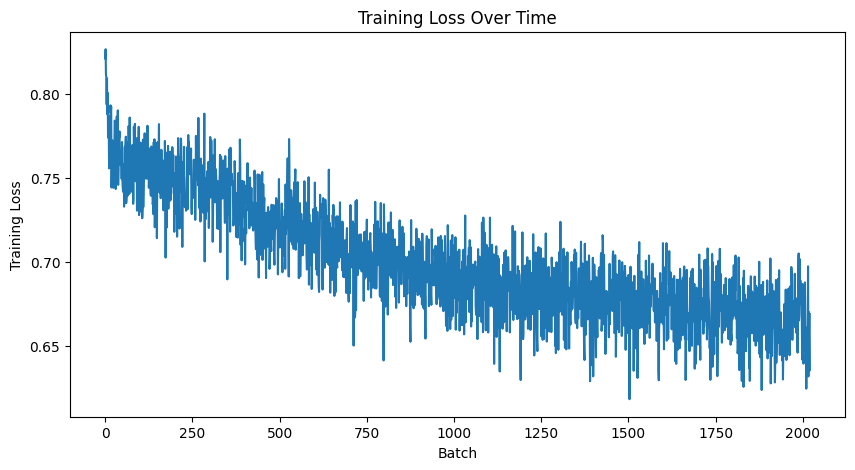

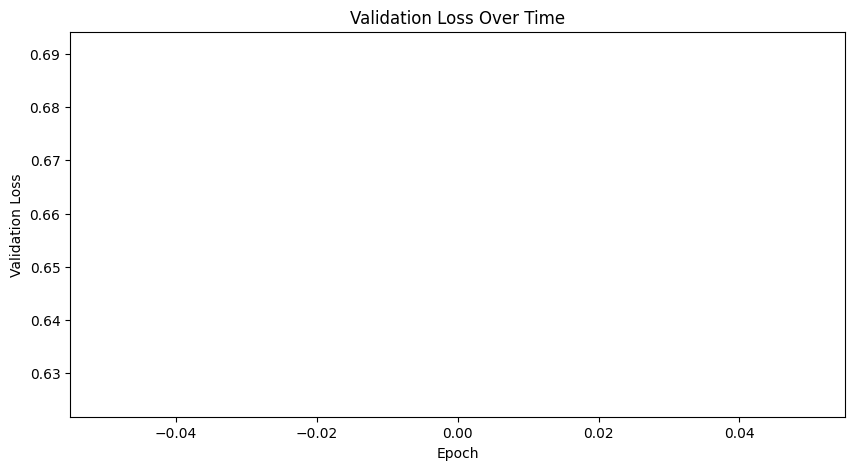

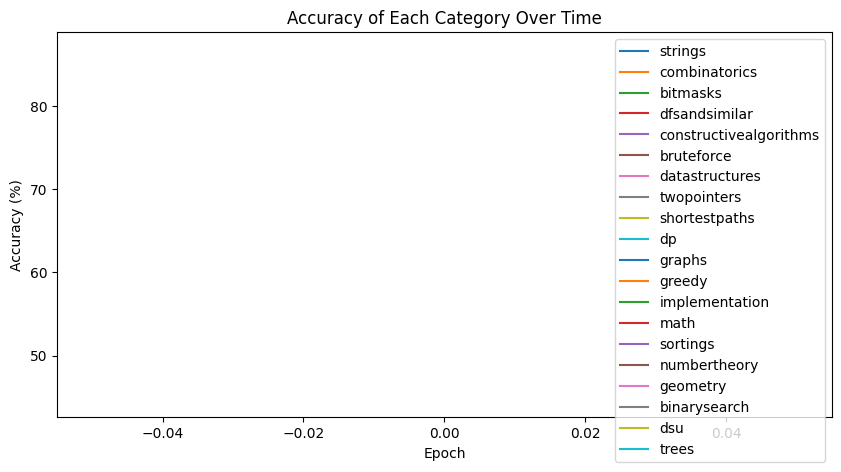

In [14]:
# prompt: make 3 charts, one the training loss over time, one the validation loss for each epoch and another with the accuracy rates of each category over each epoch label the categories by their true names found in index_to_tag

# Plot training loss over time
plt.figure(figsize=(10, 5))
plt.plot(total_losses)
plt.xlabel('Batch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time')
plt.show()

# Plot validation loss for each epoch
plt.figure(figsize=(10, 5))
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time')
plt.show()

# Plot accuracy rates of each category over epochs
plt.figure(figsize=(10, 5))
for i in range(n):
  accuracies = [epoch_accuracies[i] for epoch_accuracies in val_acc]
  plt.plot(accuracies, label=index_to_tag[i])

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Each Category Over Time')
plt.legend()
plt.show()

Average Accuracy for Epoch 1: 69.11%


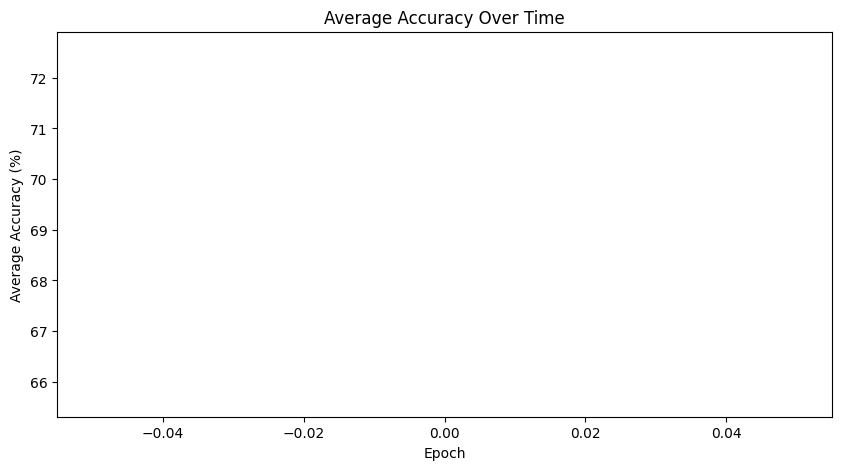

In [15]:
# prompt: now make a new char just for the average accuracy

# Calculate and print the average accuracy across all tags for each epoch
for epoch in range(EPOCHS):
    avg_epoch_accuracy = sum(val_acc[epoch]) / len(val_acc[epoch])
    print(f"Average Accuracy for Epoch {epoch + 1}: {avg_epoch_accuracy:.2f}%")

# Plot the average accuracy over epochs
plt.figure(figsize=(10, 5))
avg_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in val_acc]
plt.plot(avg_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy (%)')
plt.title('Average Accuracy Over Time')
plt.show()